In [1]:
library(MASS)
library(ggplot2)
library(cowplot)
library(mvtnorm)

options(repr.plot.width=17, repr.plot.height=8)

### Kernel
k <- function(x,x2) exp(-(x-x2)^2)
# k <- function(x,x2) exp(-5*(x-x2)^2)

# Kernel for constraint model
k.c <- function(x,x2) exp(-(x-x2)^2)

# Objective function noise
f <- function(x) sin(1.2*x) + sin((10.0 / 3) * x)
# f <- function(x) sin(1.2*x) + sin((40.0 / 3) * x)
f.noise <- 0

# Constraint (constraint(x) < lambda)
x.plt <- seq(0, 10, .01)
constraint <- function(x) {
  return(c(
    sin(1.3*(x-4.5)),
    ifelse(x<5, exp(sin(x-5)), cos(x)),
    (x-7)^2
  ))
}
c.lambda <- c(
  .6, 
  1.5,
  15
)

# Constant prior value
prior.mu <- 0

# Plot values
x.limits <- c(0, 10)
y.limits <- c(-3, 3)

# Optimization values
n.iterations <- 50
batch.size <- 1

In [2]:
# Function definitions

calculate.regression.model <- function(X, y, cx) {
  # Function model
  K <- outer(X, X, k)
  d <- dim(K)[1]
  if (d == 0) {
    Ki <- K
  } else if (d == 1) {
    Ki <- 1/(K + f.noise)
  } else {
    Ki <- ginv(K + f.noise*diag(K))
  }
  
  fs <- function(Xs) {
    Ks <- outer(Xs, X, k)
    return(prior.mu + Ks %*% Ki %*% (y - prior.mu))
  }
  
  sigma <- function(Xs) {
    Ks <- outer(Xs, X, k)
    Kss <- outer(Xs, Xs, k)
    S <- Kss - Ks %*% Ki %*% t(Ks)
    if (Xs %in% observed.x && f.noise == 0)
      S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  # Constraint model
  
  K.c <- outer(X, X, k.c)
  # Same dimension as K
  if (d == 0) {
    Ki.c <- K.c
  } else if (d == 1) {
    Ki.c <- 1/K.c
  } else {
    Ki.c <- ginv(K.c)
  }
  
  fs.c <- function(Xs) {
    Ks.c <- outer(Xs, X, k.c)
    mu.c <- apply(cx, 2, function(cx.i) {
      prior.mu + Ks.c %*% Ki.c %*% (cx.i - prior.mu)
    })
    return(mu.c)
    # return(prior.mu + Ks.c %*% Ki.c %*% (cx - prior.mu))
  }
  
  sigma.c <- function(Xs) {
    Ks.c <- outer(Xs, X, k.c)
    Kss.c <- outer(Xs, Xs, k.c)
    S.c <- Kss.c - Ks.c %*% Ki.c %*% t(Ks.c)
    if (Xs %in% observed.x && f.noise == 0)
      S.c <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S.c <- diag(ncol(cx)) * c(apply(S.c, 1:2, function(x) max(x,0))) # Numerical instability, (small) negative values should be 0
    return(S.c)
  }
  
  feasable.index <- sapply(X, function(x) all(constraint(x) < c.lambda))
  
  if (d== 0 || sum(feasable.index) == 0) {
    best.x <- prior.mu
    best.y <- -1e10
  } else {
    feasable.index <- sapply(X, function(x) all(constraint(x) < c.lambda))
    feasable.x <- X[feasable.index]
    feasable.y <- y[feasable.index]
    best.x <- feasable.x[which.max(feasable.y)]
    best.y <- max(feasable.y)
  }
  
  return(list(mean=fs, 
              cov=sigma, 
              mean.c=fs.c,
              cov.c=sigma.c,
              best.x=best.x, 
              best.y=best.y))
}

choose.next.evaluation.points <- function(x, y.acq, observed.x, gp.model) {
  y2 <- y.acq[!x %in% observed.x]
  x2 <- x[!x %in% observed.x]
  order.index <- order(y2, decreasing = T)
  y2 <- y2[order.index]
  x2 <- x2[order.index]
  n.best <- sum(y2==y2[1])
  if (n.best == 1) {
    best.x <- 1
  } else {best.x <- sample(1:n.best, 1)}
  permutation <- c(best.x,sample(2:length(x2)))
  x2 <- x2[permutation]
  y2 <- y2[permutation]
  next.evaluation.points <- x2[1:batch.size]
  return(next.evaluation.points)
}

acq.func <- function(gp.model, x) {
  return(acq.func.cei(gp.model, x))
}

acq.func.ei <- function(gp.model, x) {
  mu <- gp.model$mean(x)
  sigma <- sqrt(gp.model$cov(x)[1,1])
  best.y <- gp.model$best.y
  if (sigma > 0) {
    # return(max((mu-best.y)*pnorm((mu-best.y)/sigma) + sigma*dnorm((mu-best.y)/sigma), 0))
    return((mu-best.y)*pnorm((mu-best.y)/sigma) + sigma*dnorm((mu-best.y)/sigma))
  } else { # Observed value, no uncertainty
    return(max(mu-best.y,0))
  }
}

acq.func.pf <- function(gp.model, x) {
  # return(pnorm(c.lambda, mean=gp.model$mean.c(x), sd=sqrt(gp.model$cov.c(x))))
  return(suppressWarnings(pmvnorm(lower=rep(-Inf, length(c.lambda)), upper=c.lambda, mean=gp.model$mean.c(x), sigma=sqrt(gp.model$cov.c(x)))[1]))
}

acq.func.cei <- function(gp.model, x) {
  ei <- acq.func.ei(gp.model, x)
  pf <- acq.func.pf(gp.model, x)
  return(ei*pf)
}

calculate.unfeasable.area <- function(x, n=NULL) {
  if (is.null(n)) n <- 1:length(c.lambda)
  restrictions <- constraint(x)[n] < c.lambda[n]
  return(all(restrictions))
}


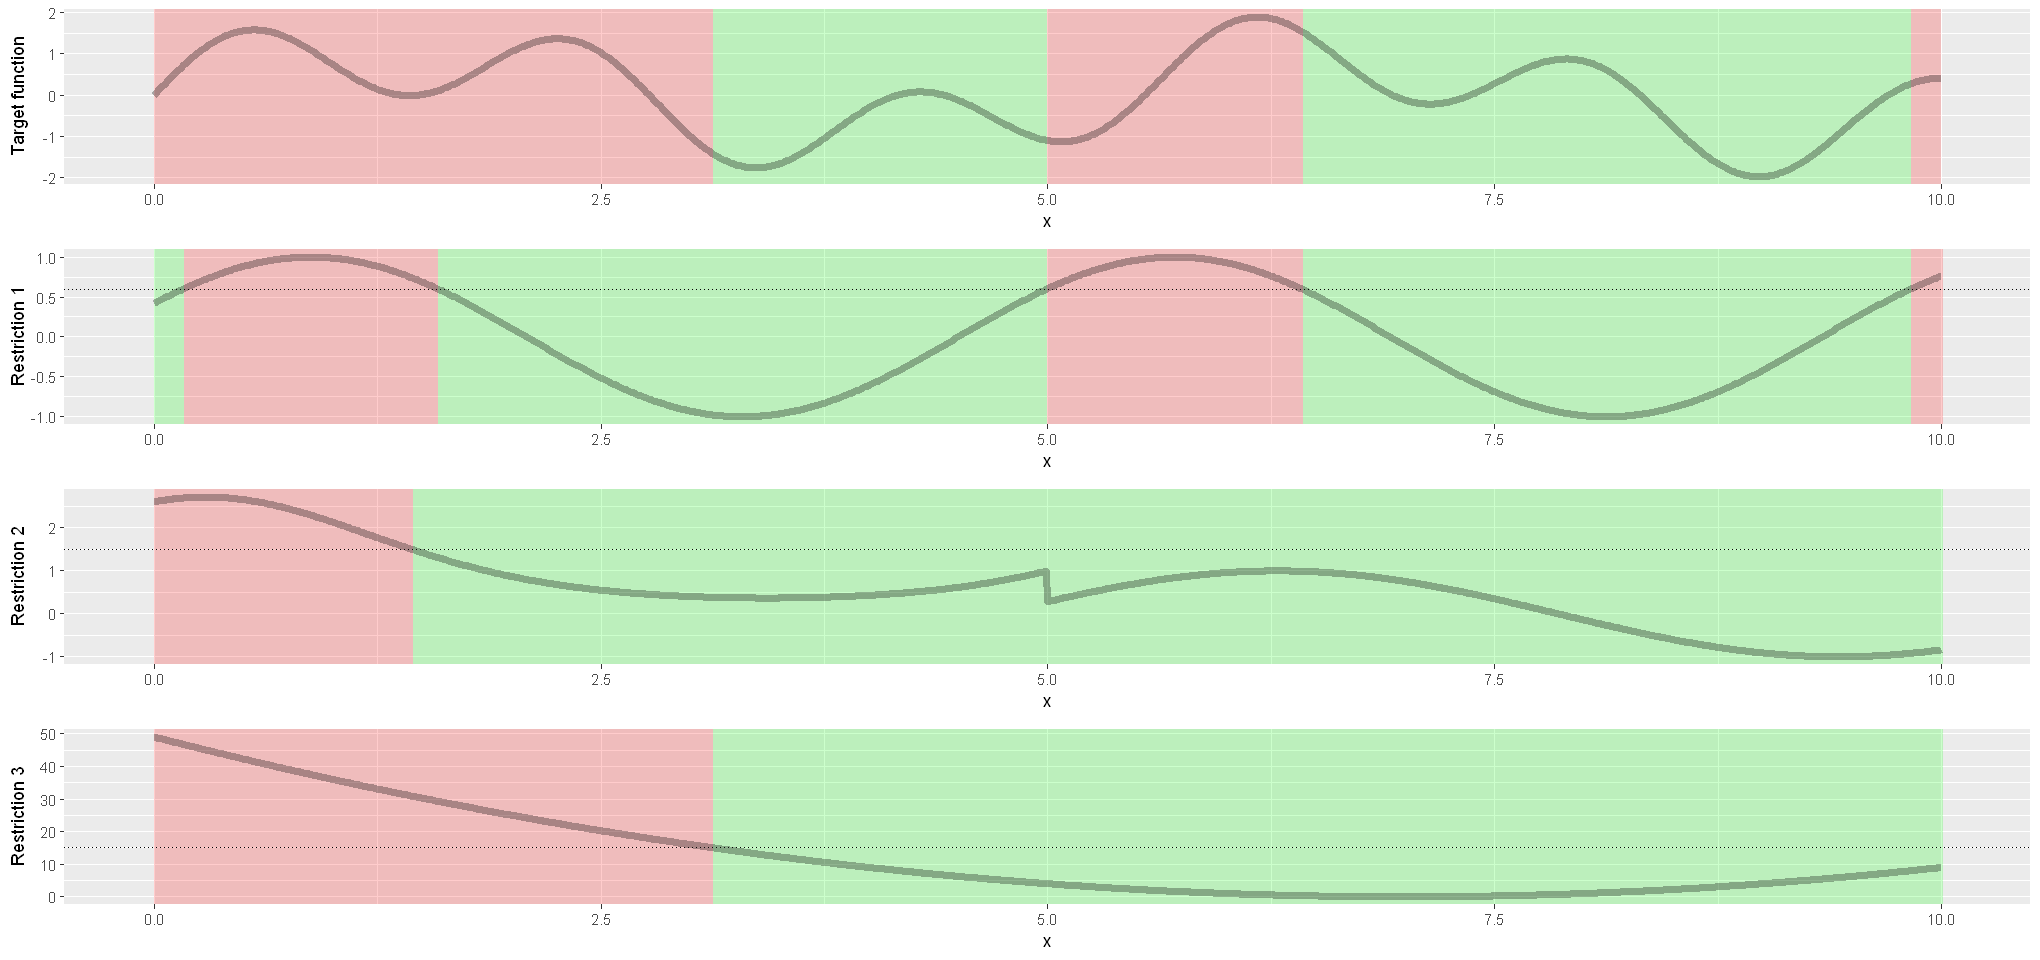

In [3]:
# Build target function and restriction plots

options(repr.plot.width=17, repr.plot.height=8)

xx <- x.plt
yy <- f(xx)
df <- data.frame(x=xx, y=yy)
yy.constraints <- lapply(xx, function(x) constraint(x))

df.constraint <- data.frame(xmin=xx, ymin=-Inf, ymax=Inf, fill=sapply(xx, function(x) calculate.unfeasable.area(x)))
shifted.fill <- c('_', df.constraint$fill[1:(nrow(df.constraint)-1)])
df.constraint <- df.constraint[df.constraint$fill != shifted.fill,]
df.constraint$xmax <- c(df.constraint$xmin[2:nrow(df.constraint)], xx[length(xx)])

plt.f <- ggplot(df, aes(x=x, y=y)) + 
  geom_rect(data=df.constraint, inherit.aes = FALSE, mapping=aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, fill=fill), alpha=.2) +
  geom_line(size=2, alpha=.3) +
  scale_fill_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
  xlim(x.limits) +
  ylab('Target function') +
  theme(legend.position = "none")

constraint.plt.list <- lapply(seq_along(c.lambda), function(i) {
  yy.ci <- sapply(xx, function(x) constraint(x)[i])
  df.ci <- data.frame(x=xx, y=yy.ci, fill=yy.ci<c.lambda[i])
  df.ci$xmin <- df.ci$x
  df.ci$xmax <- df.ci$x + (xx[2]-xx[1])
  plt.ci <- ggplot(df.ci, aes(x=x, y=y, xmin=xmin, xmax=xmax)) + 
    geom_rect(aes(fill=fill), ymin=-Inf, ymax=Inf, color=NA, alpha=.2) +
    geom_line(size=2, alpha=.3) +
    geom_hline(yintercept = c.lambda[i], linetype='dotted') +
    scale_fill_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
    coord_cartesian(xlim=x.limits) +
    ylab(paste0('Restriction ', i)) +
    theme(legend.position = "none")
  return(plt.ci)
})

list.plt <- append(list(plt.f), constraint.plt.list)

plt.cs <- plot_grid(plotlist=list.plt, align='v', nrow=length(c.lambda)+1)
print(plt.cs)

Iteration 1 


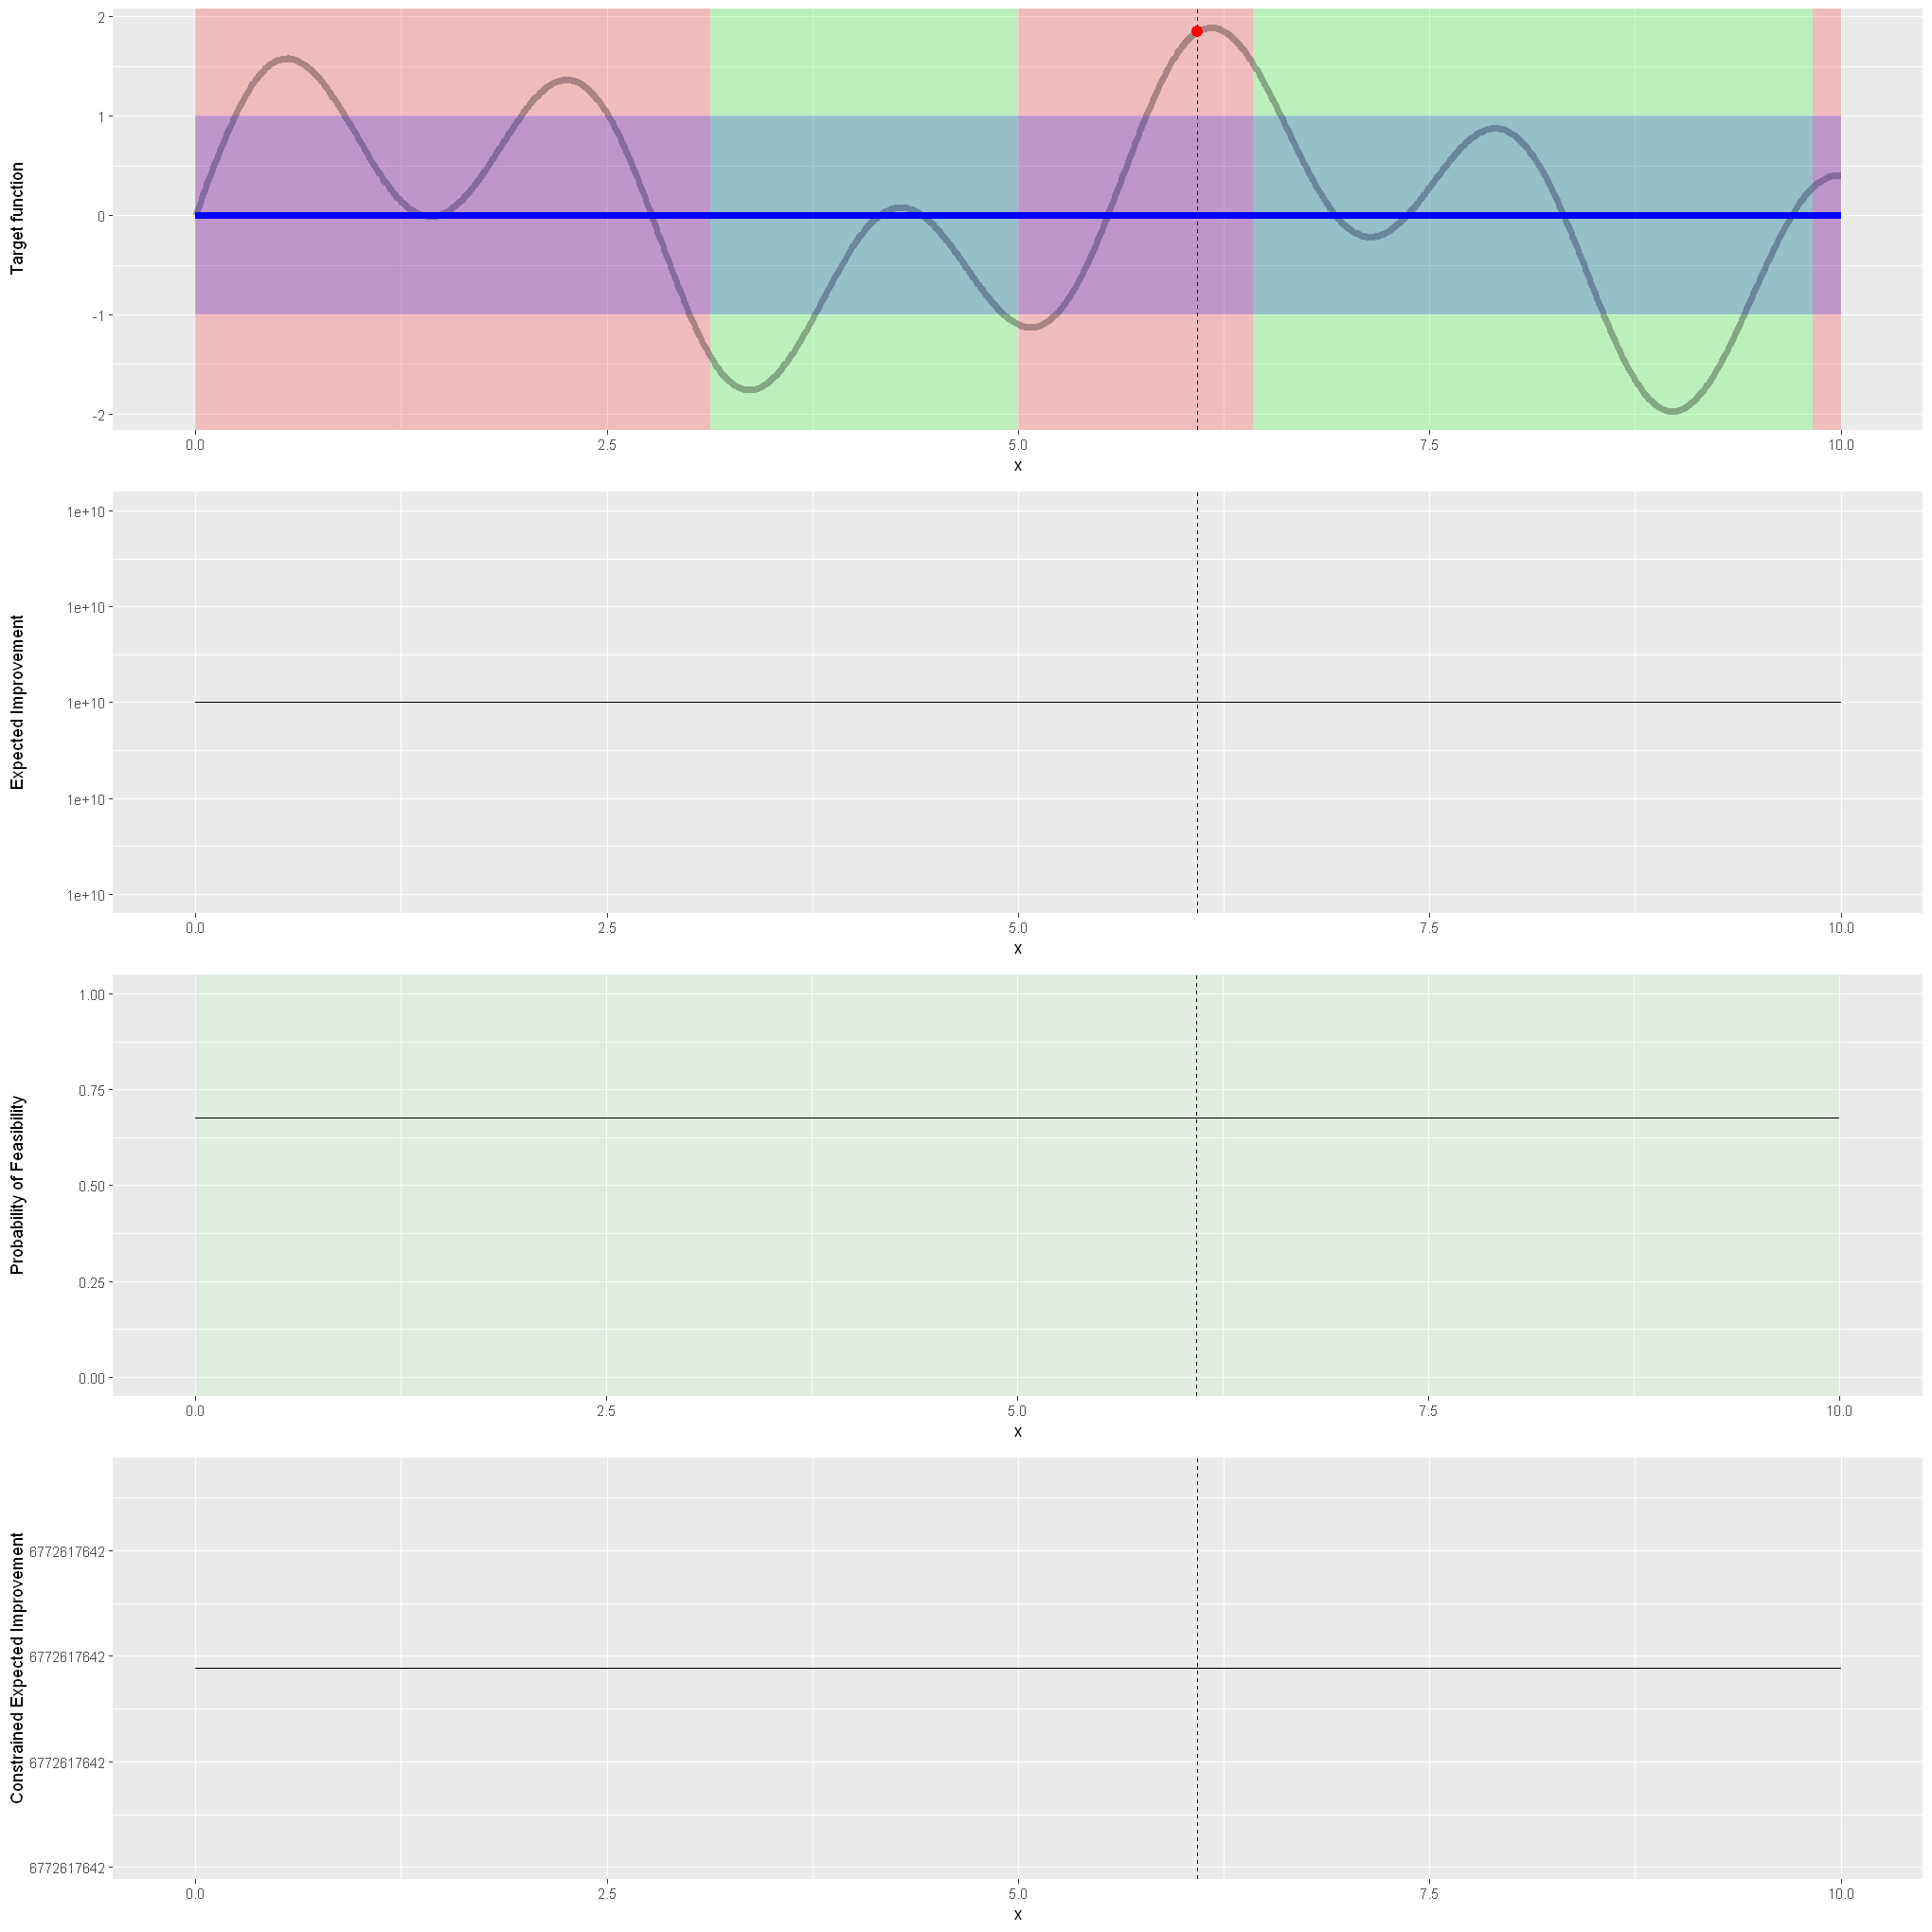

Iteration 2 


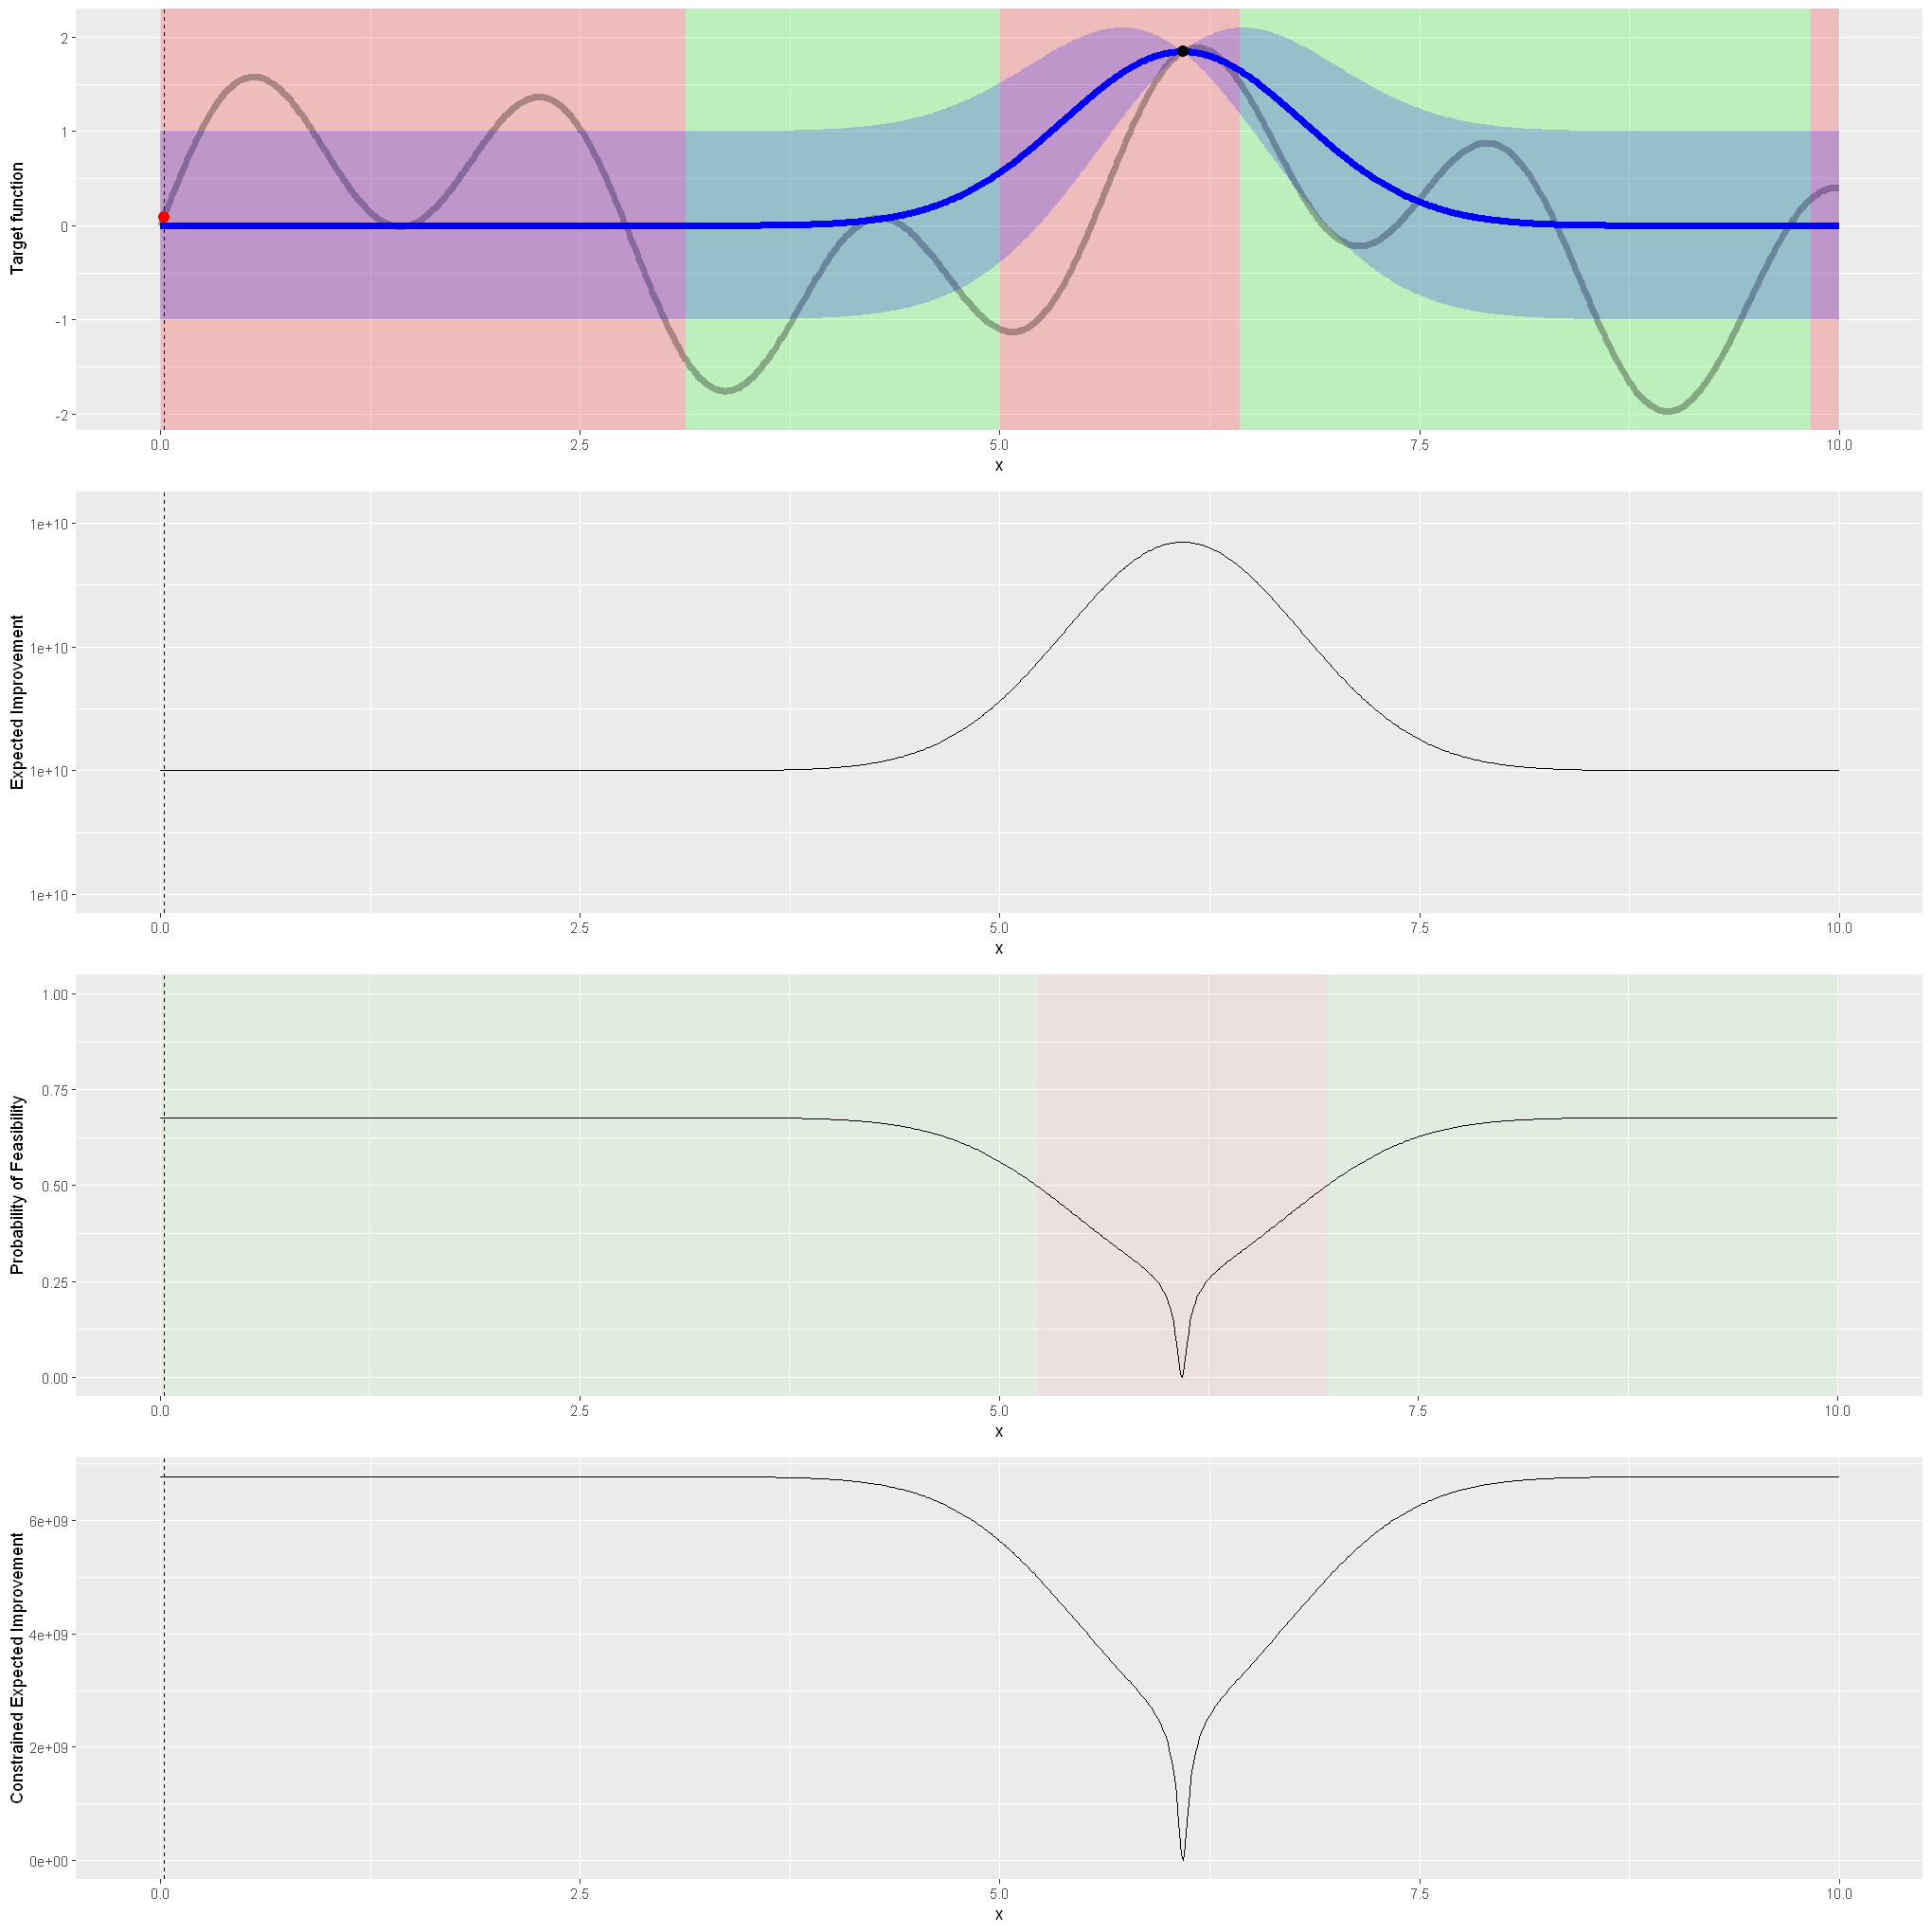

Iteration 3 


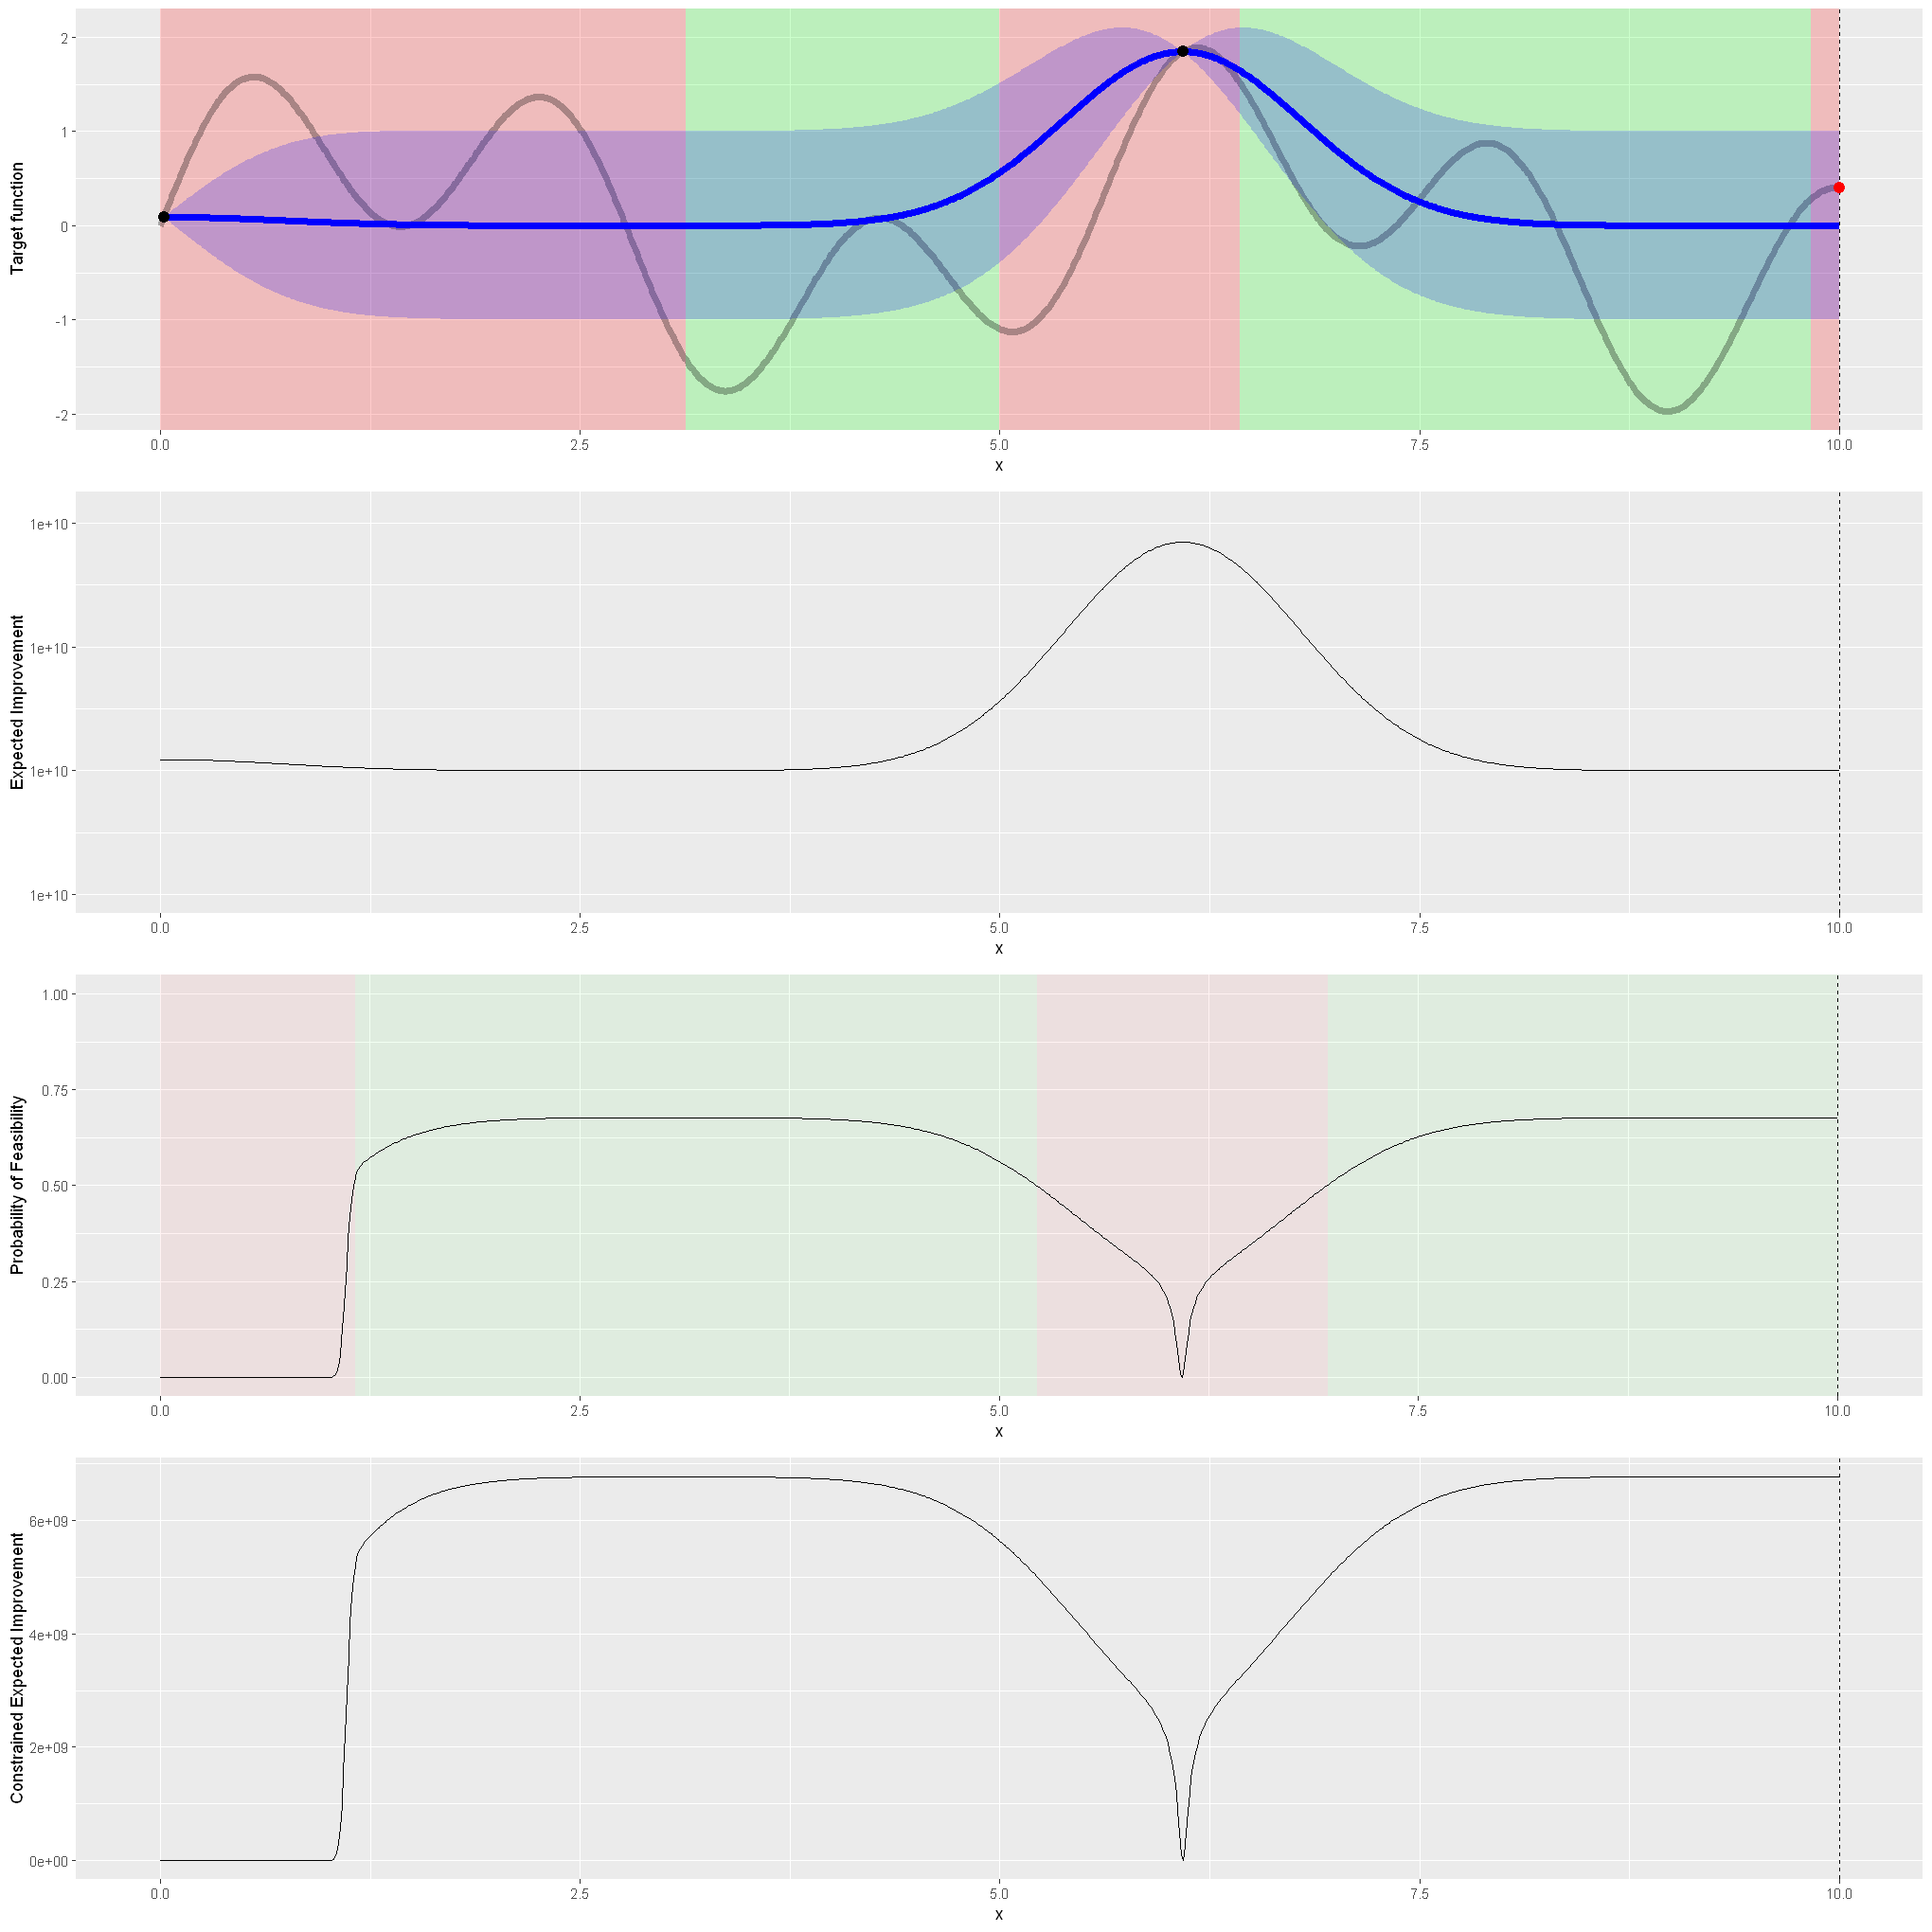

Iteration 4 


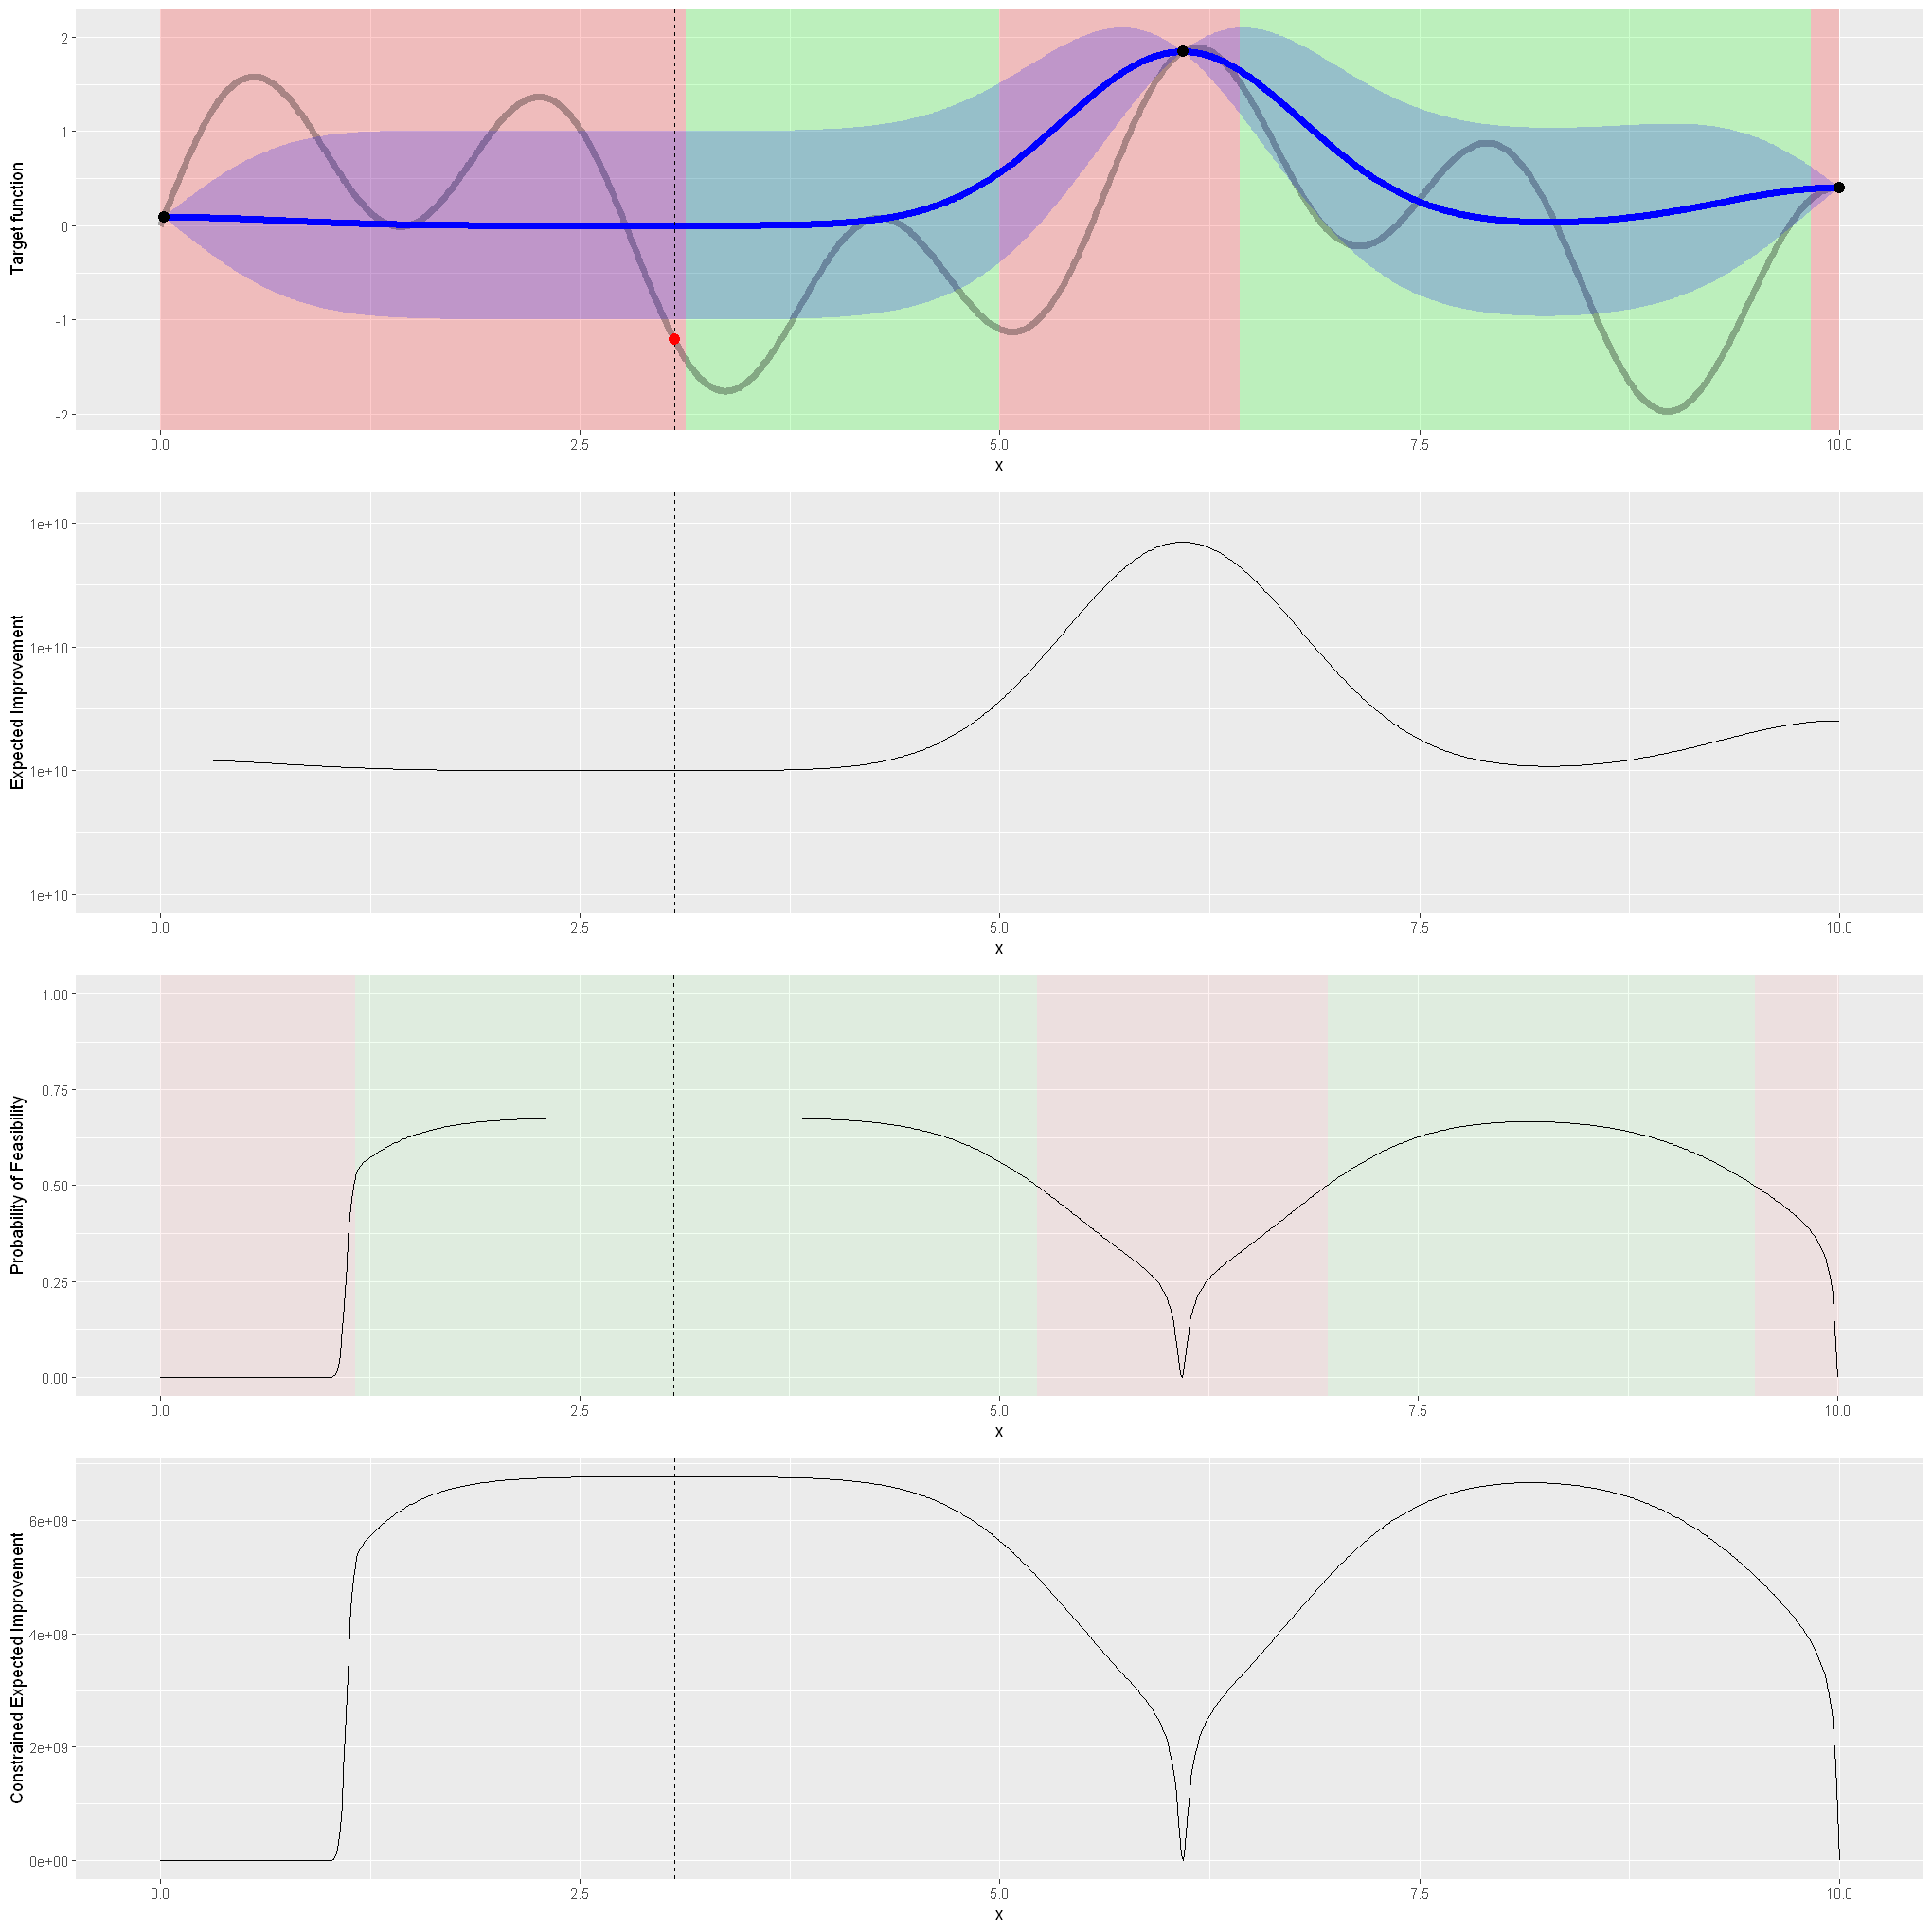

Iteration 5 


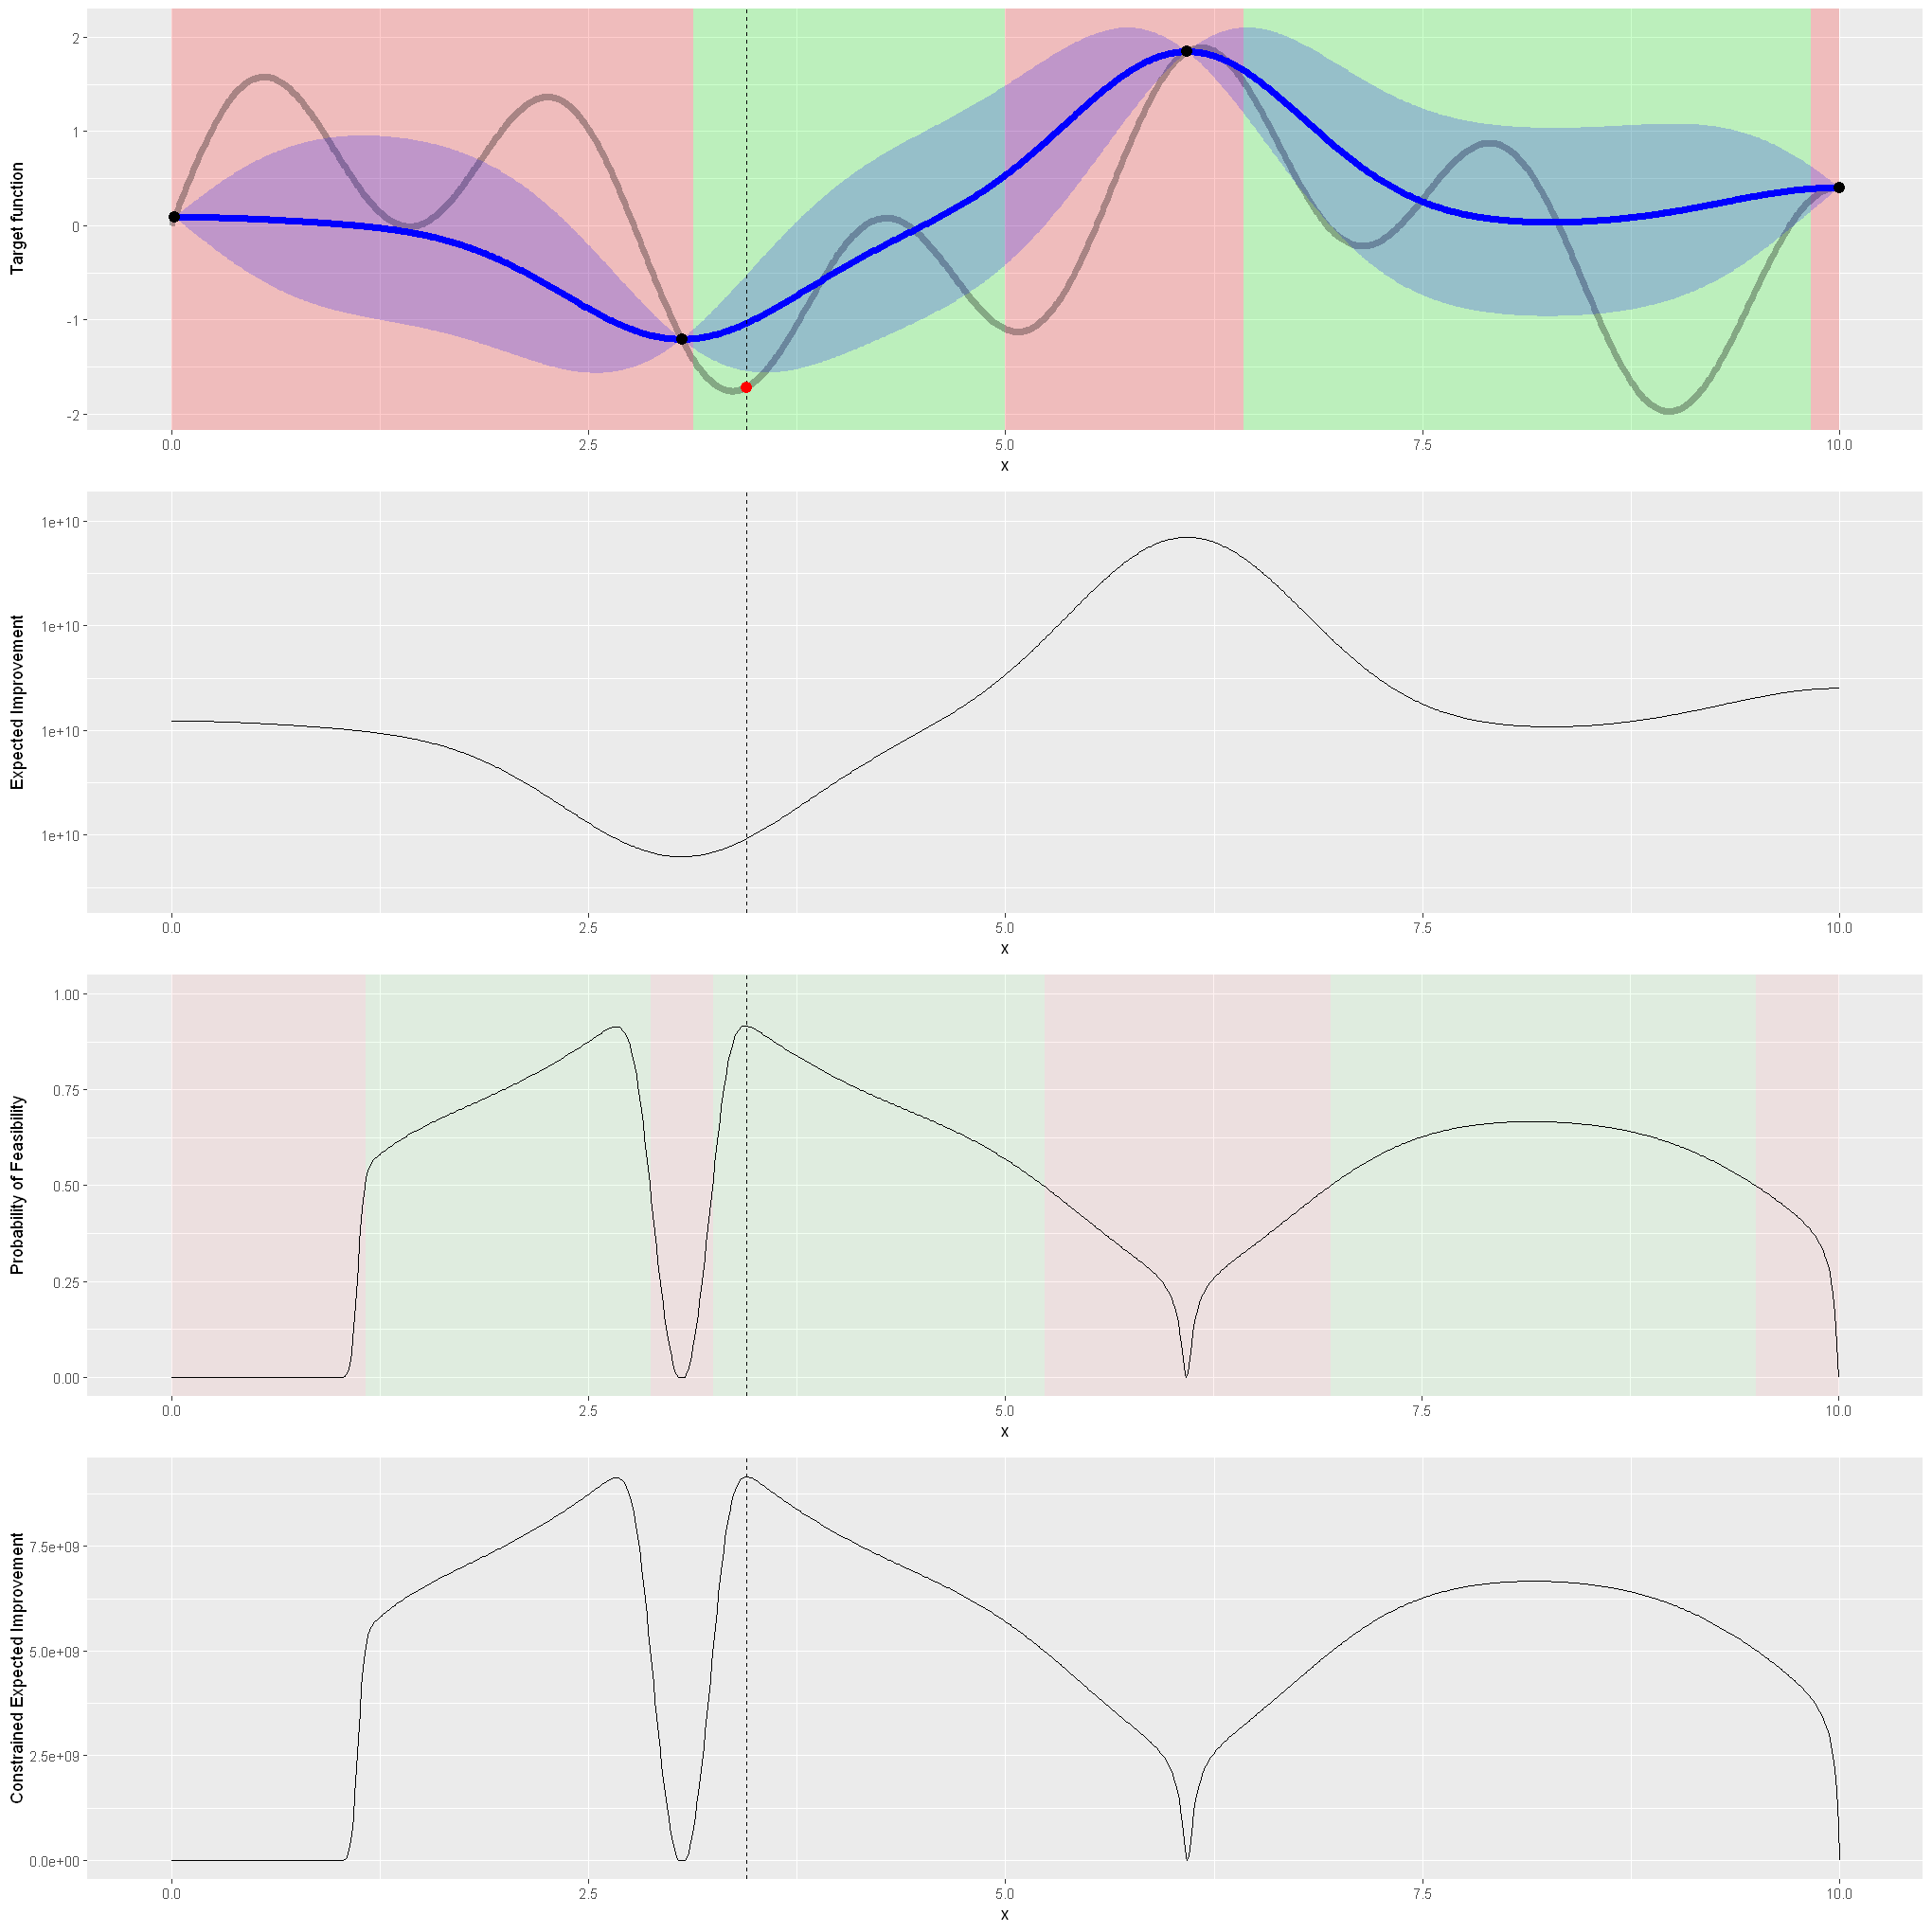

Iteration 6 


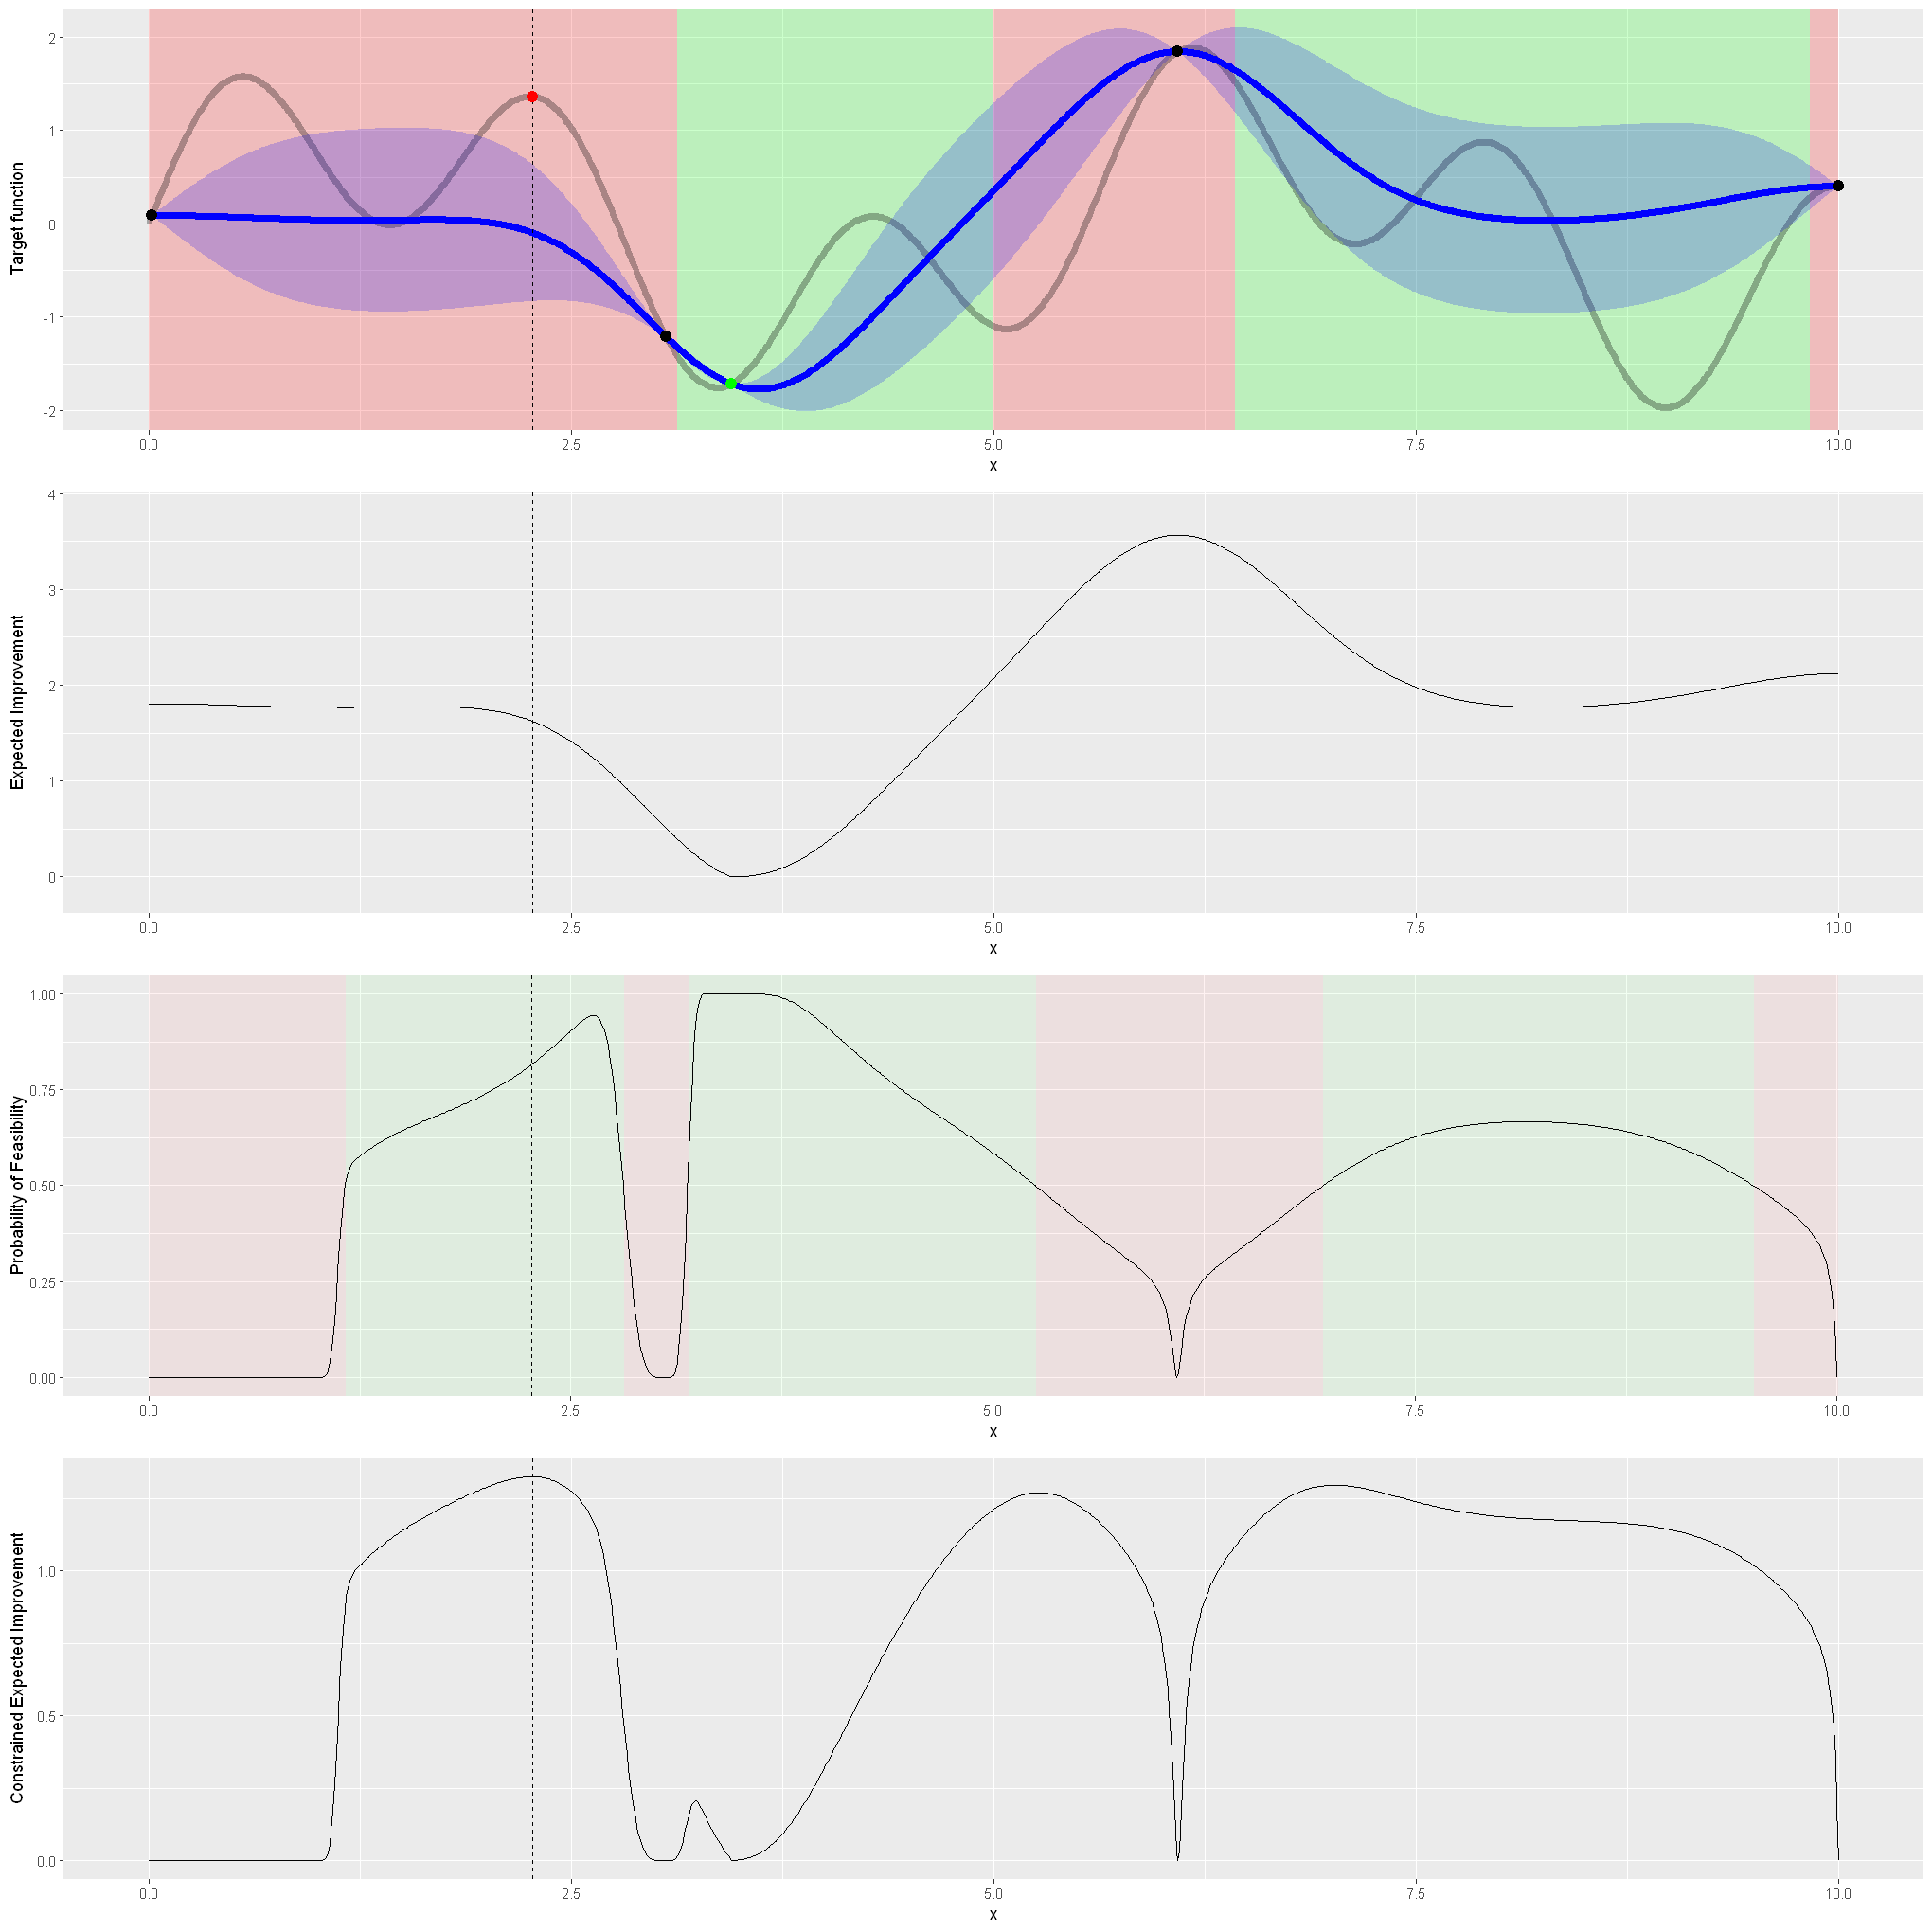

Iteration 7 


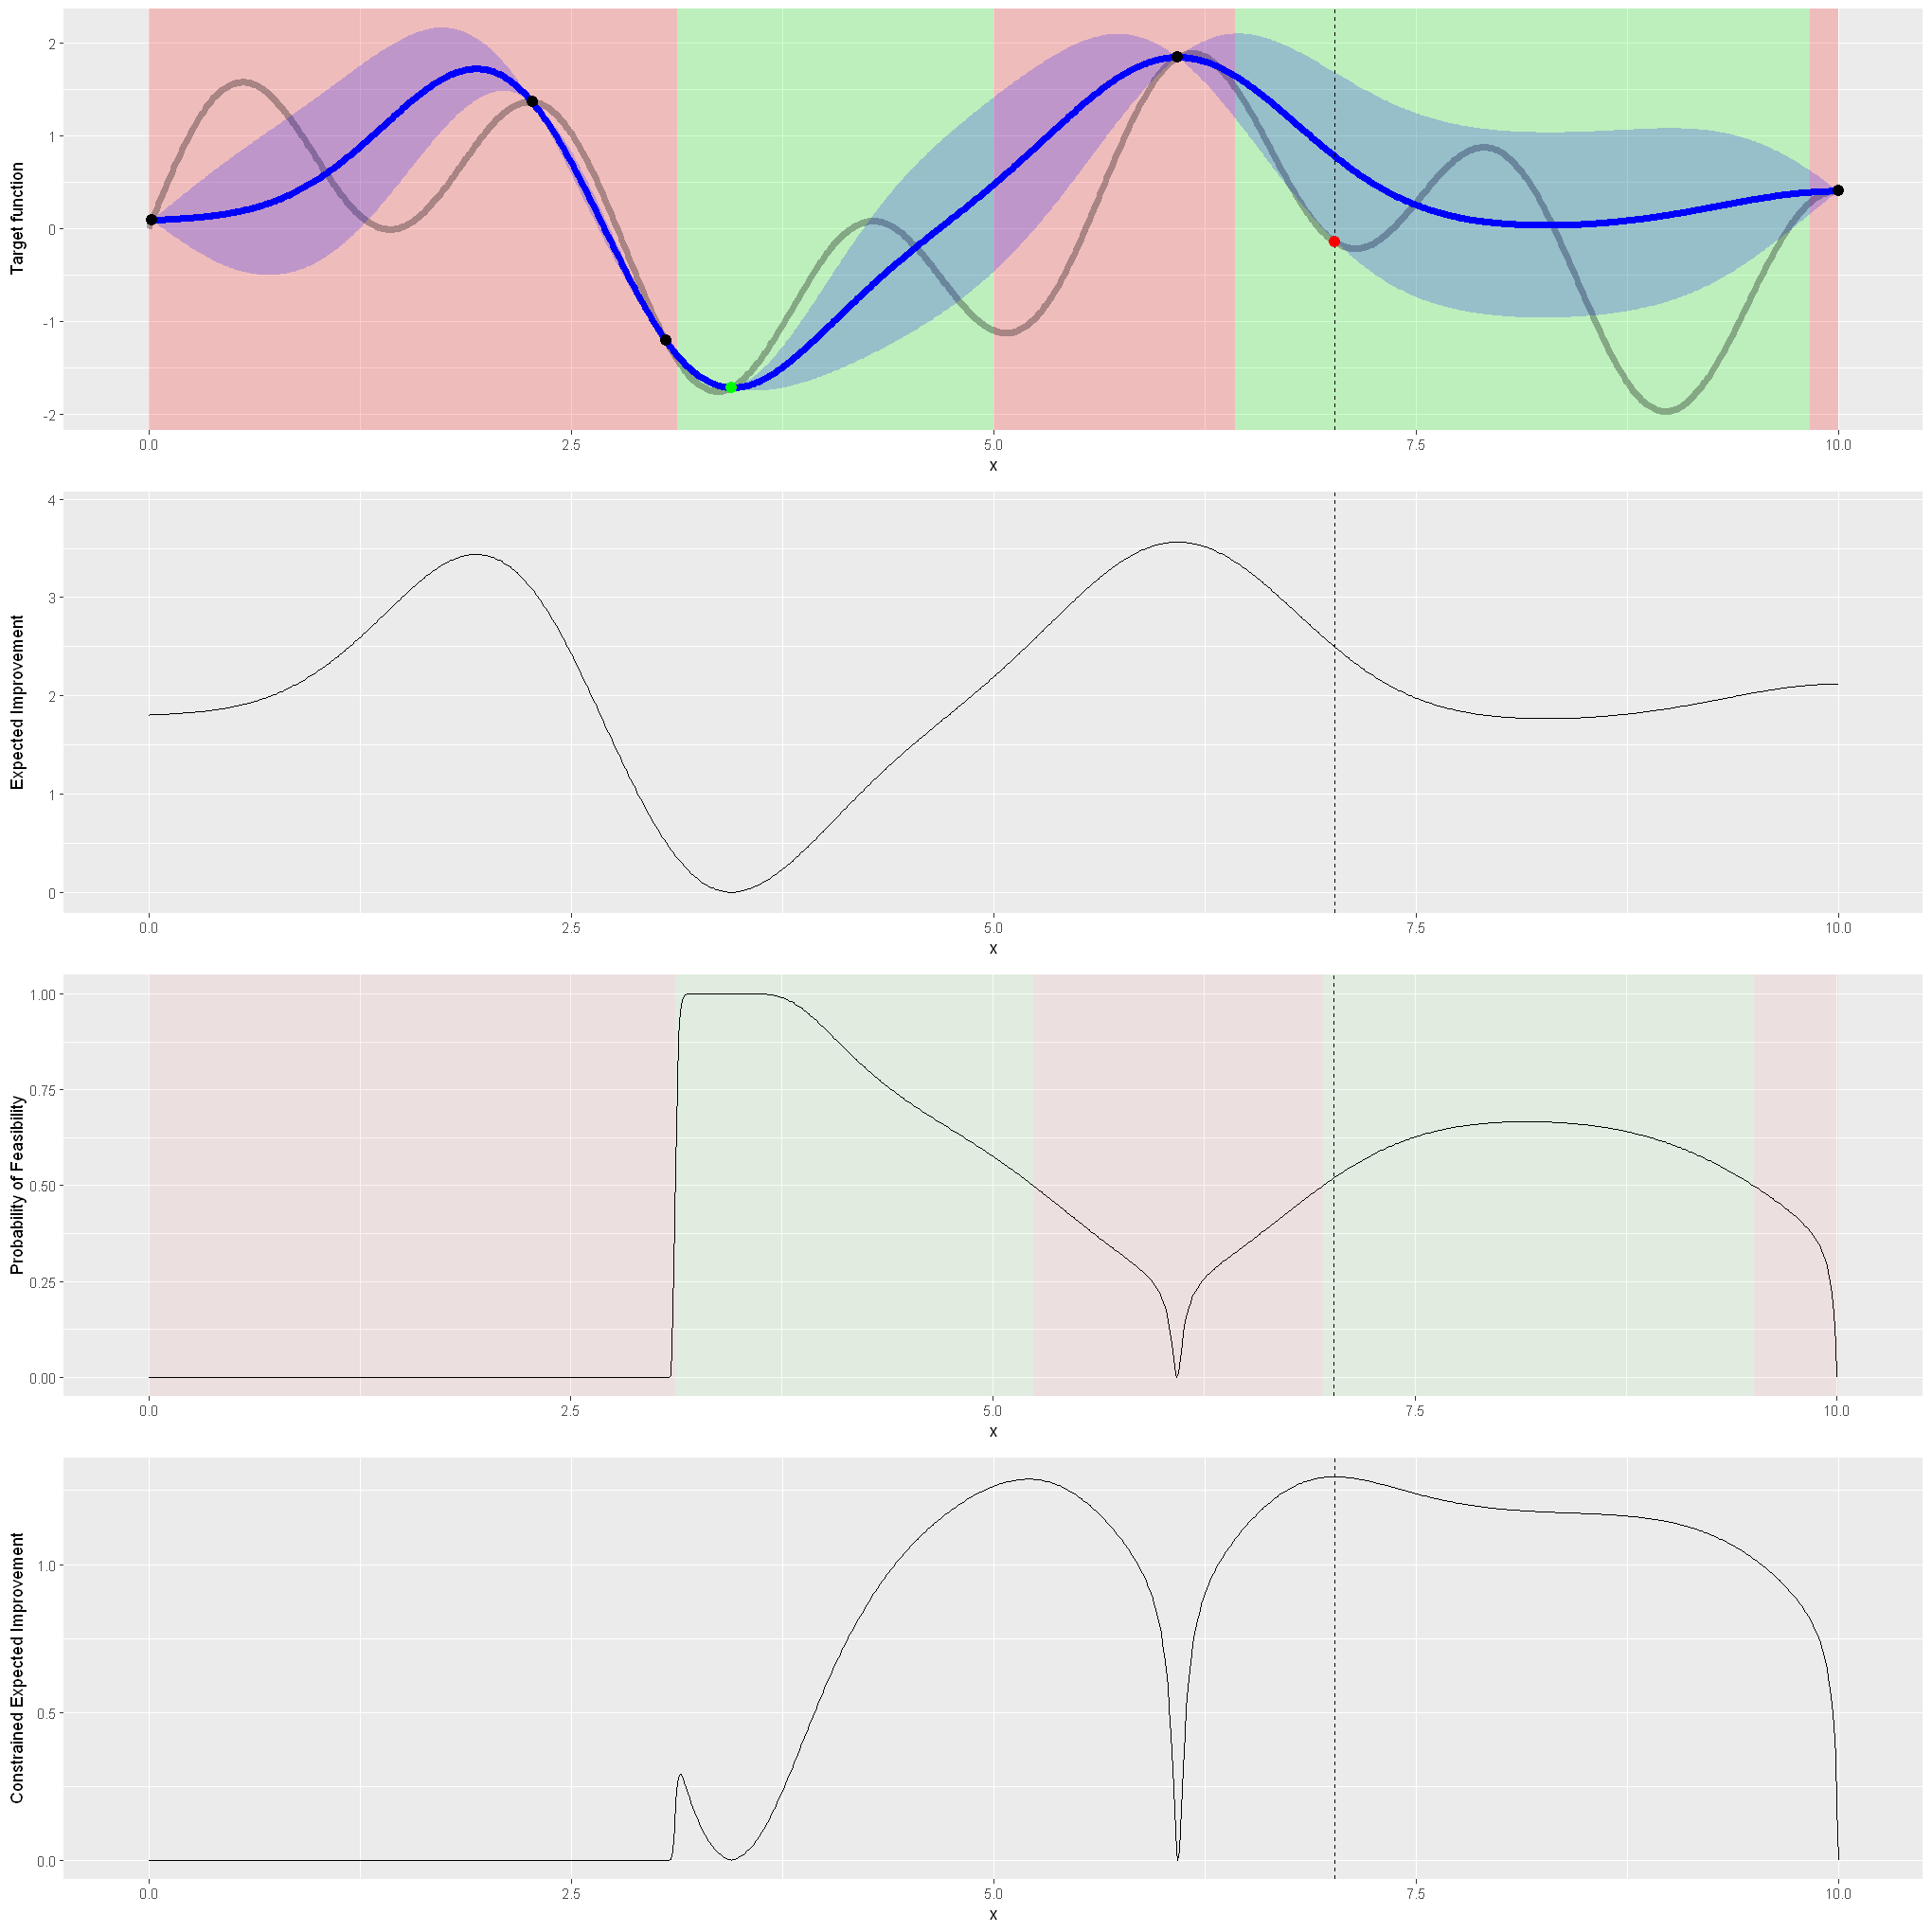

Iteration 8 


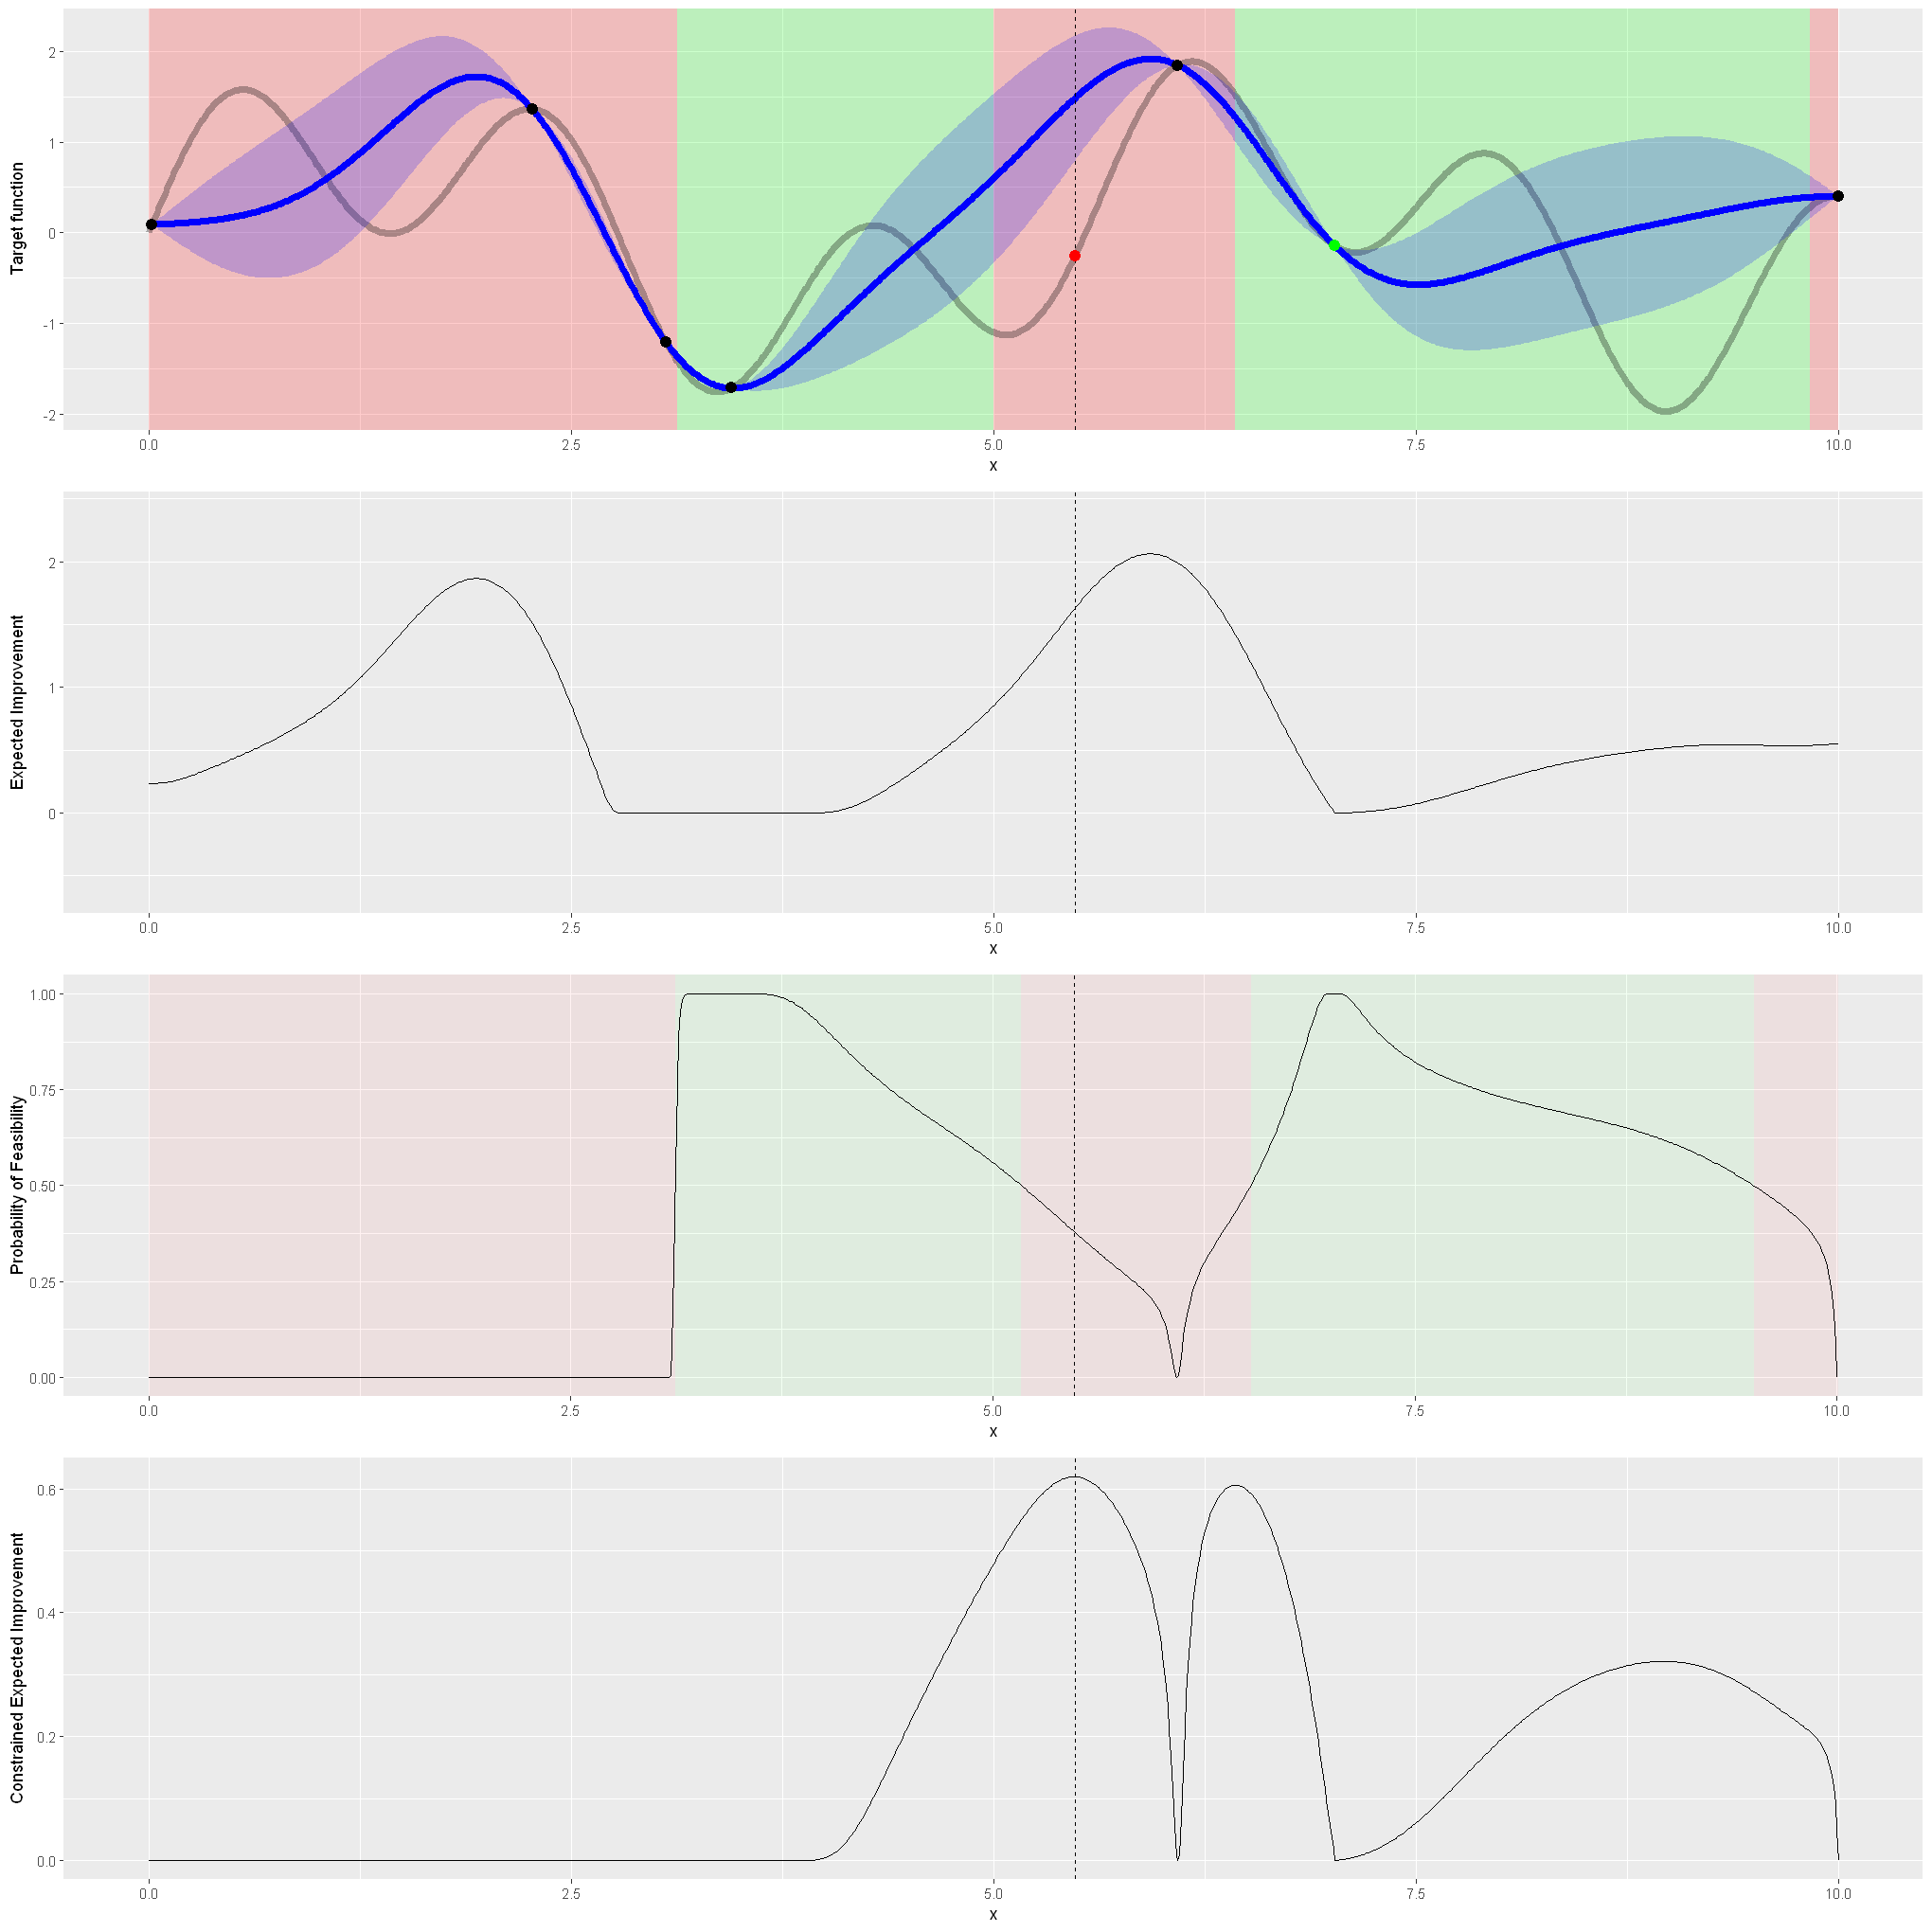

Iteration 9 


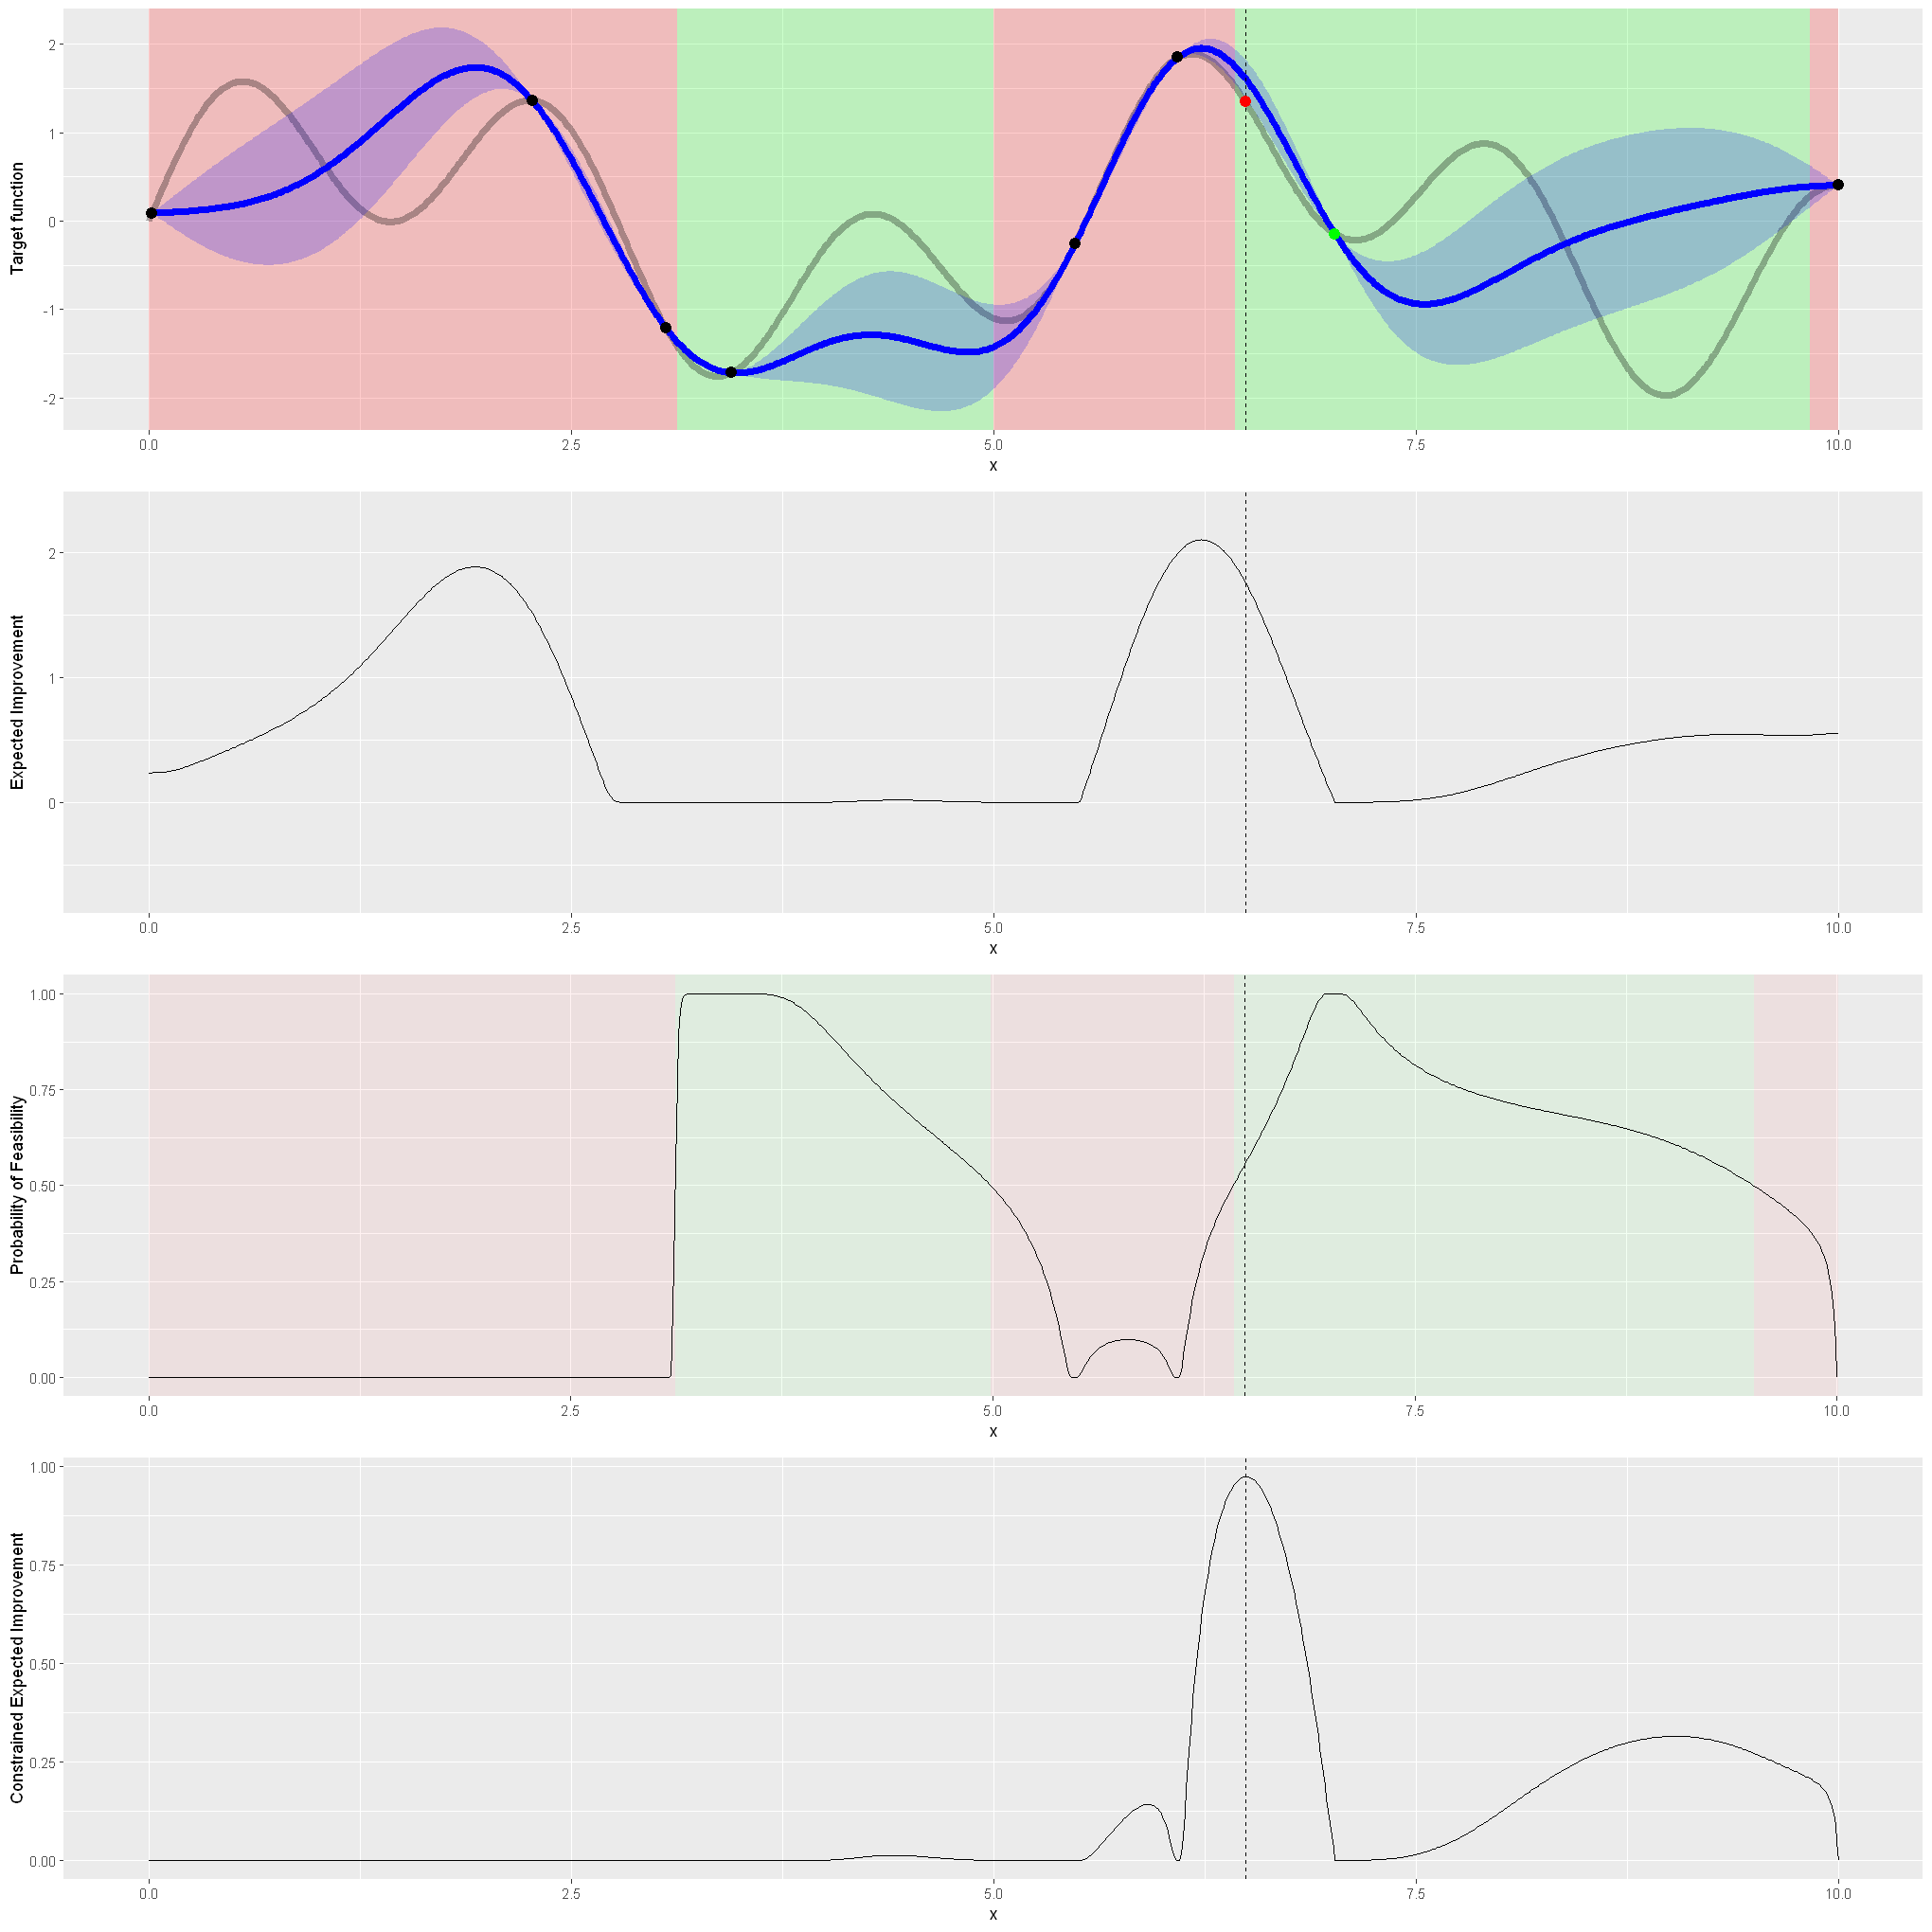

Iteration 10 


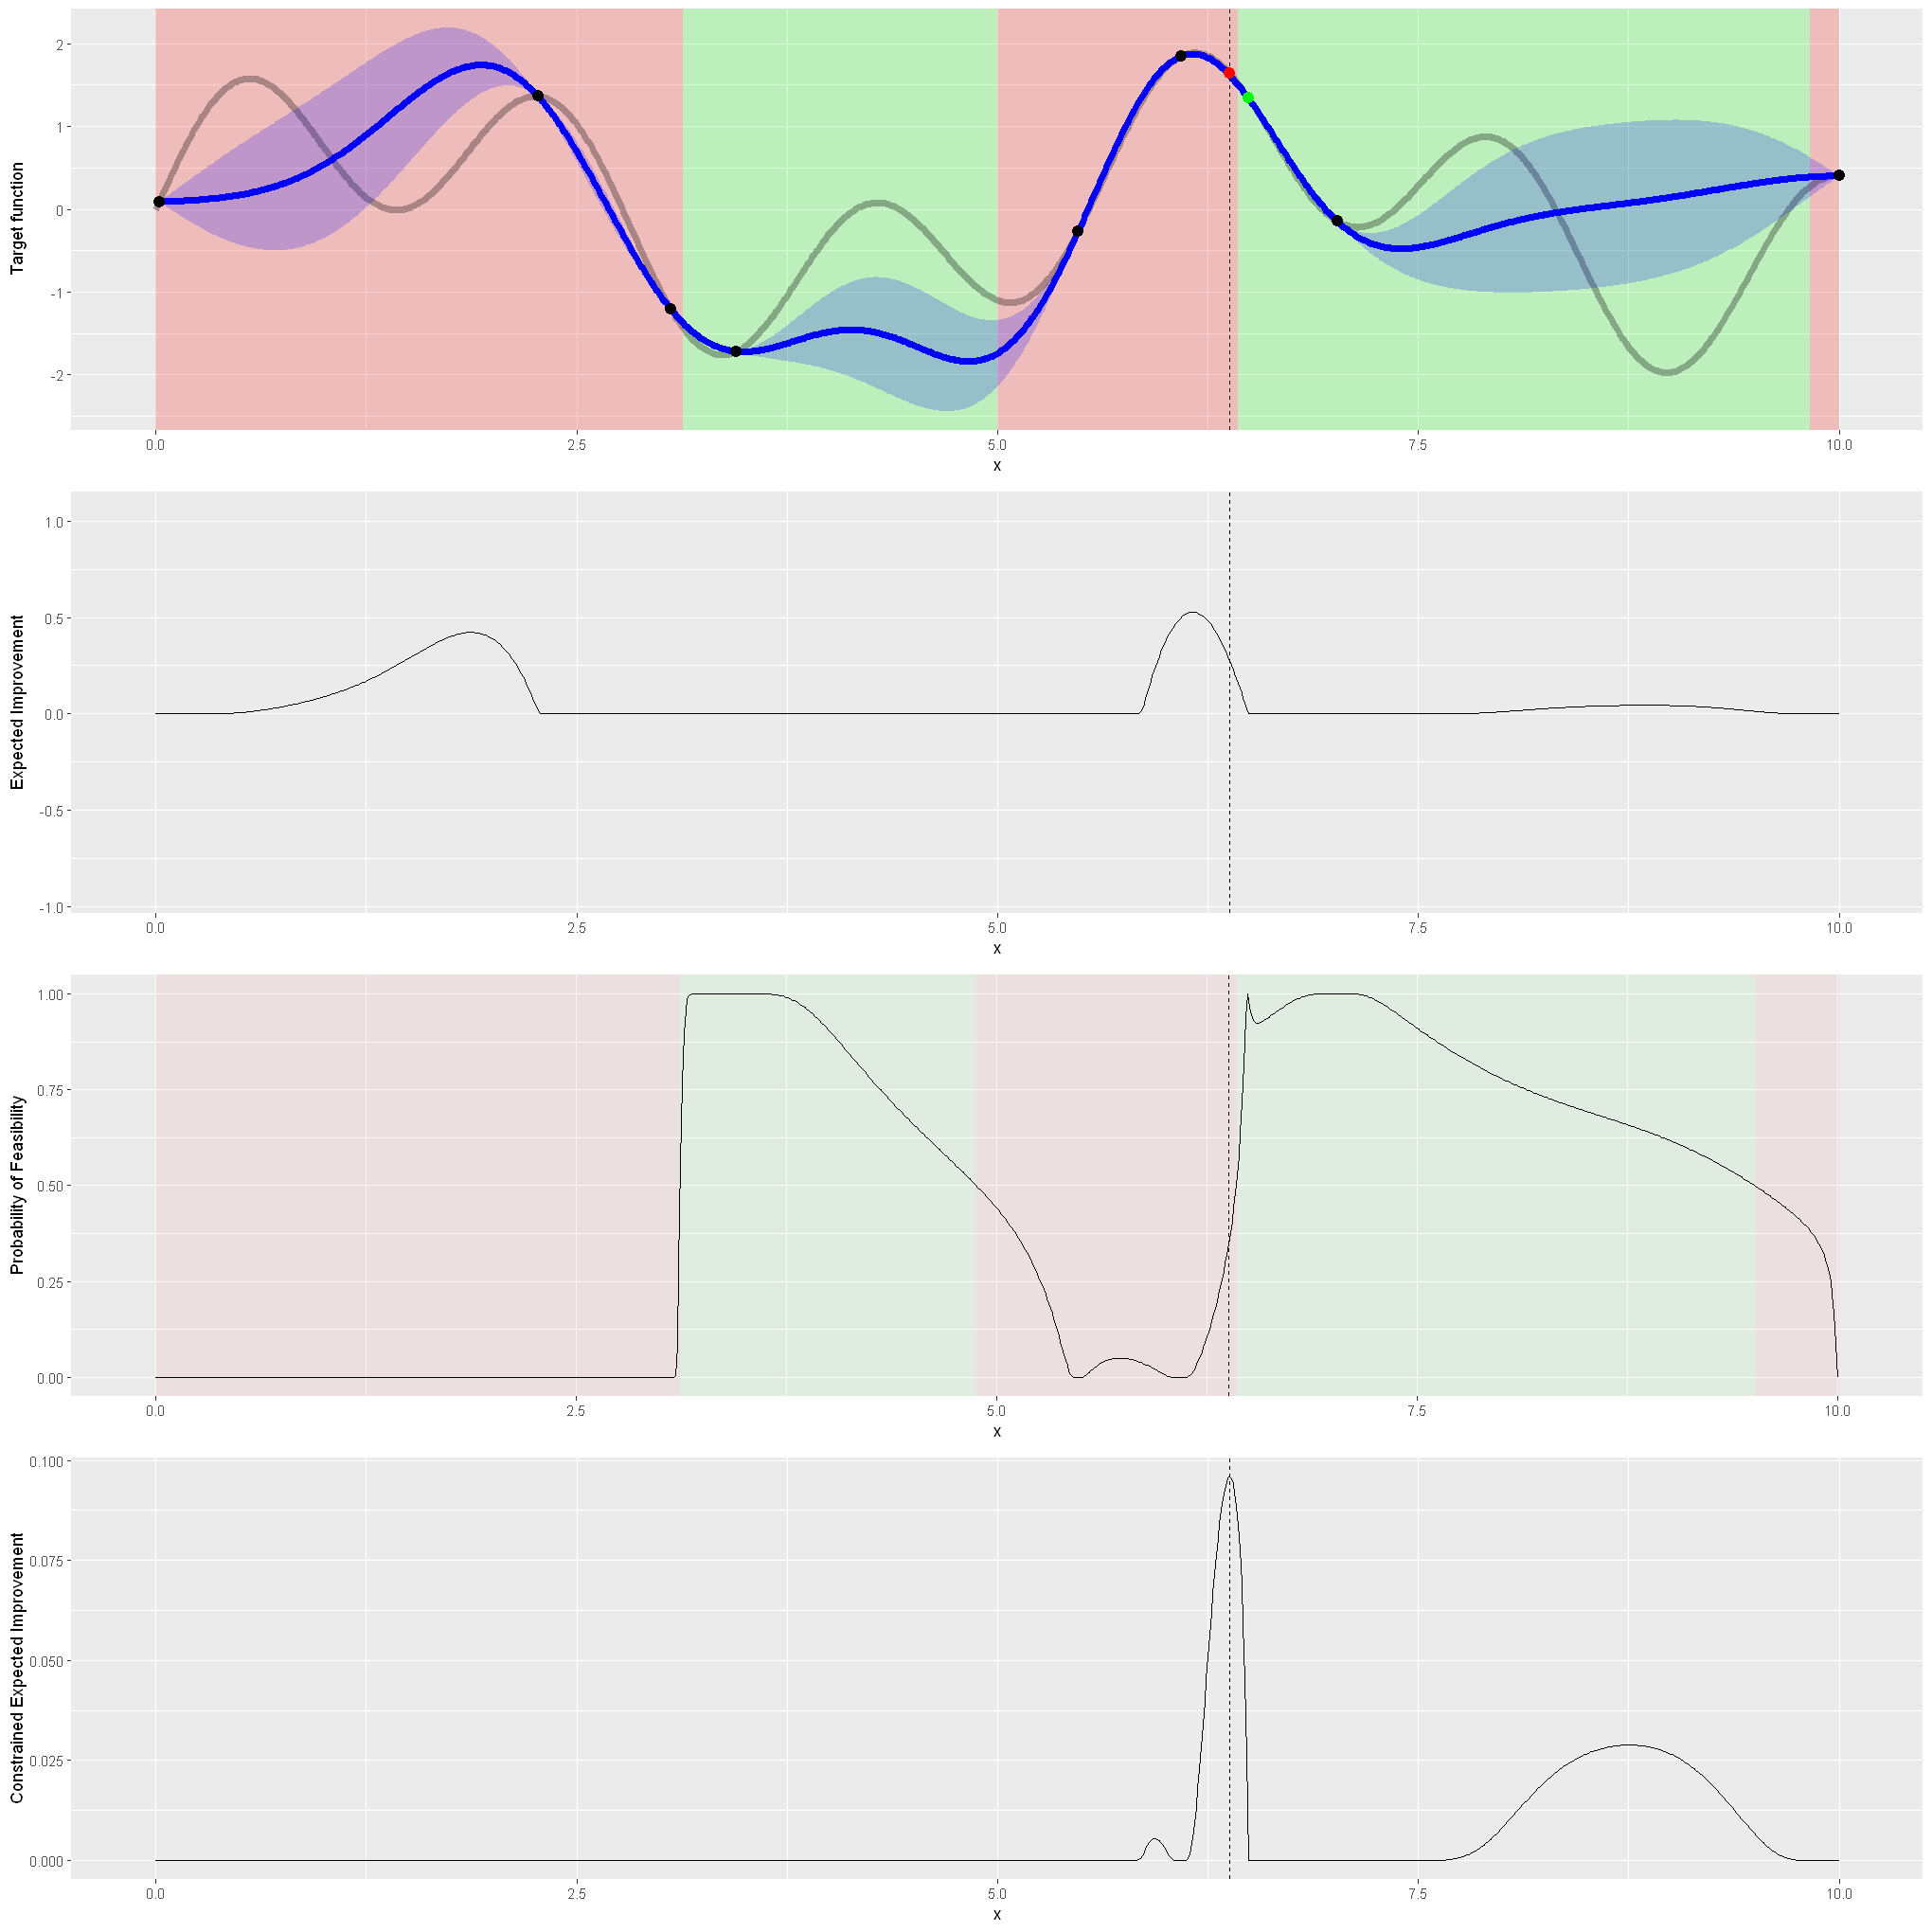

Iteration 11 


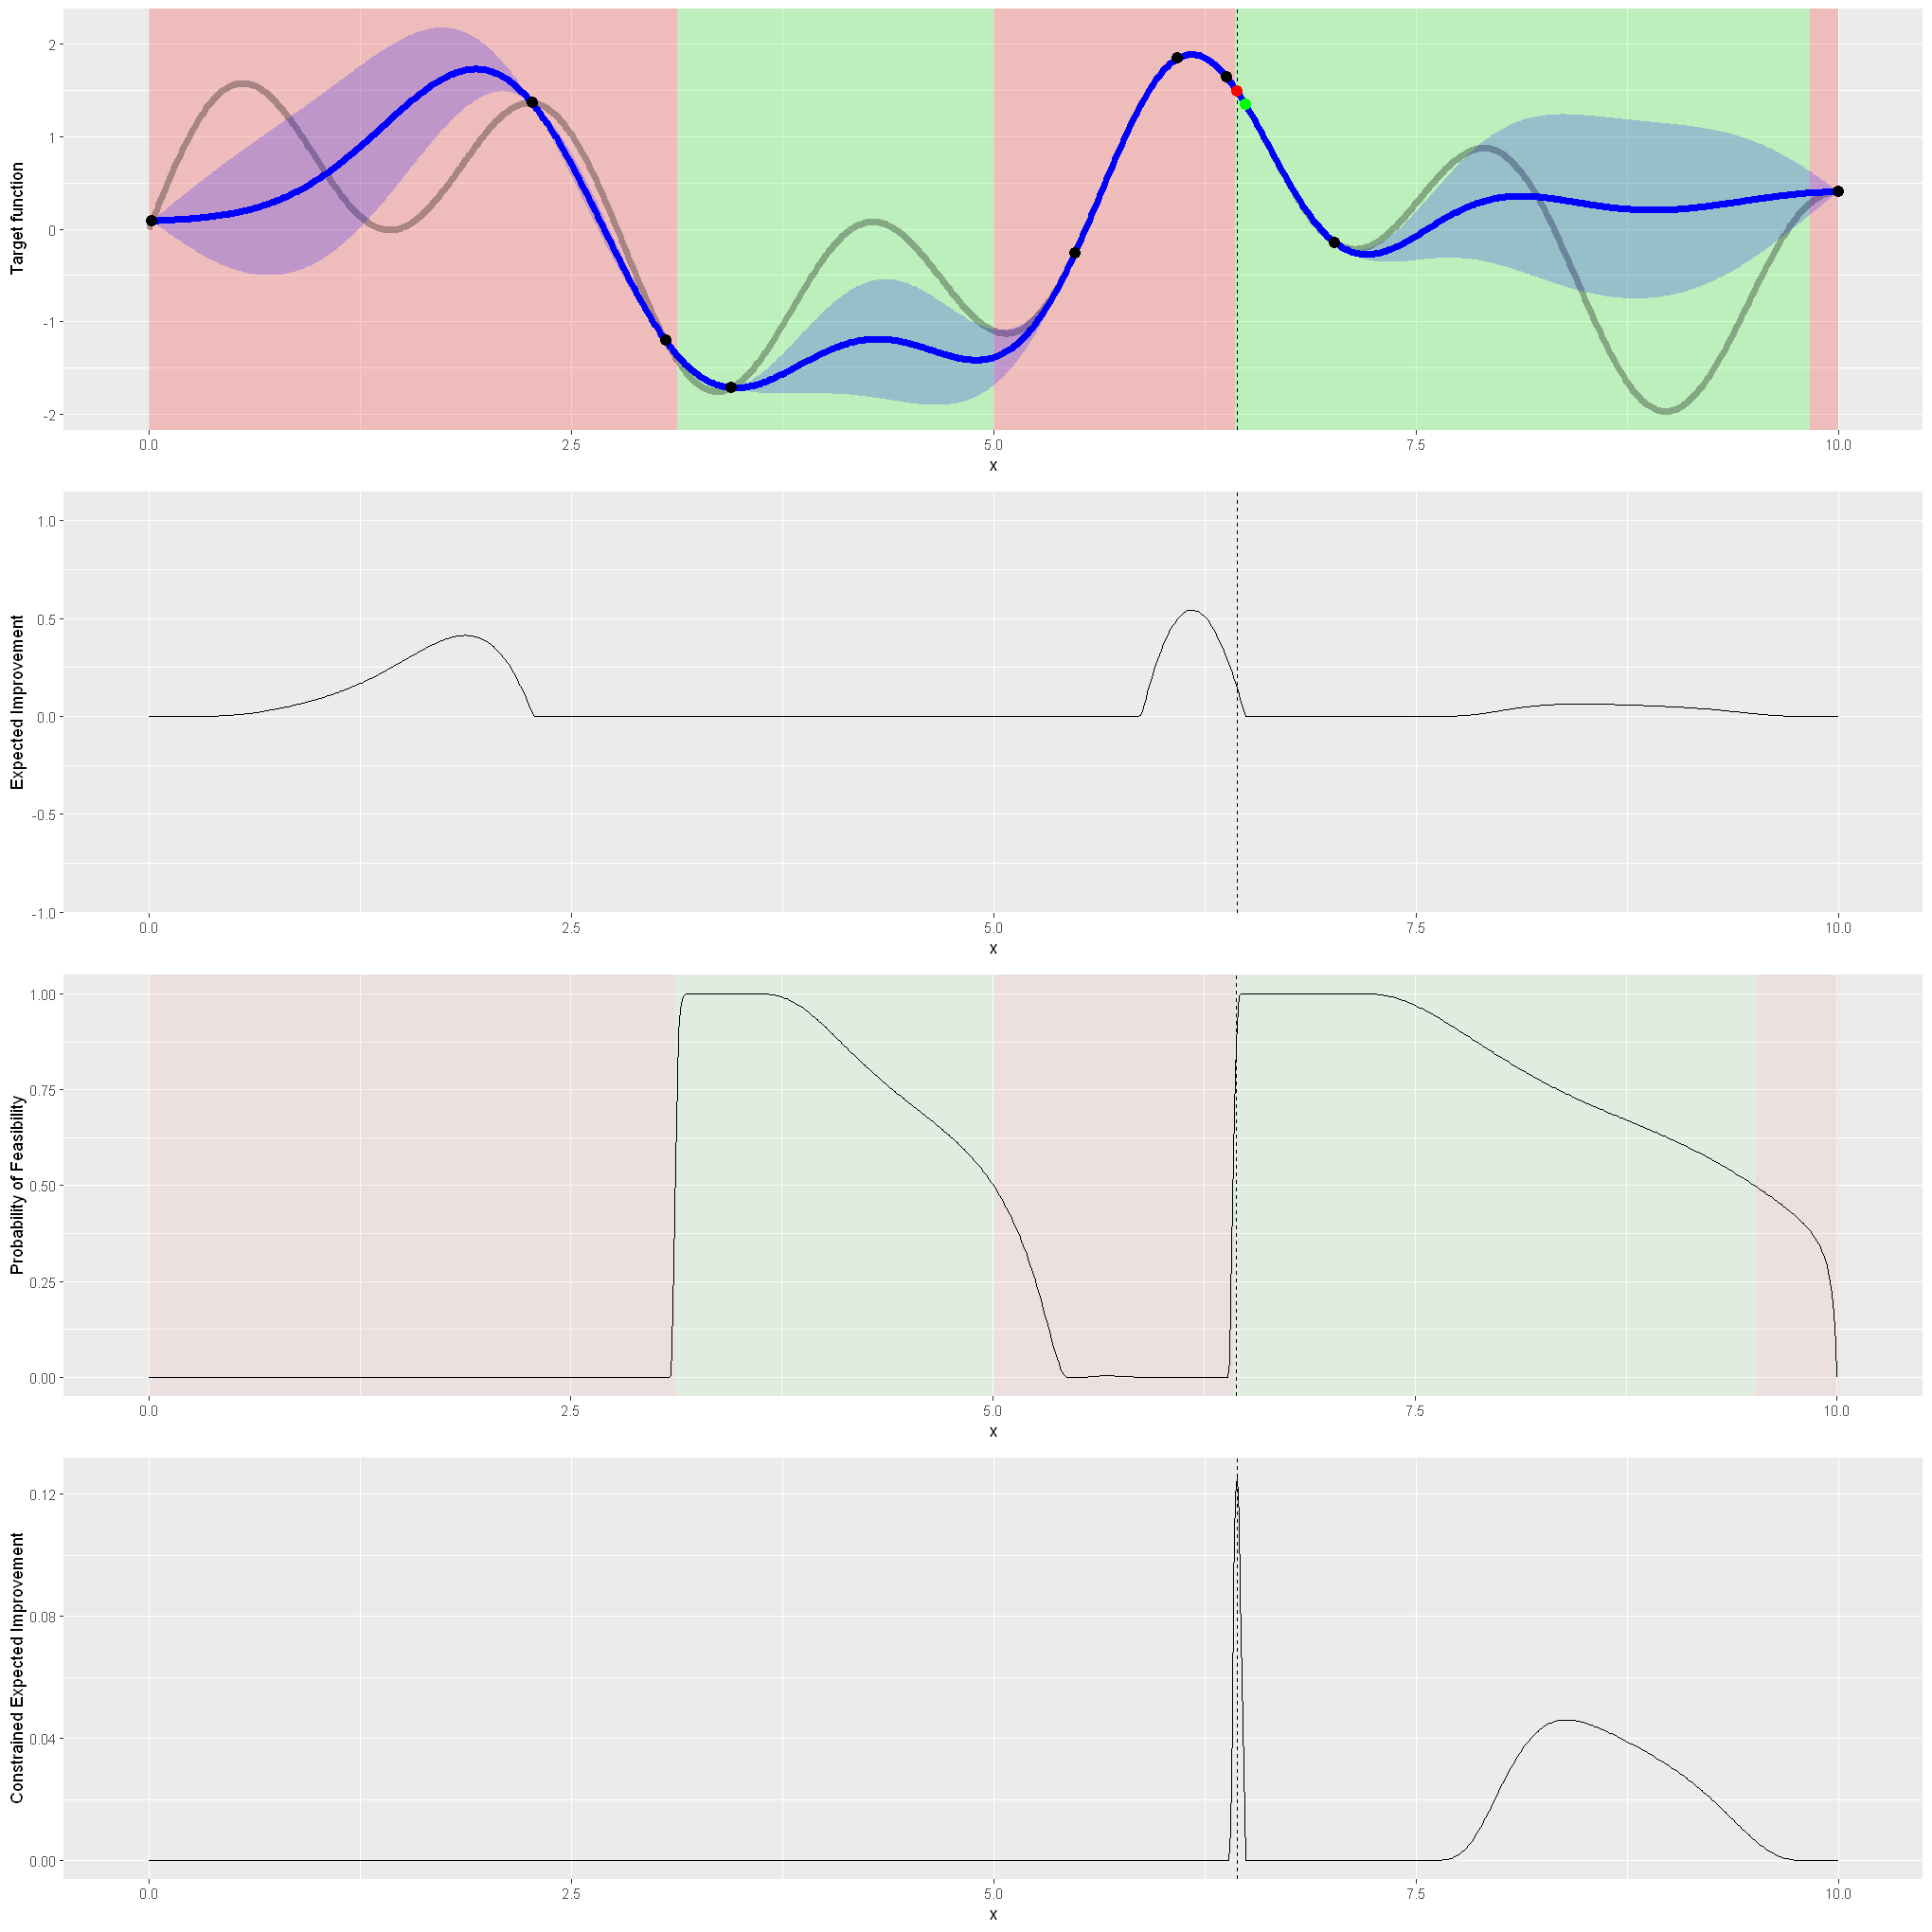

Iteration 12 


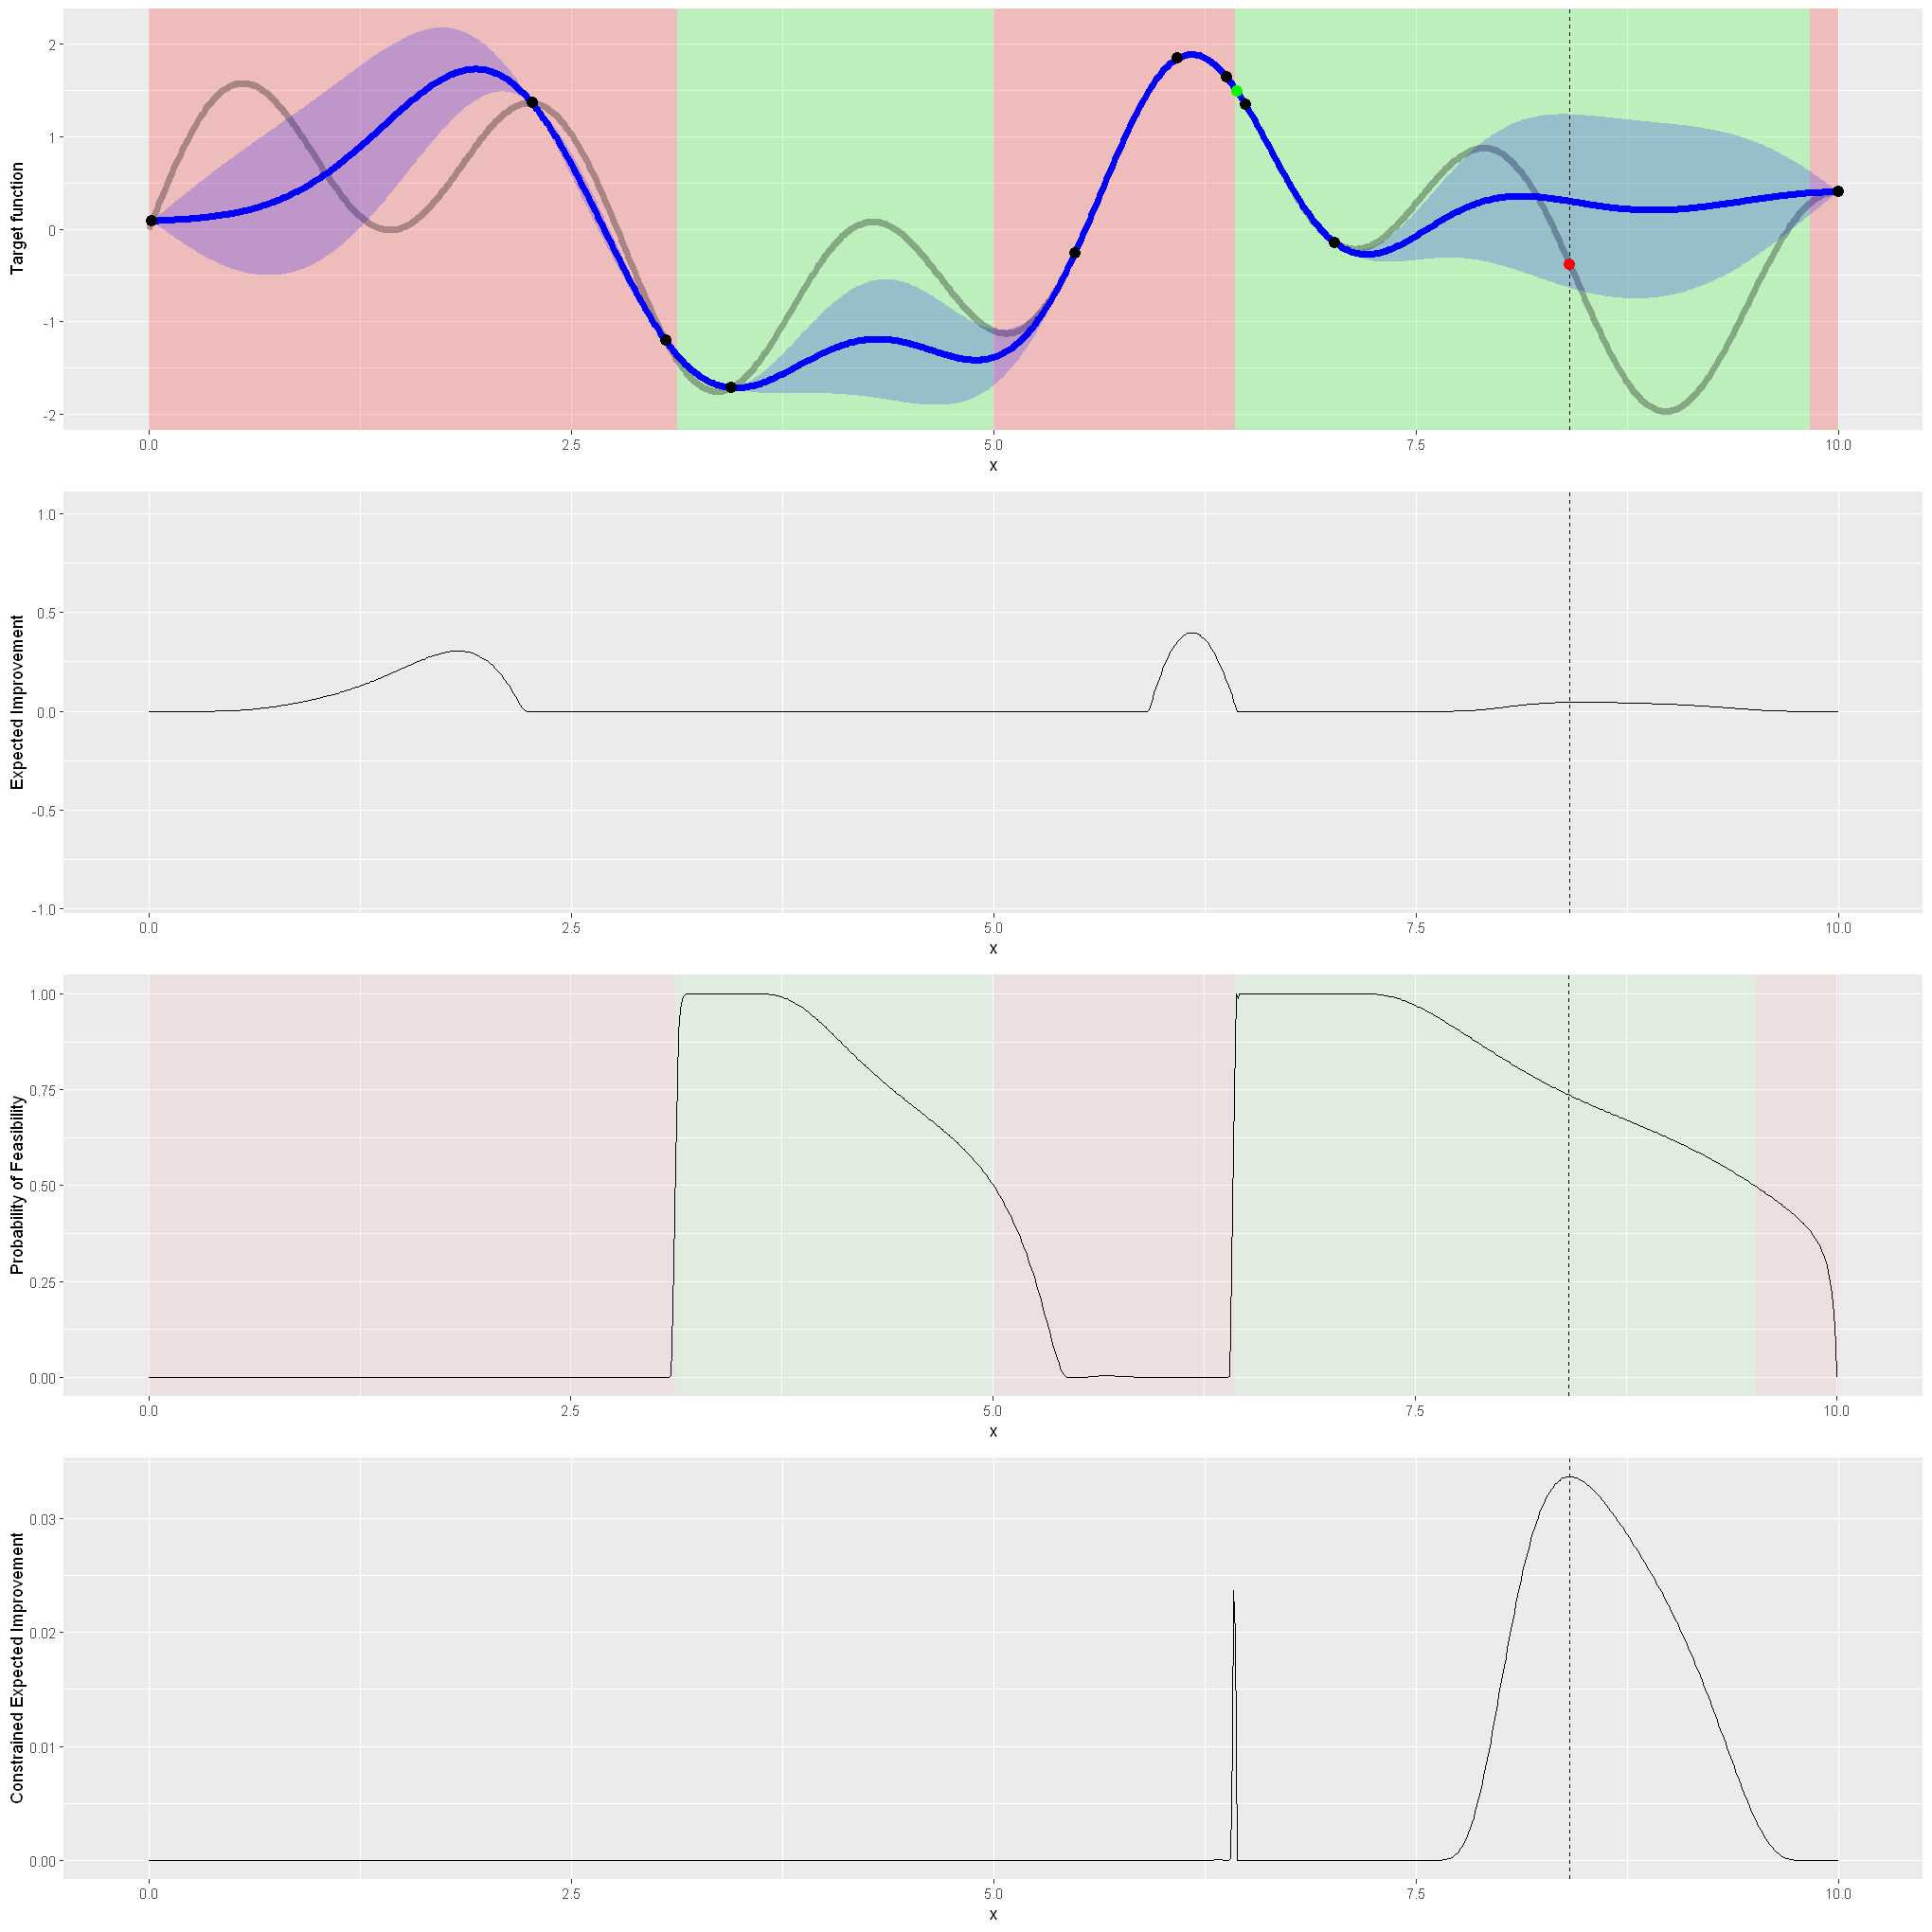

Iteration 13 


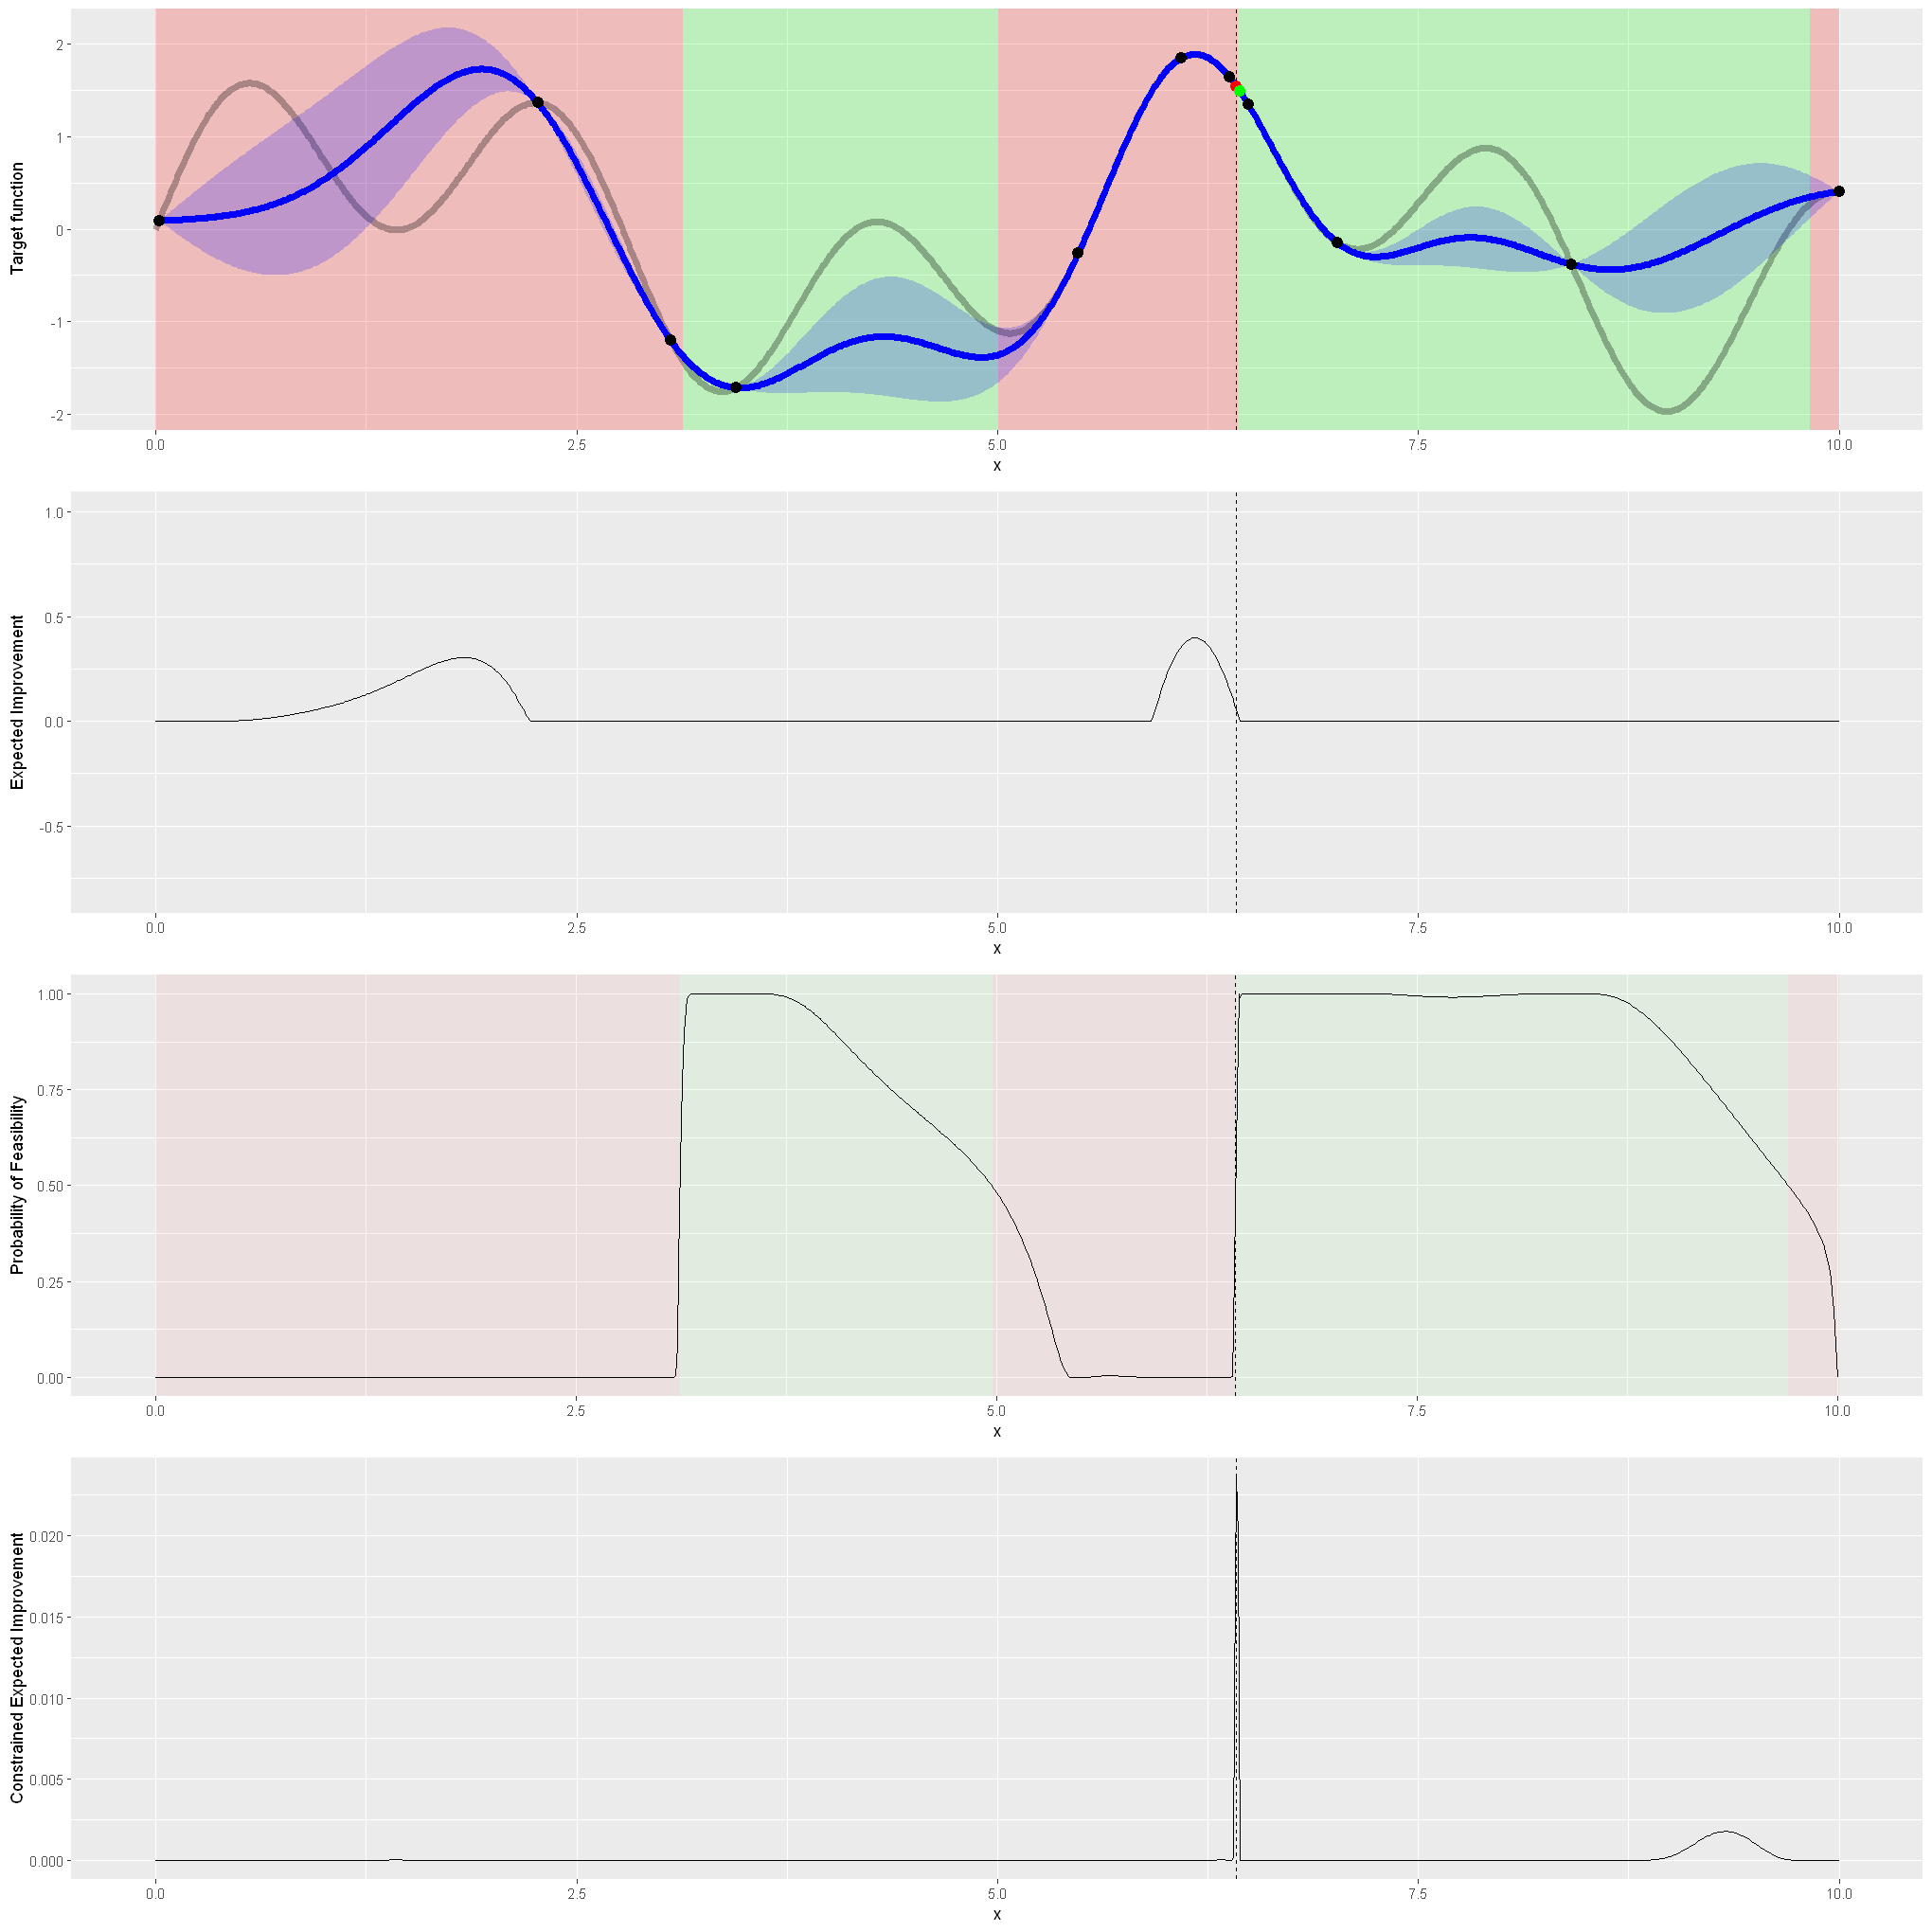

Iteration 14 


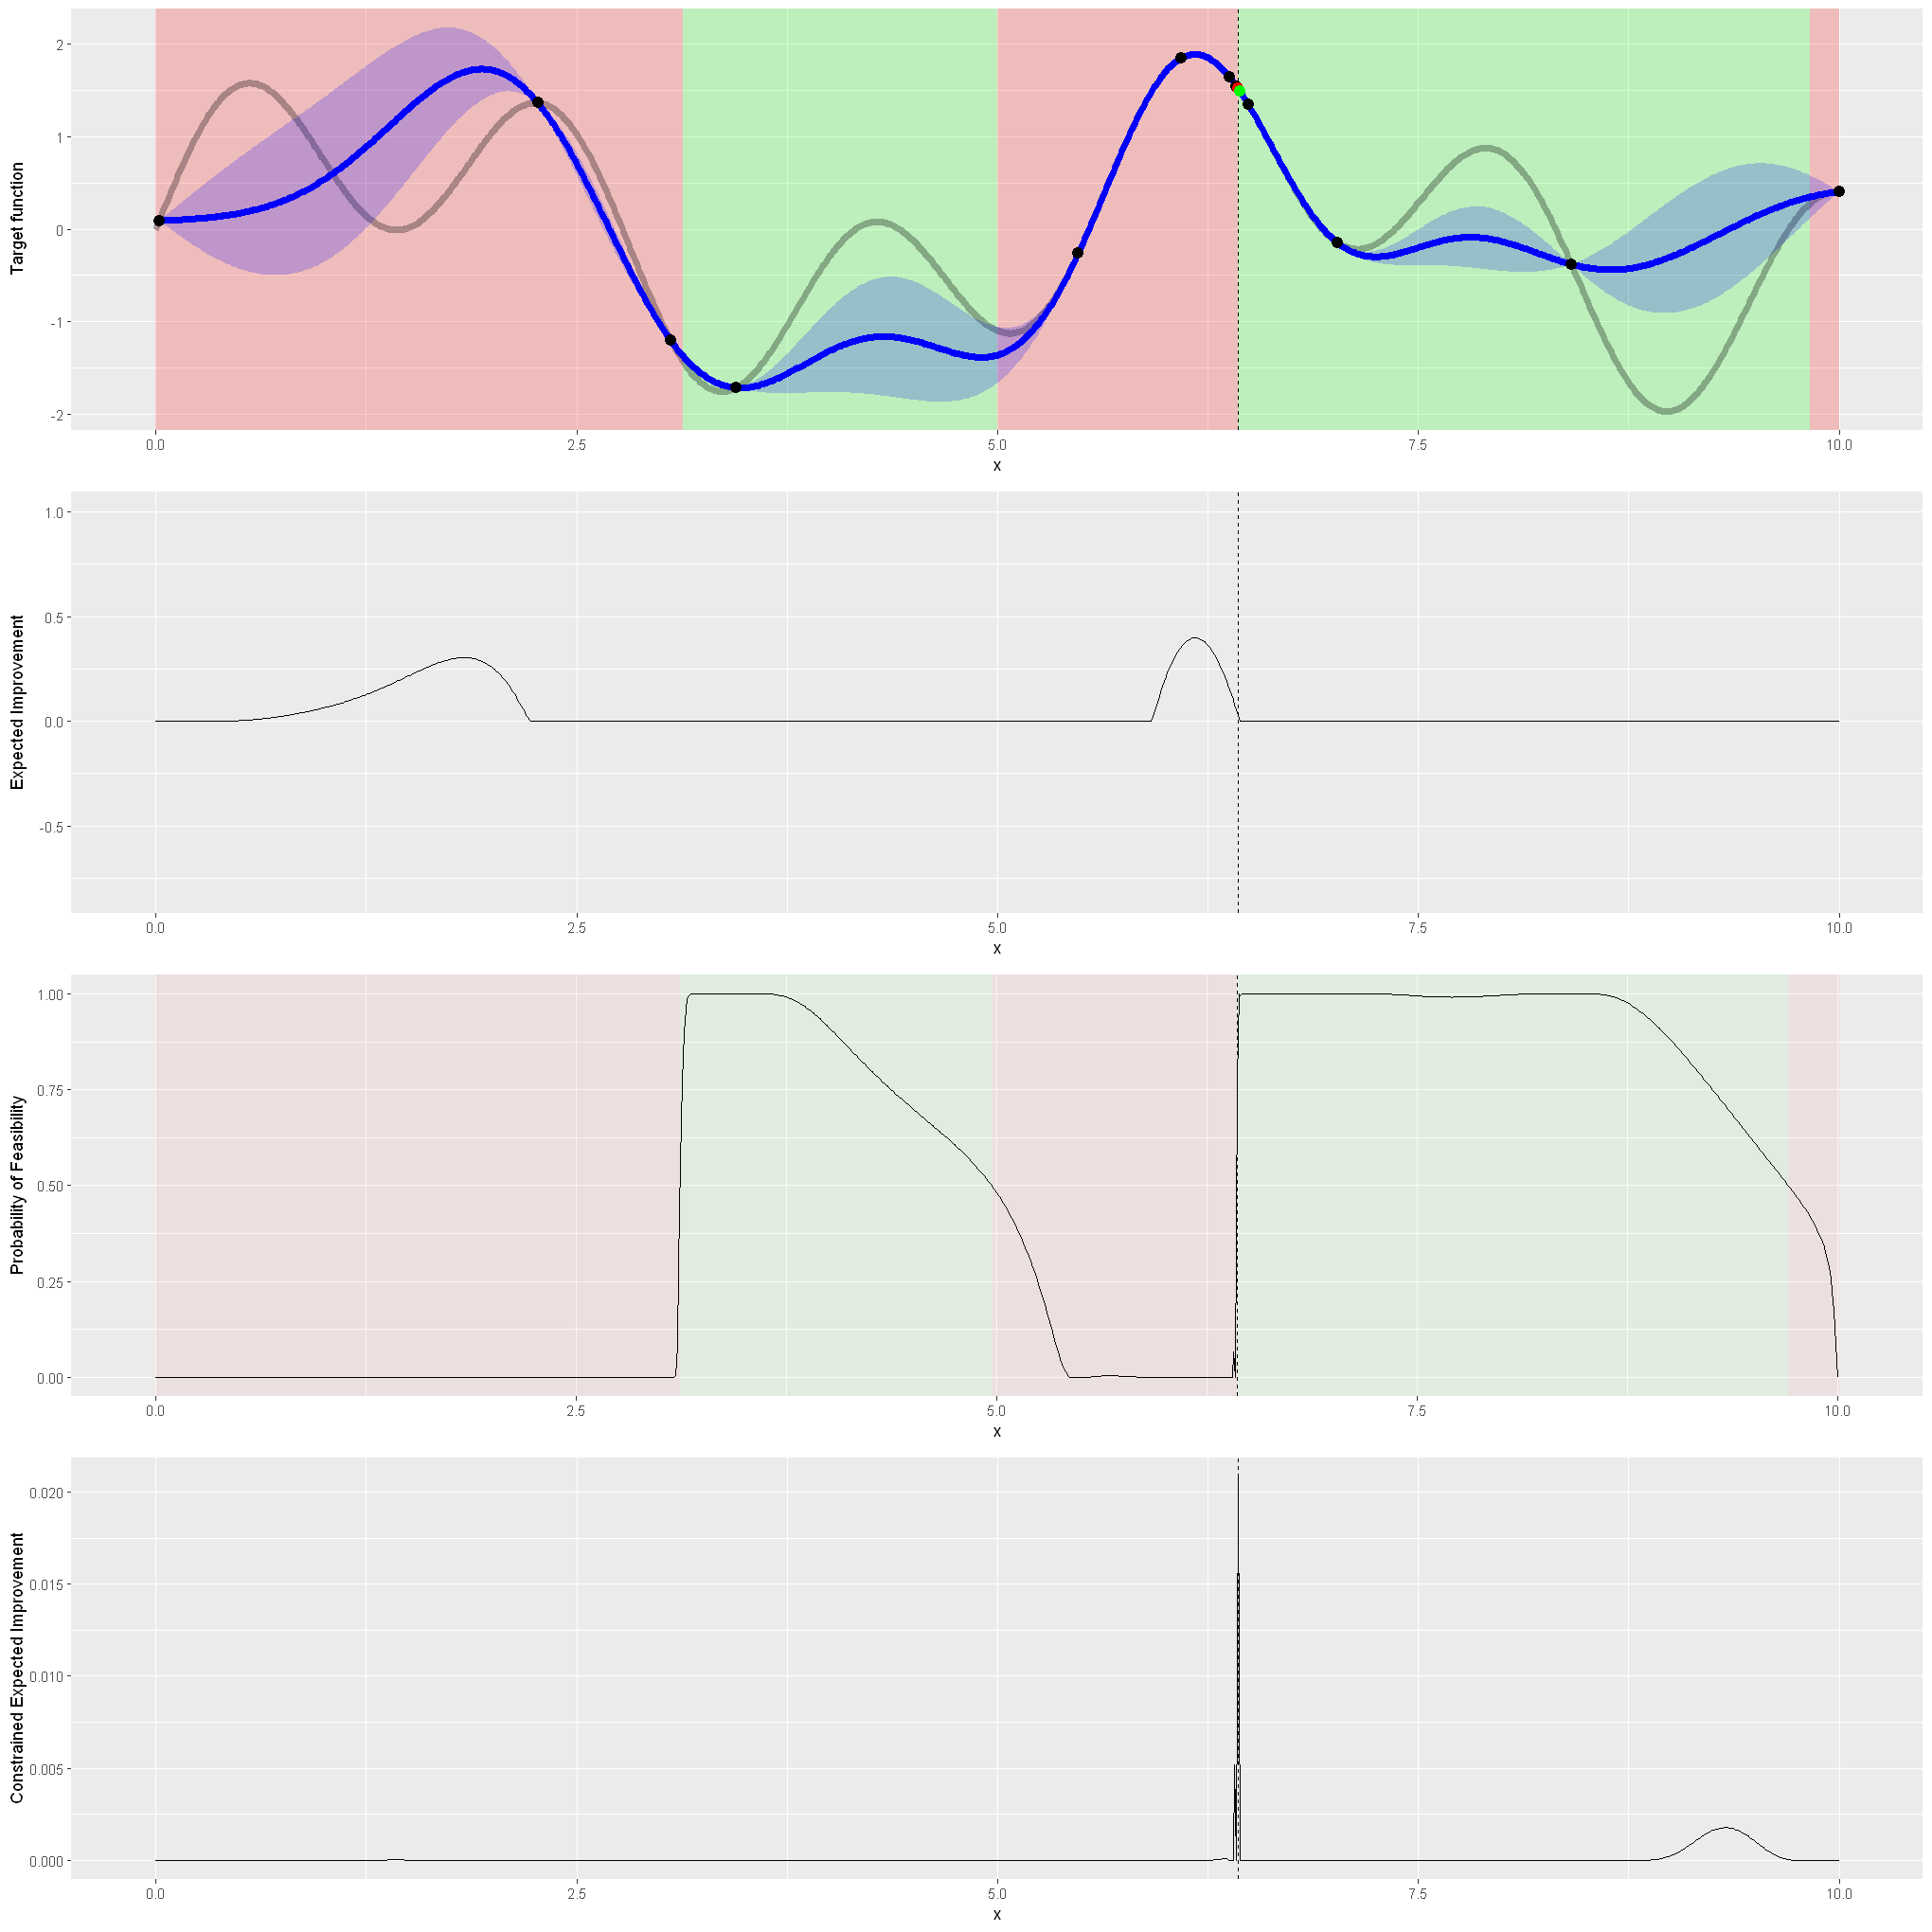

Iteration 15 


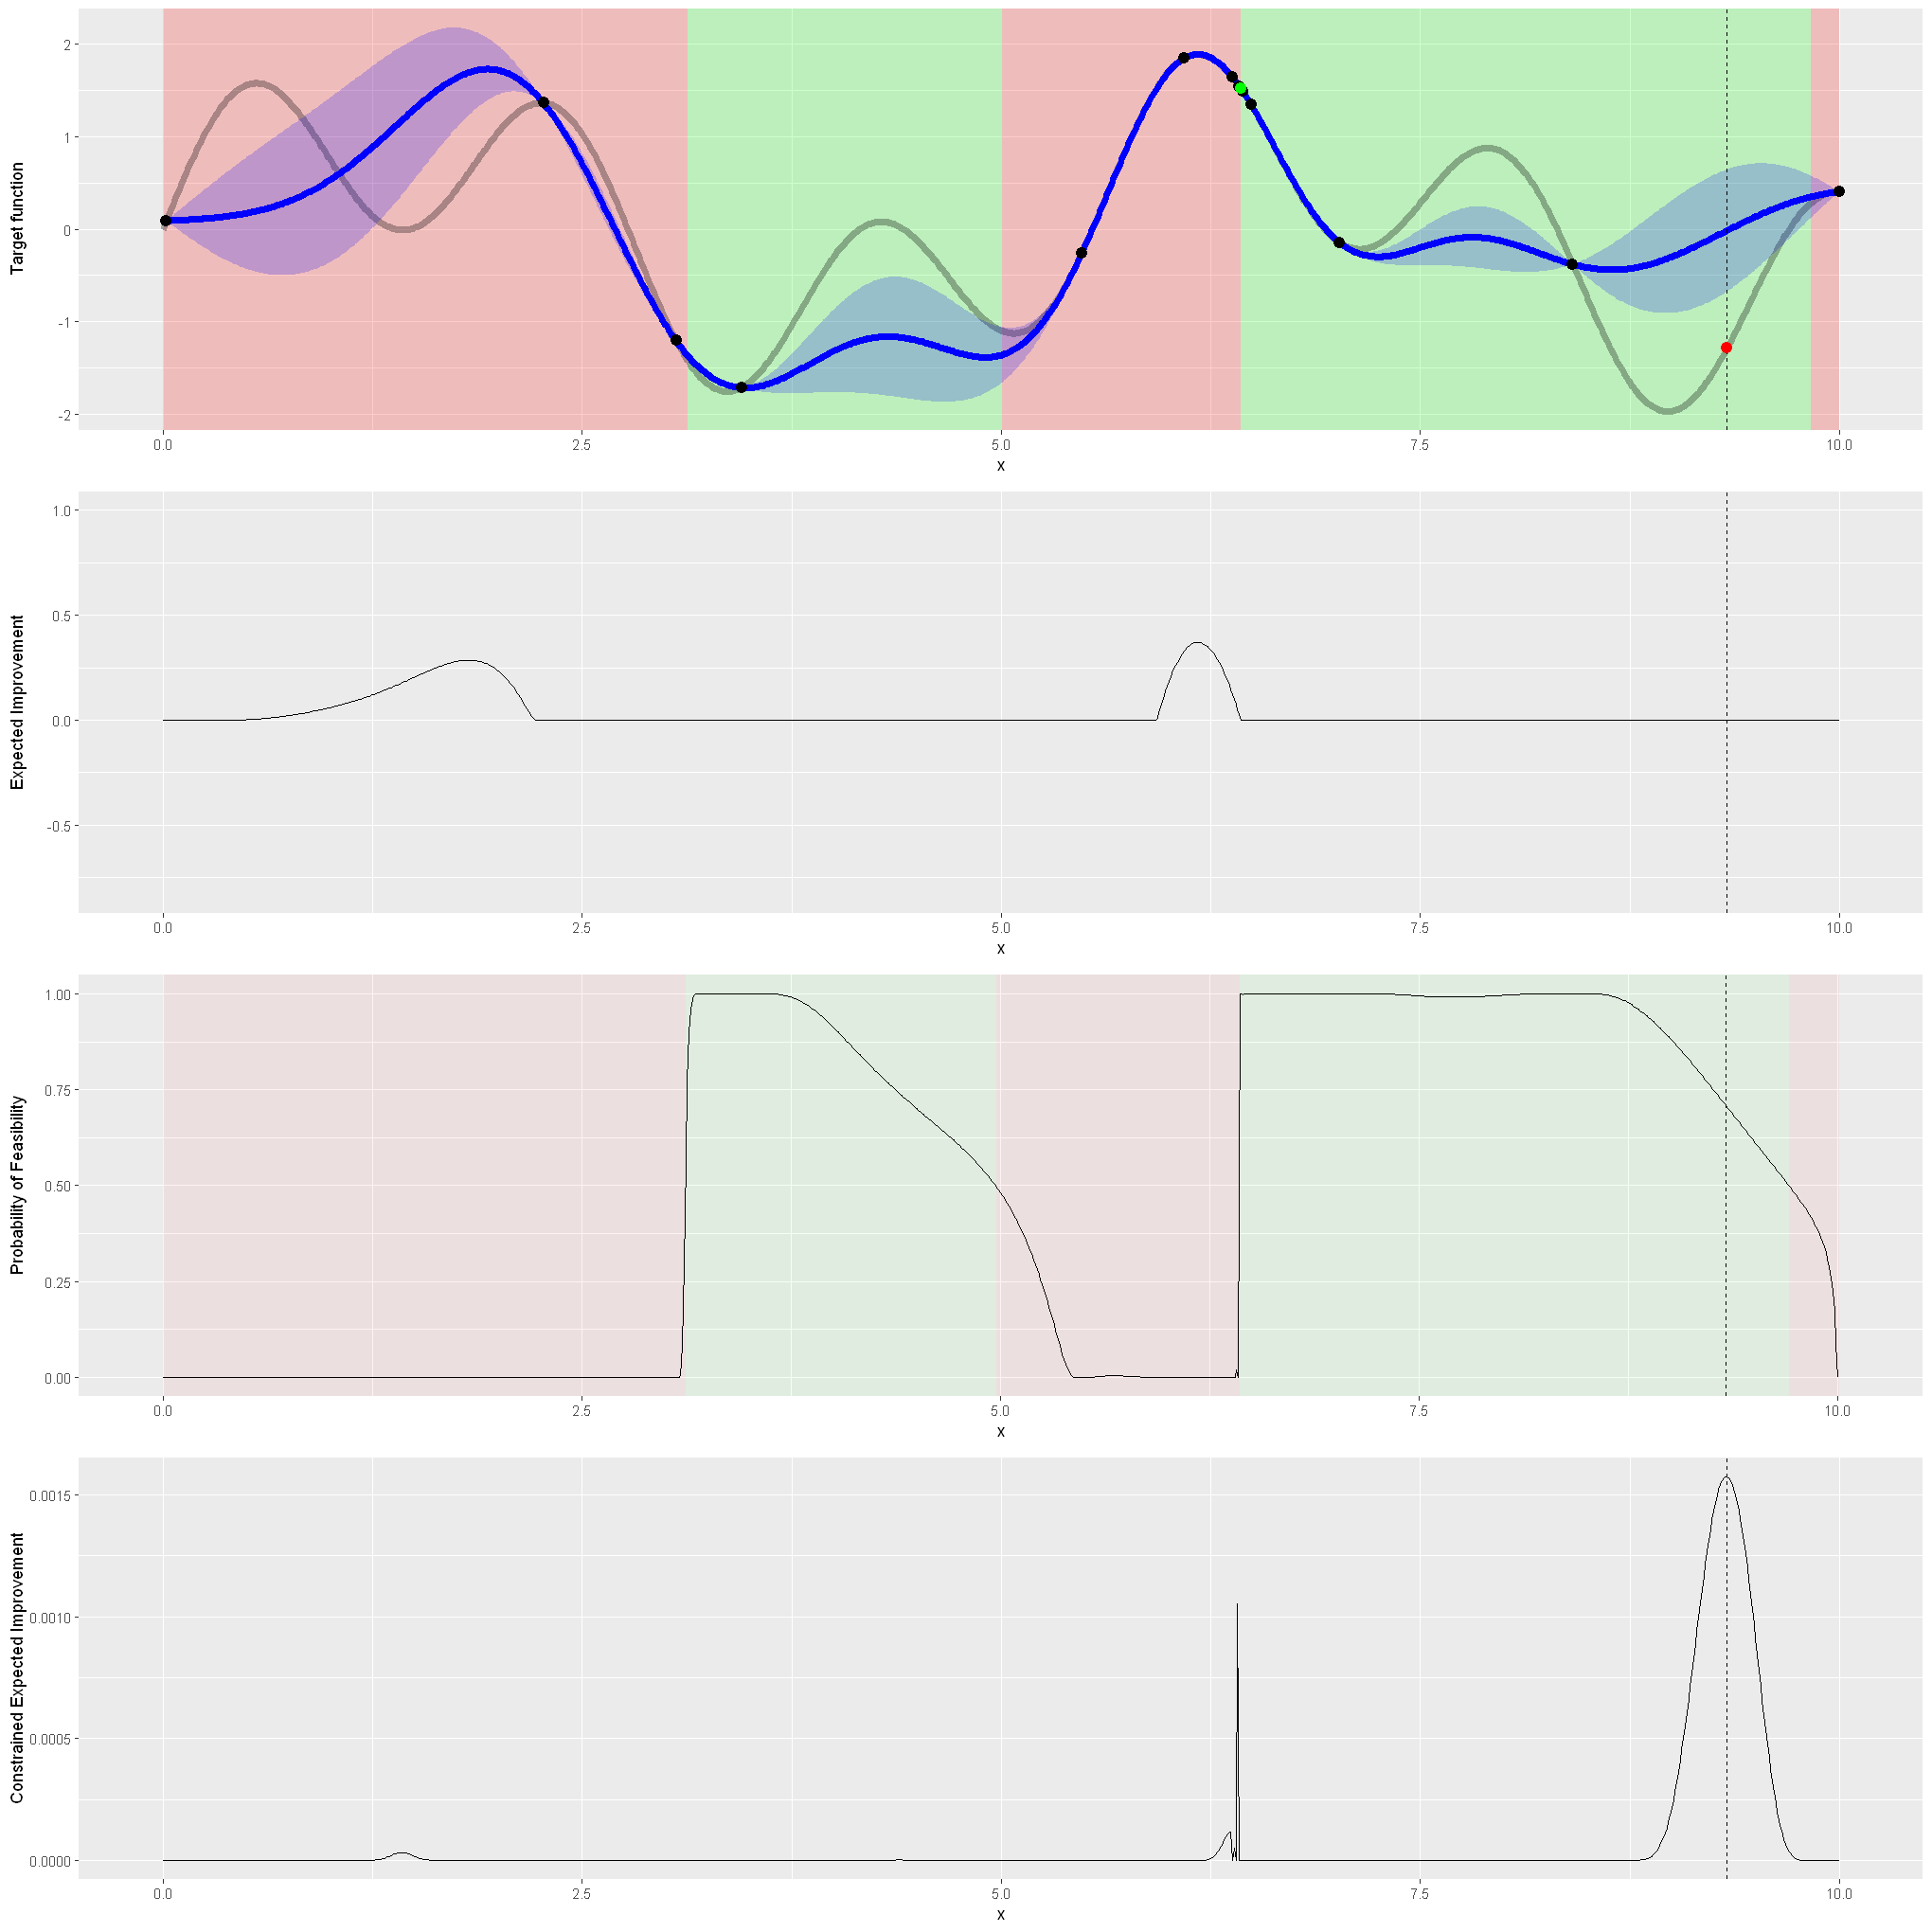

Iteration 16 


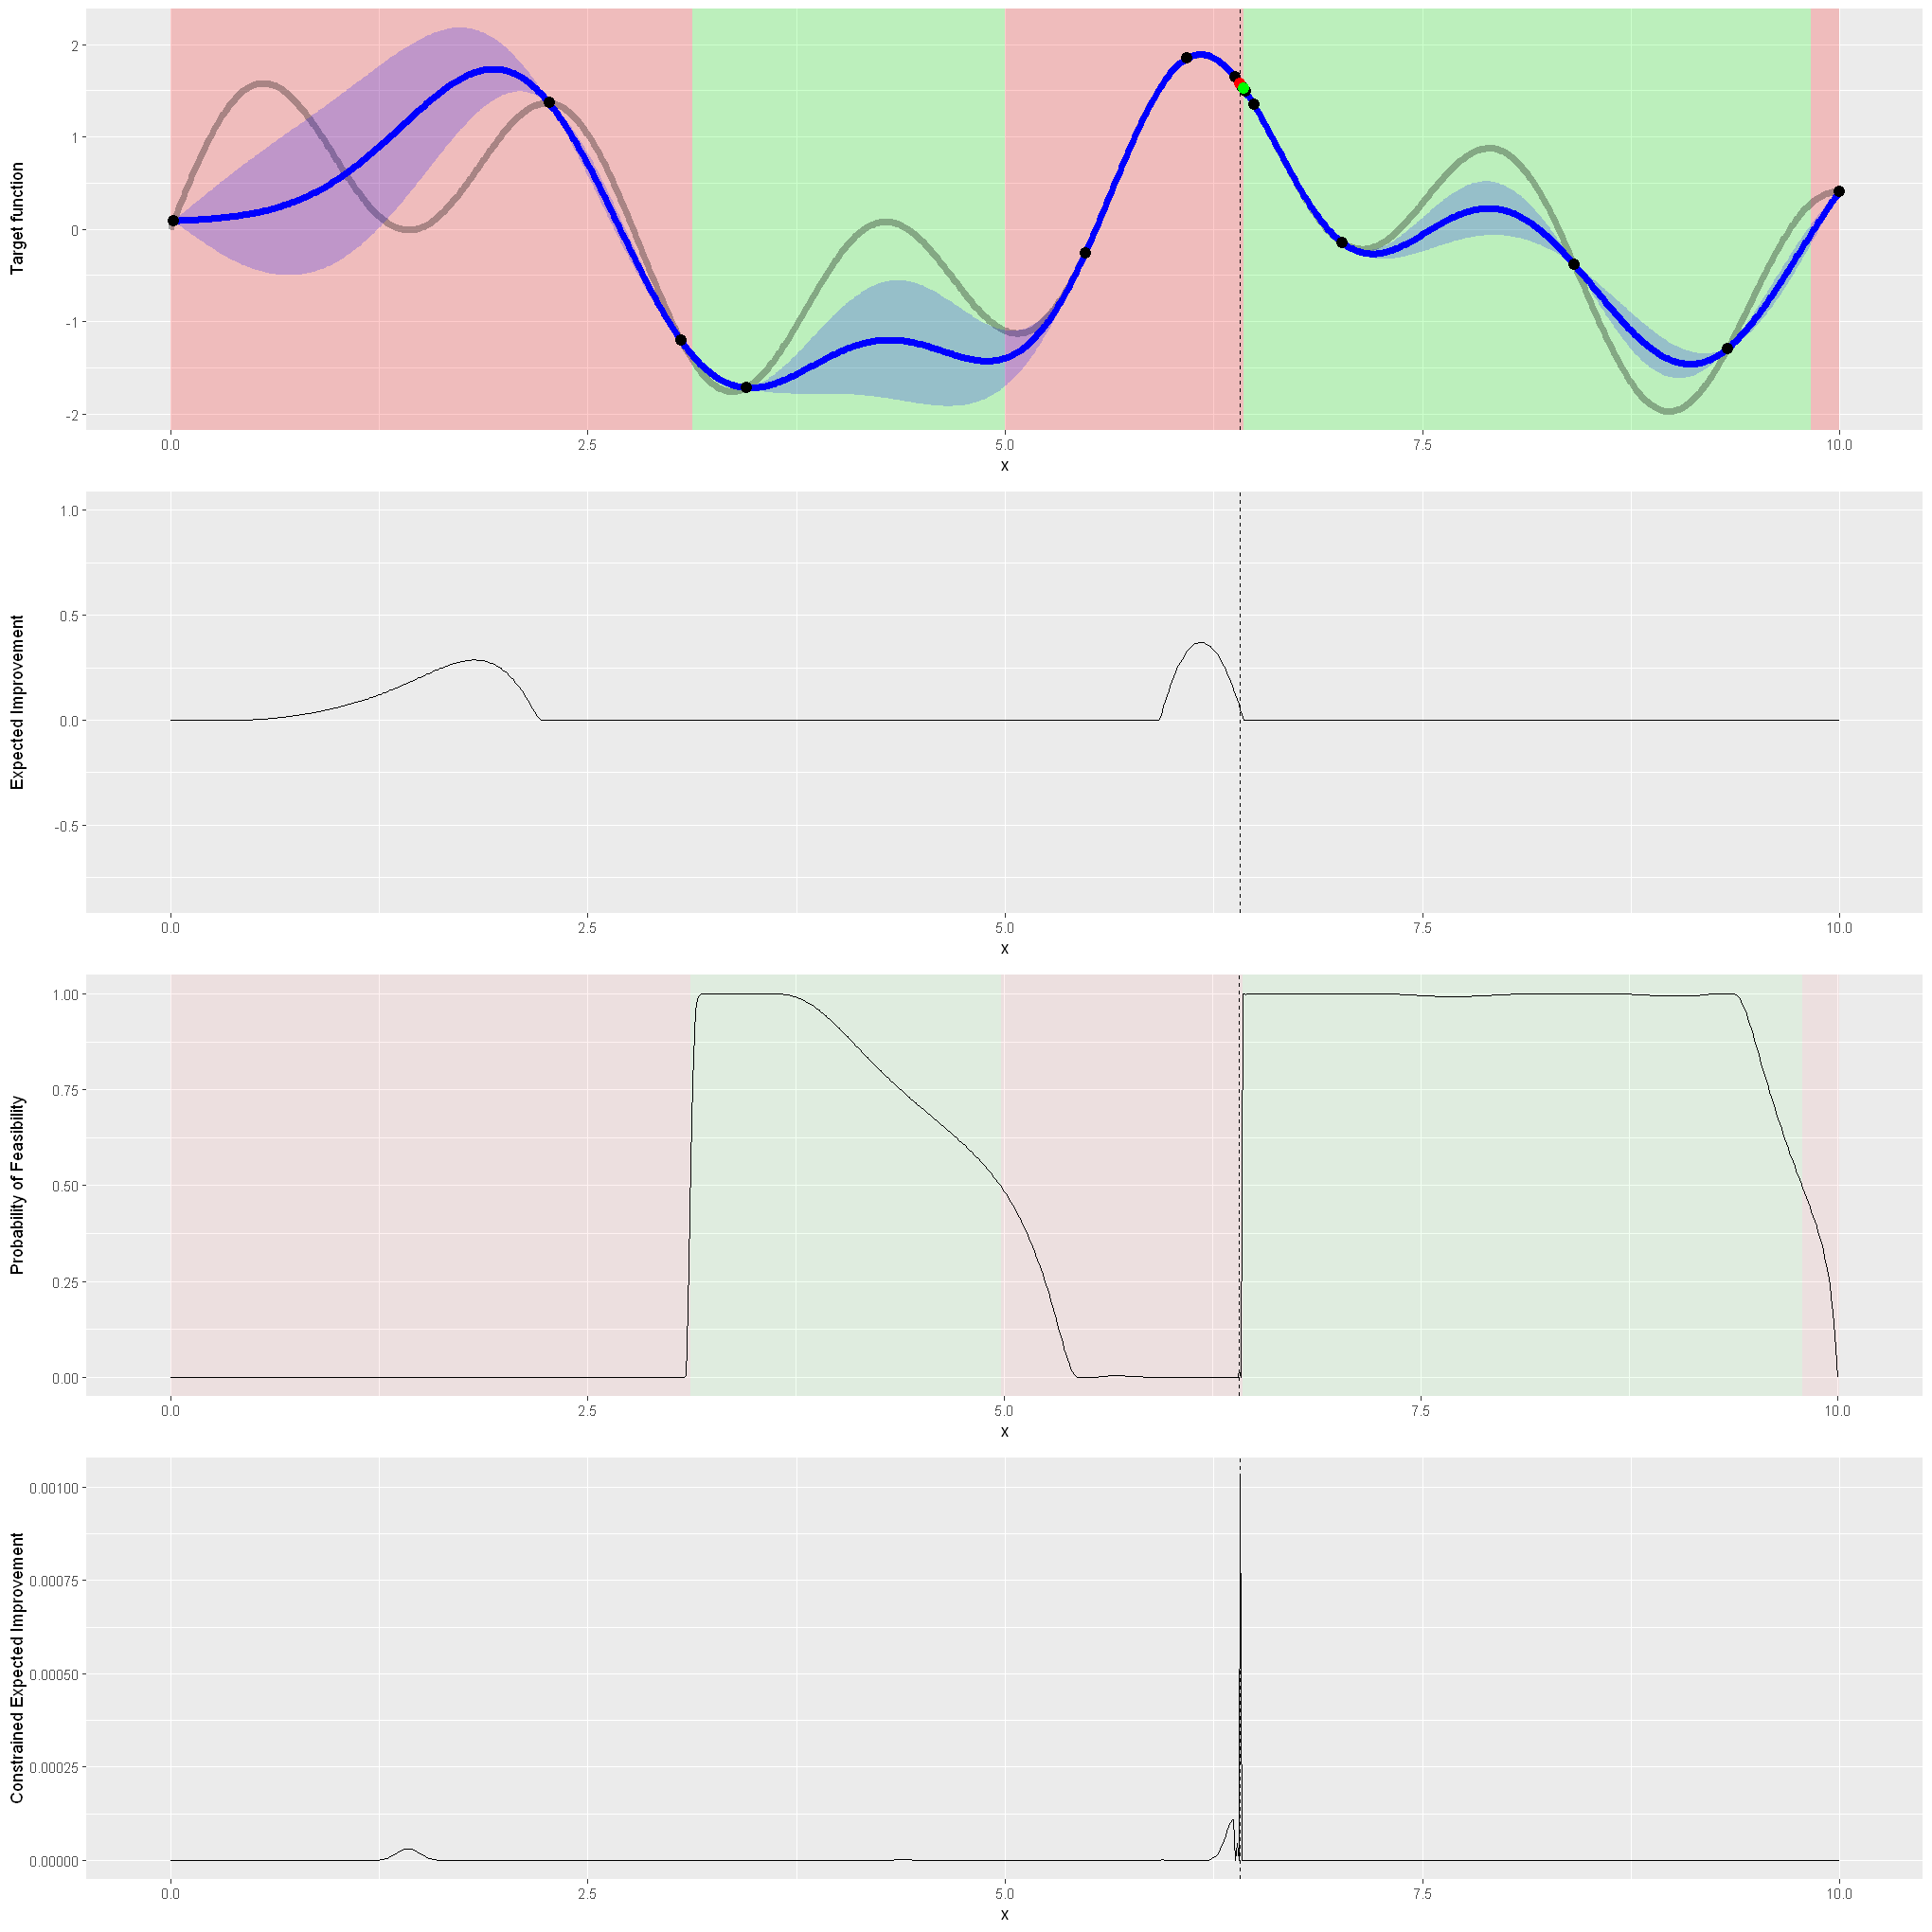

Iteration 17 


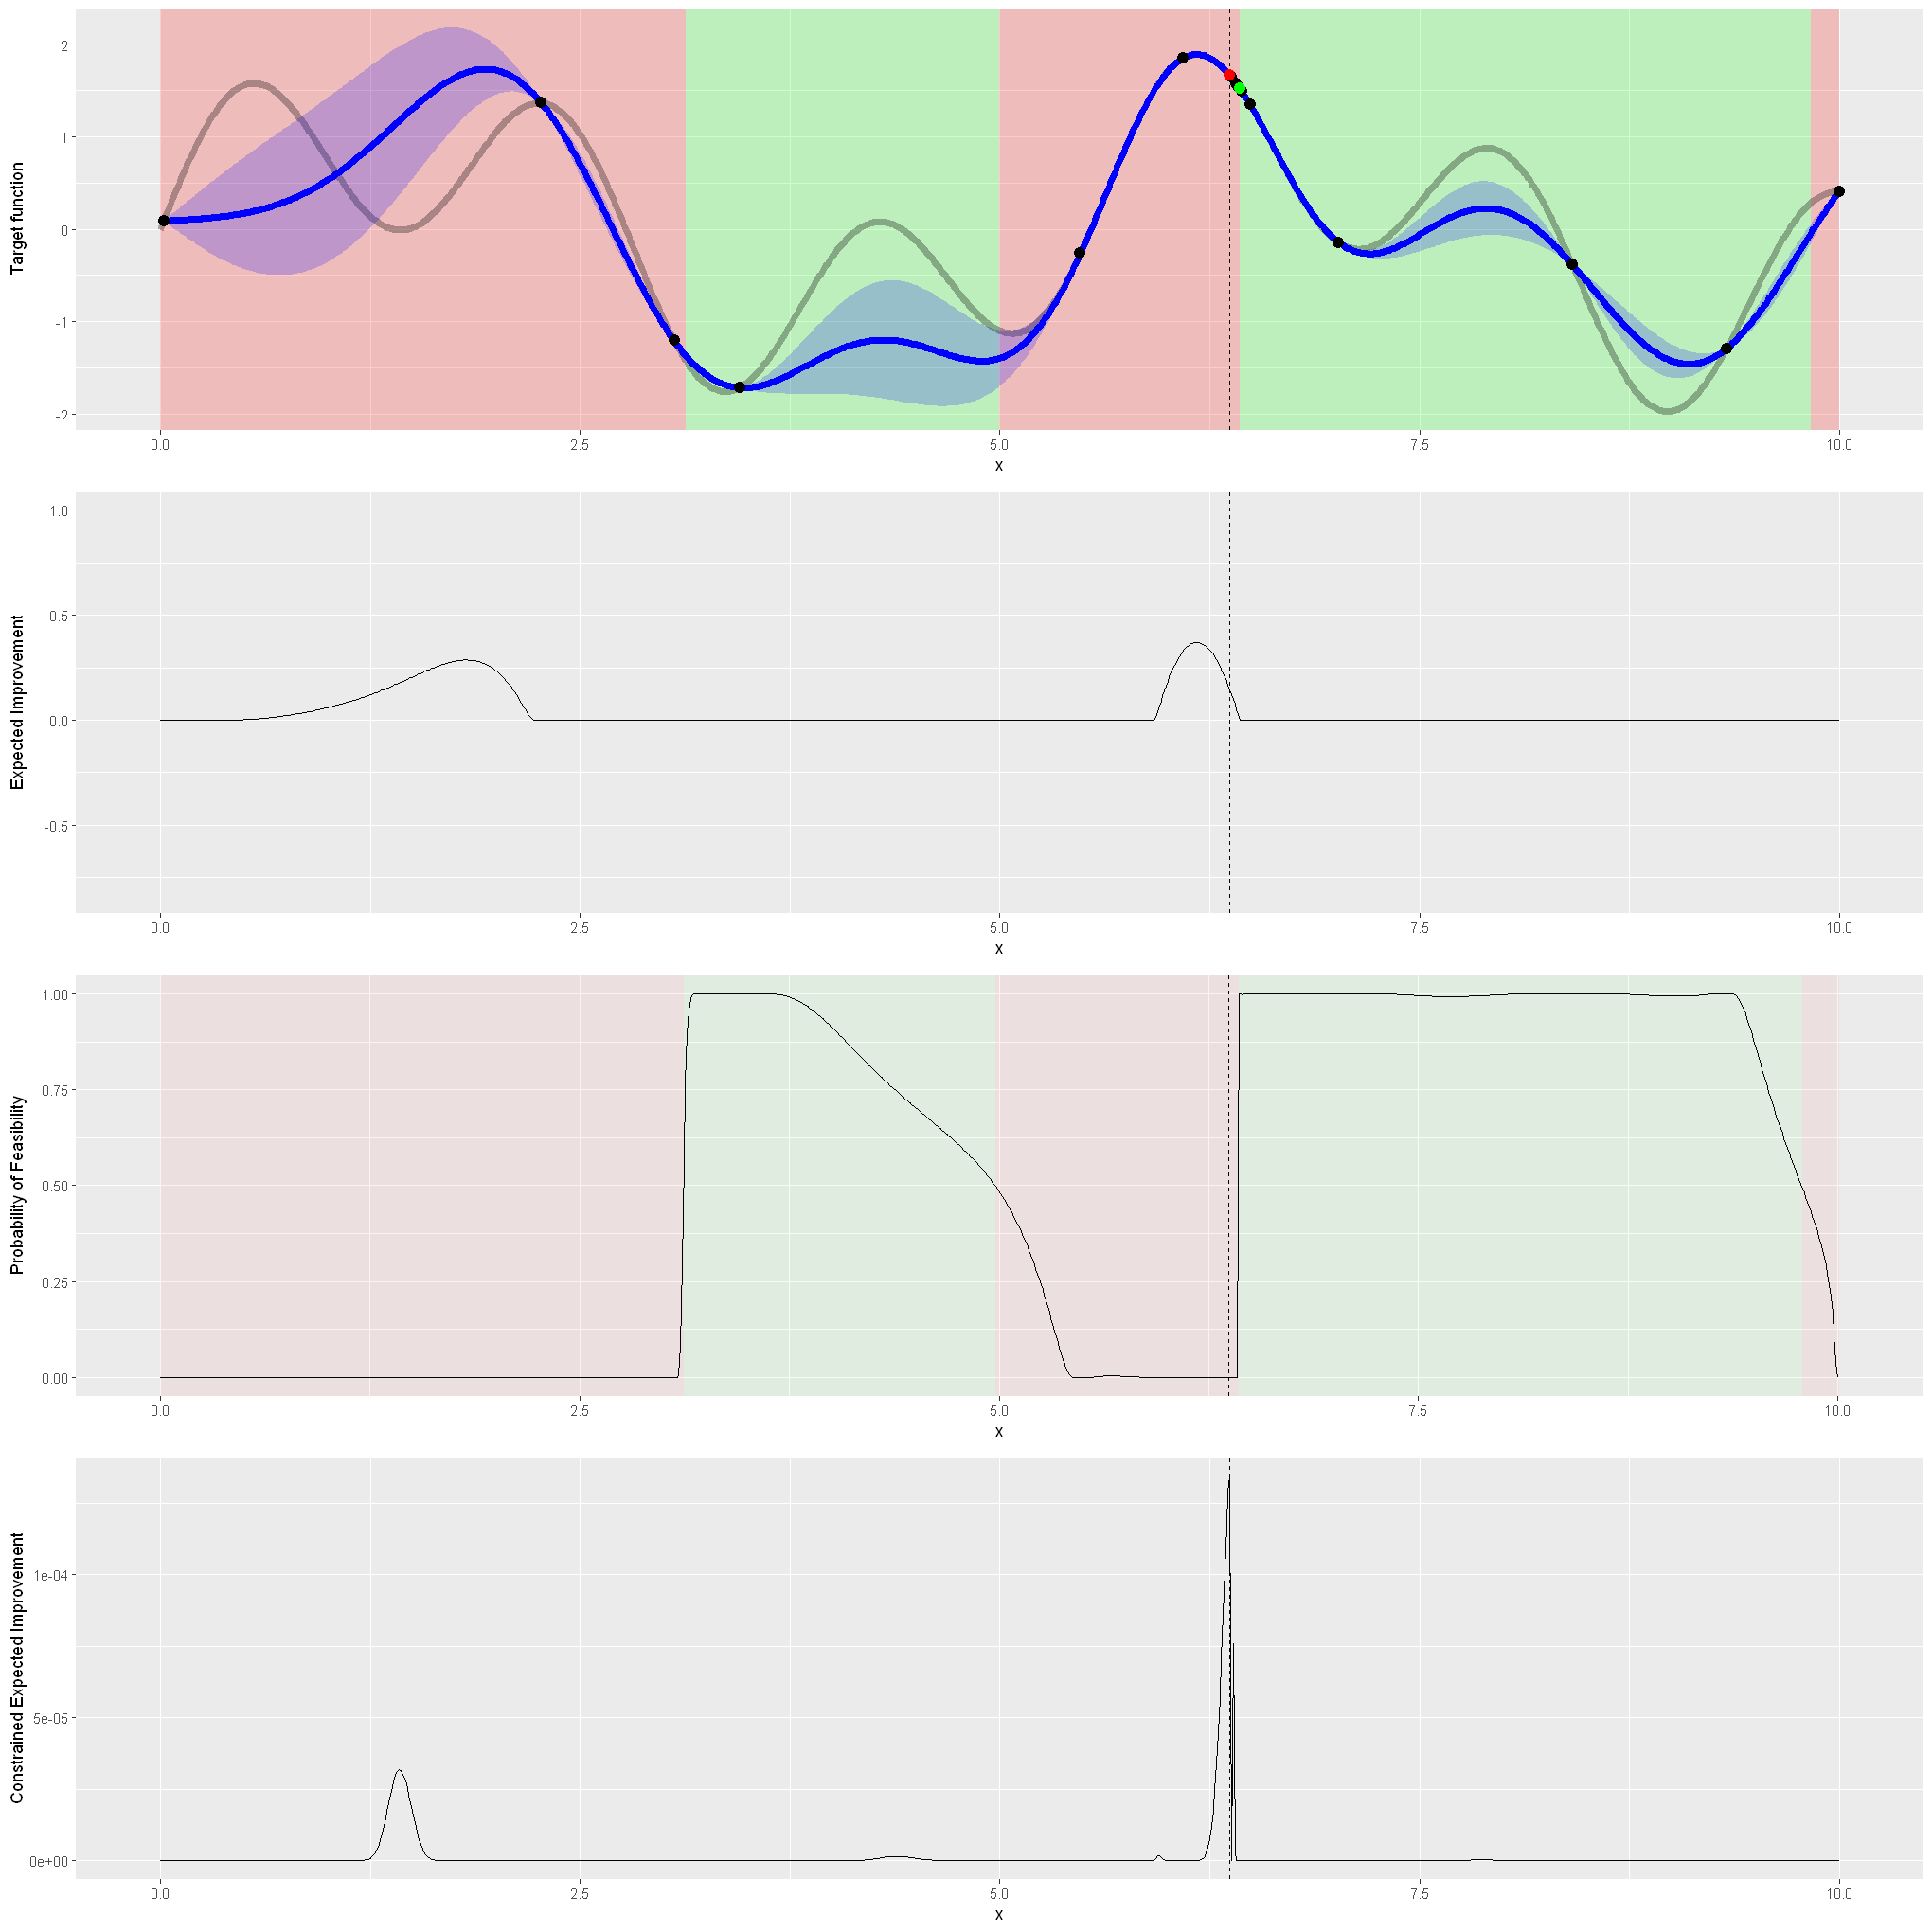

Iteration 18 


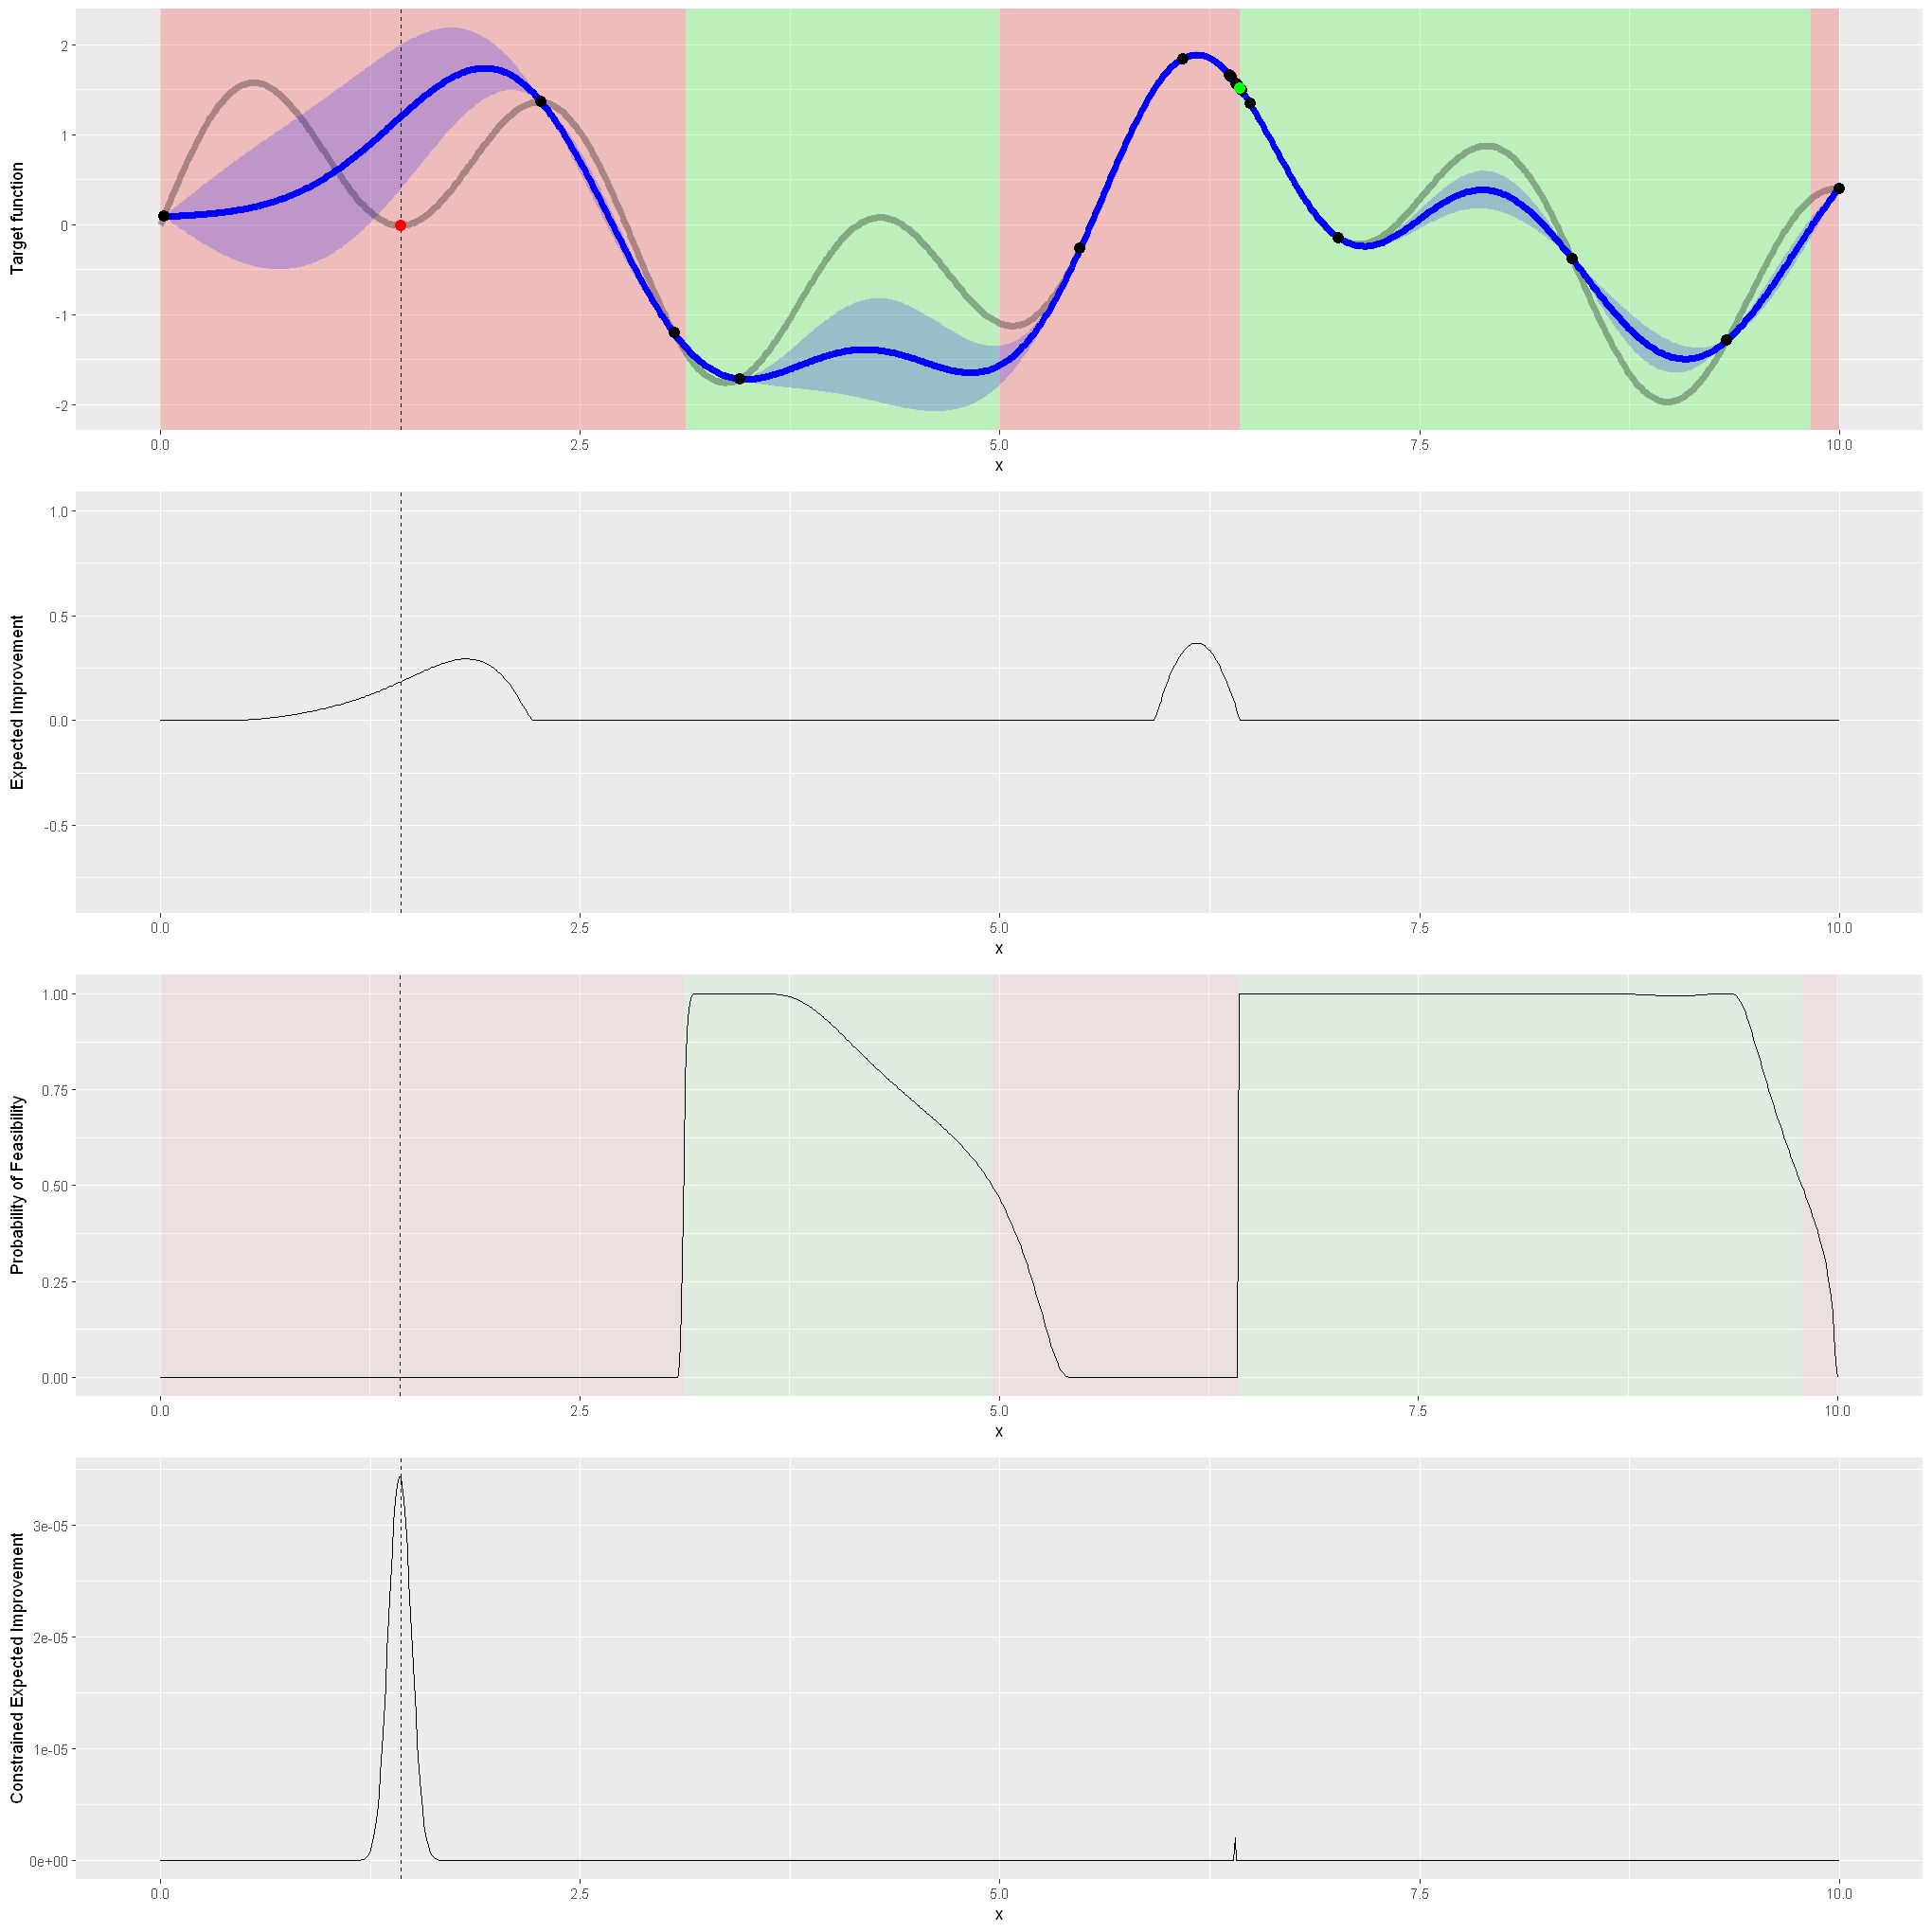

Iteration 19 


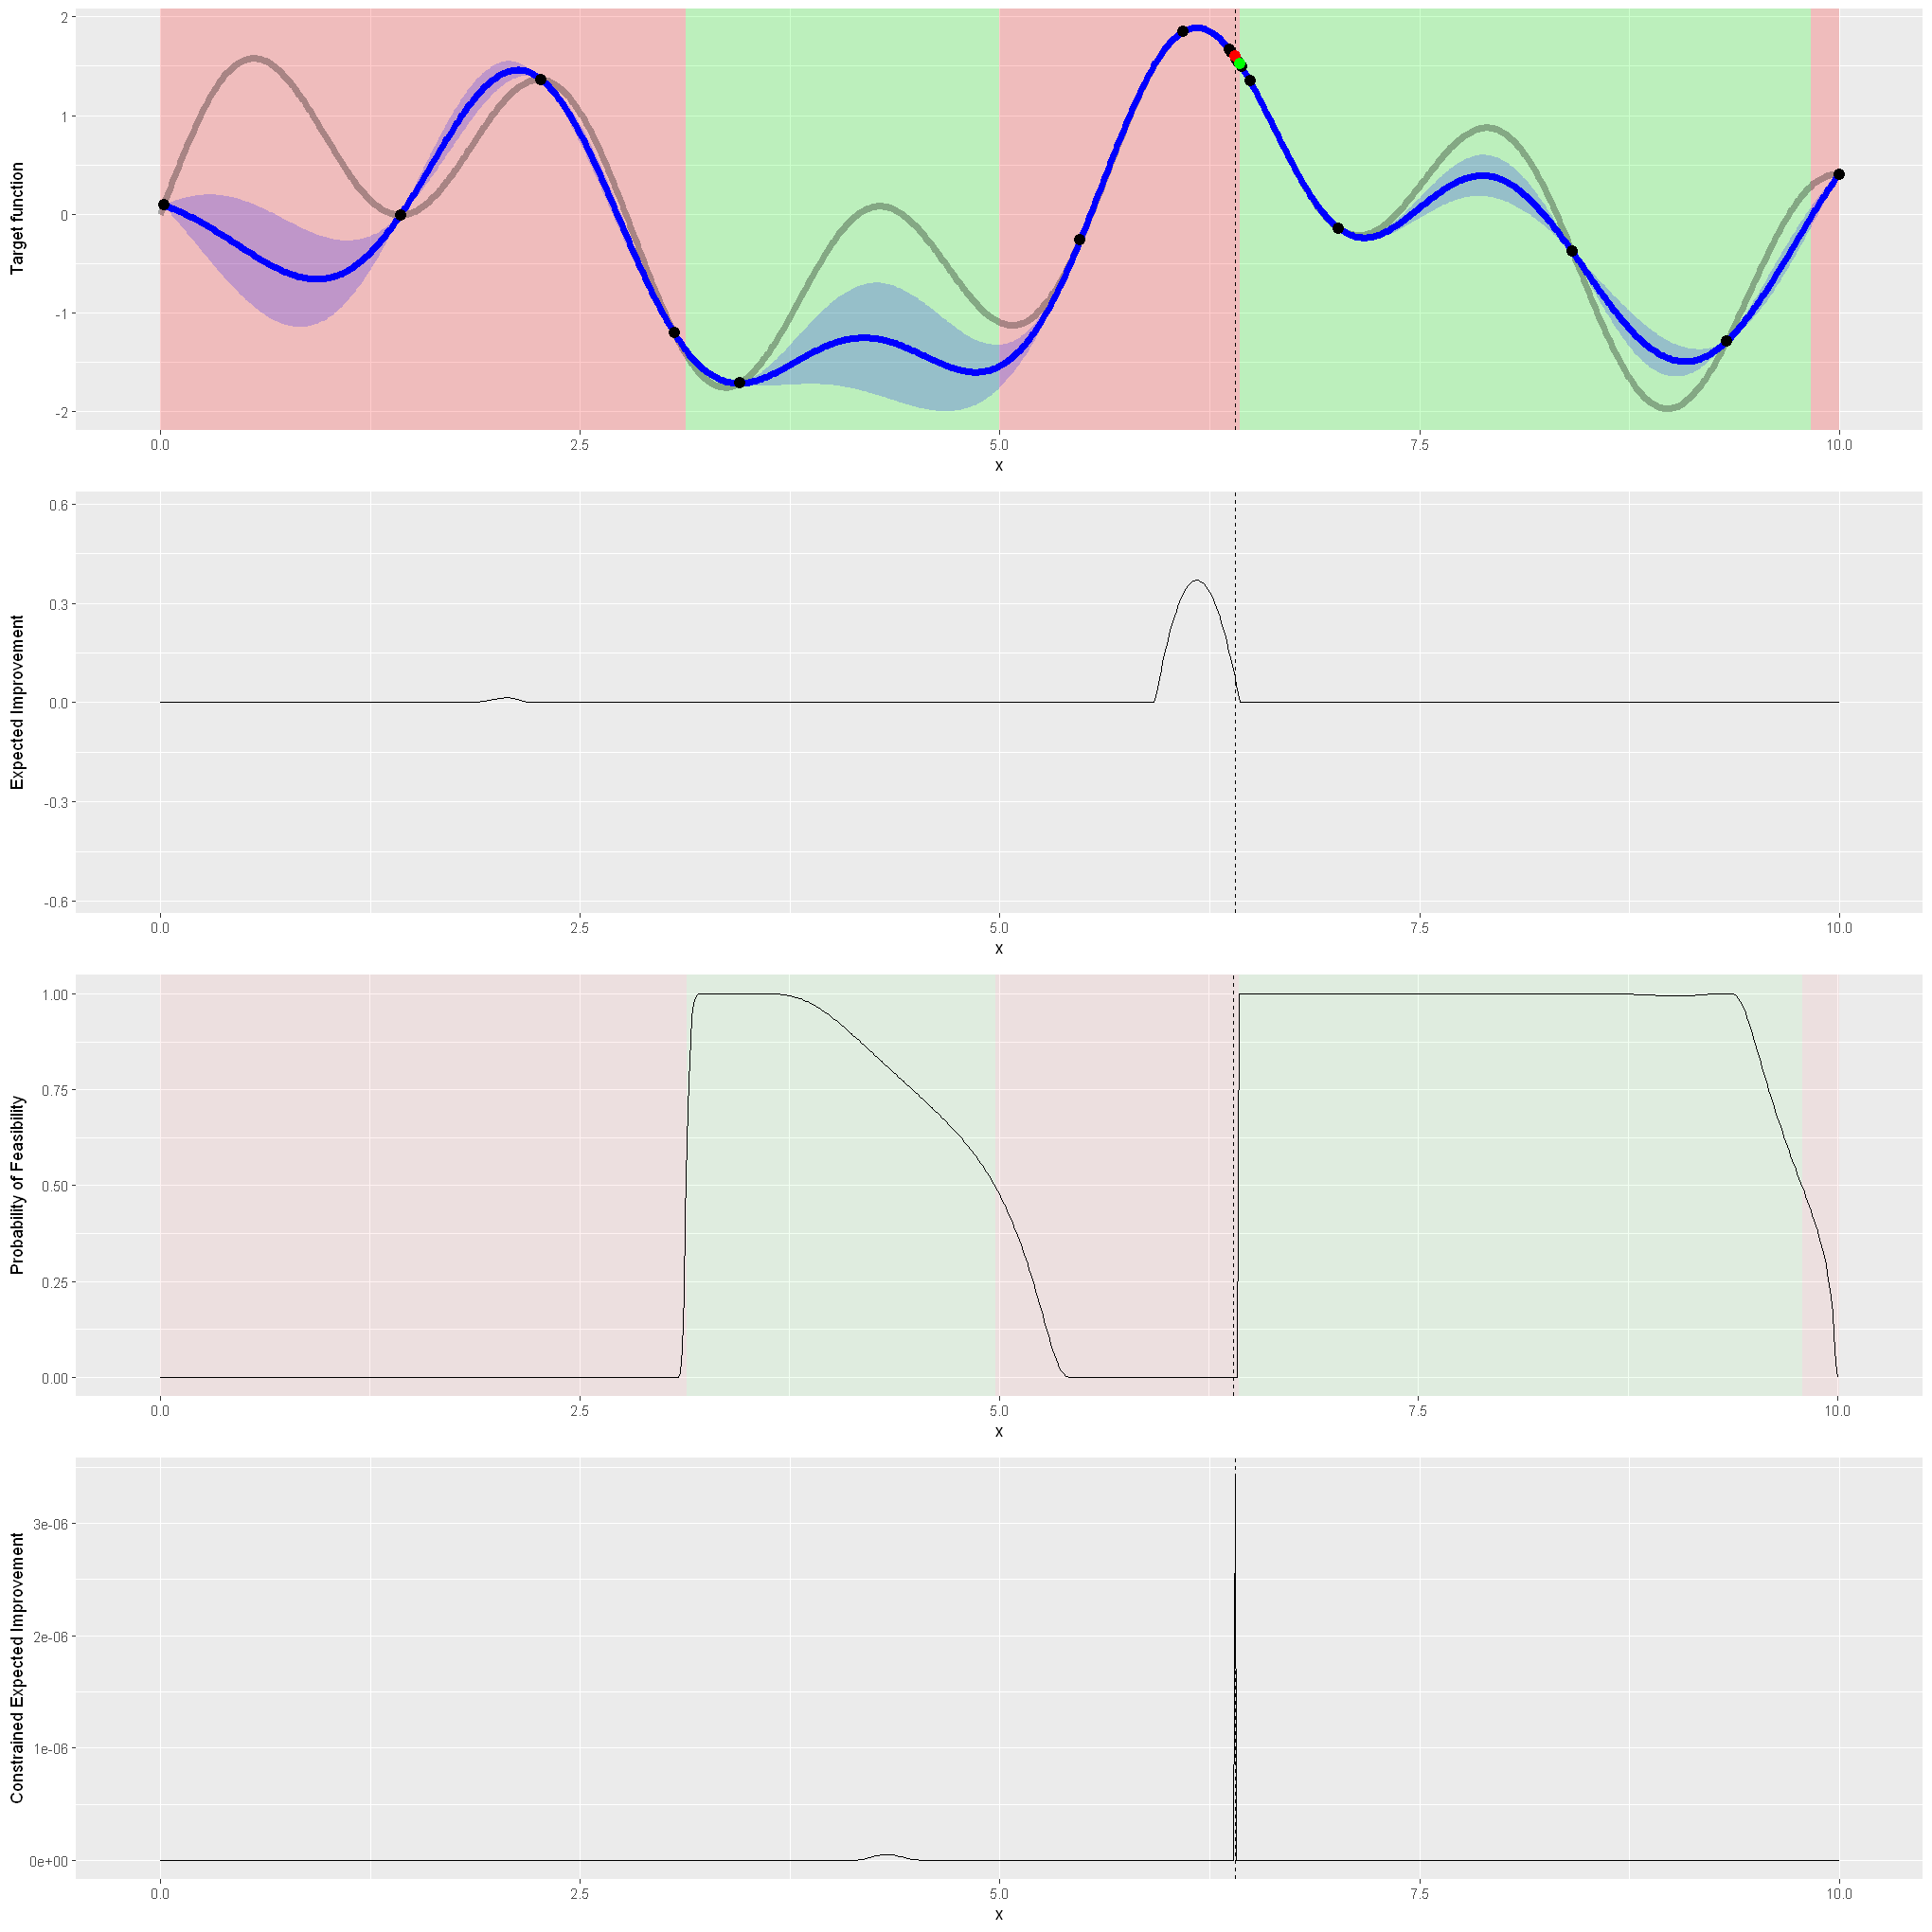

Iteration 20 


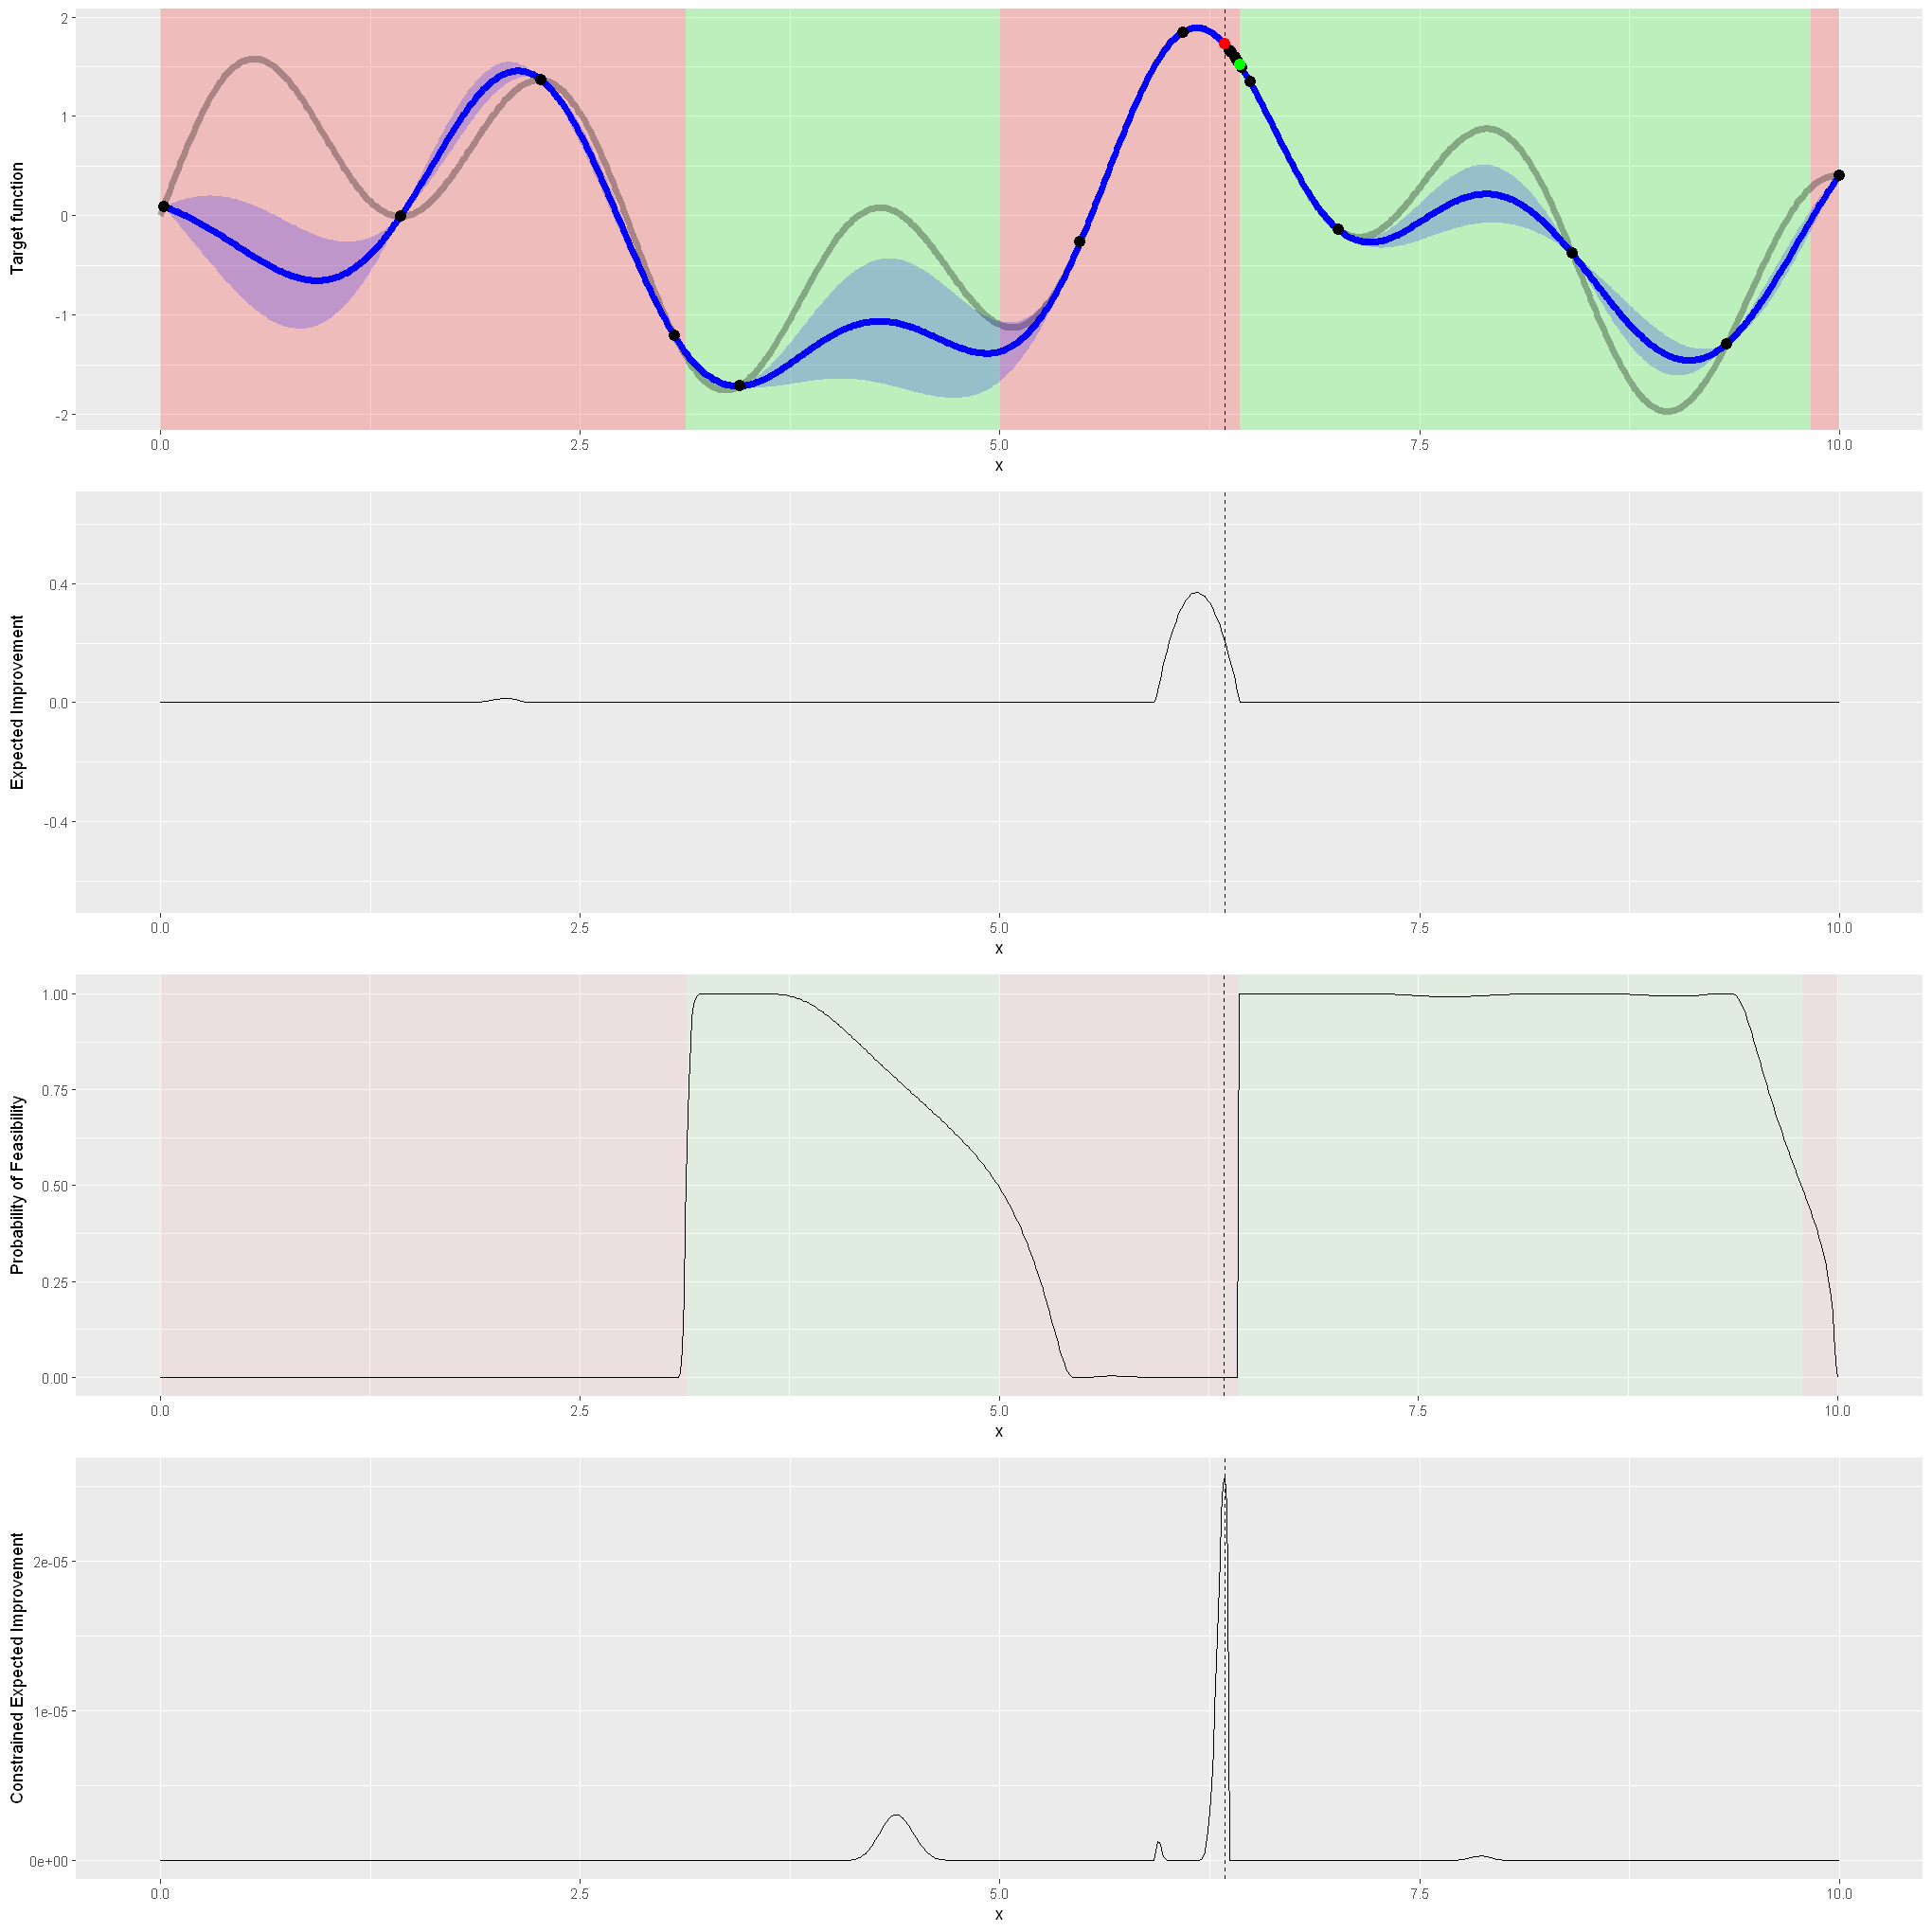

Iteration 21 


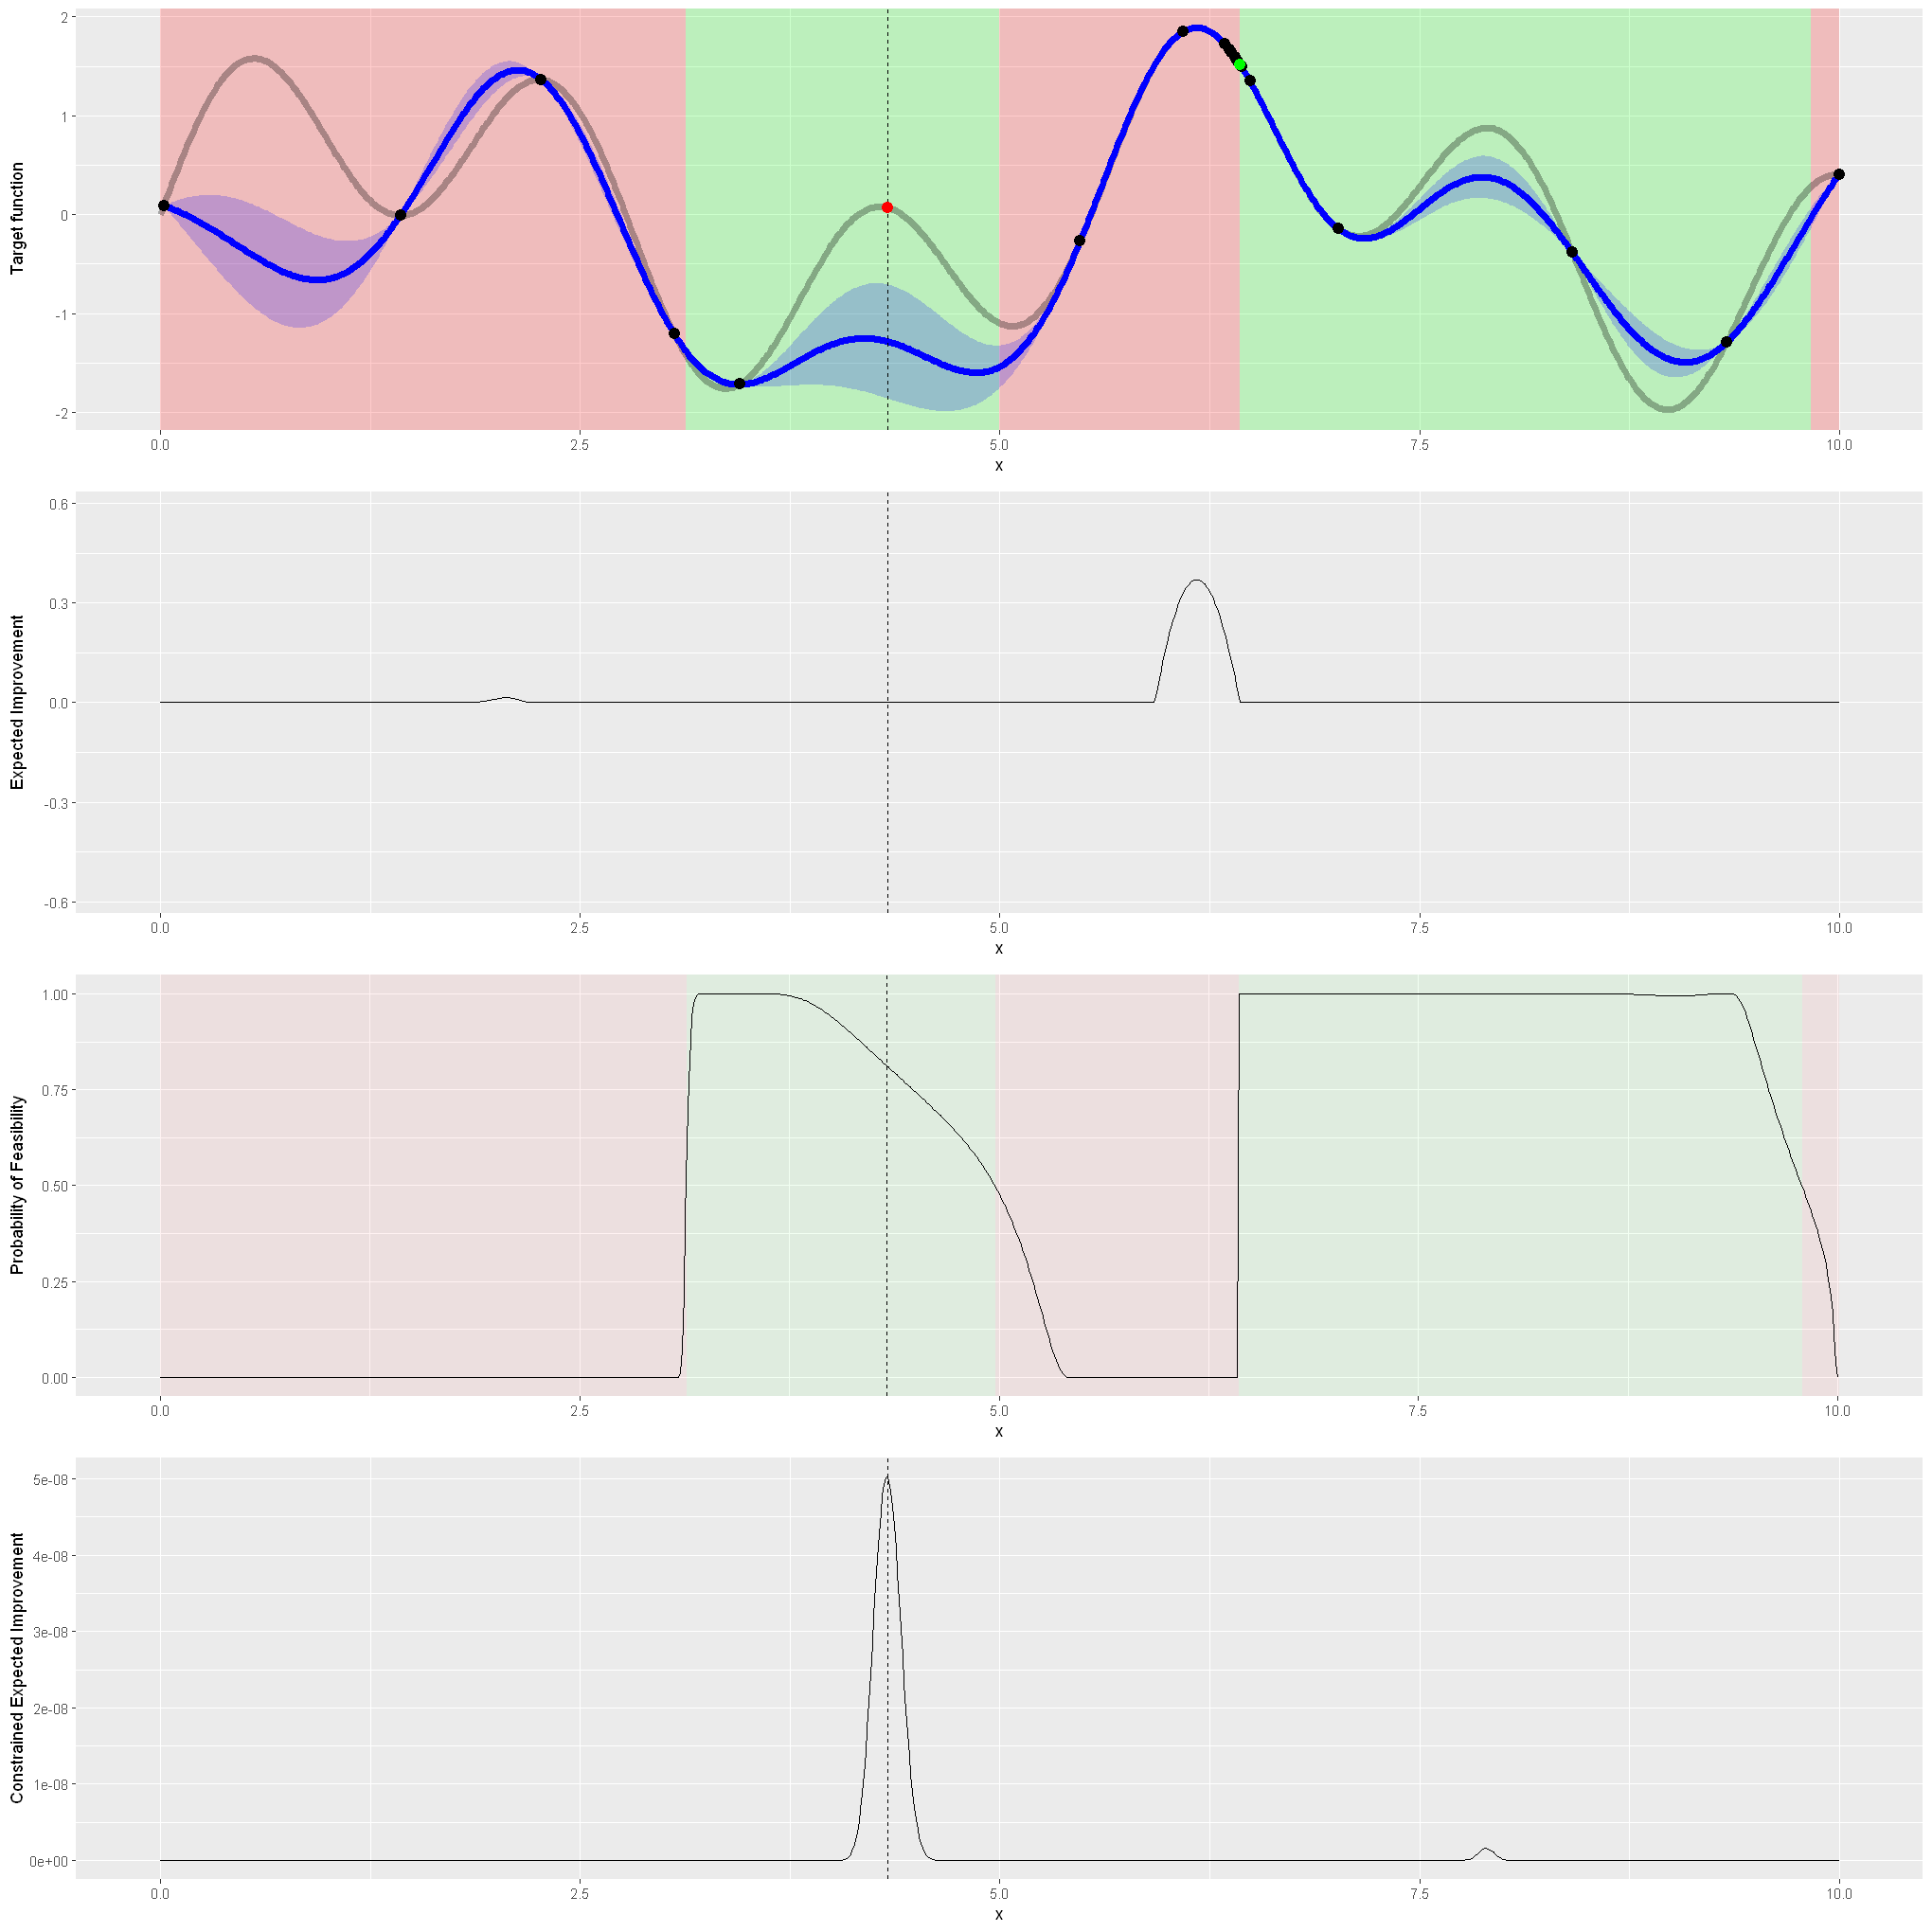

Iteration 22 


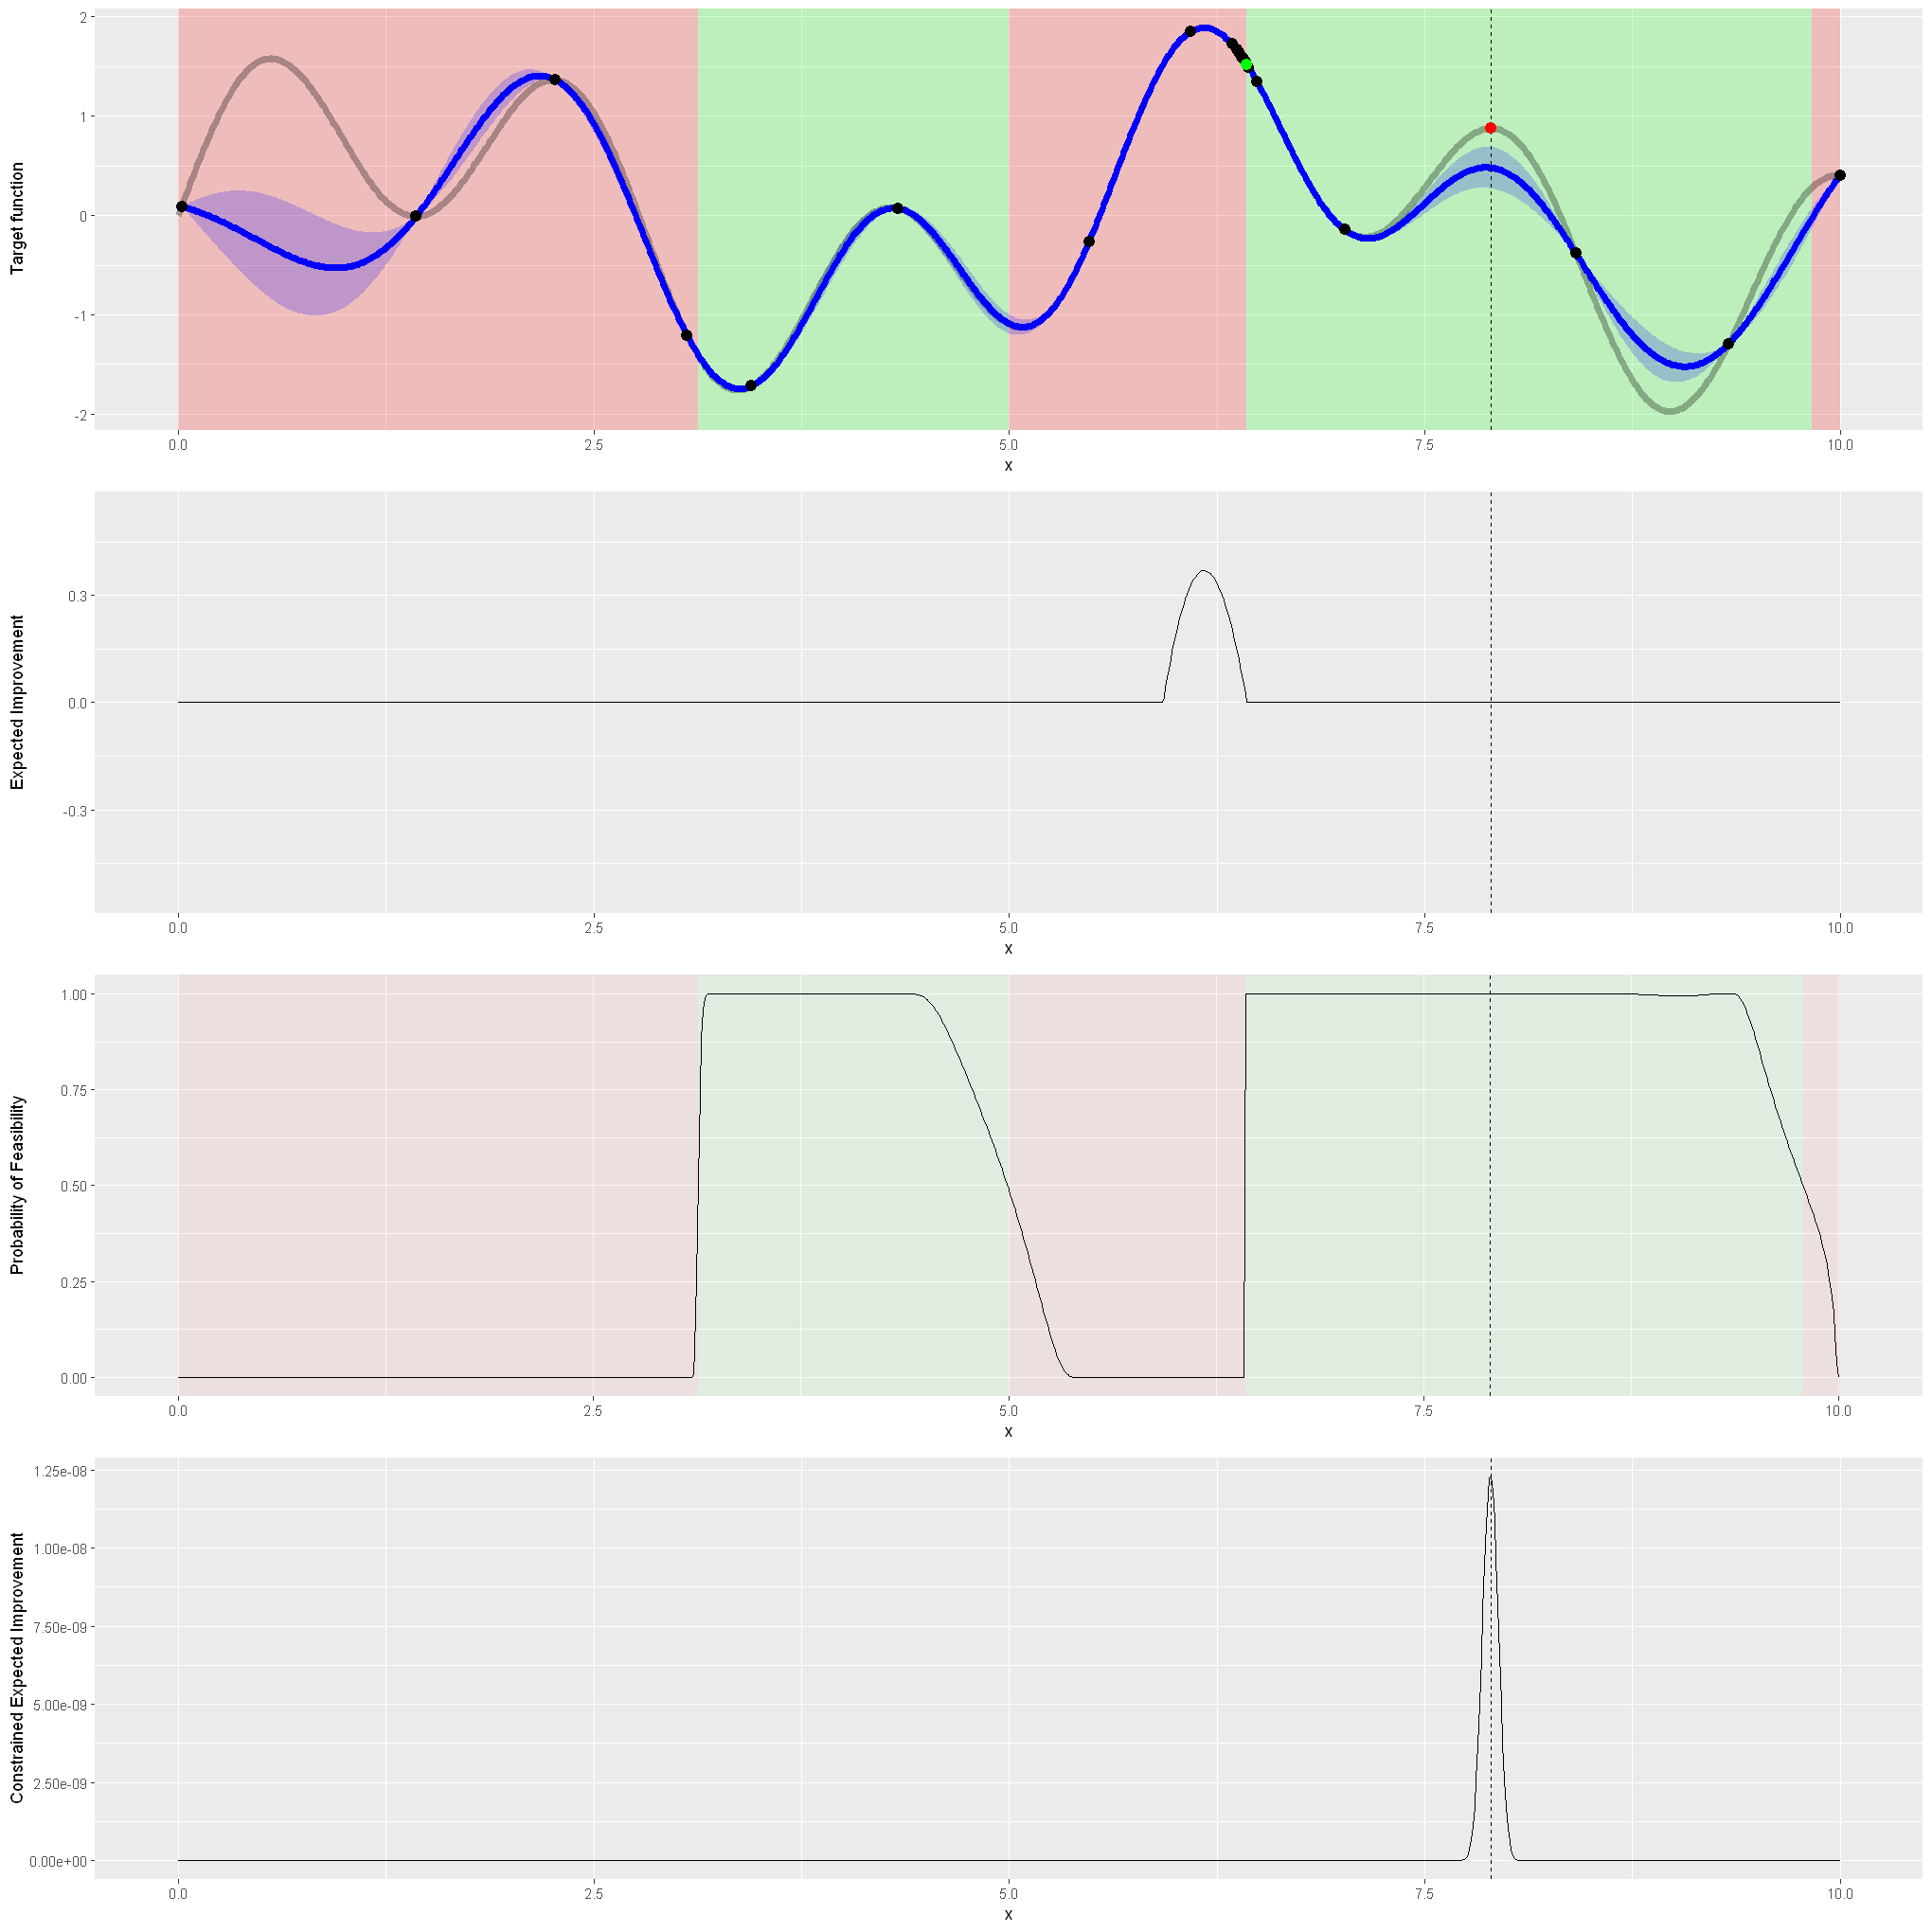

Iteration 23 


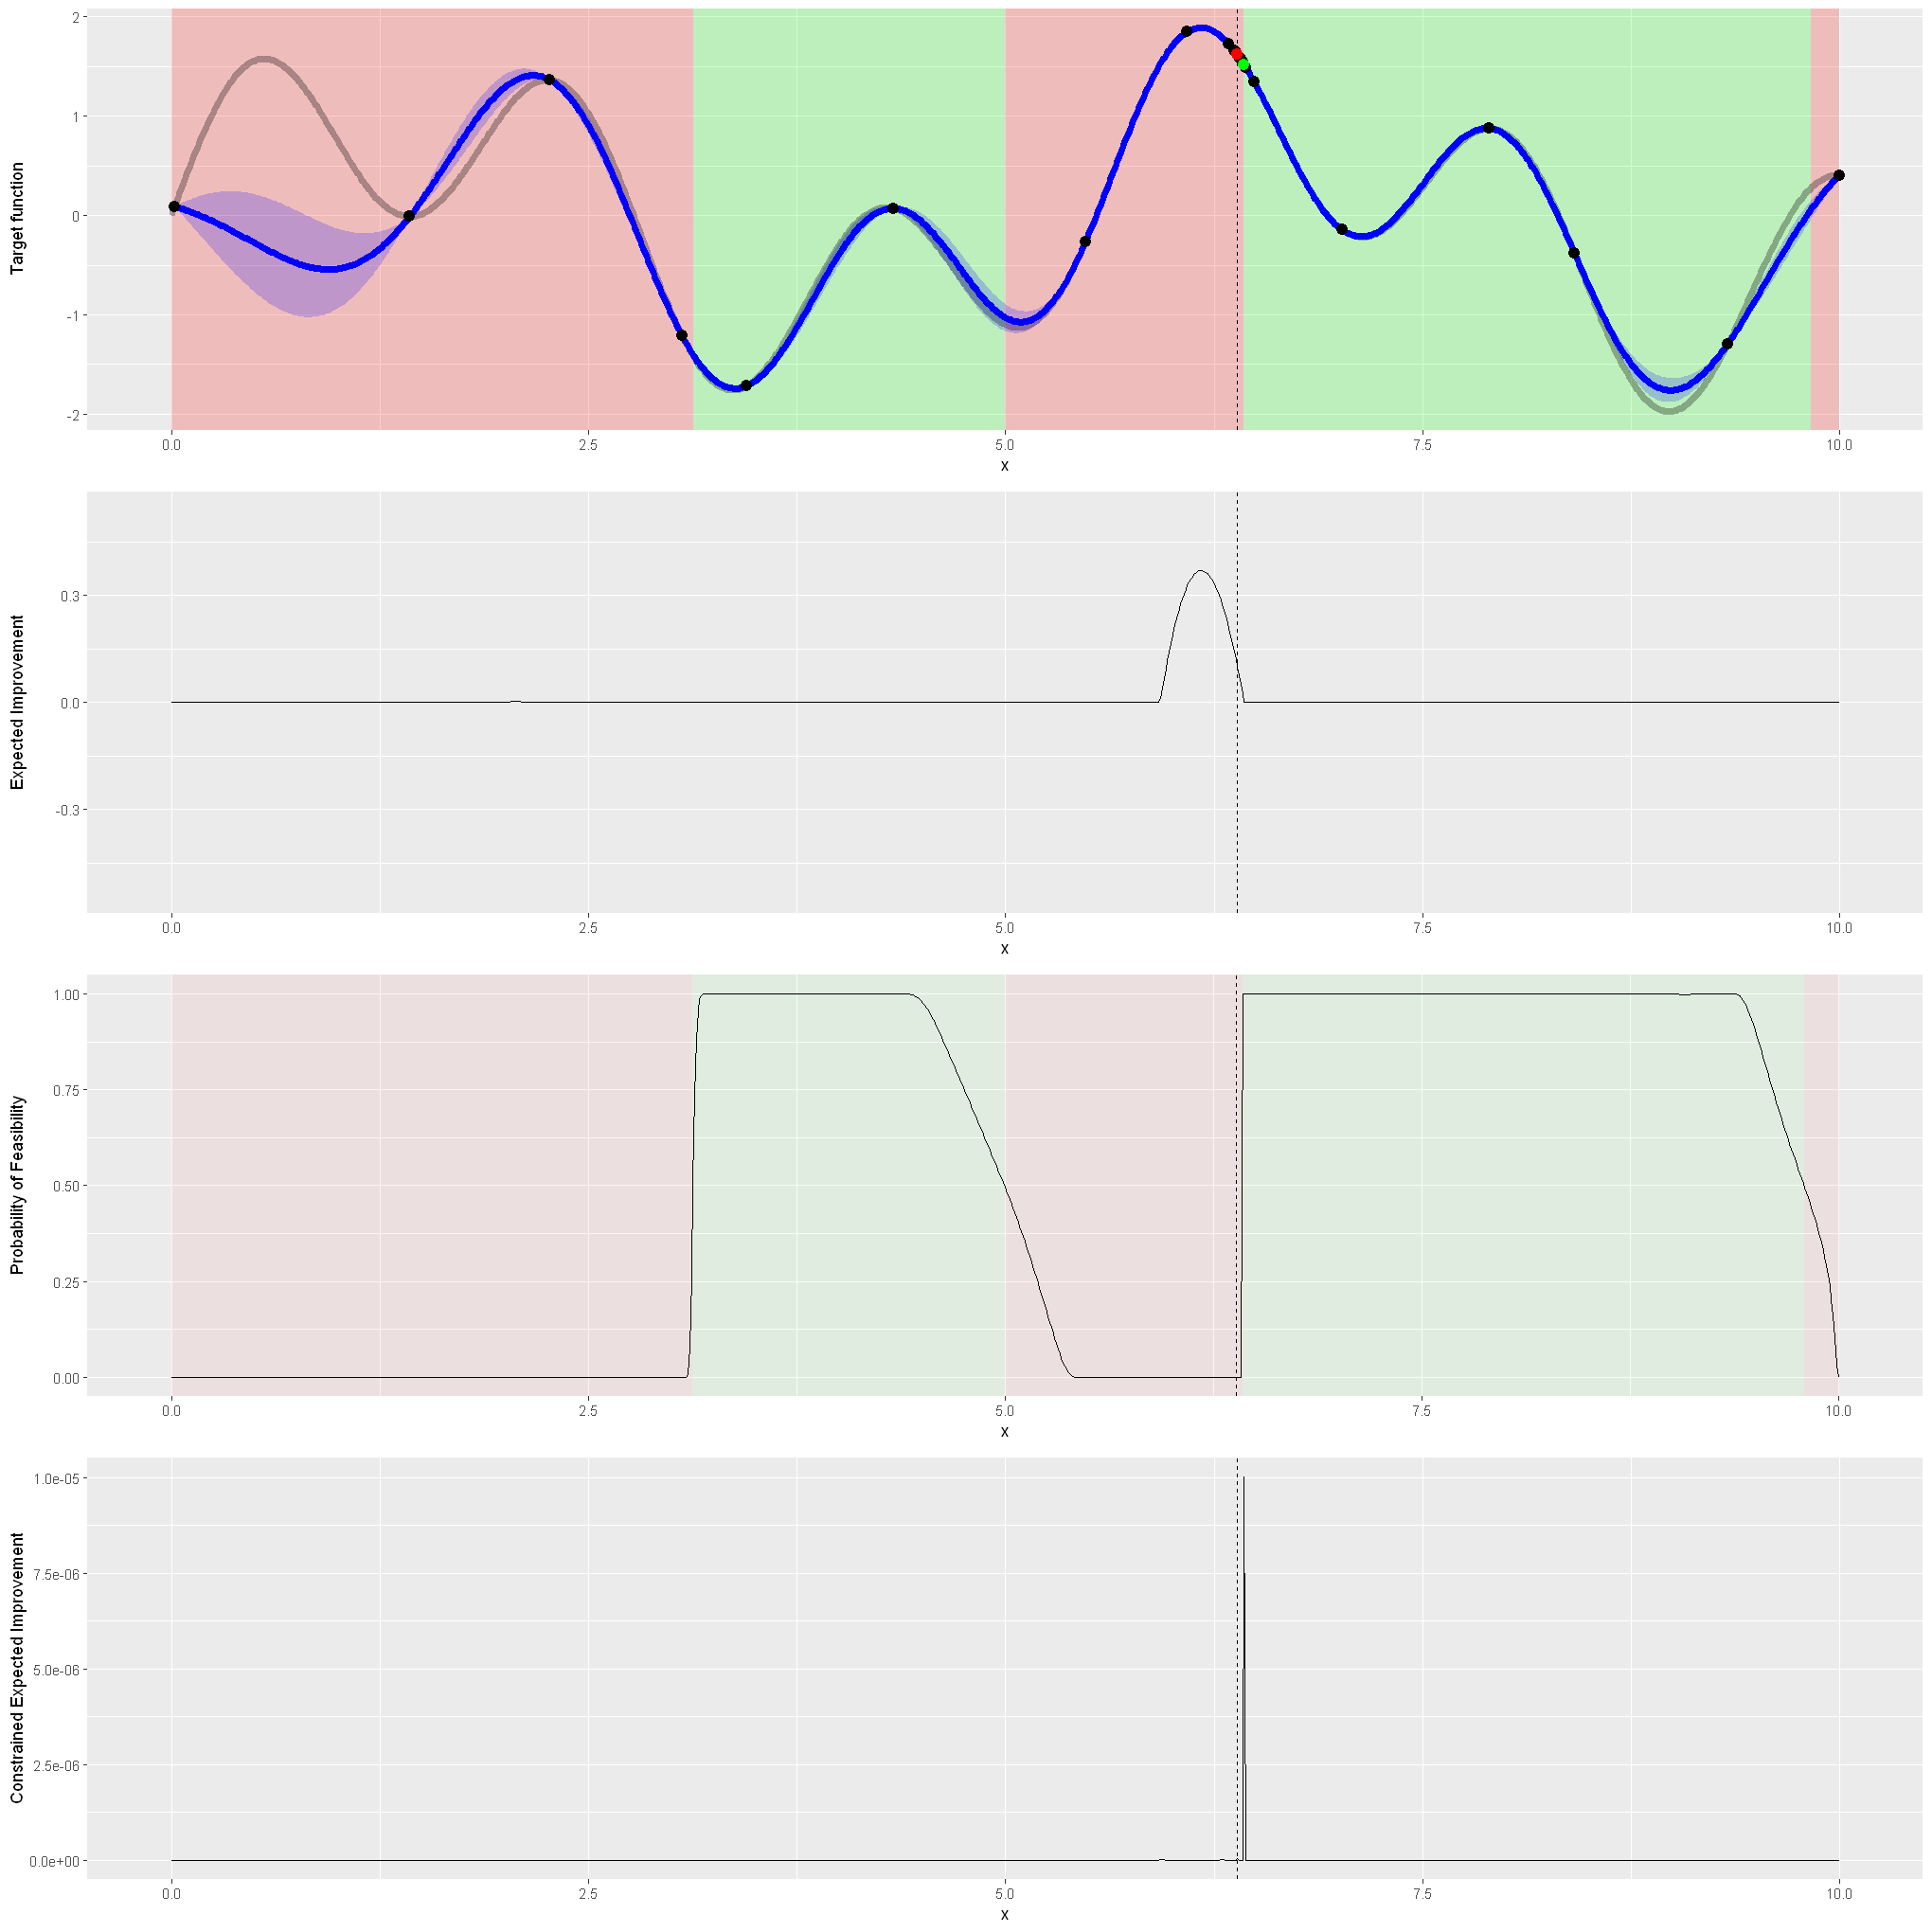

Iteration 24 


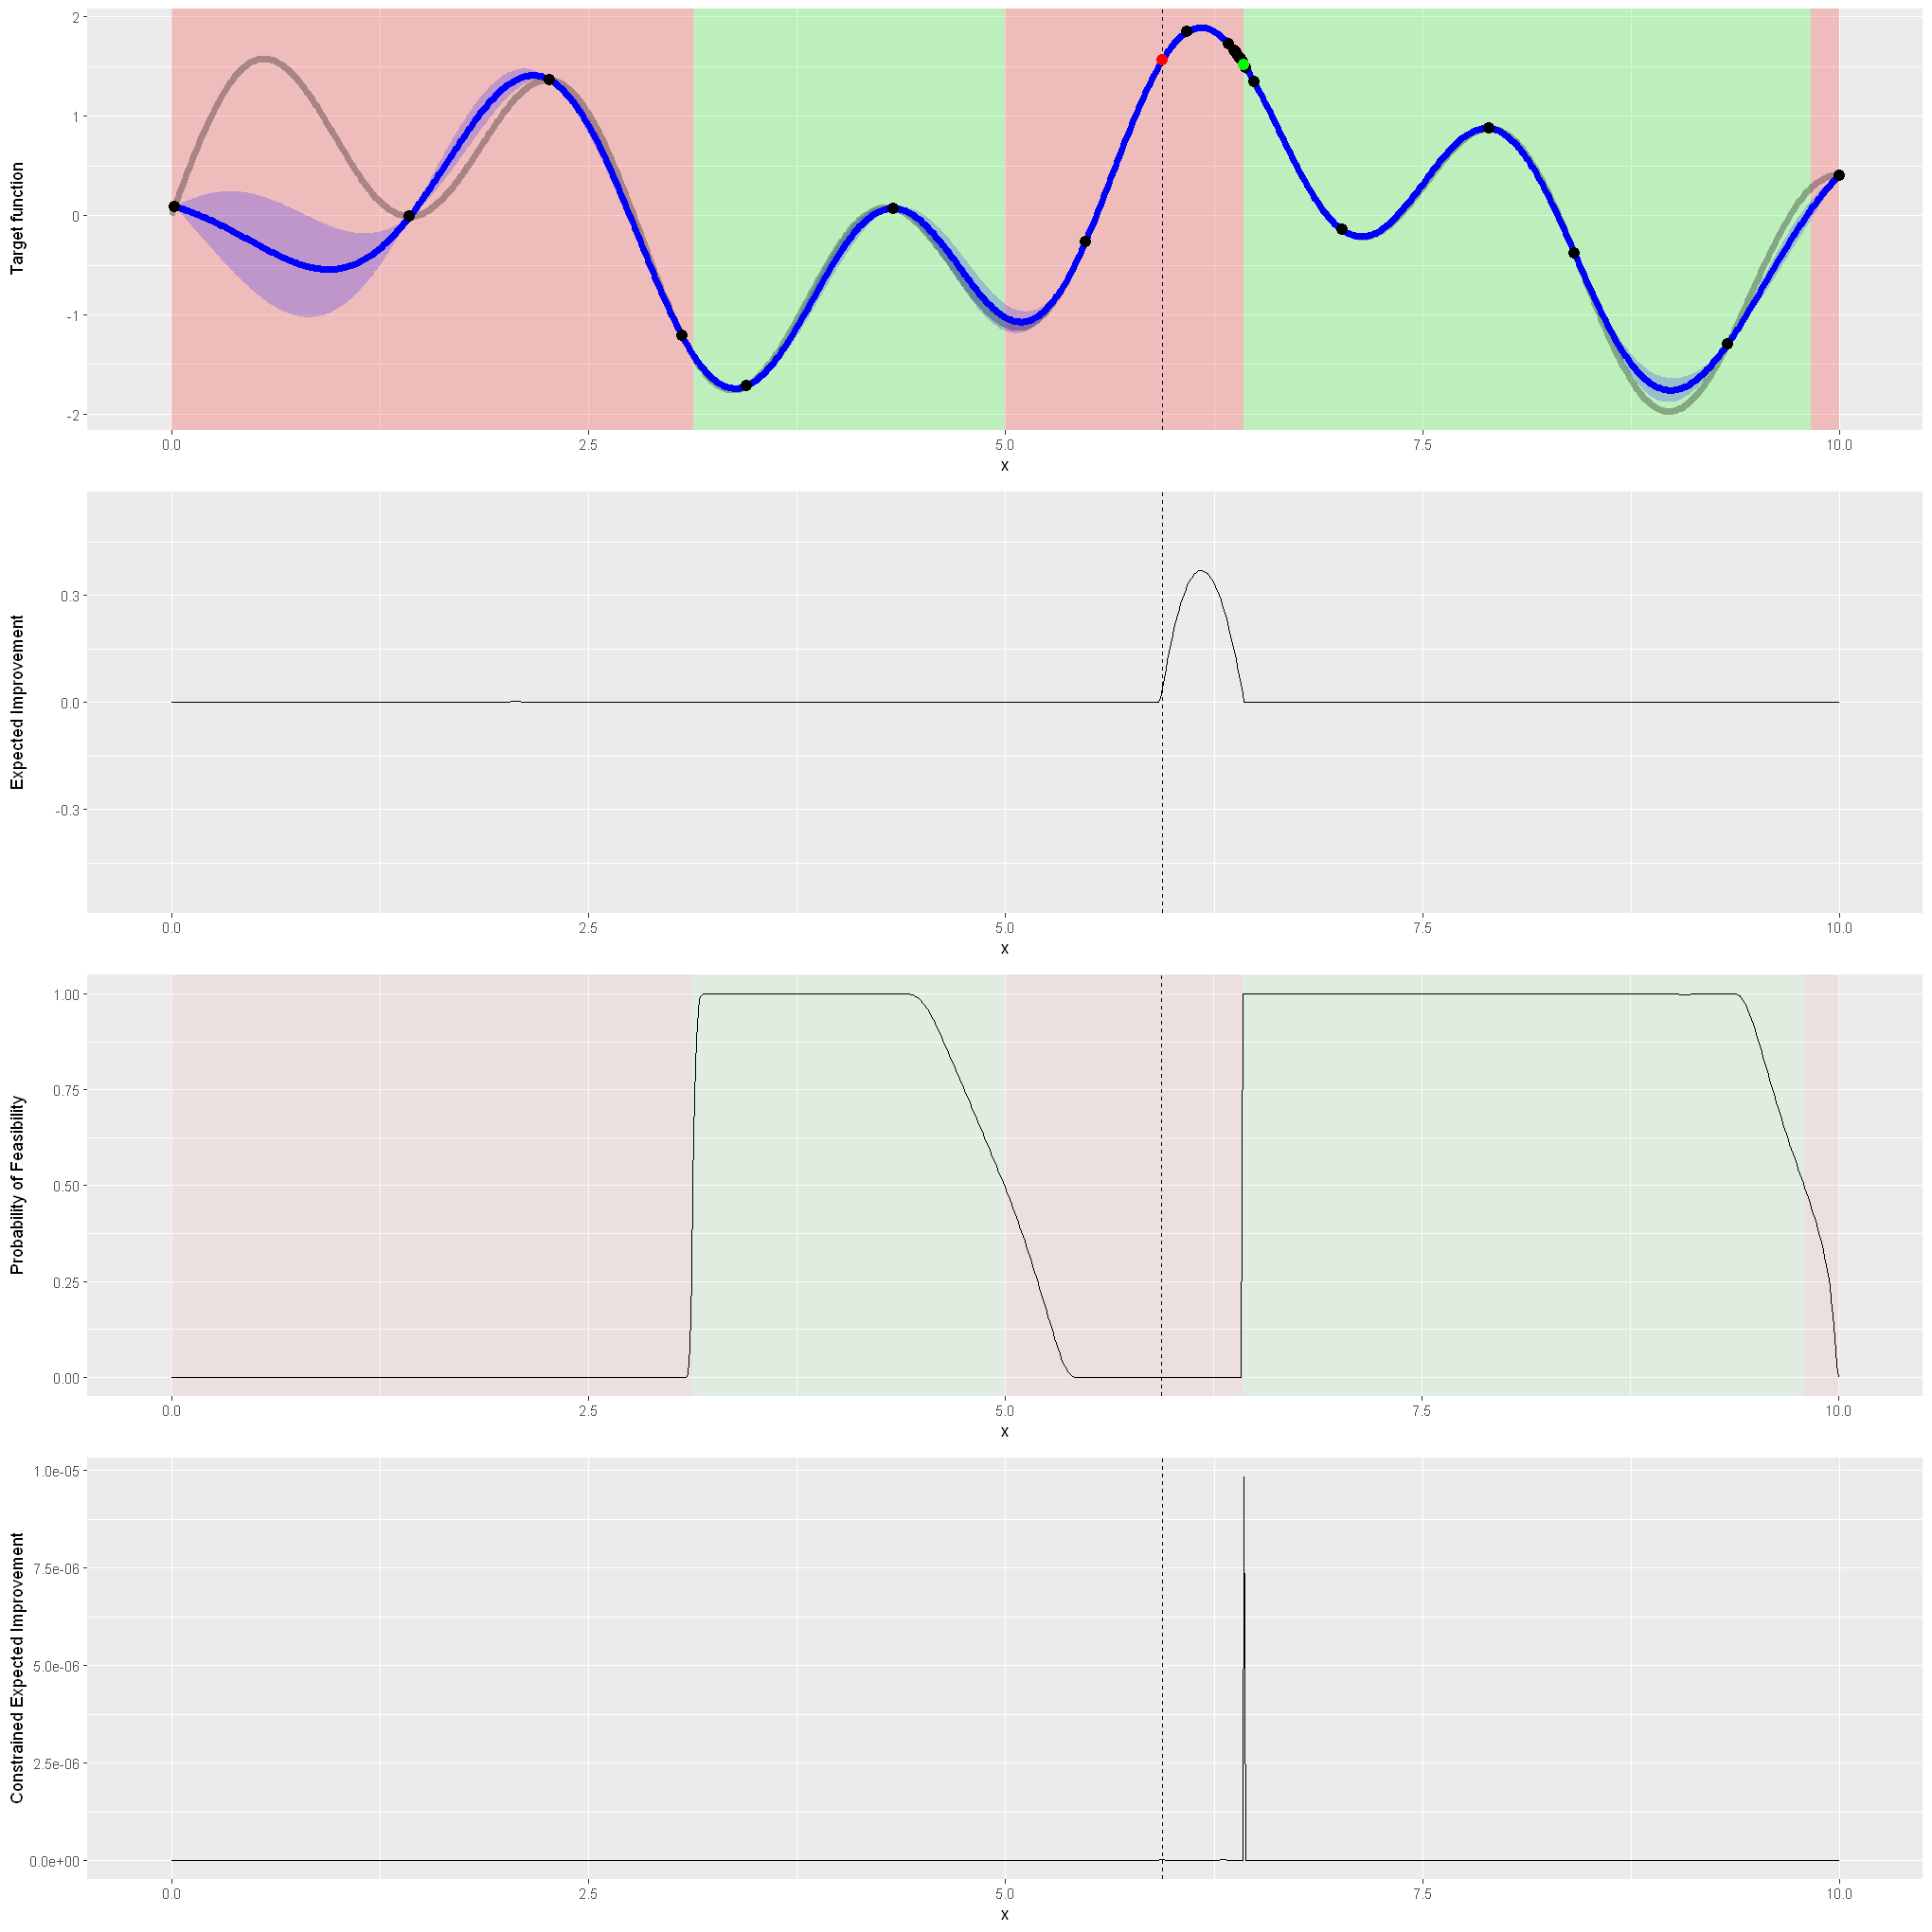

Iteration 25 


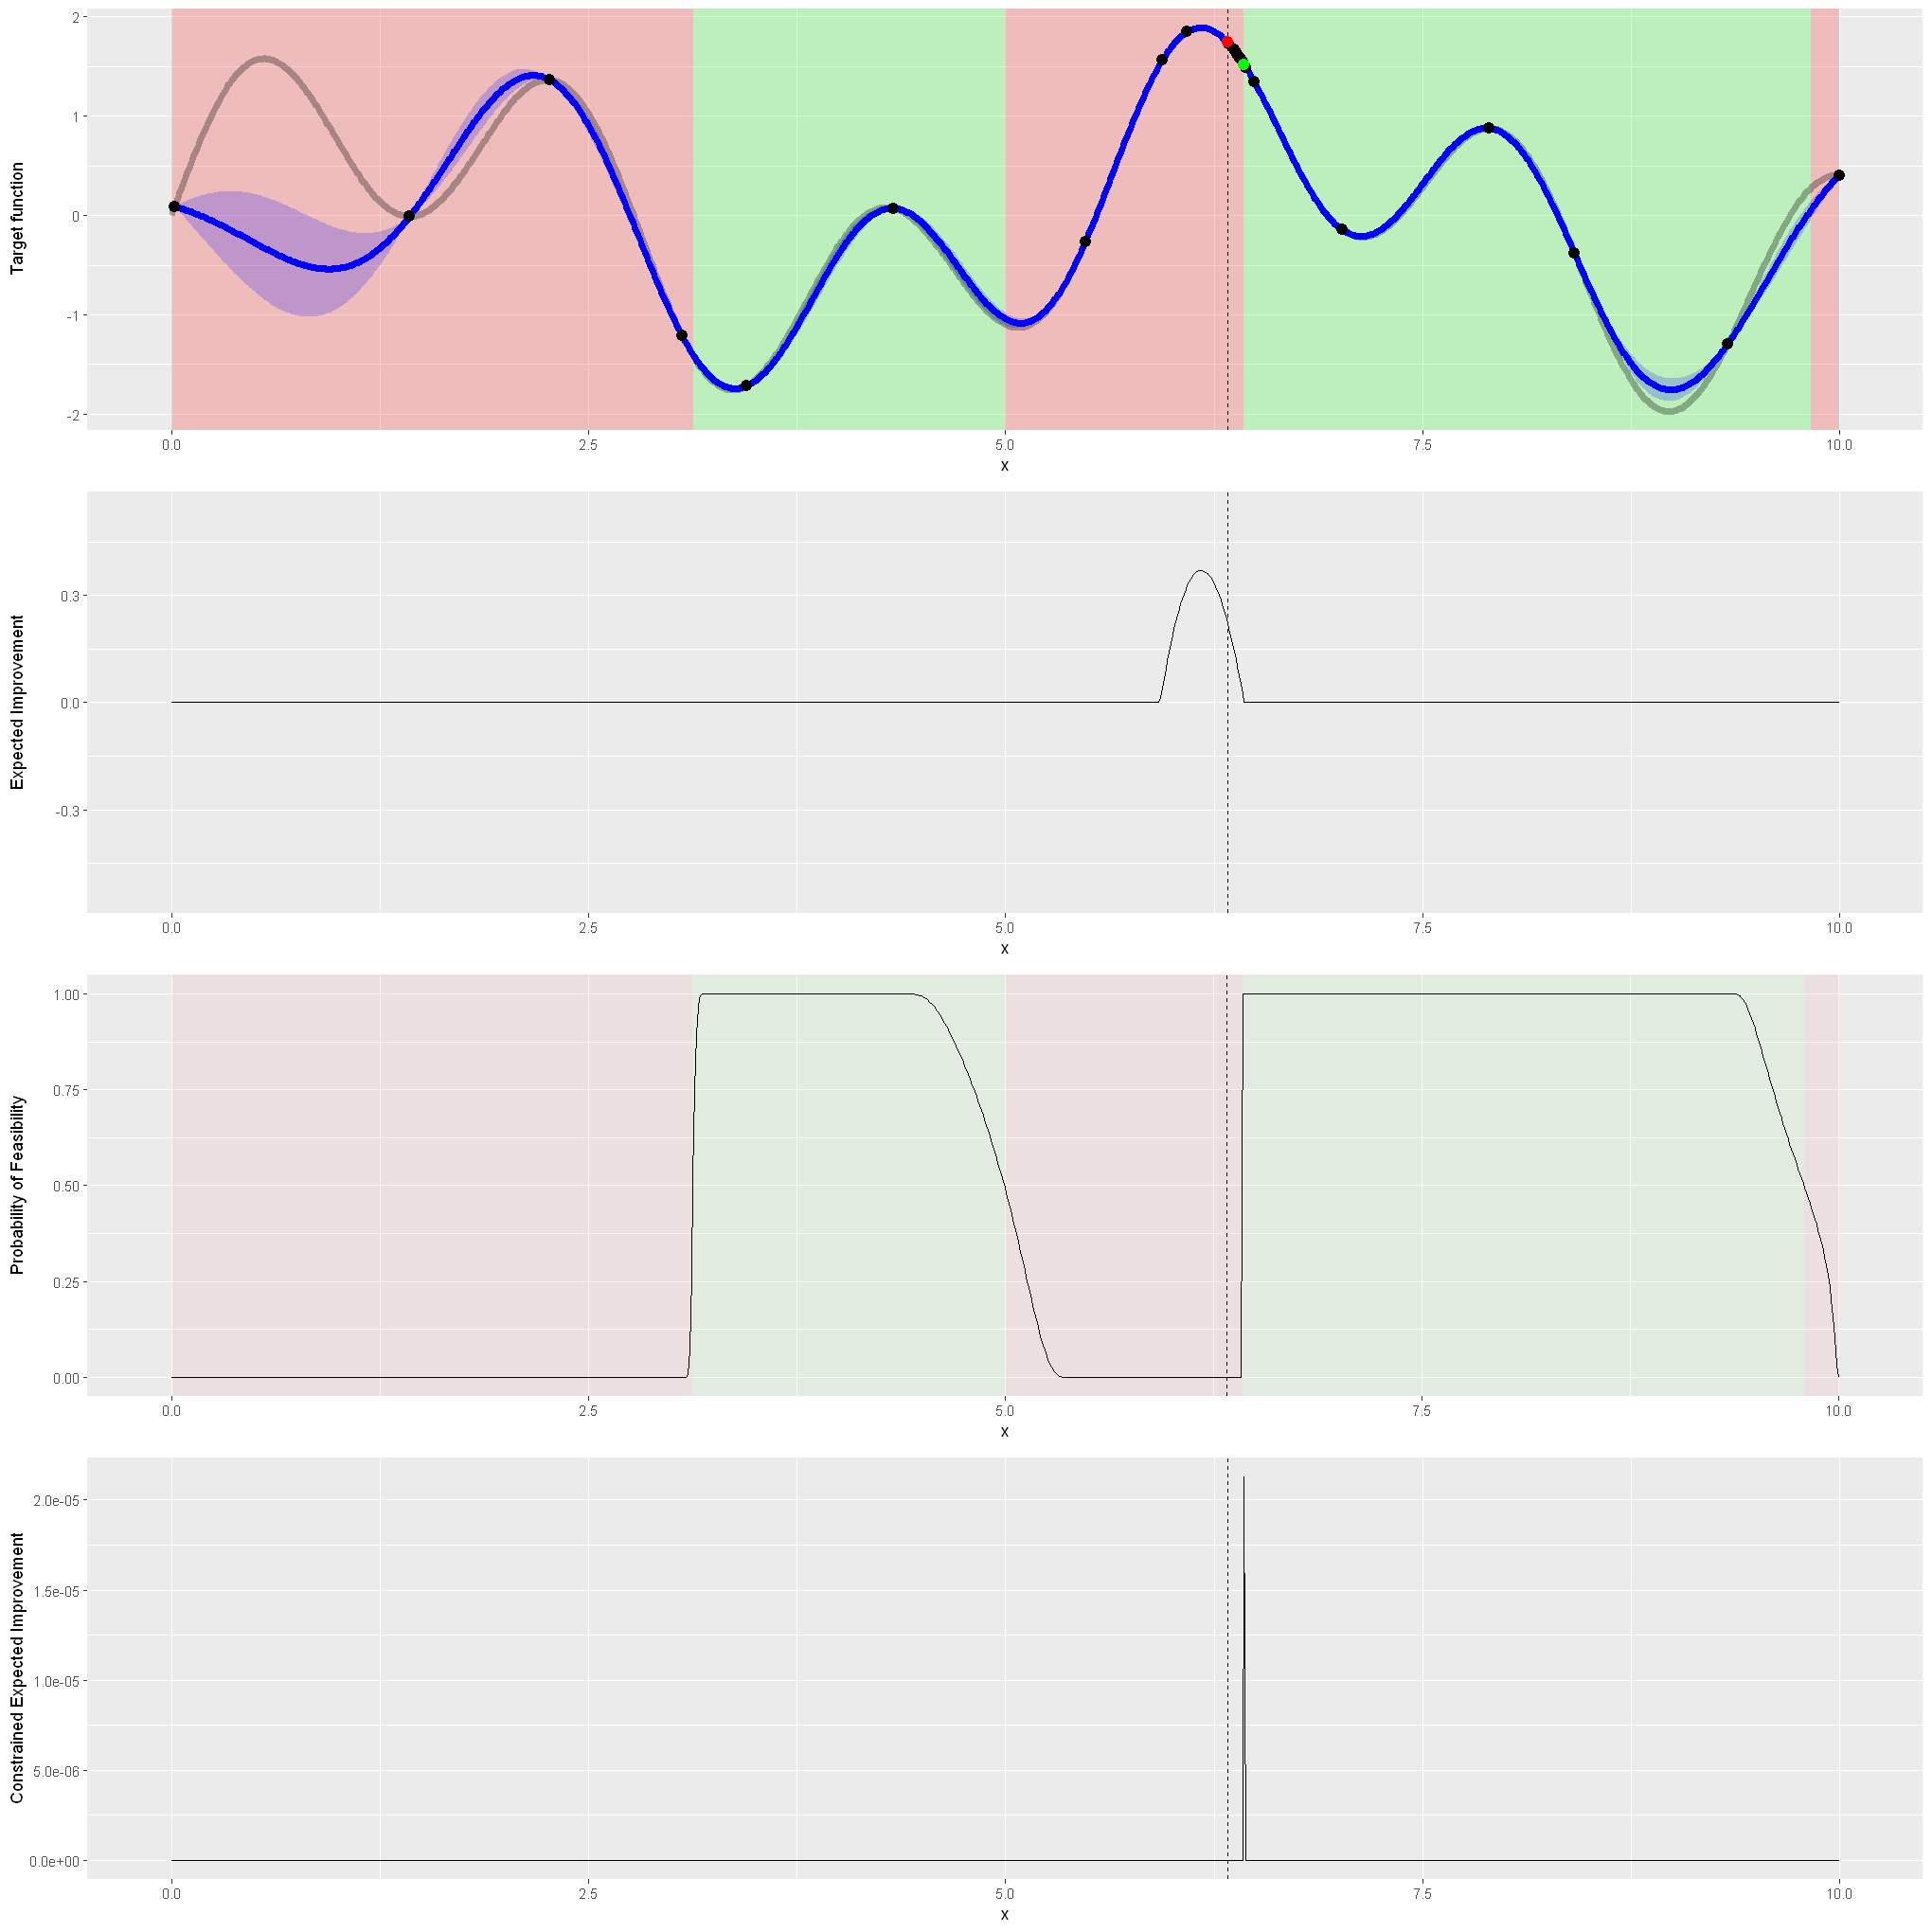

Iteration 26 


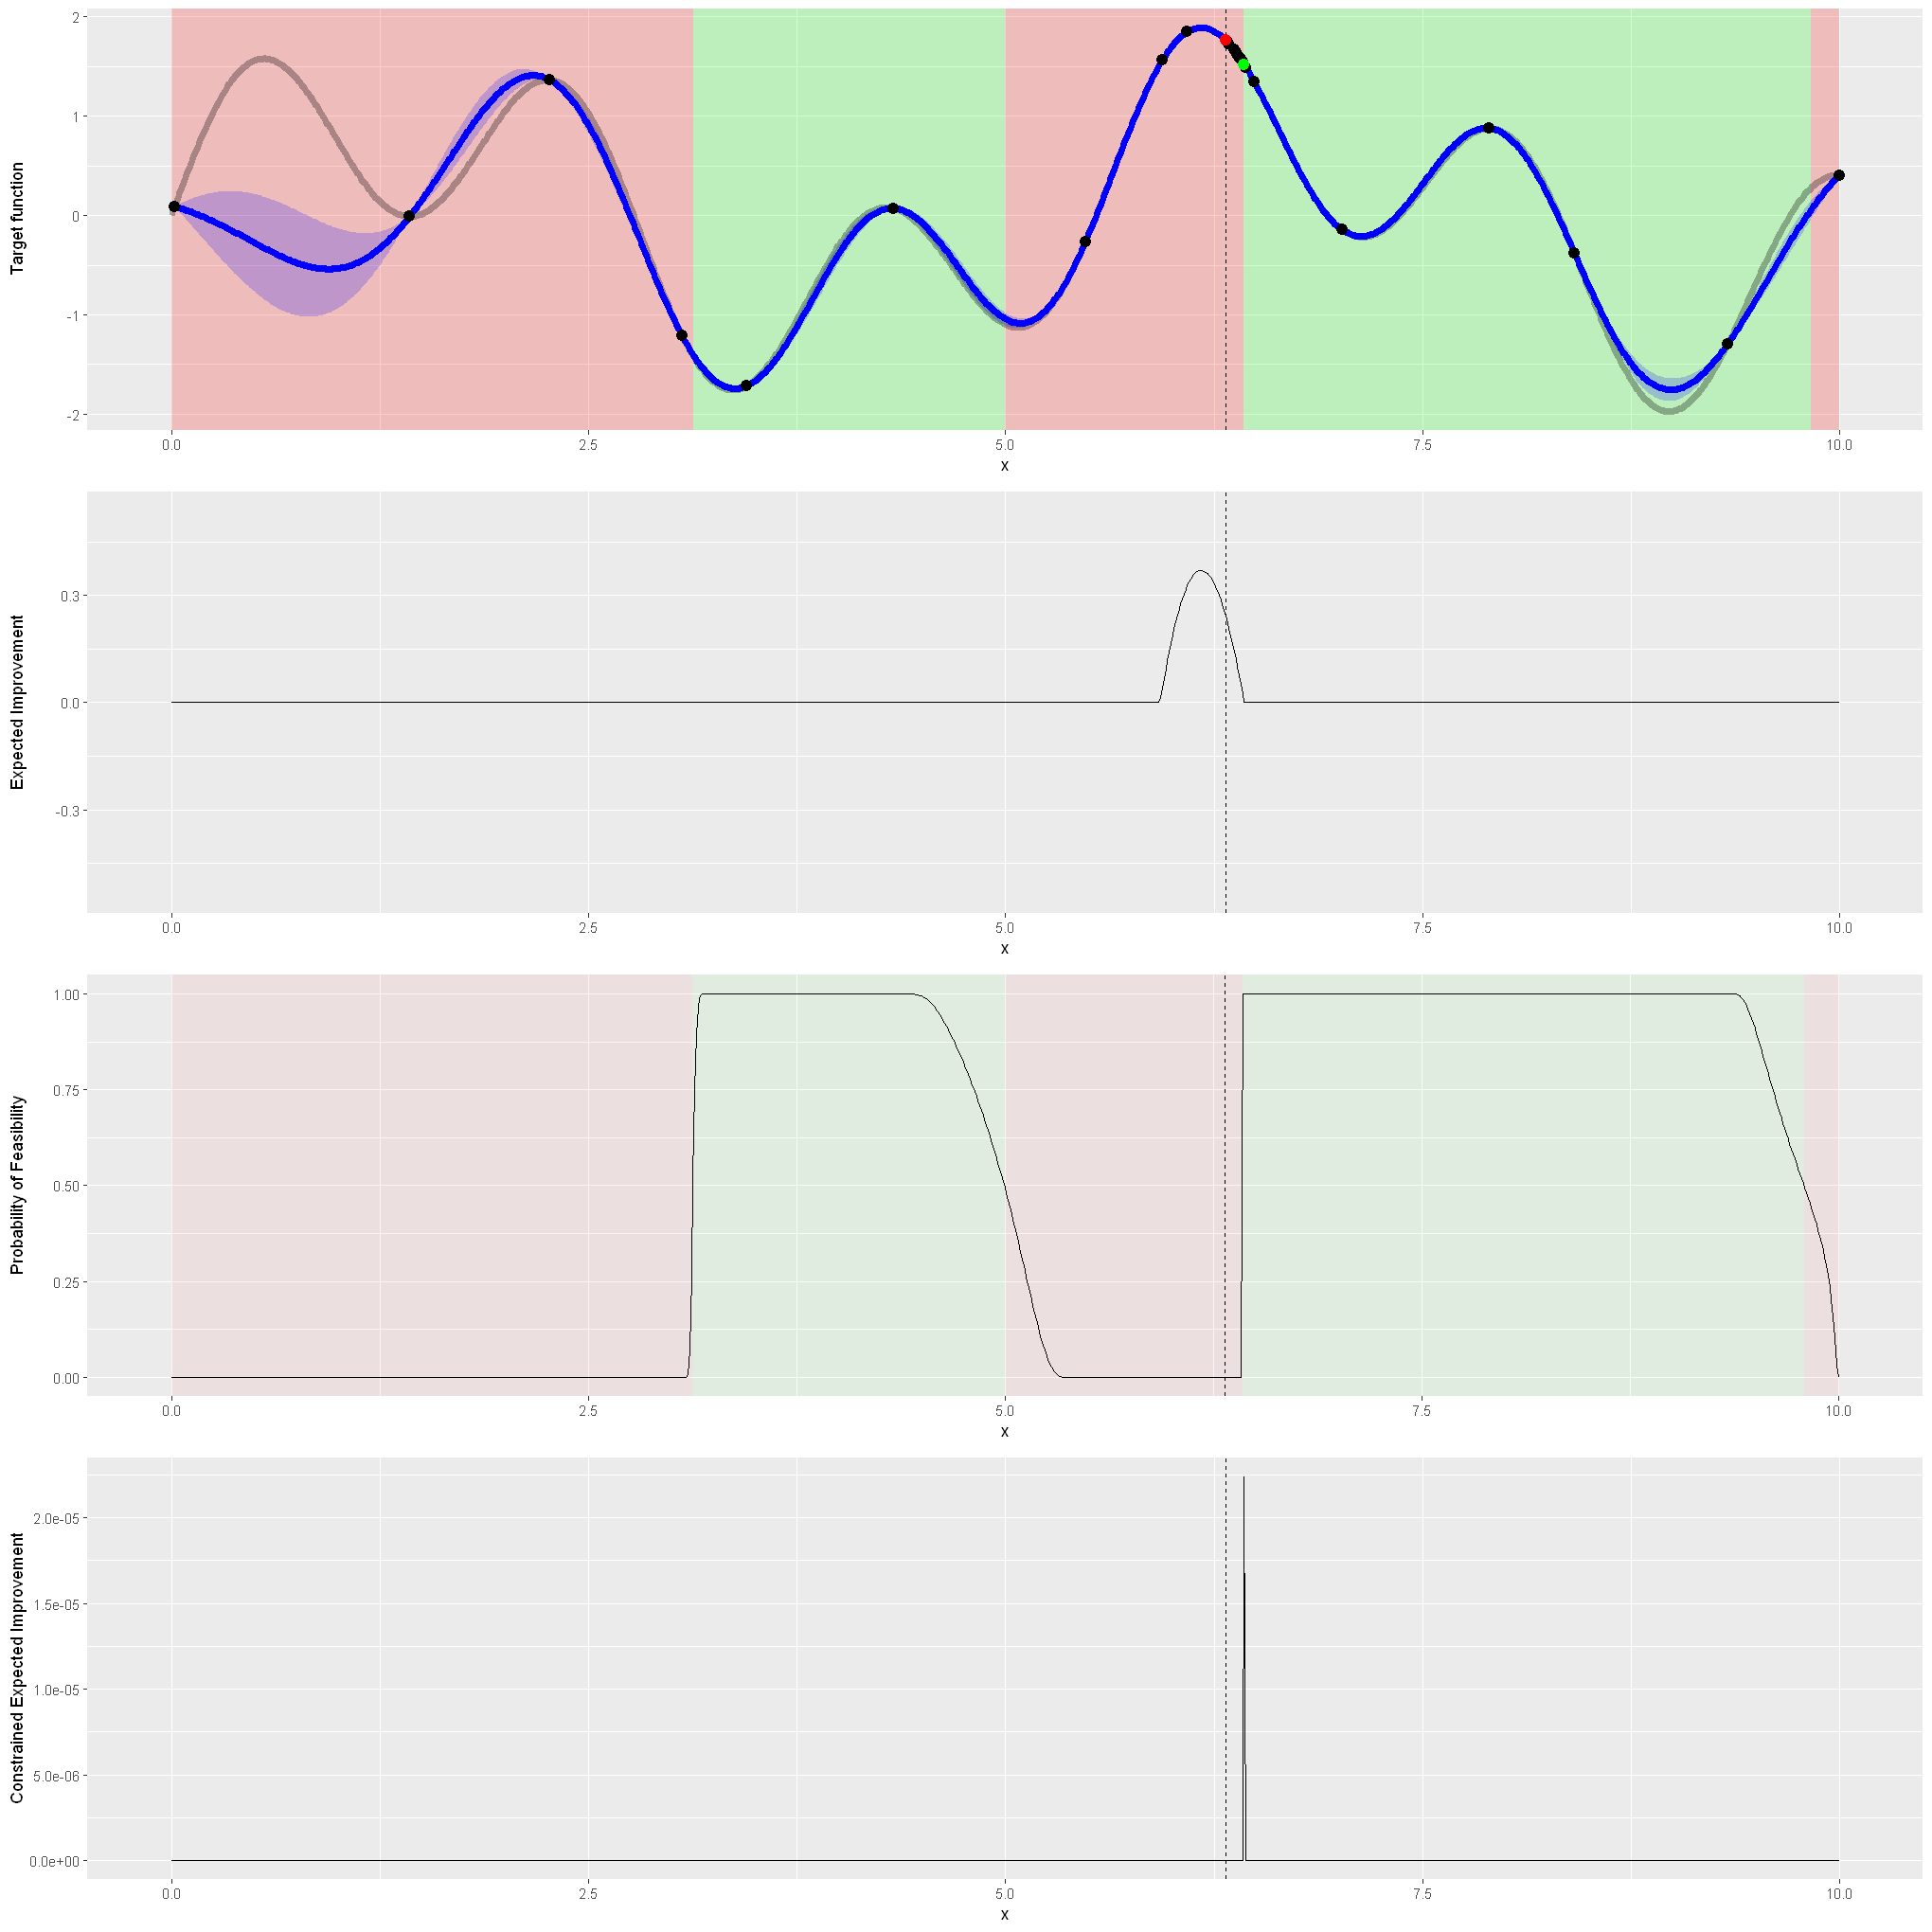

Iteration 27 


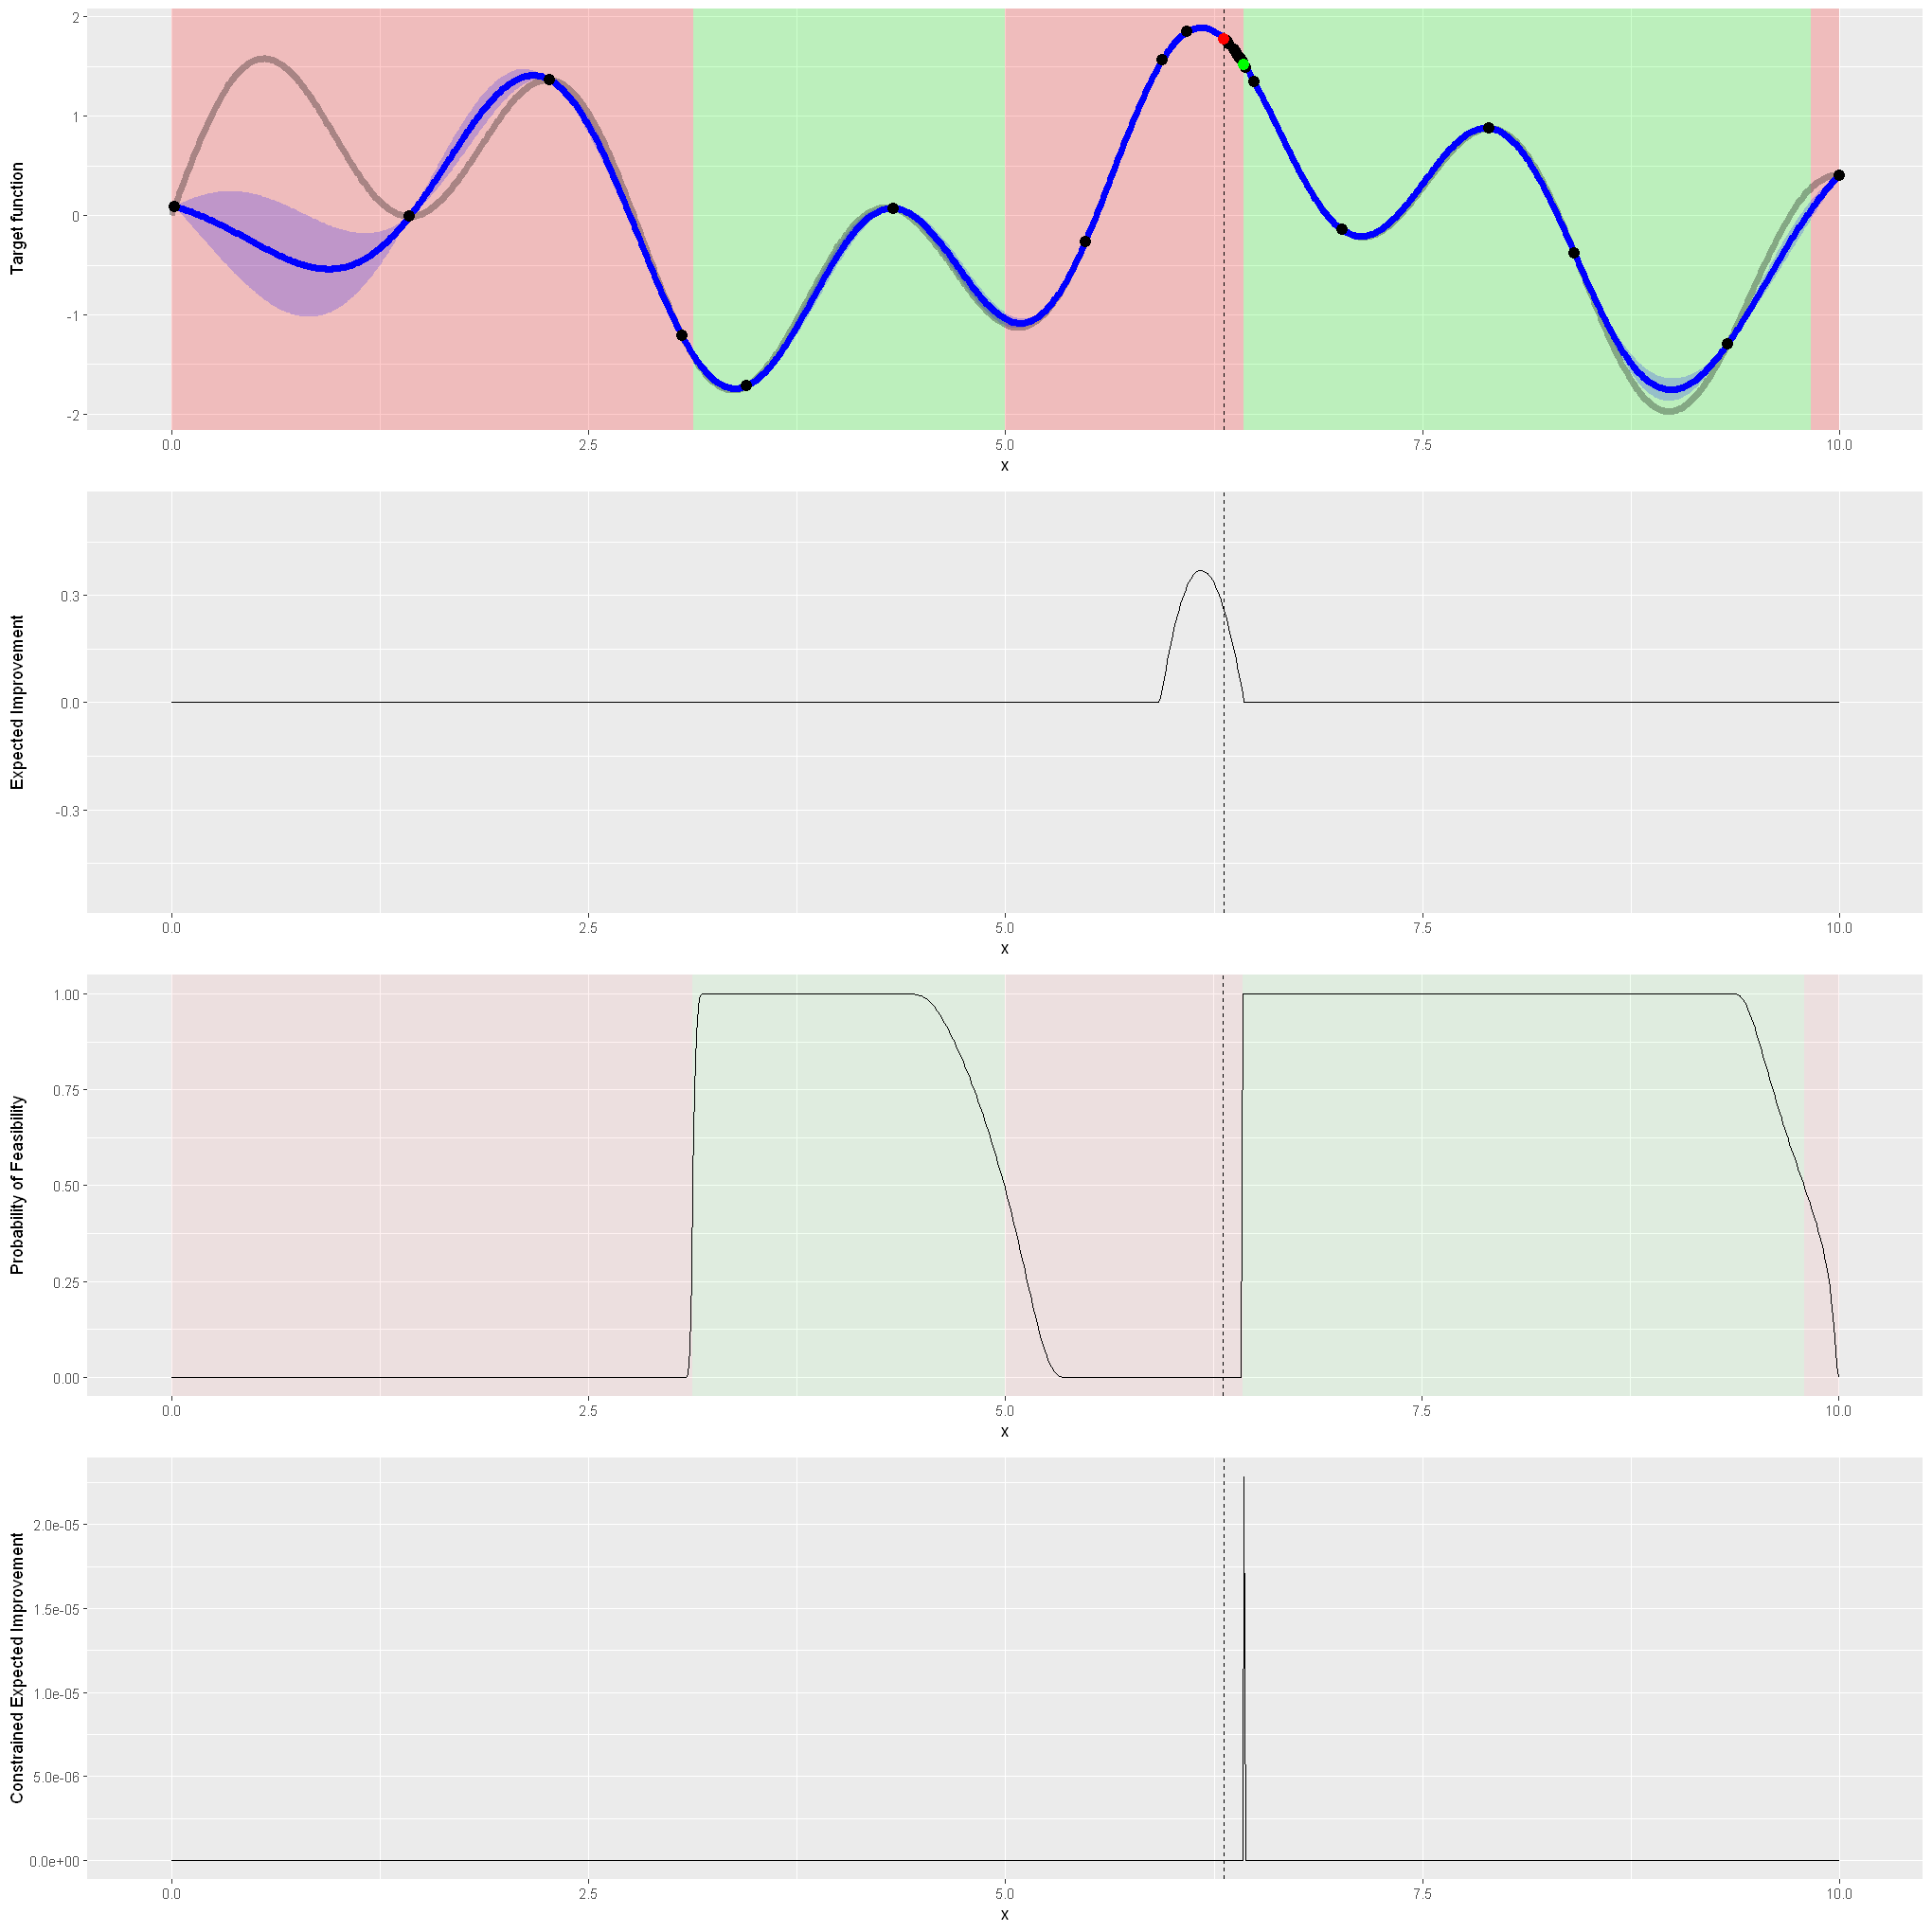

Iteration 28 


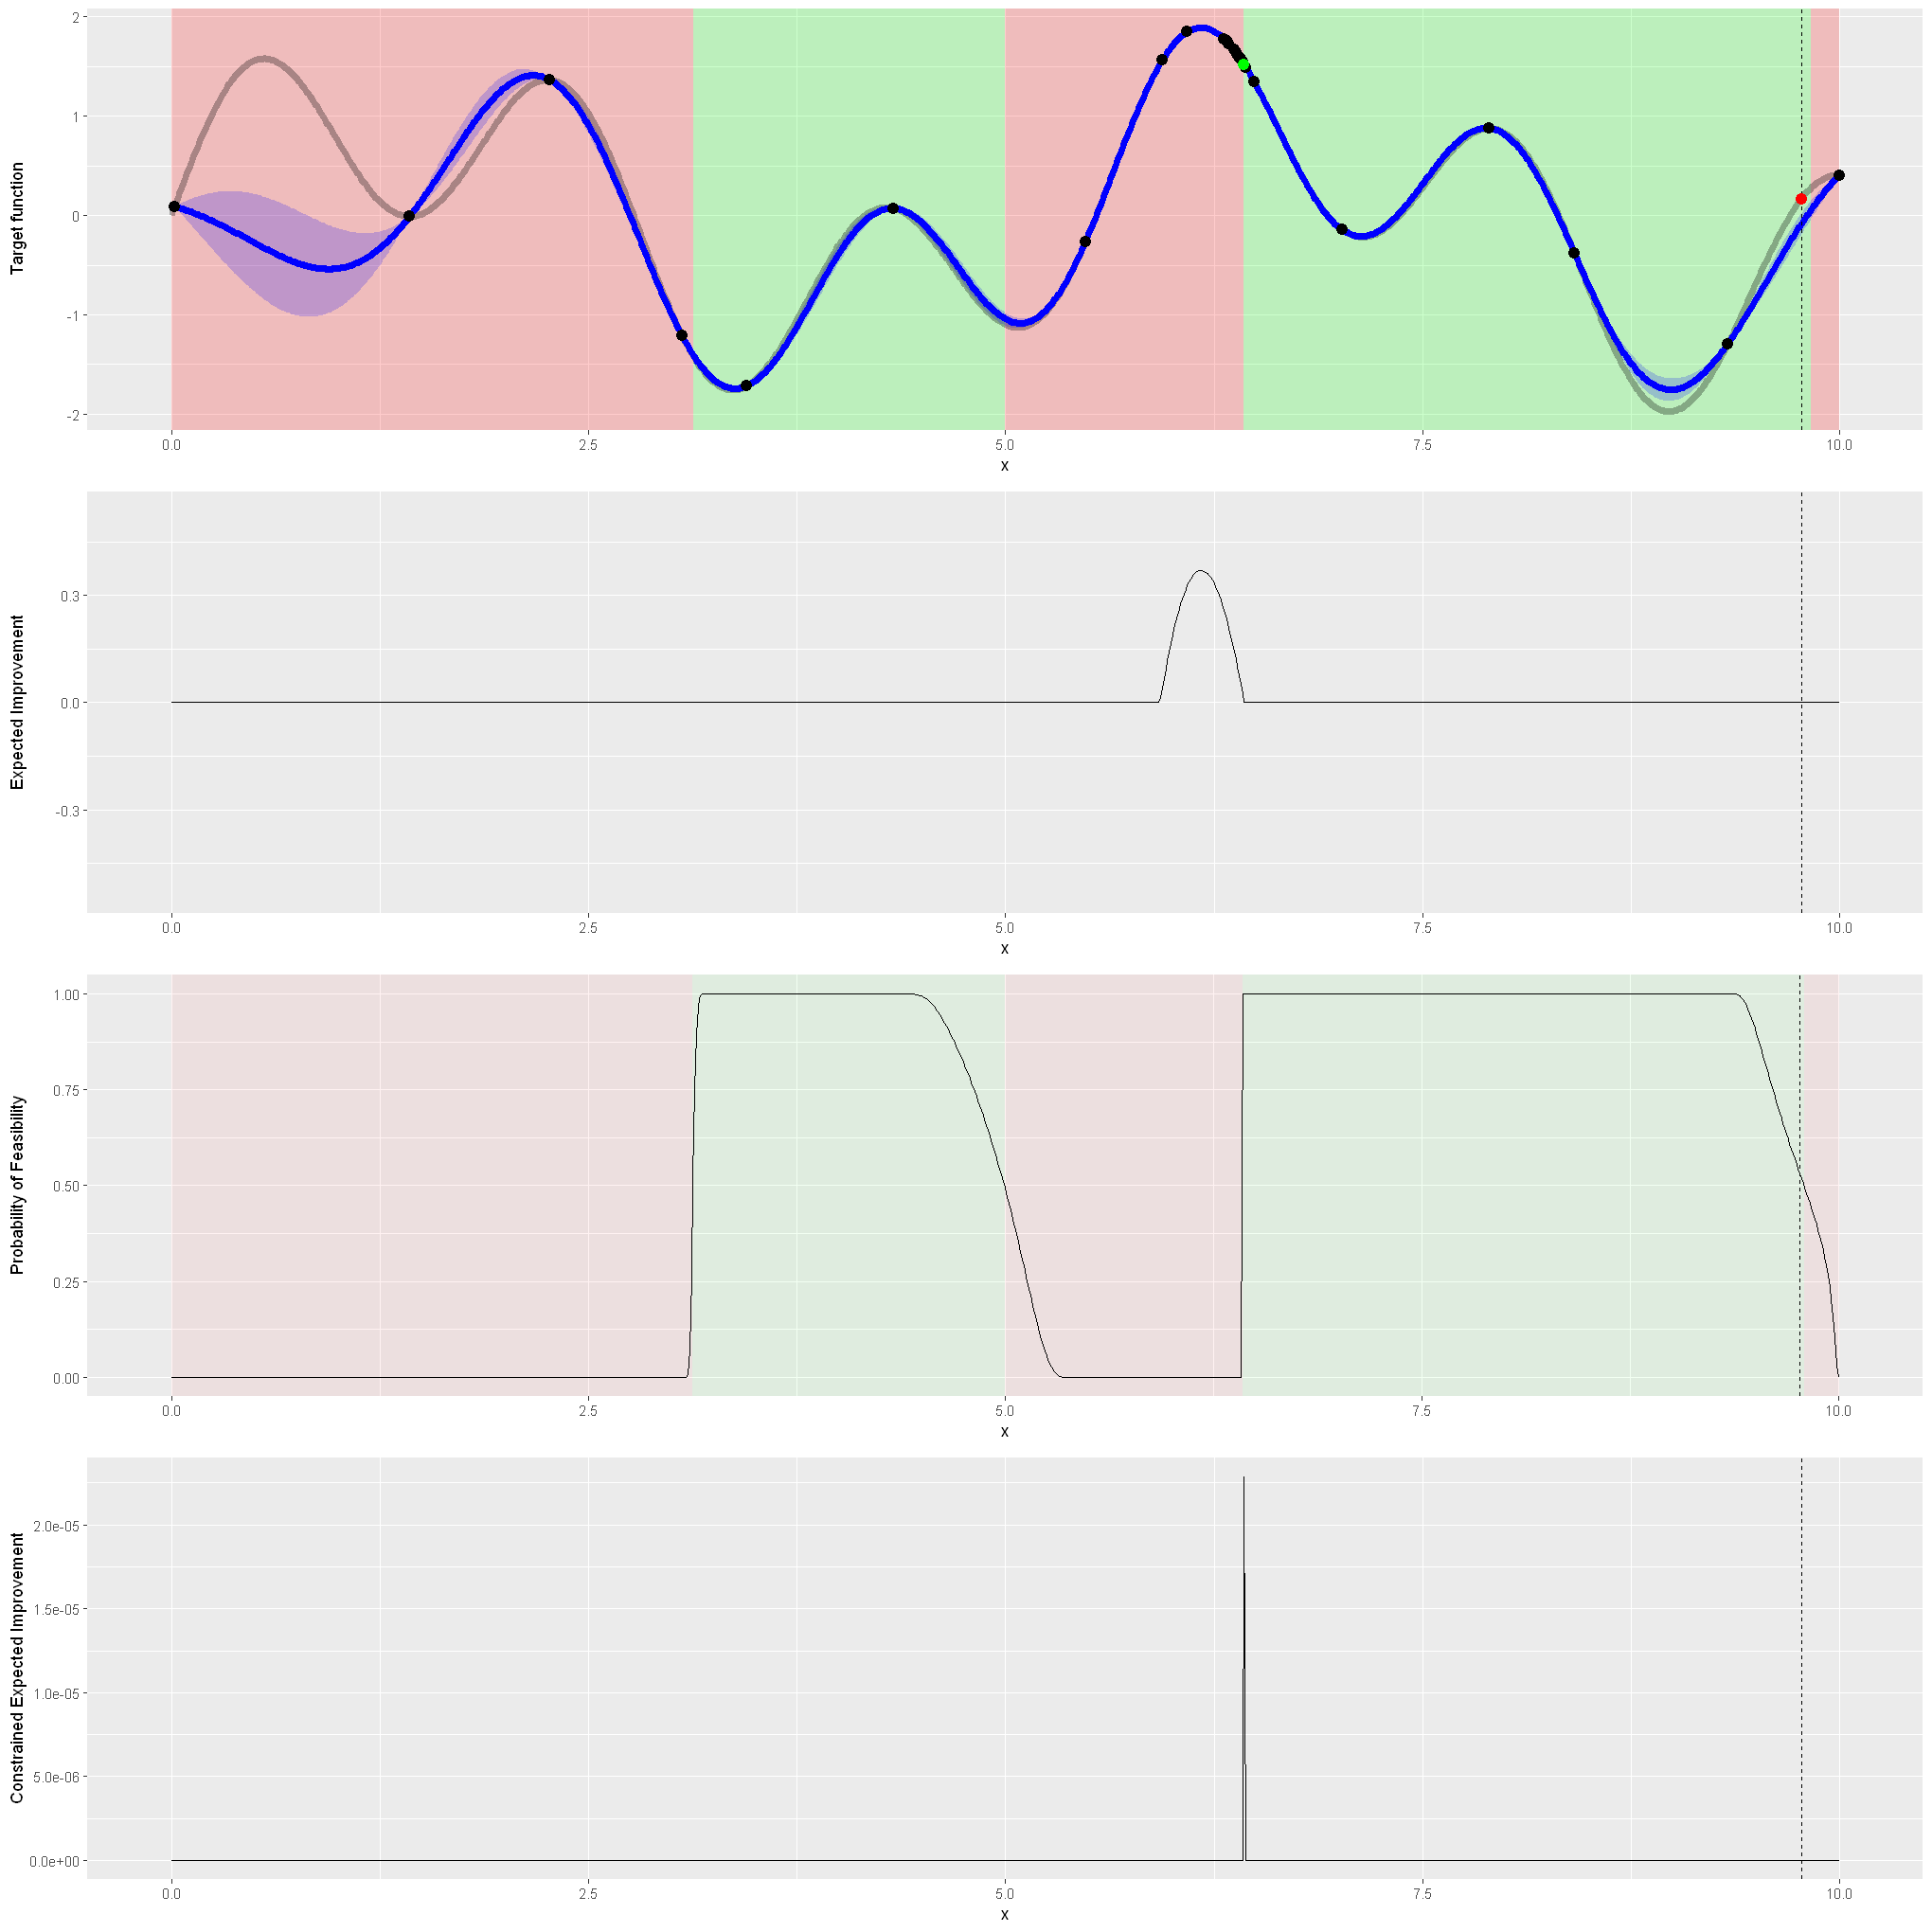

Iteration 29 


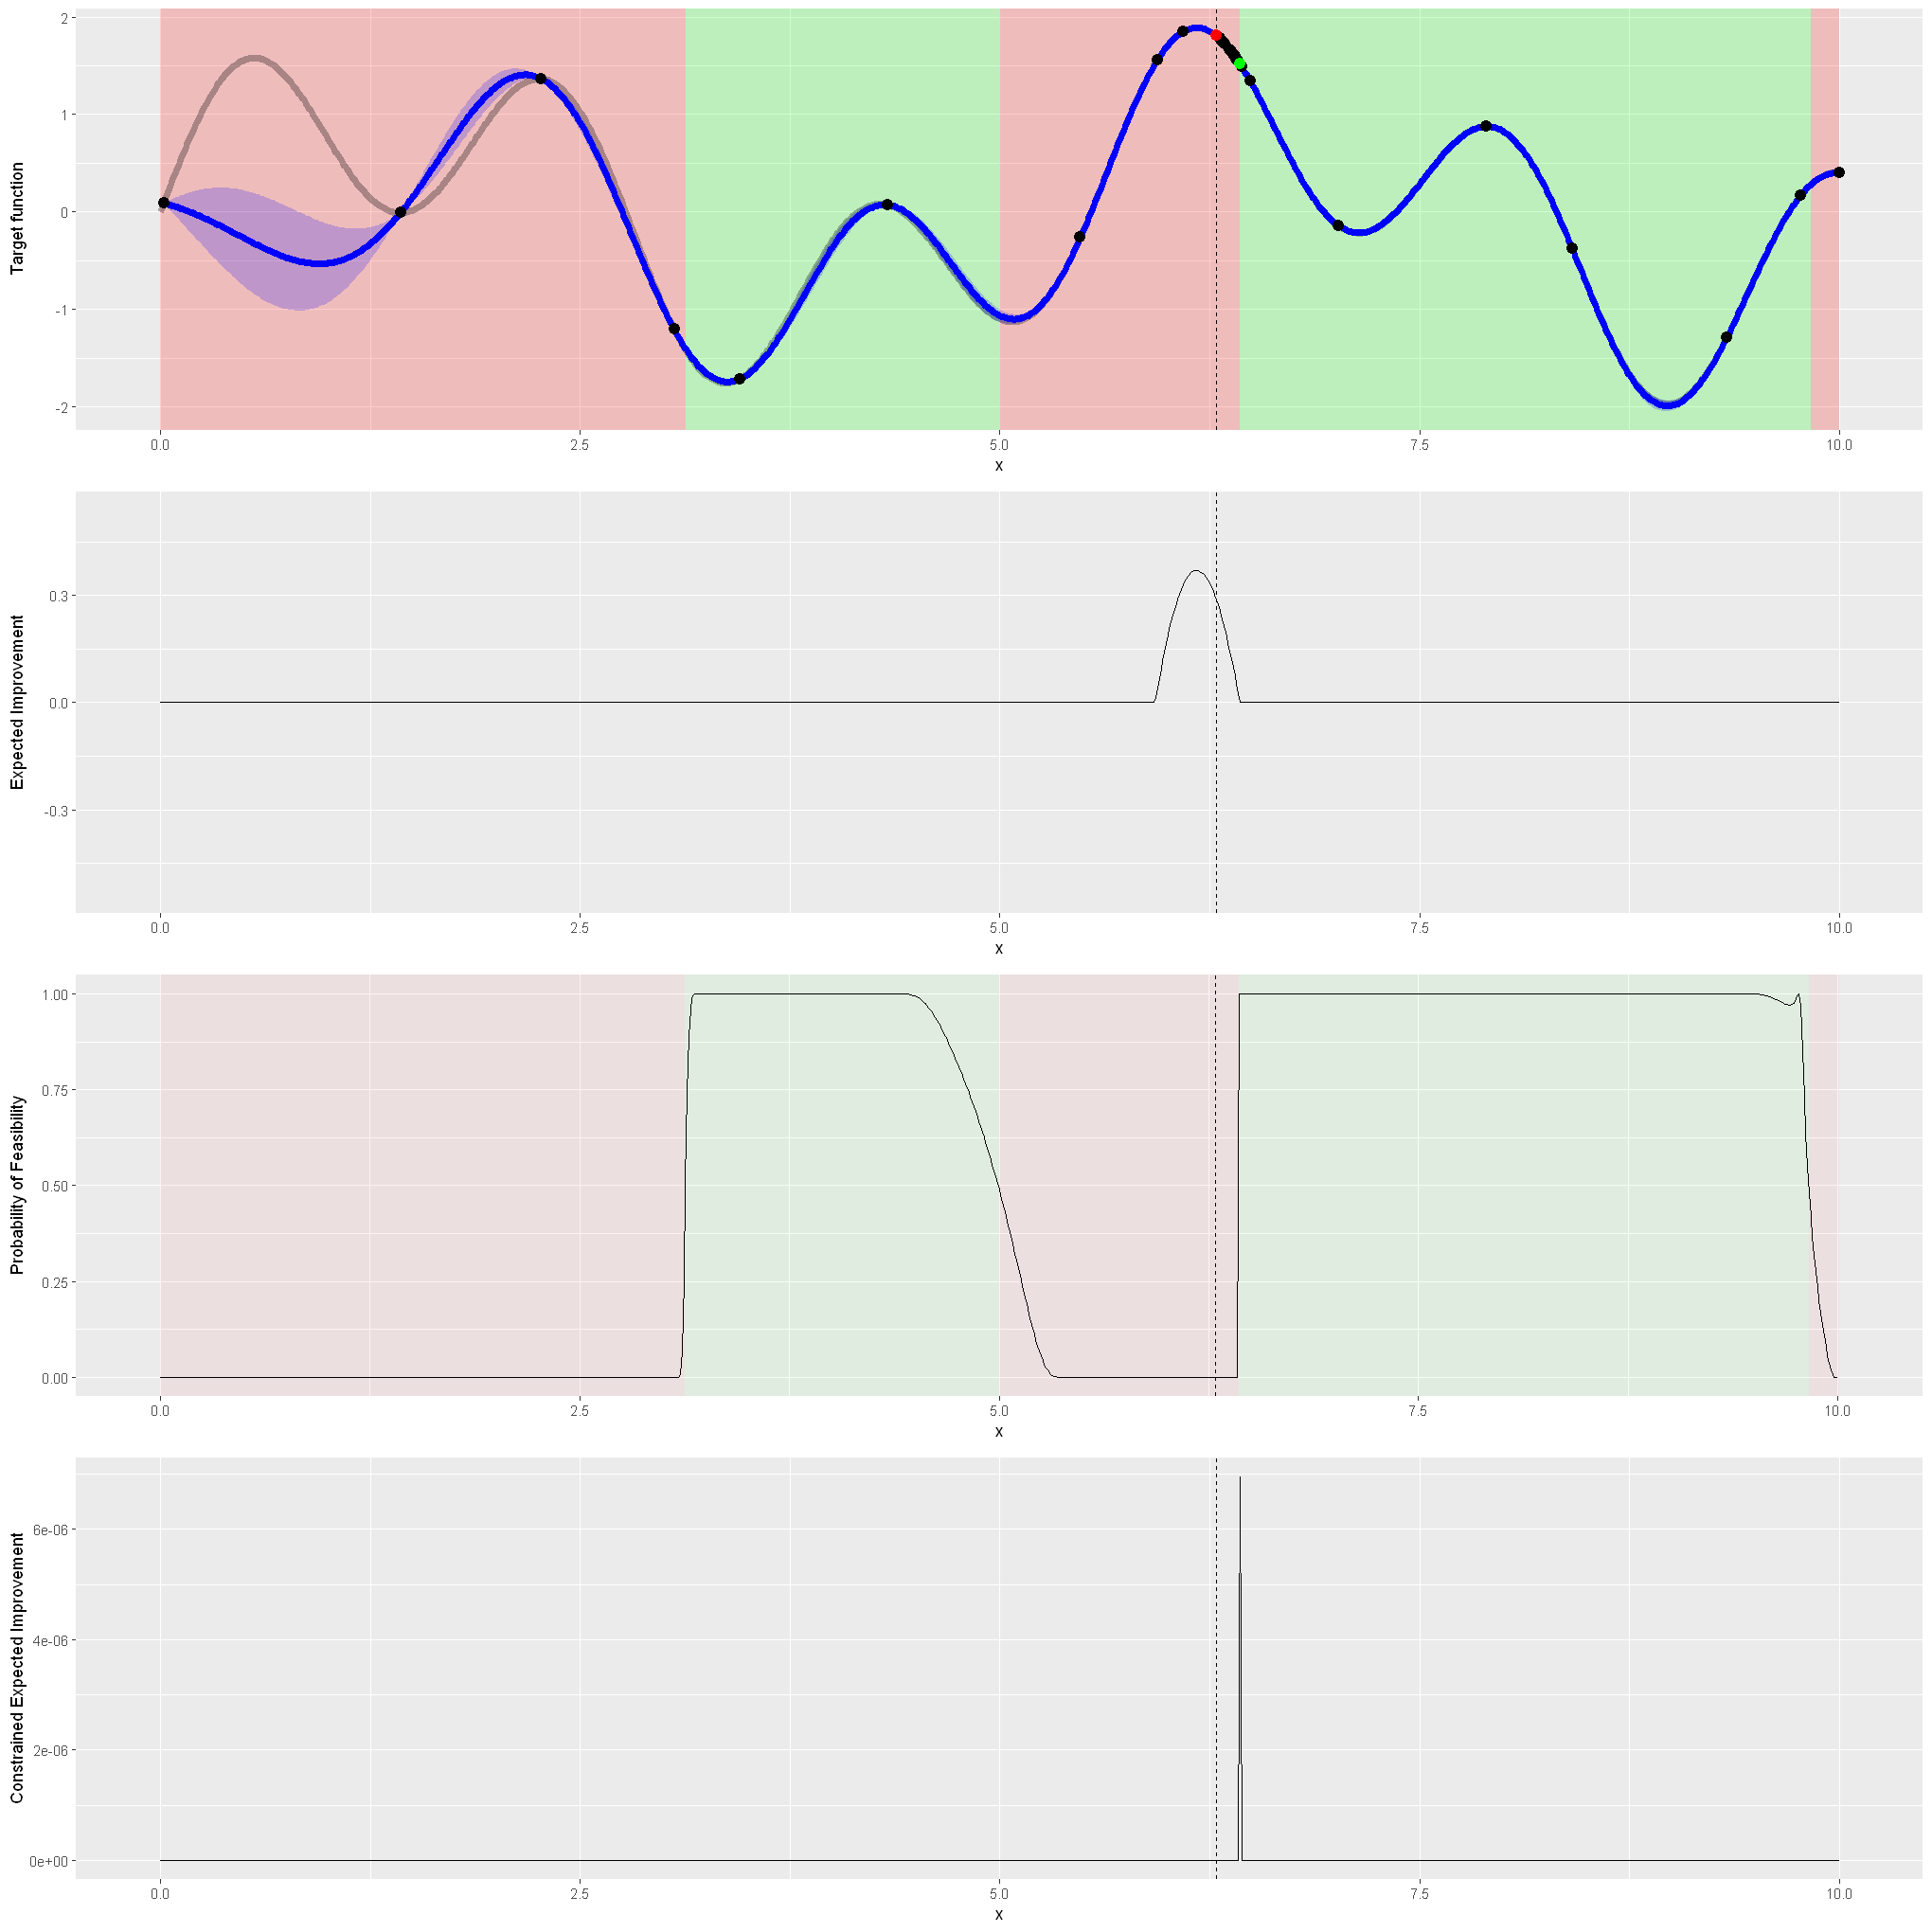

Iteration 30 


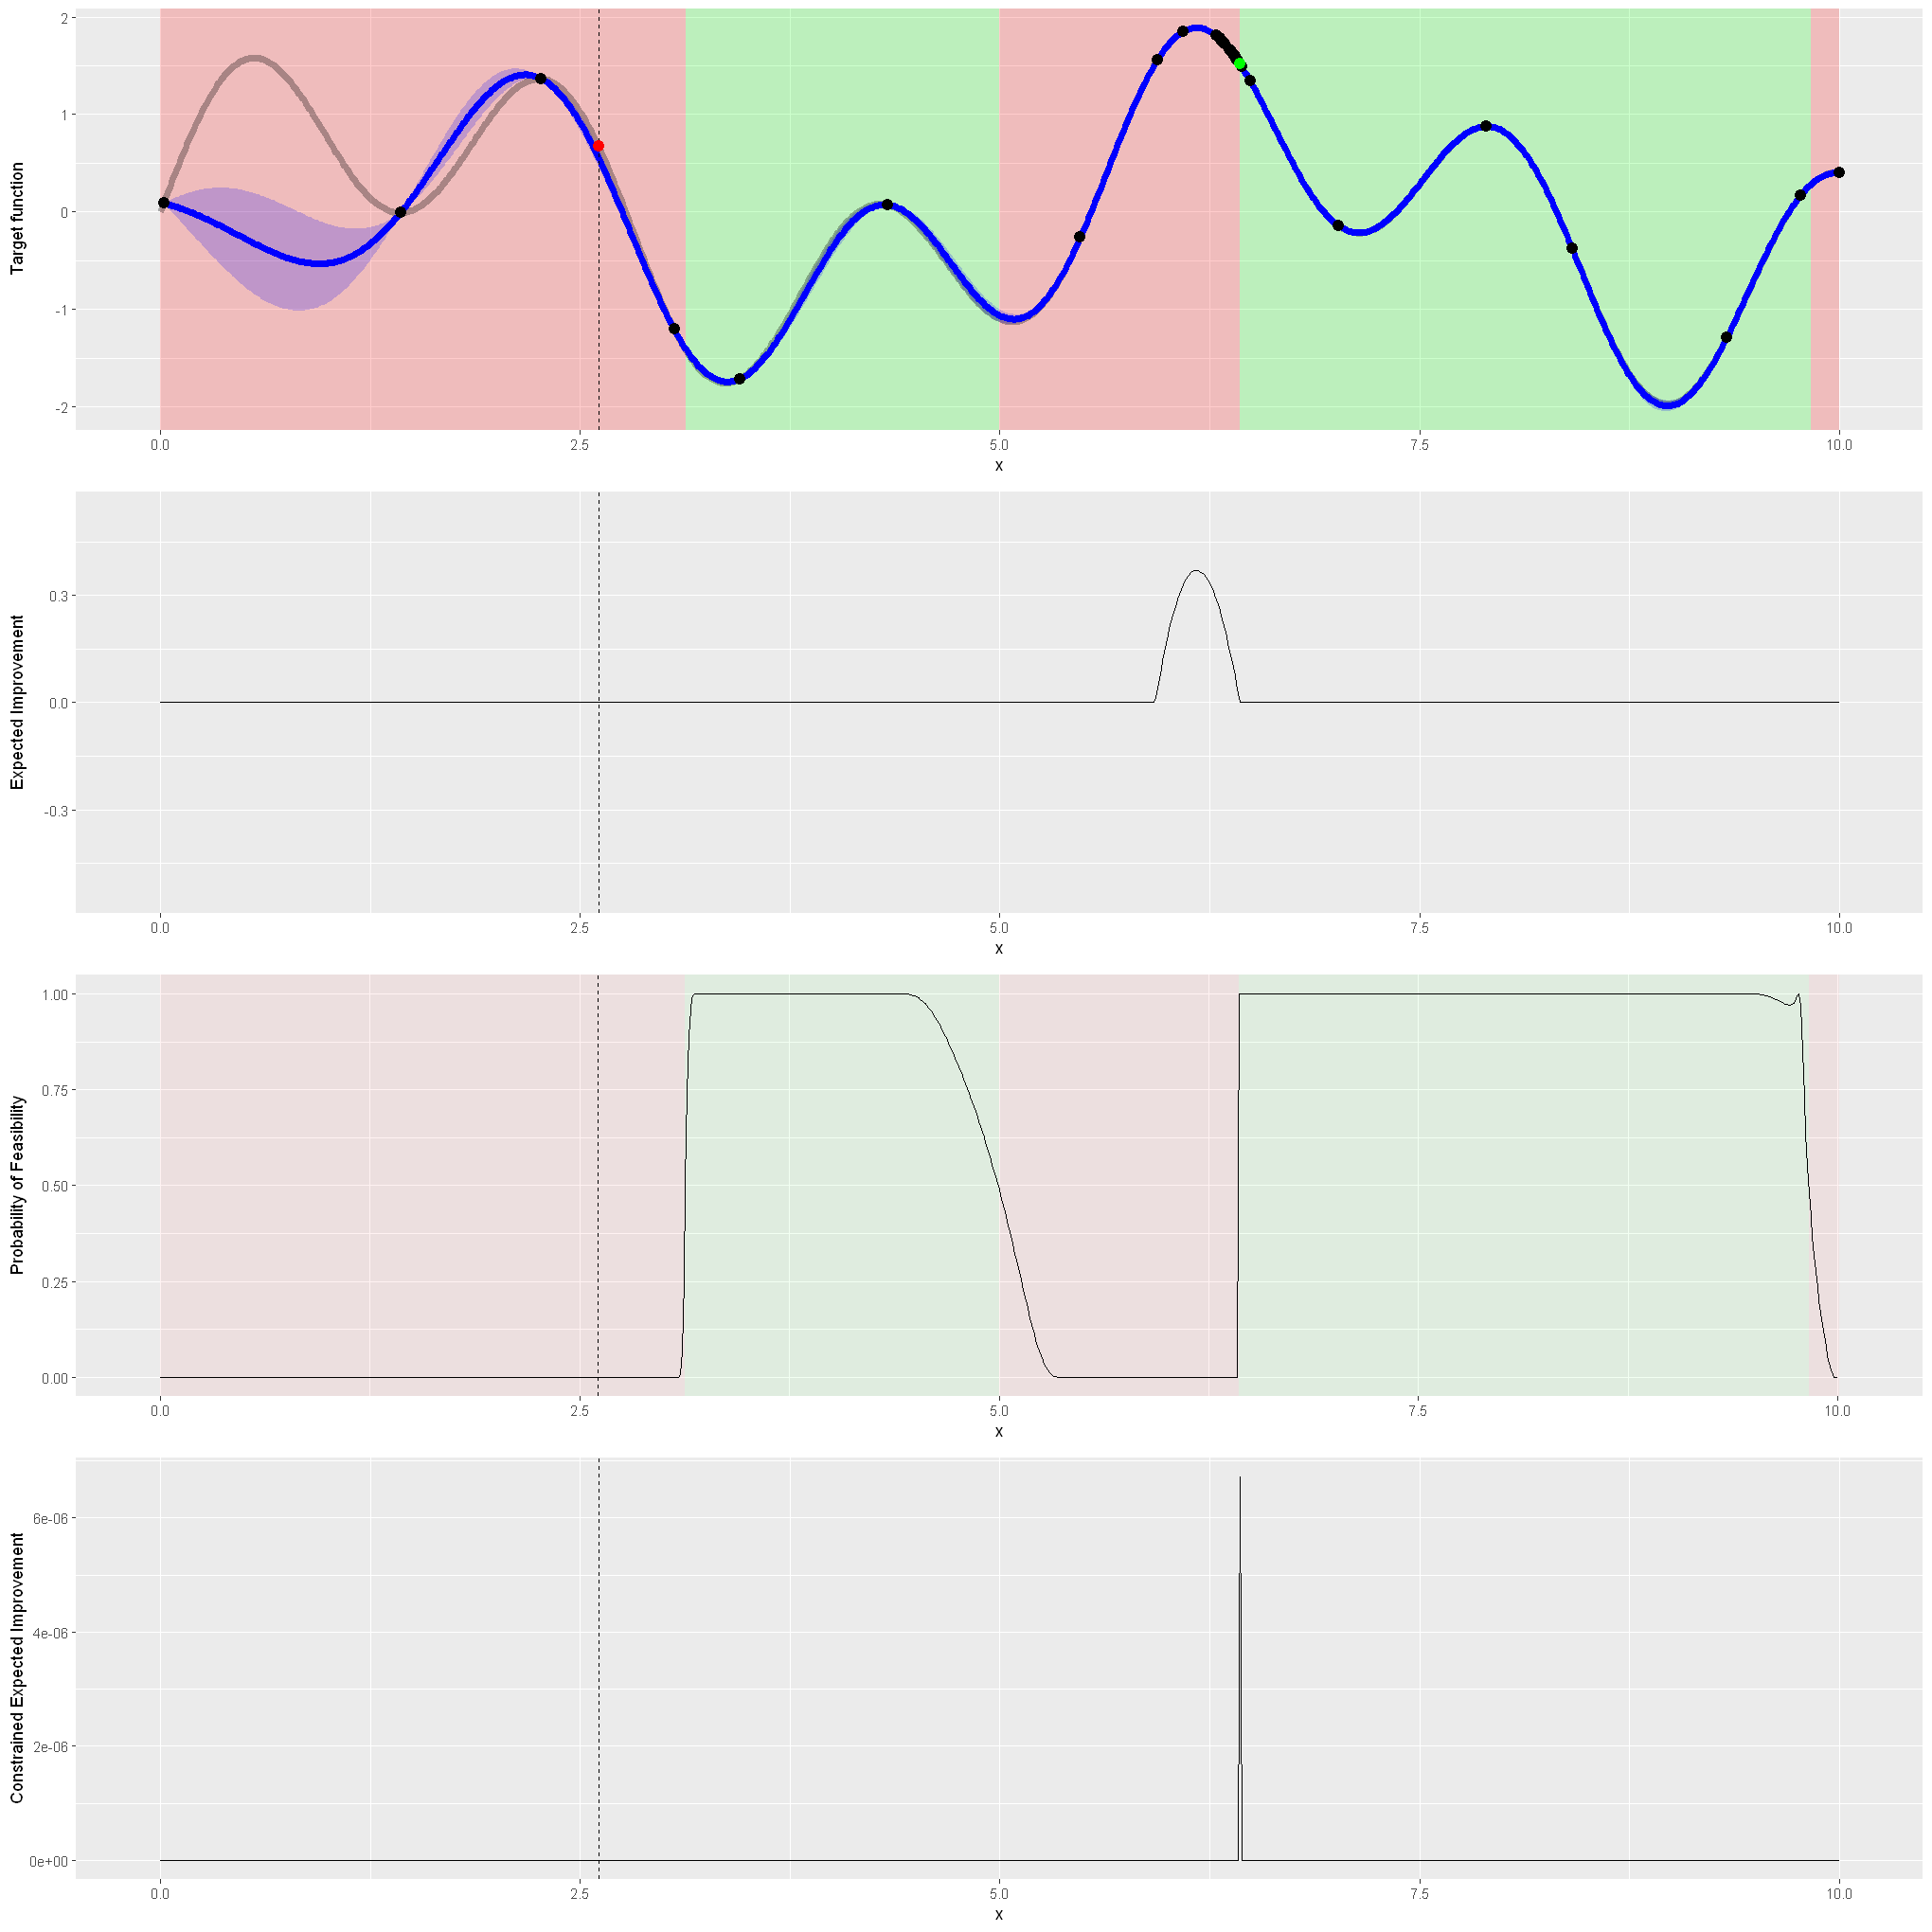

Iteration 31 


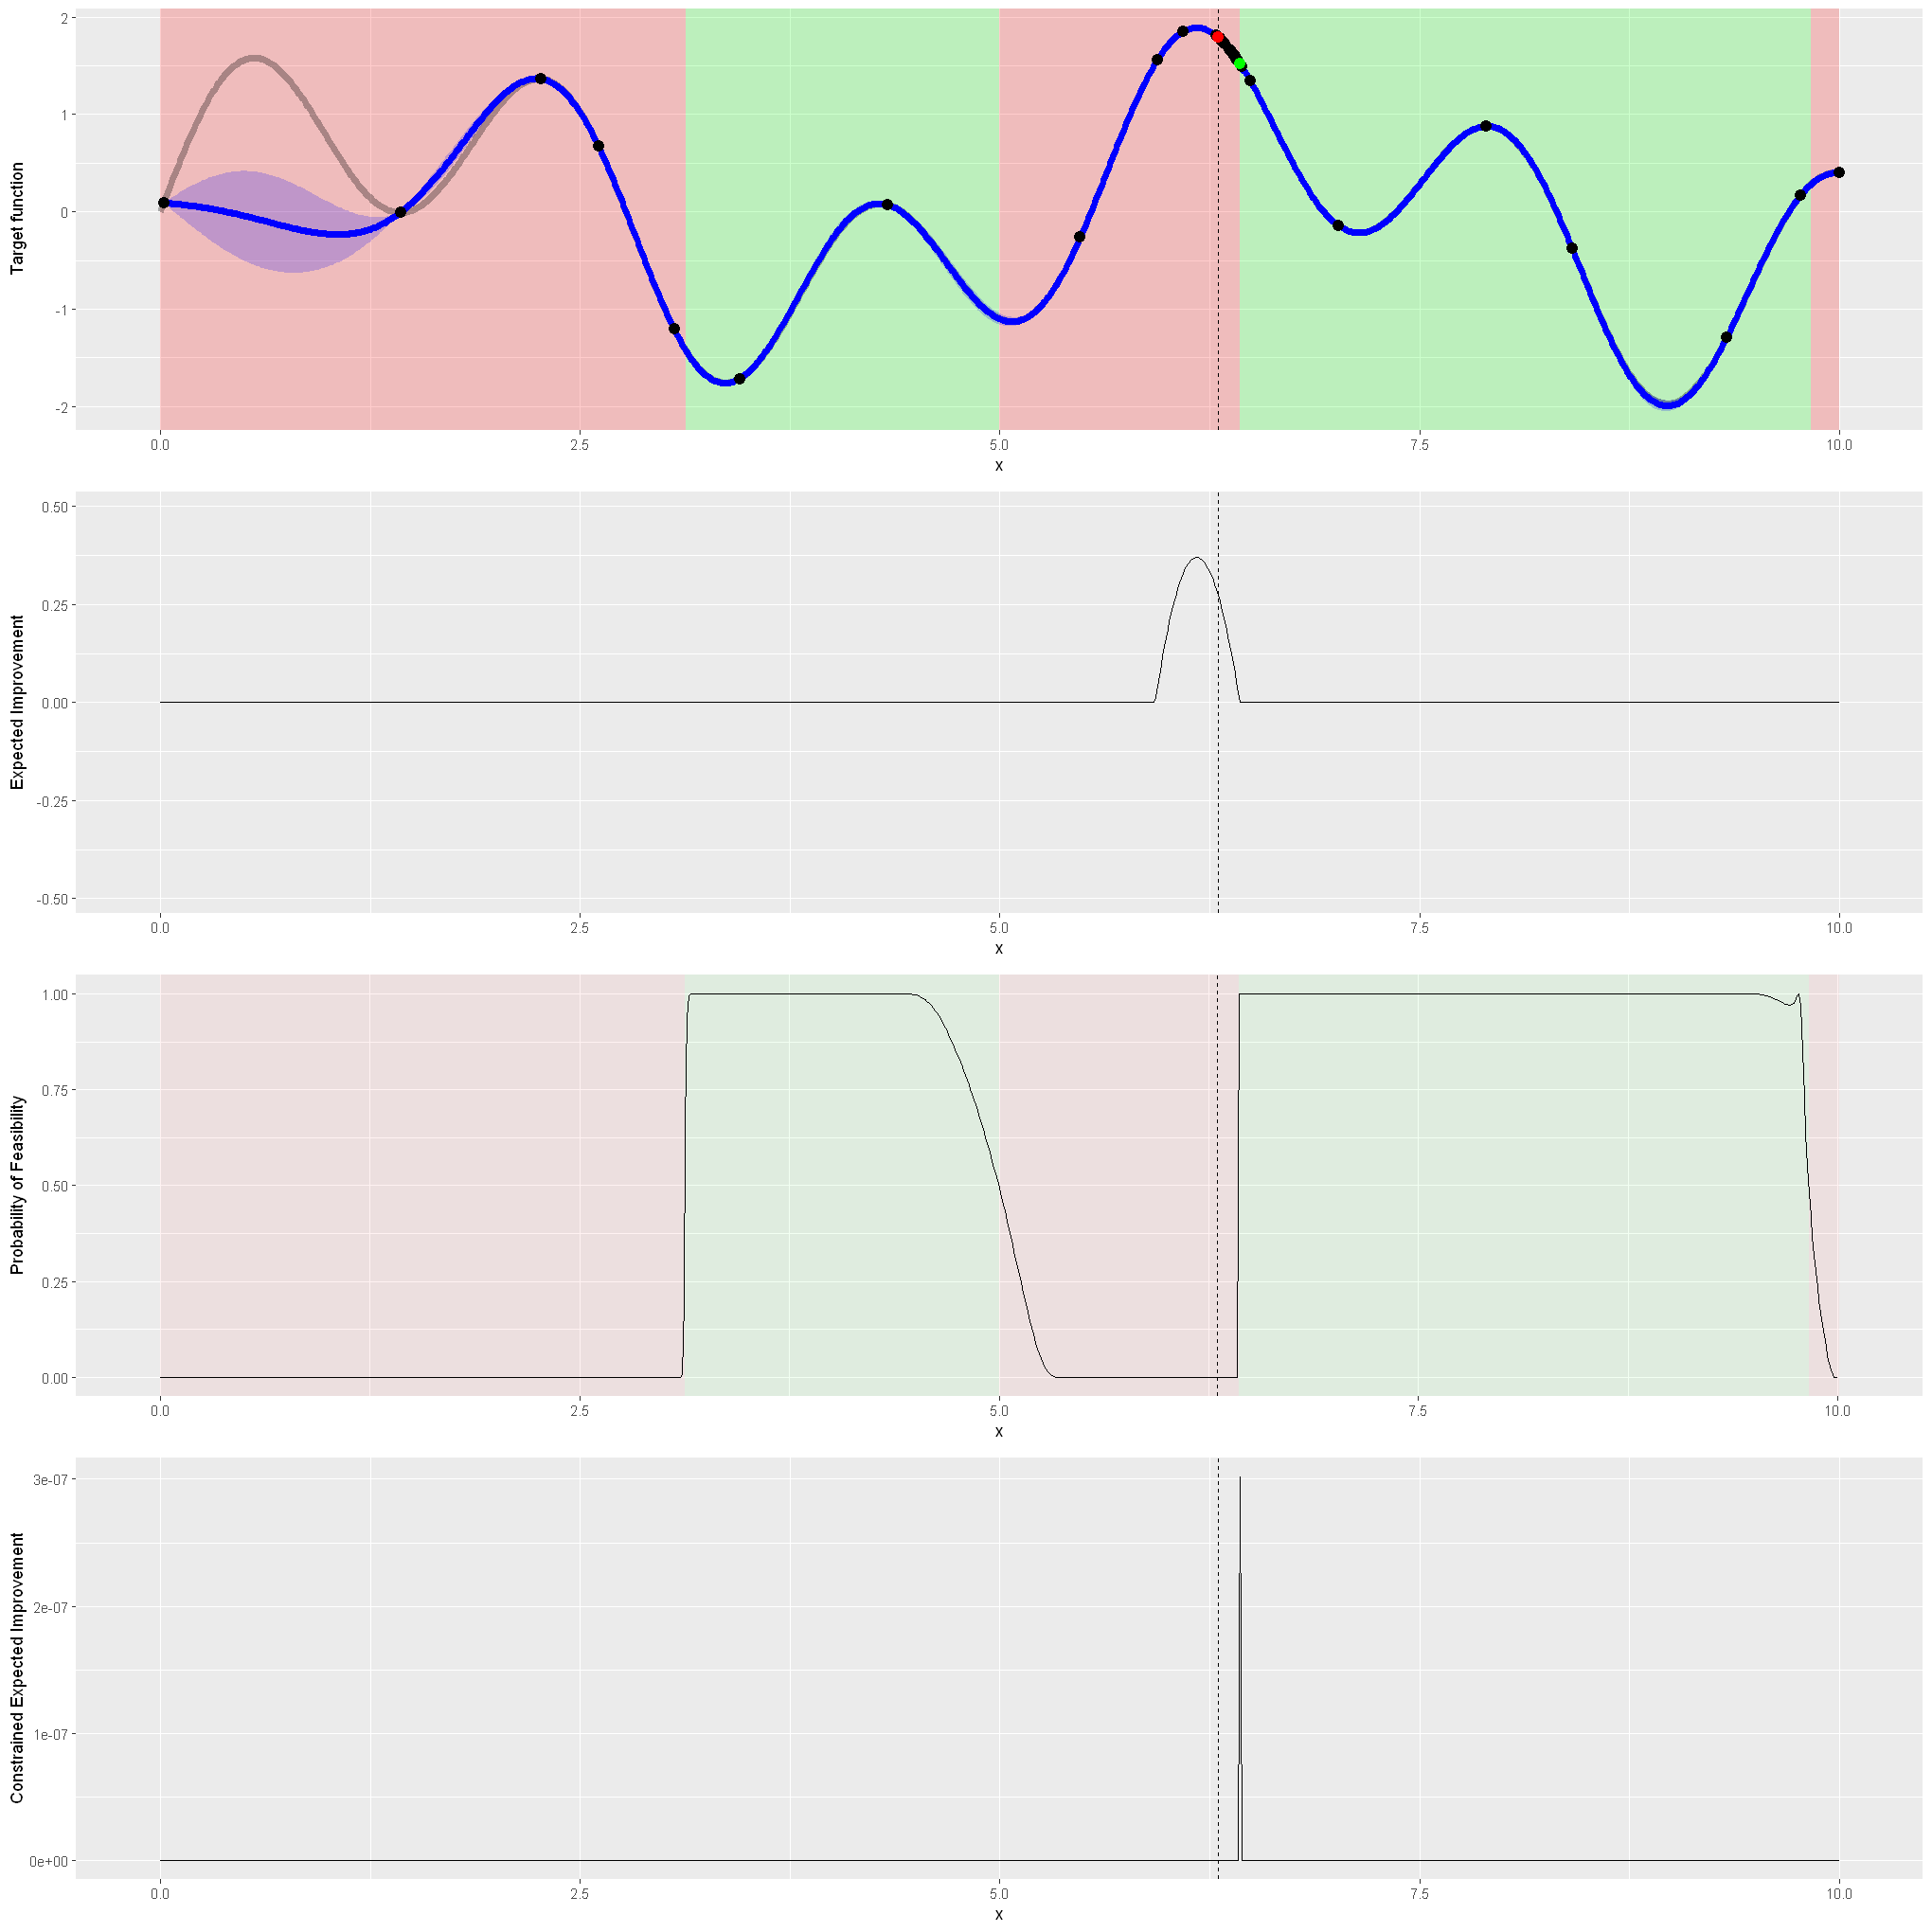

Iteration 32 


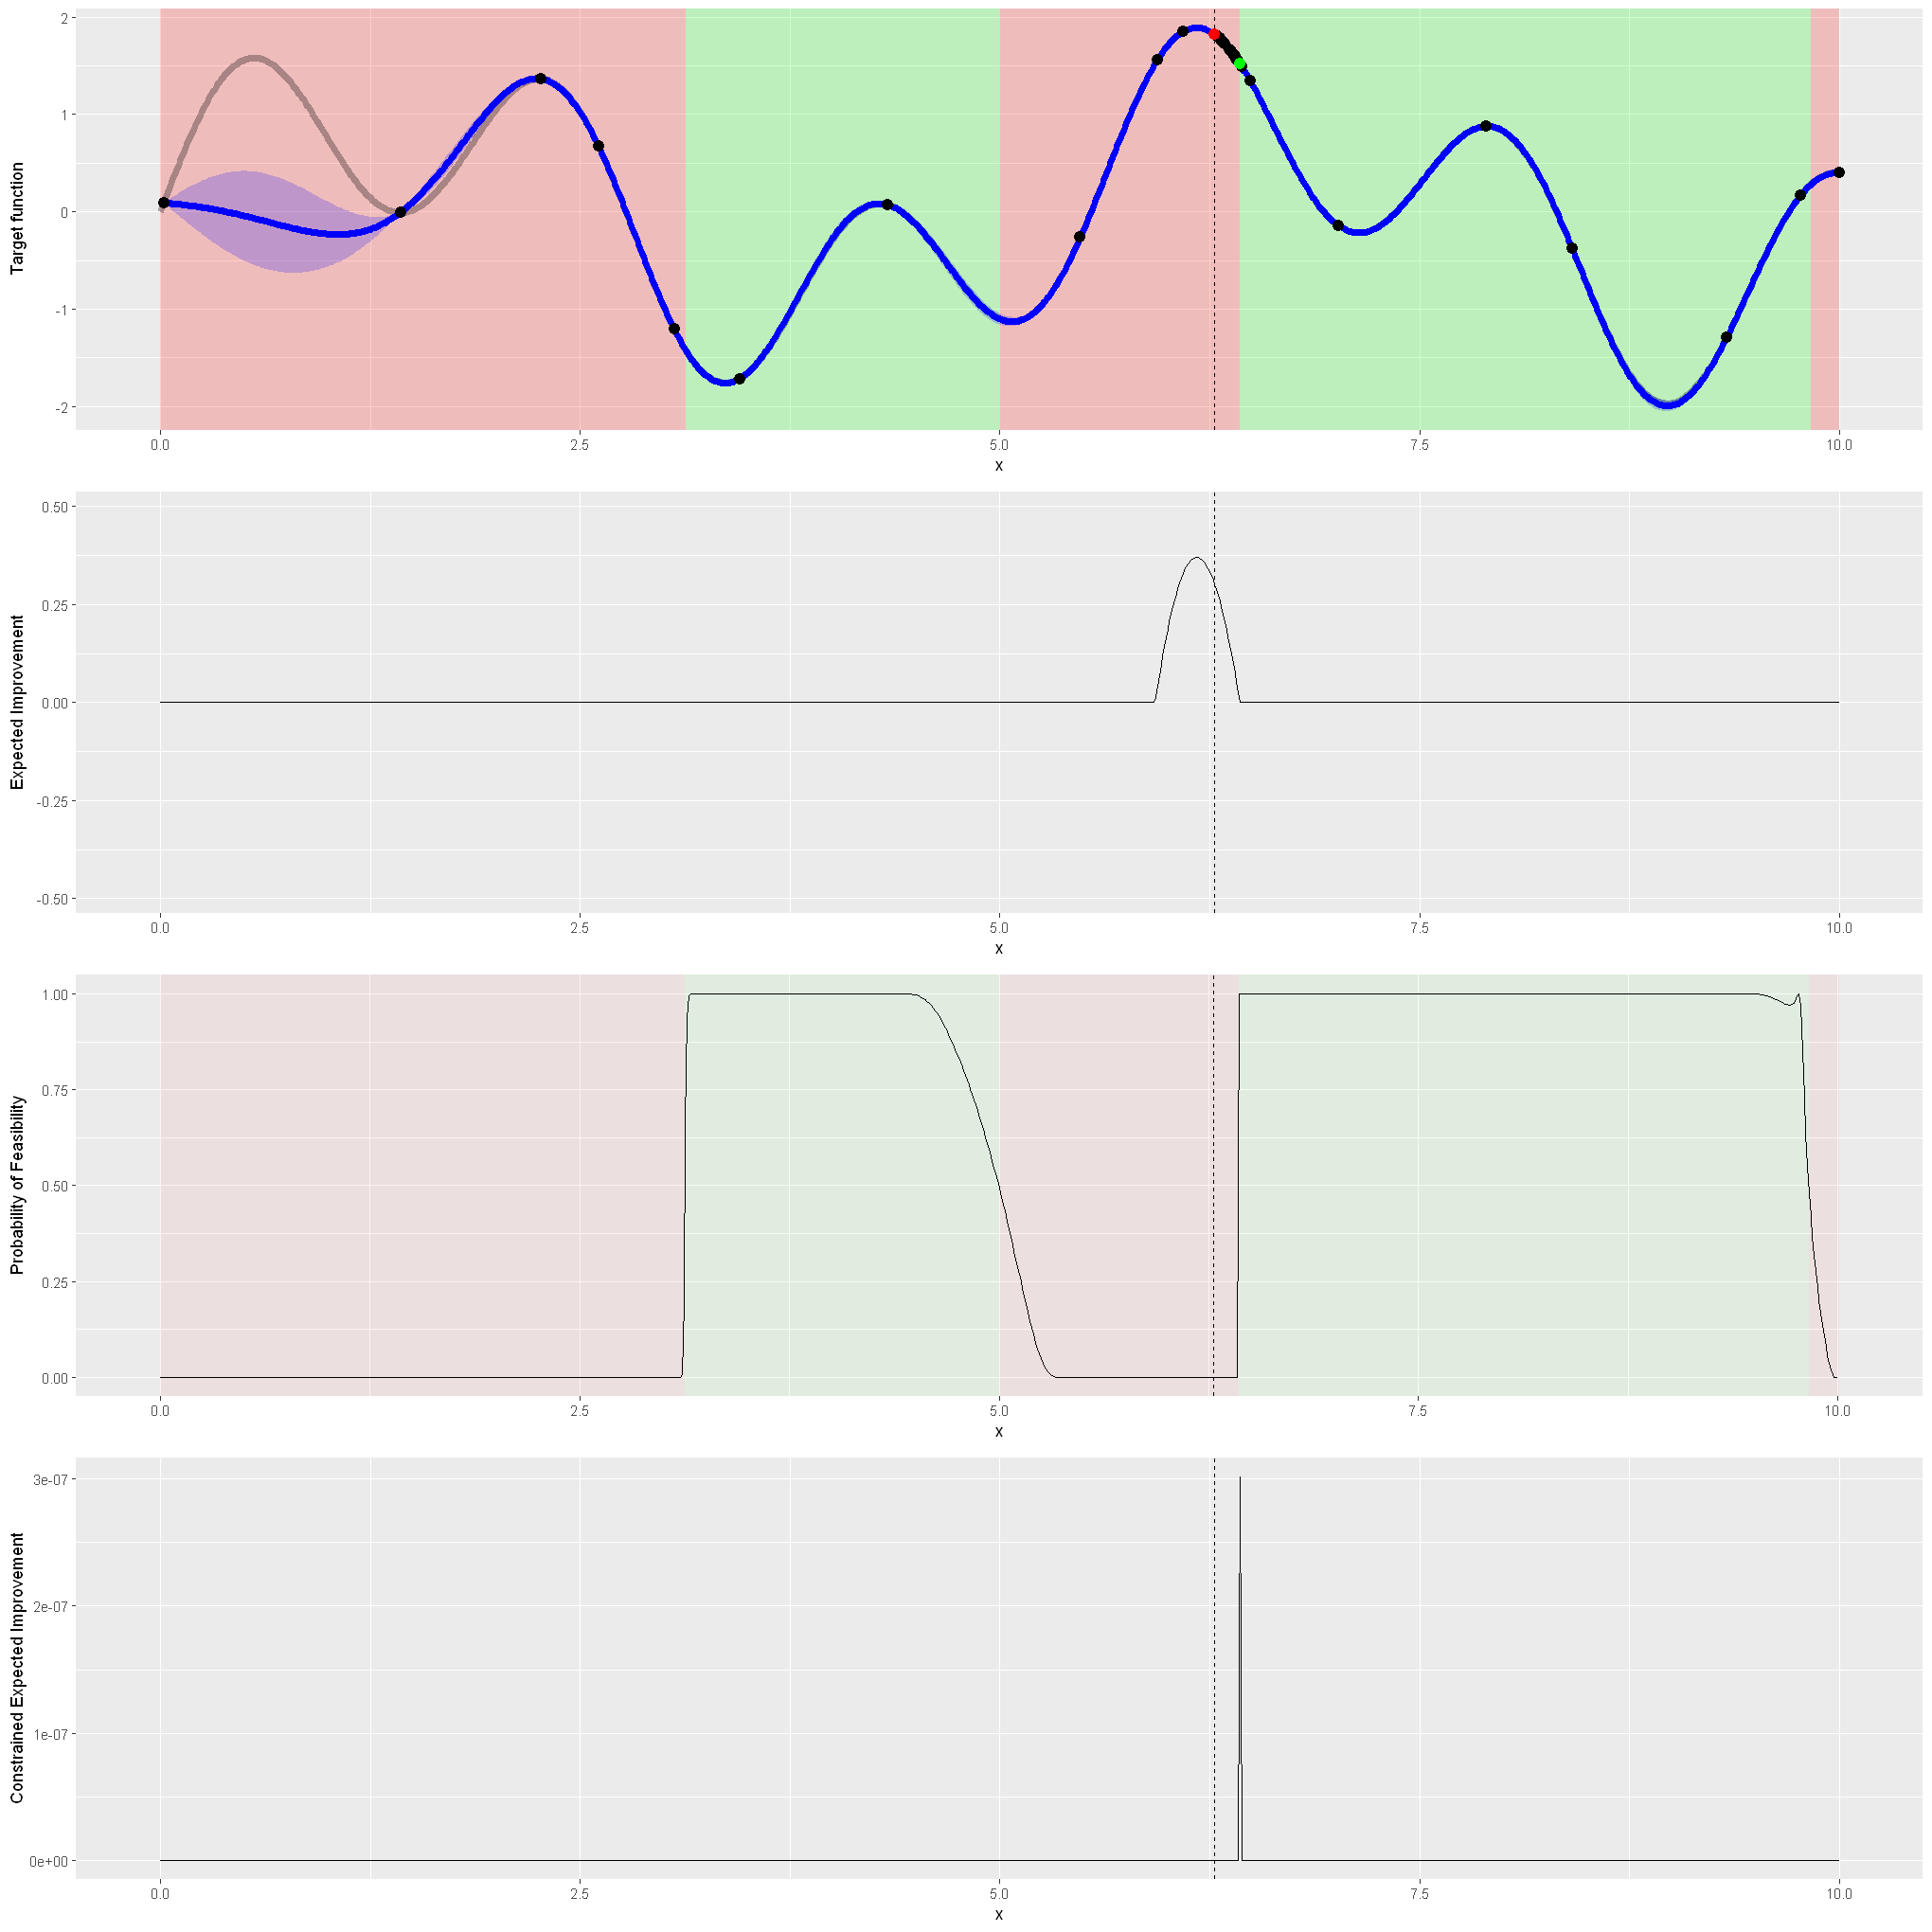

Iteration 33 


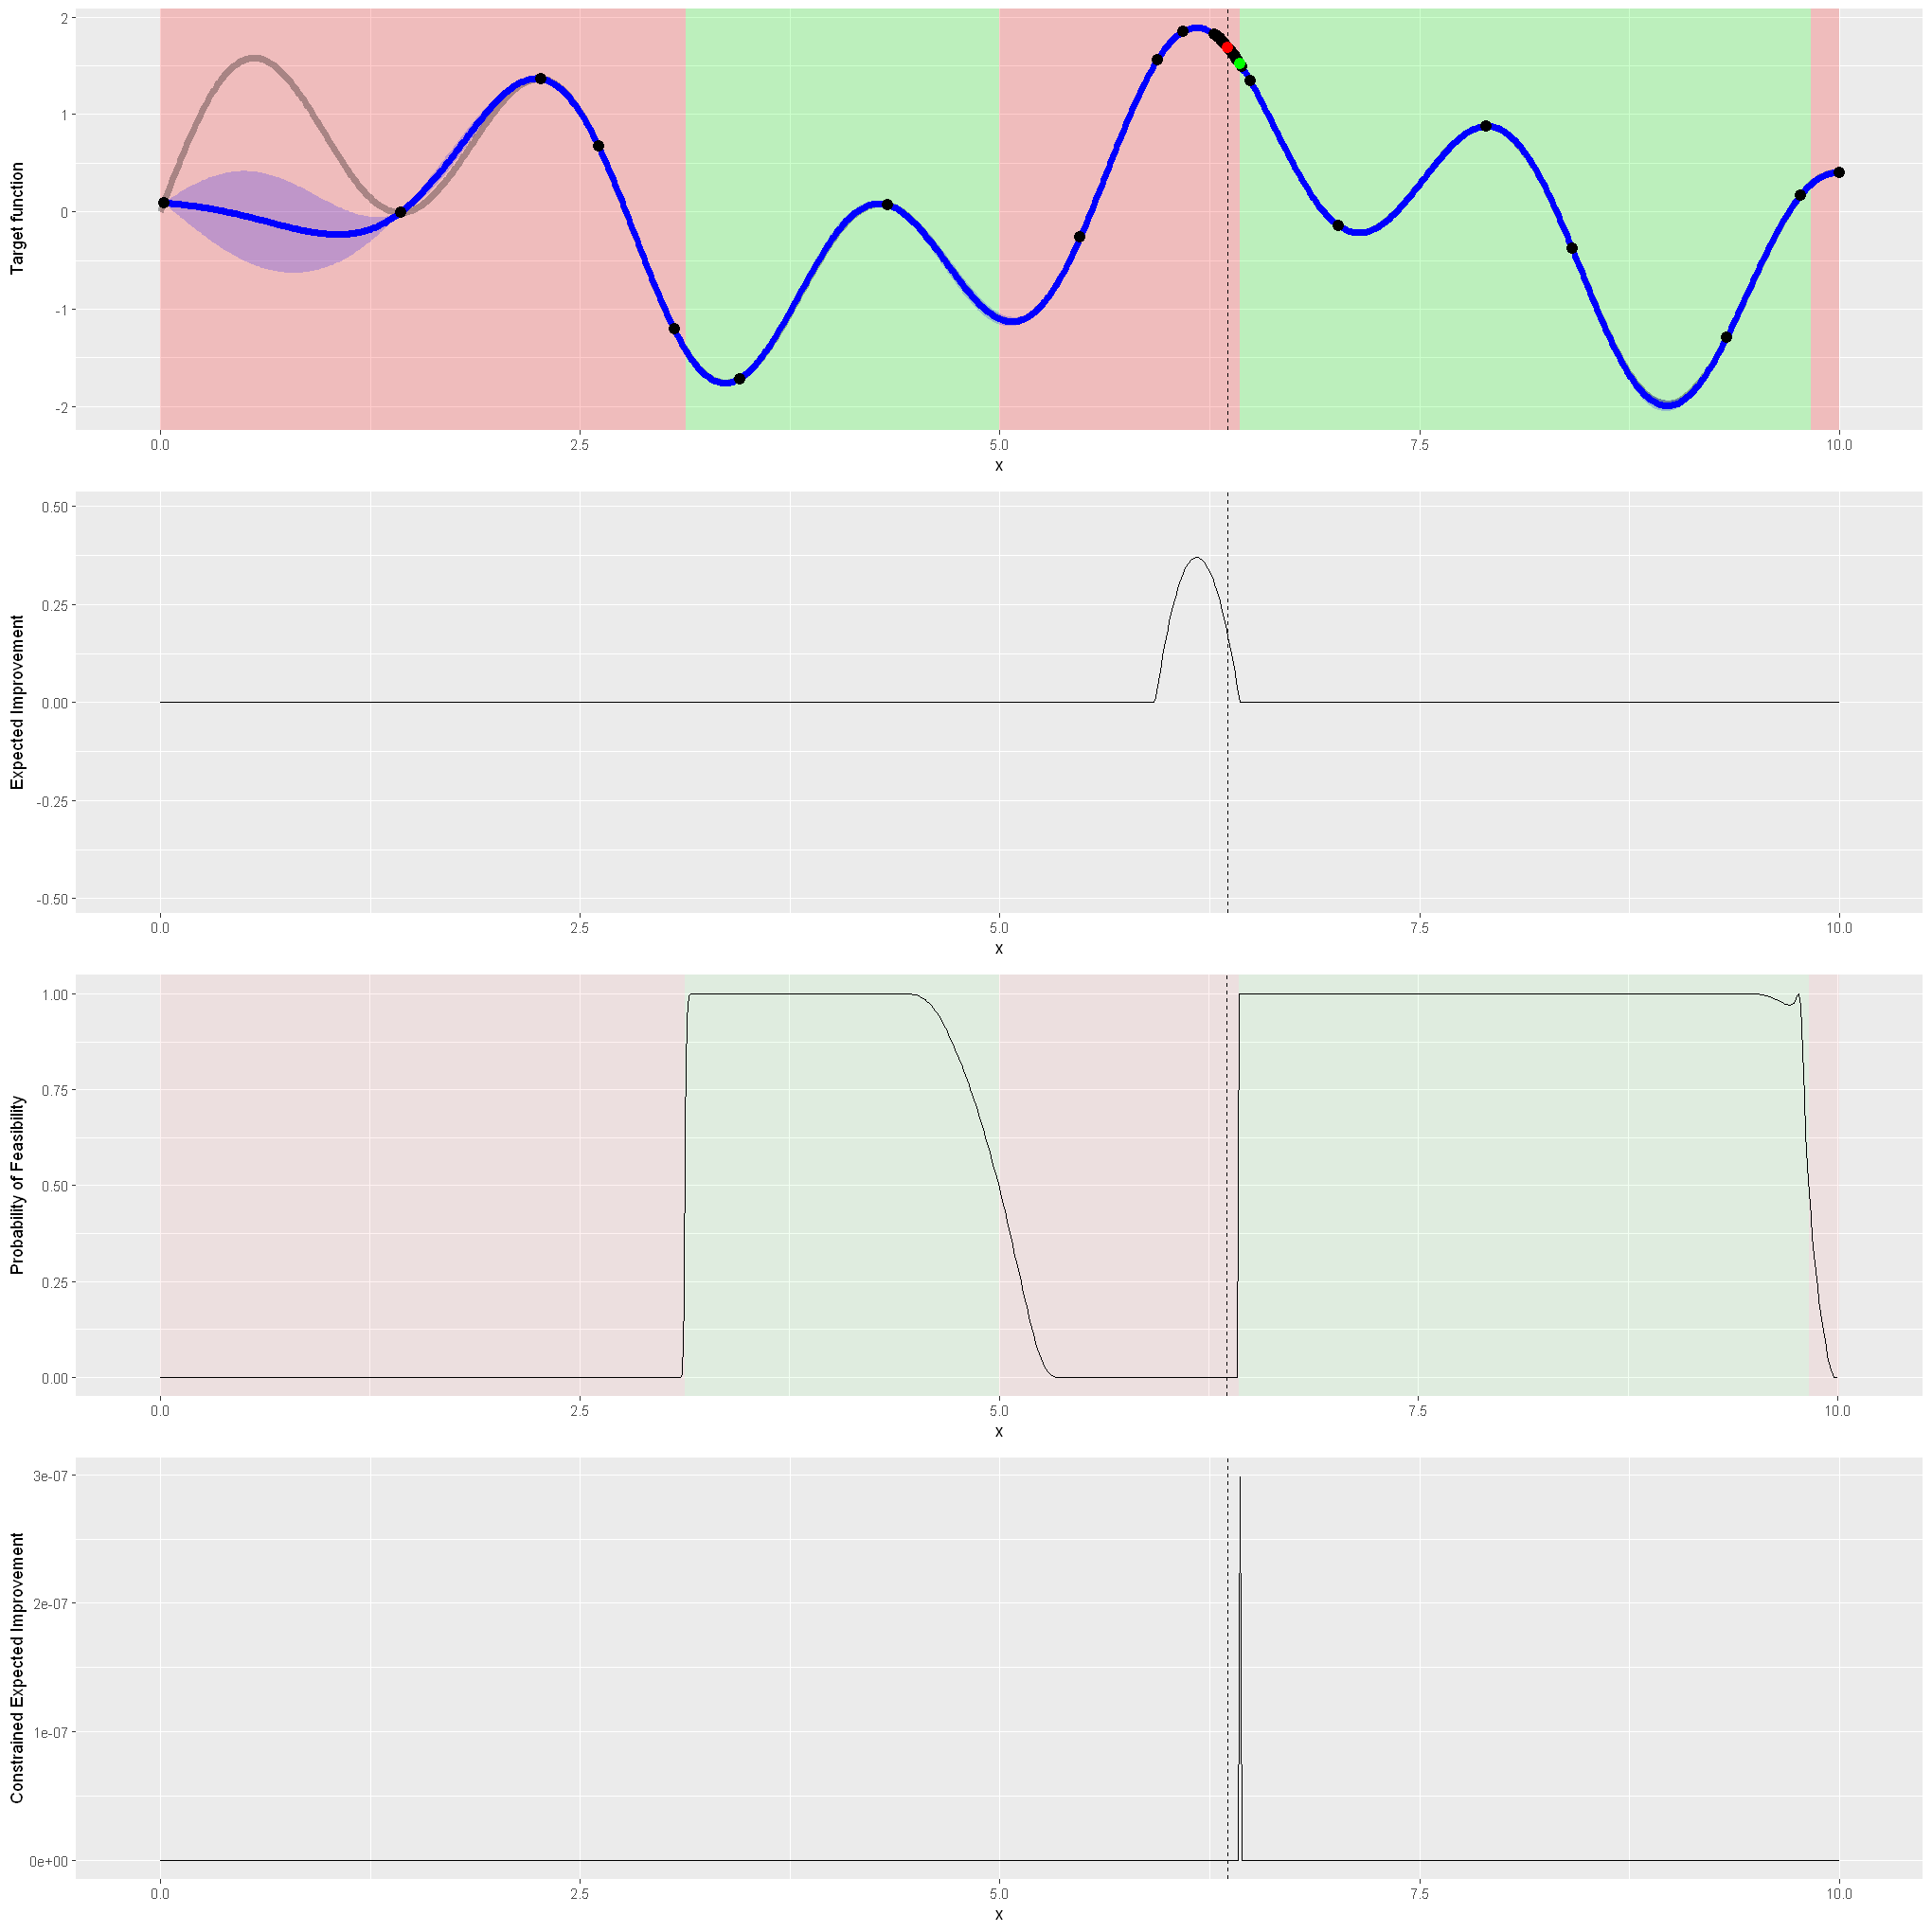

Iteration 34 


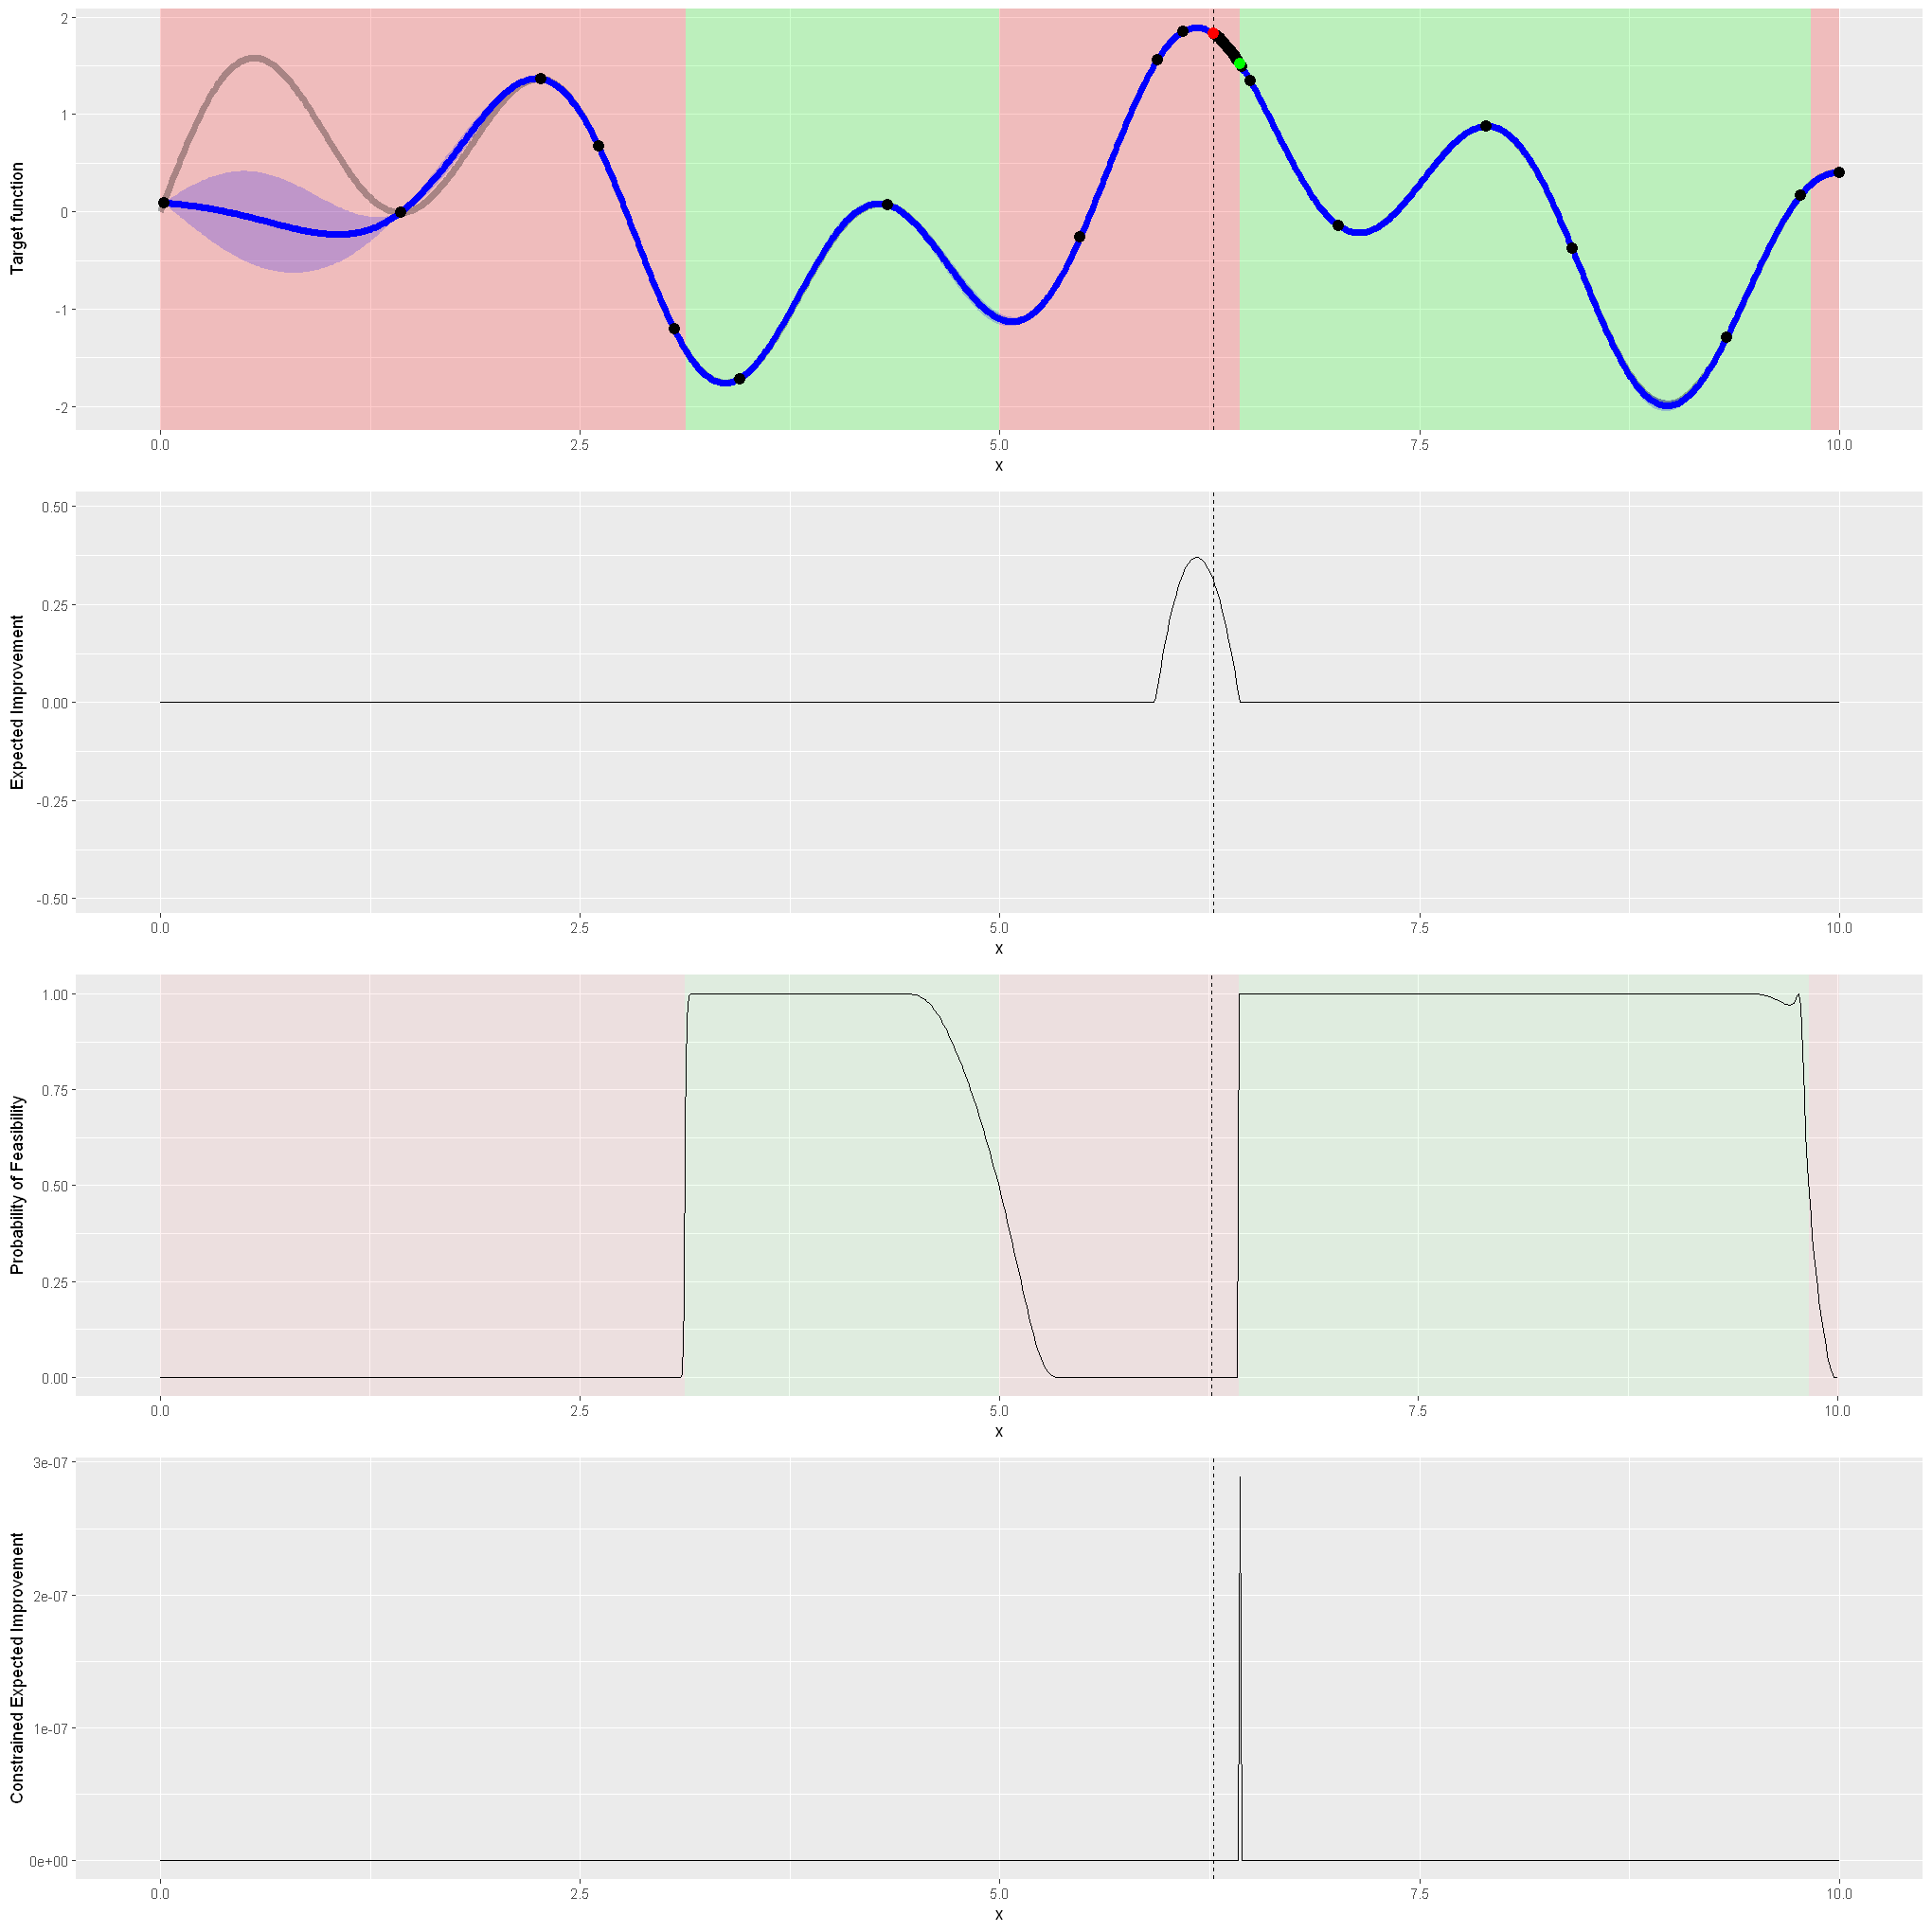

Iteration 35 


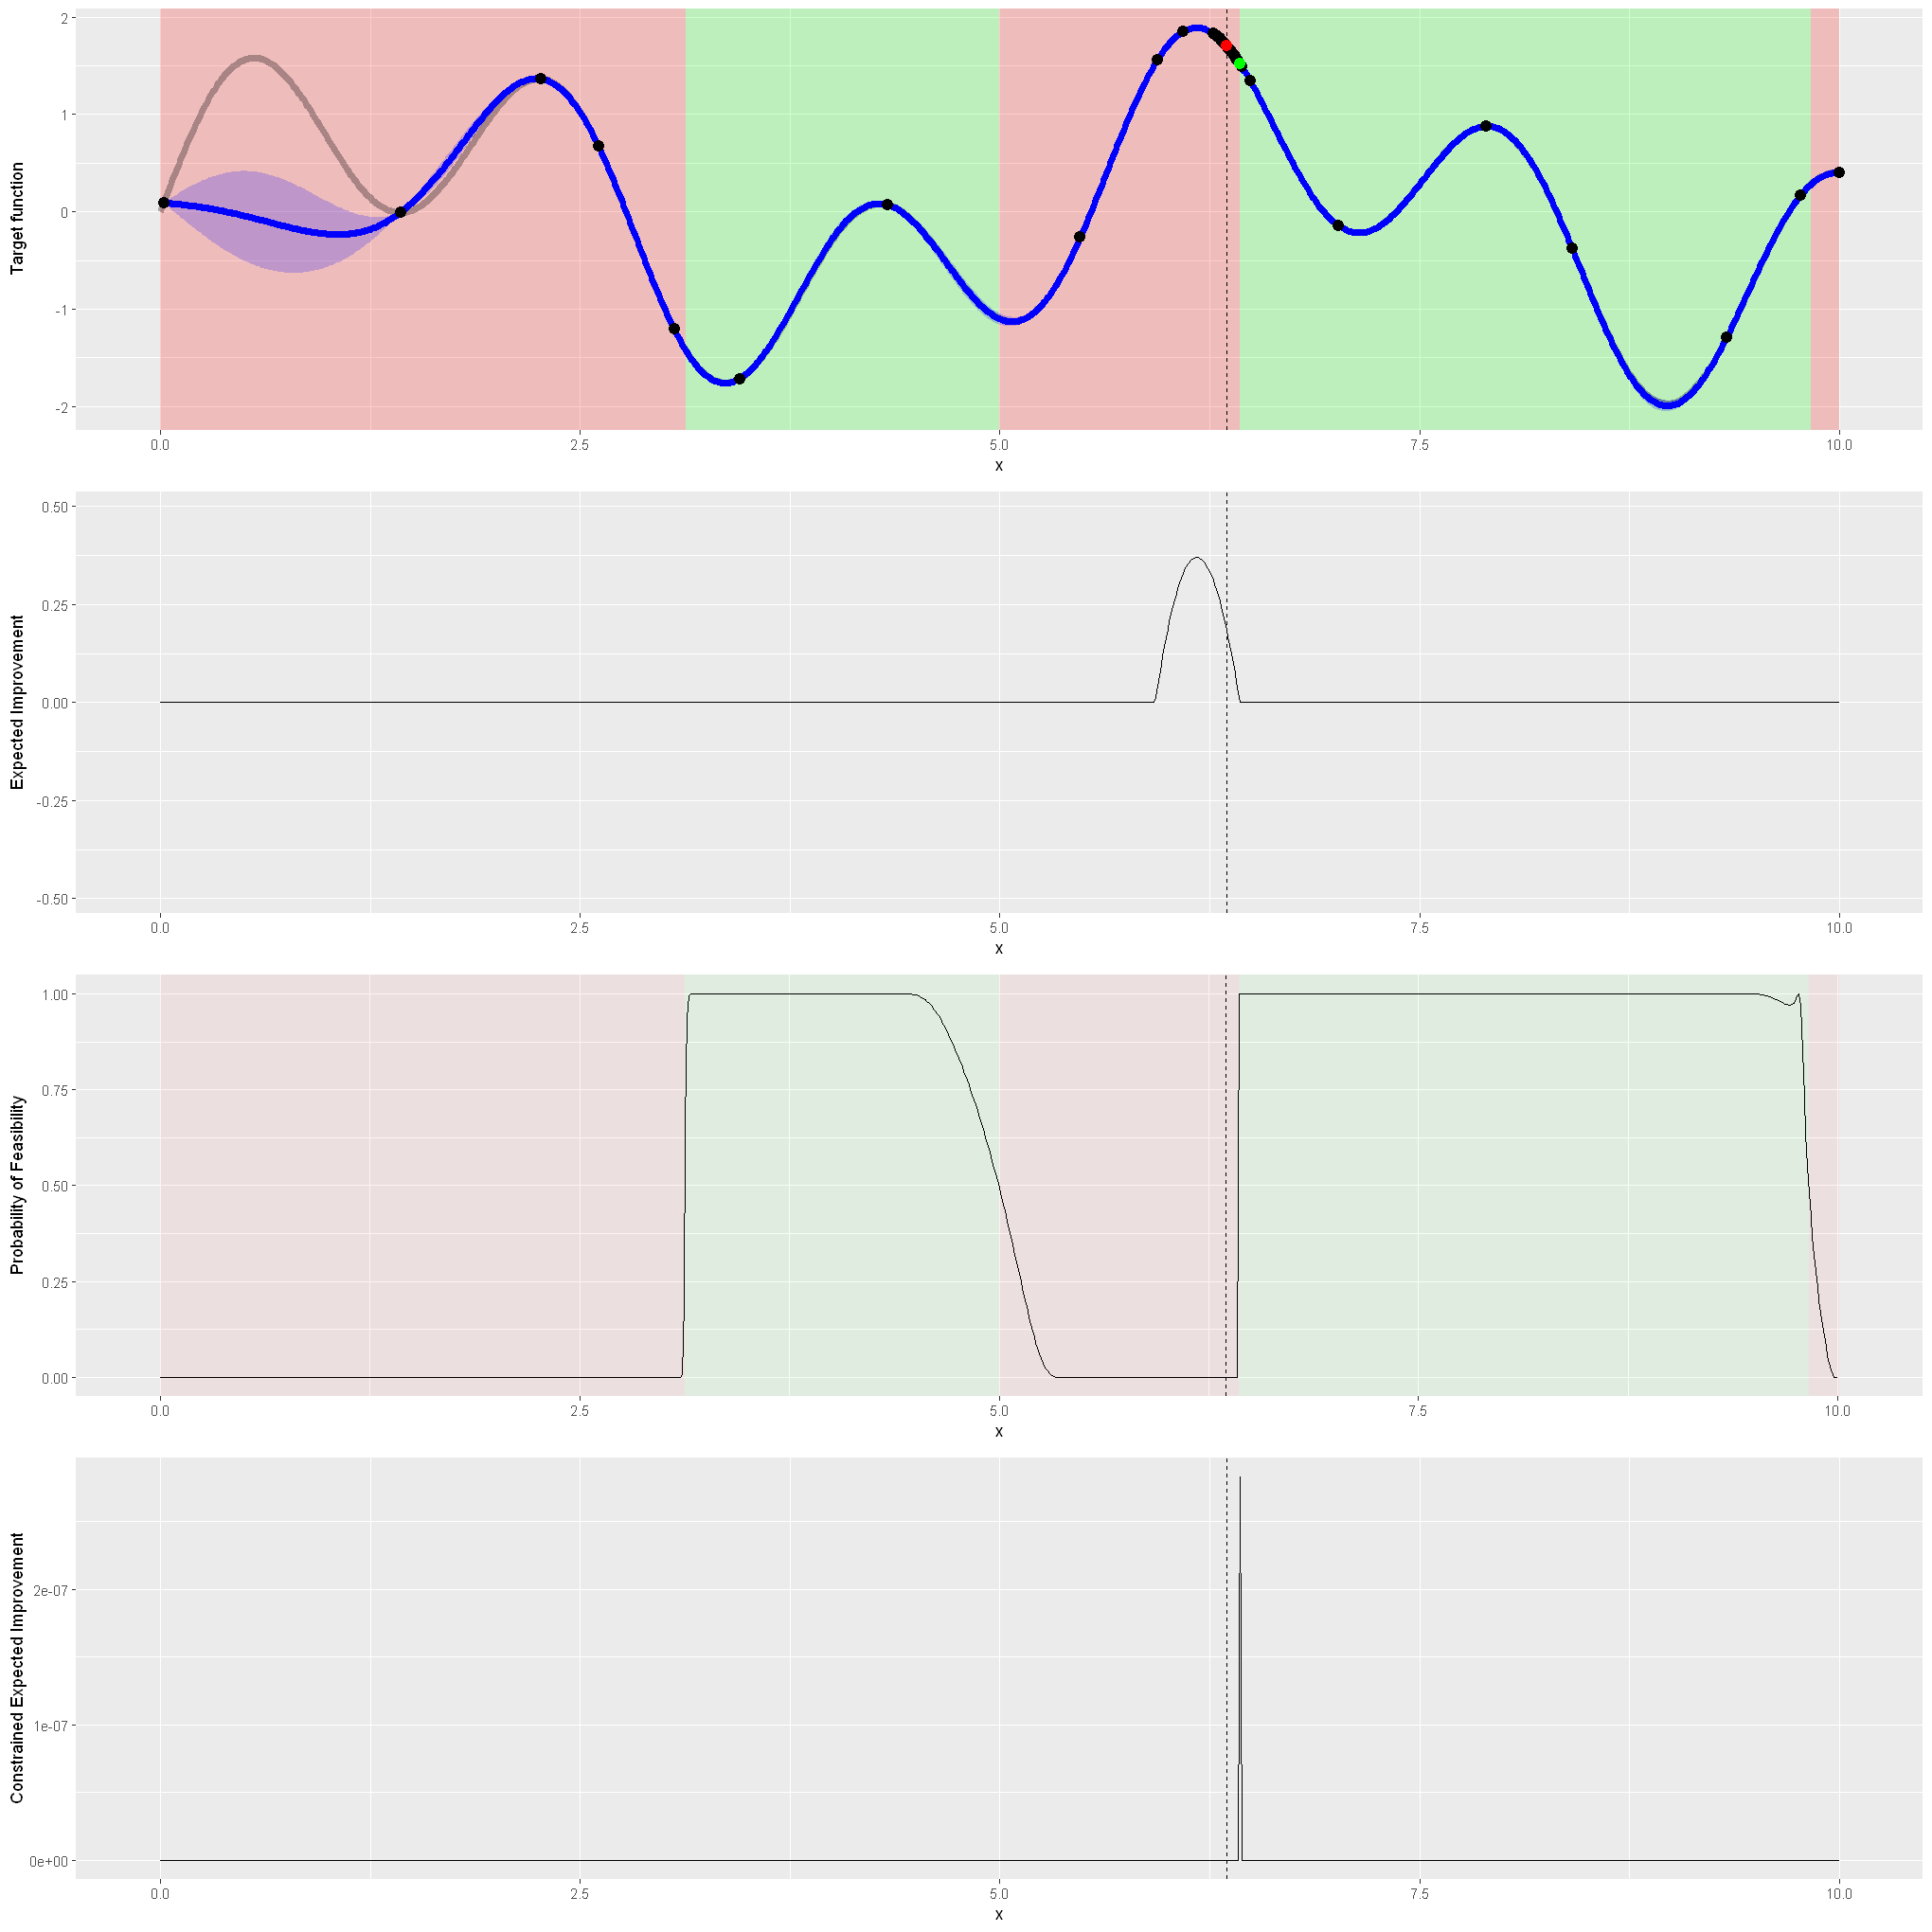

Iteration 36 


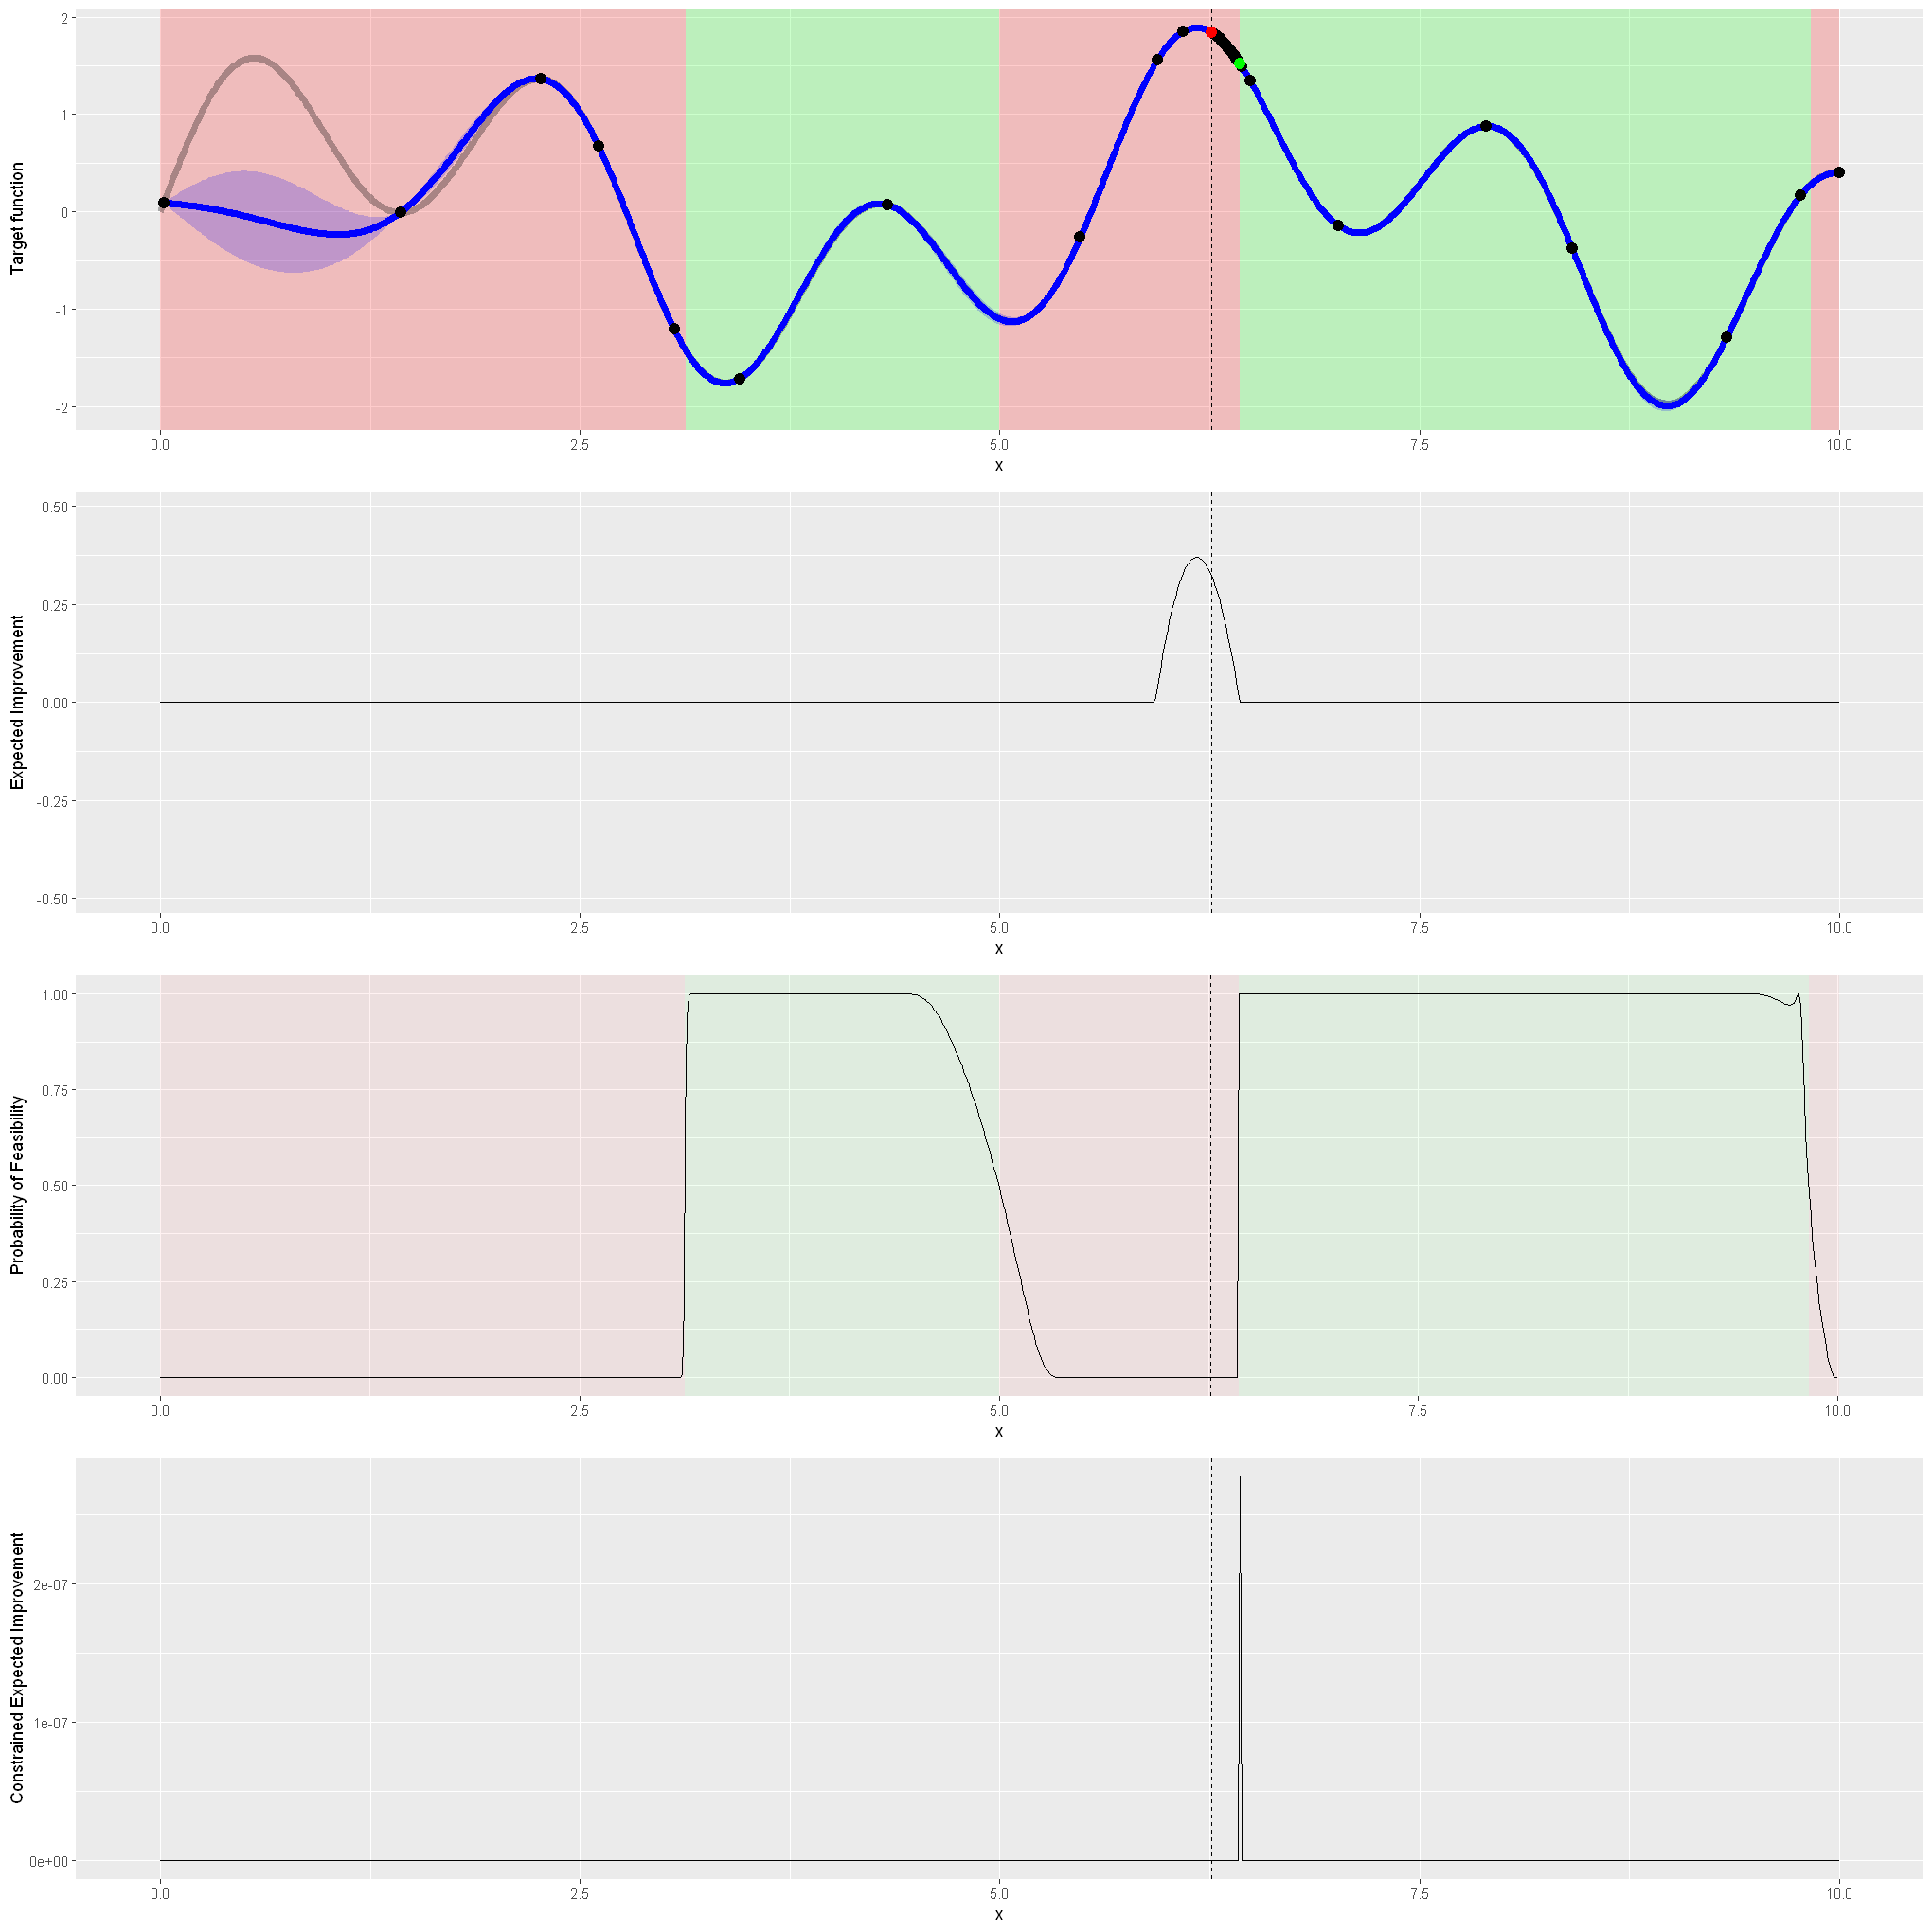

Iteration 37 


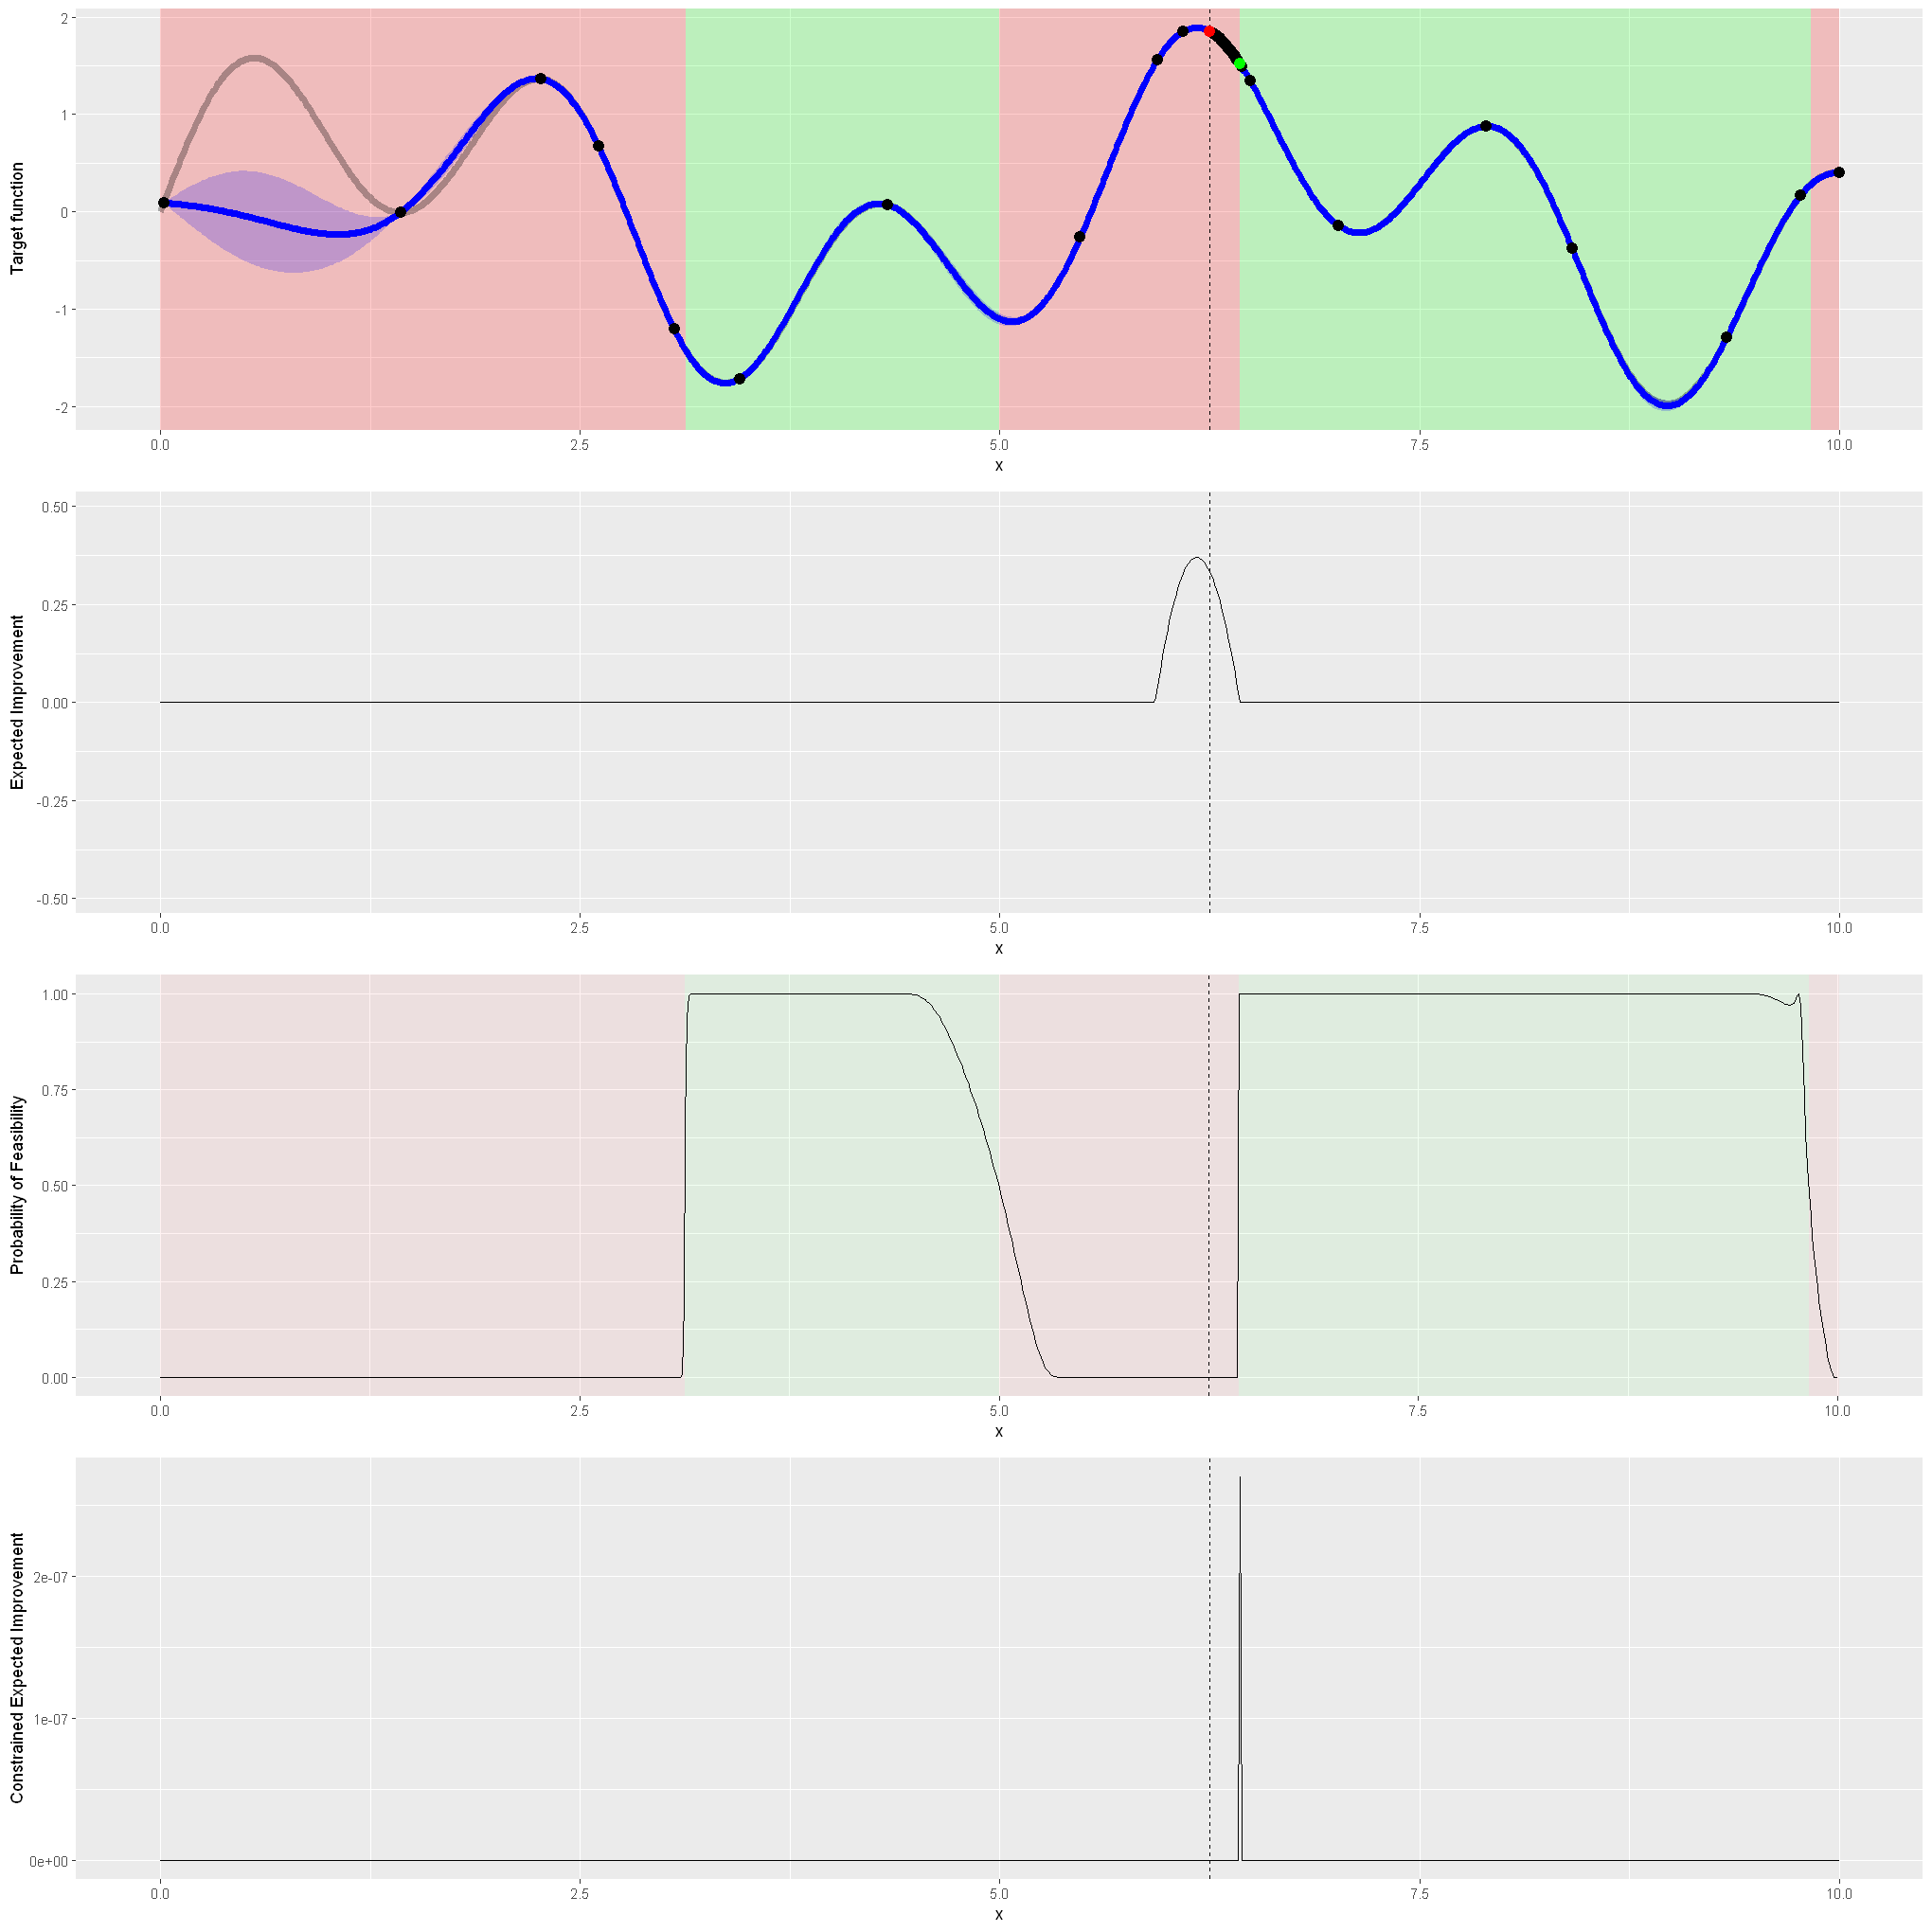

Iteration 38 


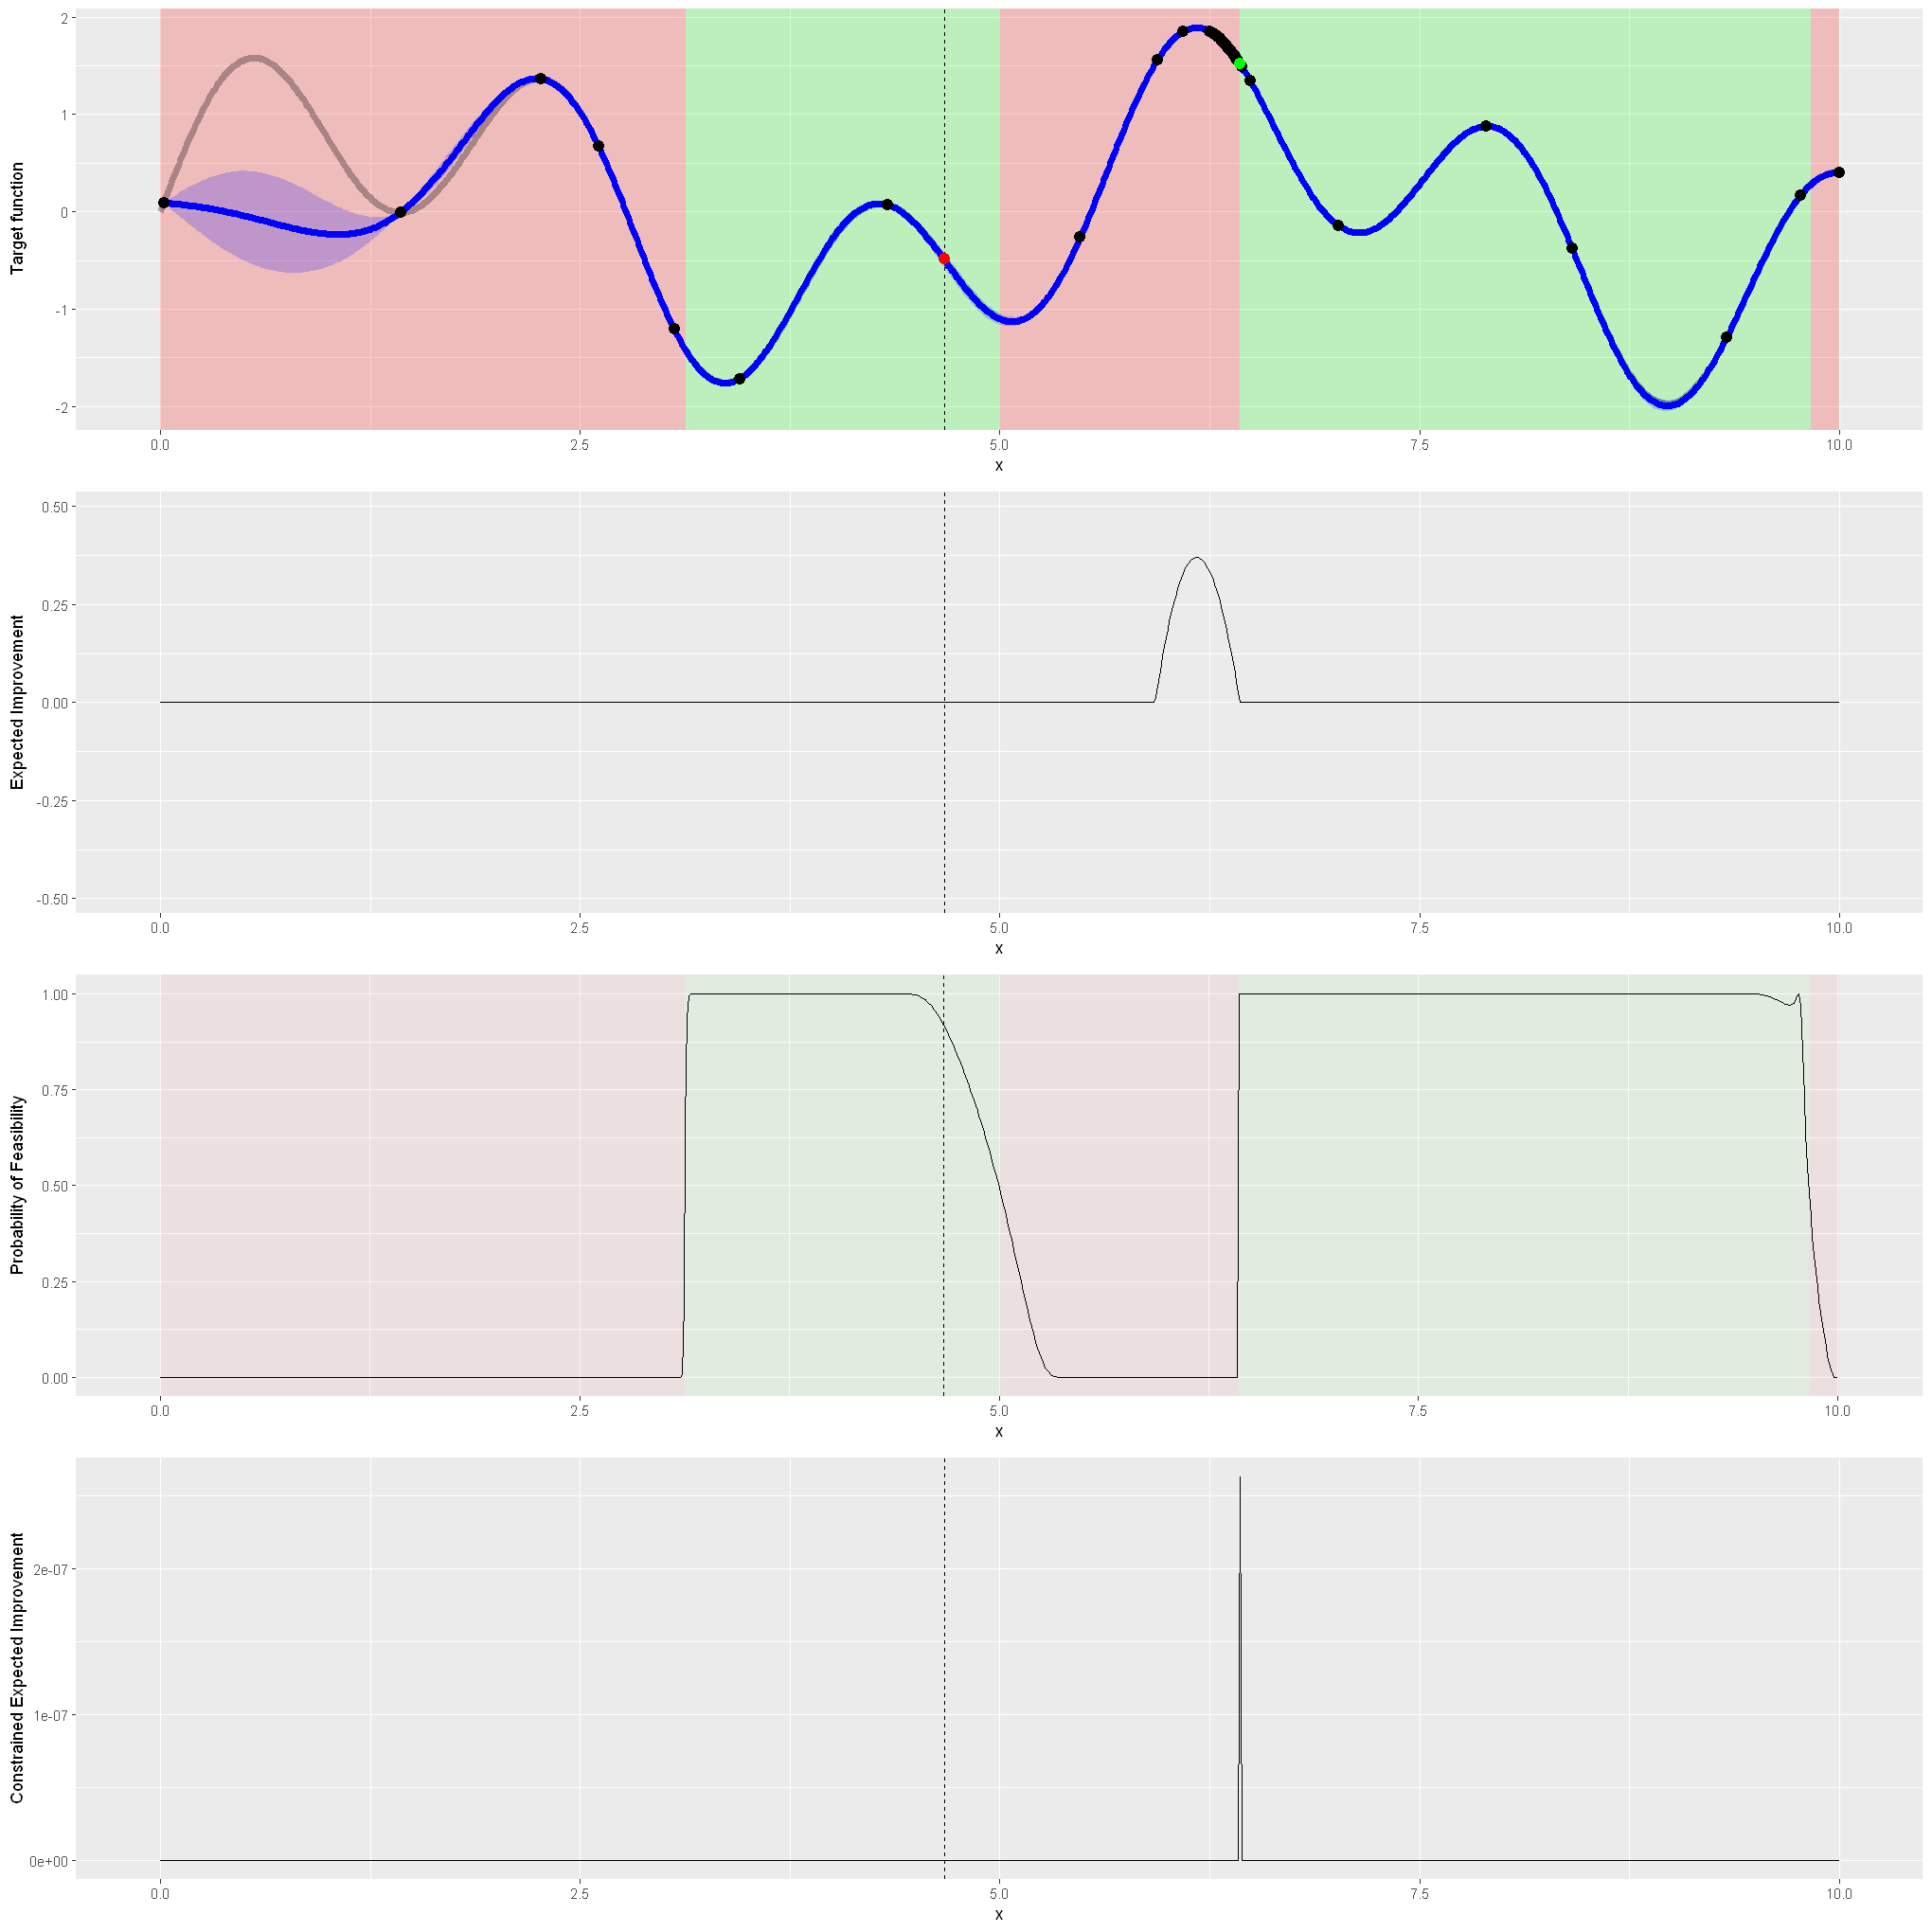

Iteration 39 


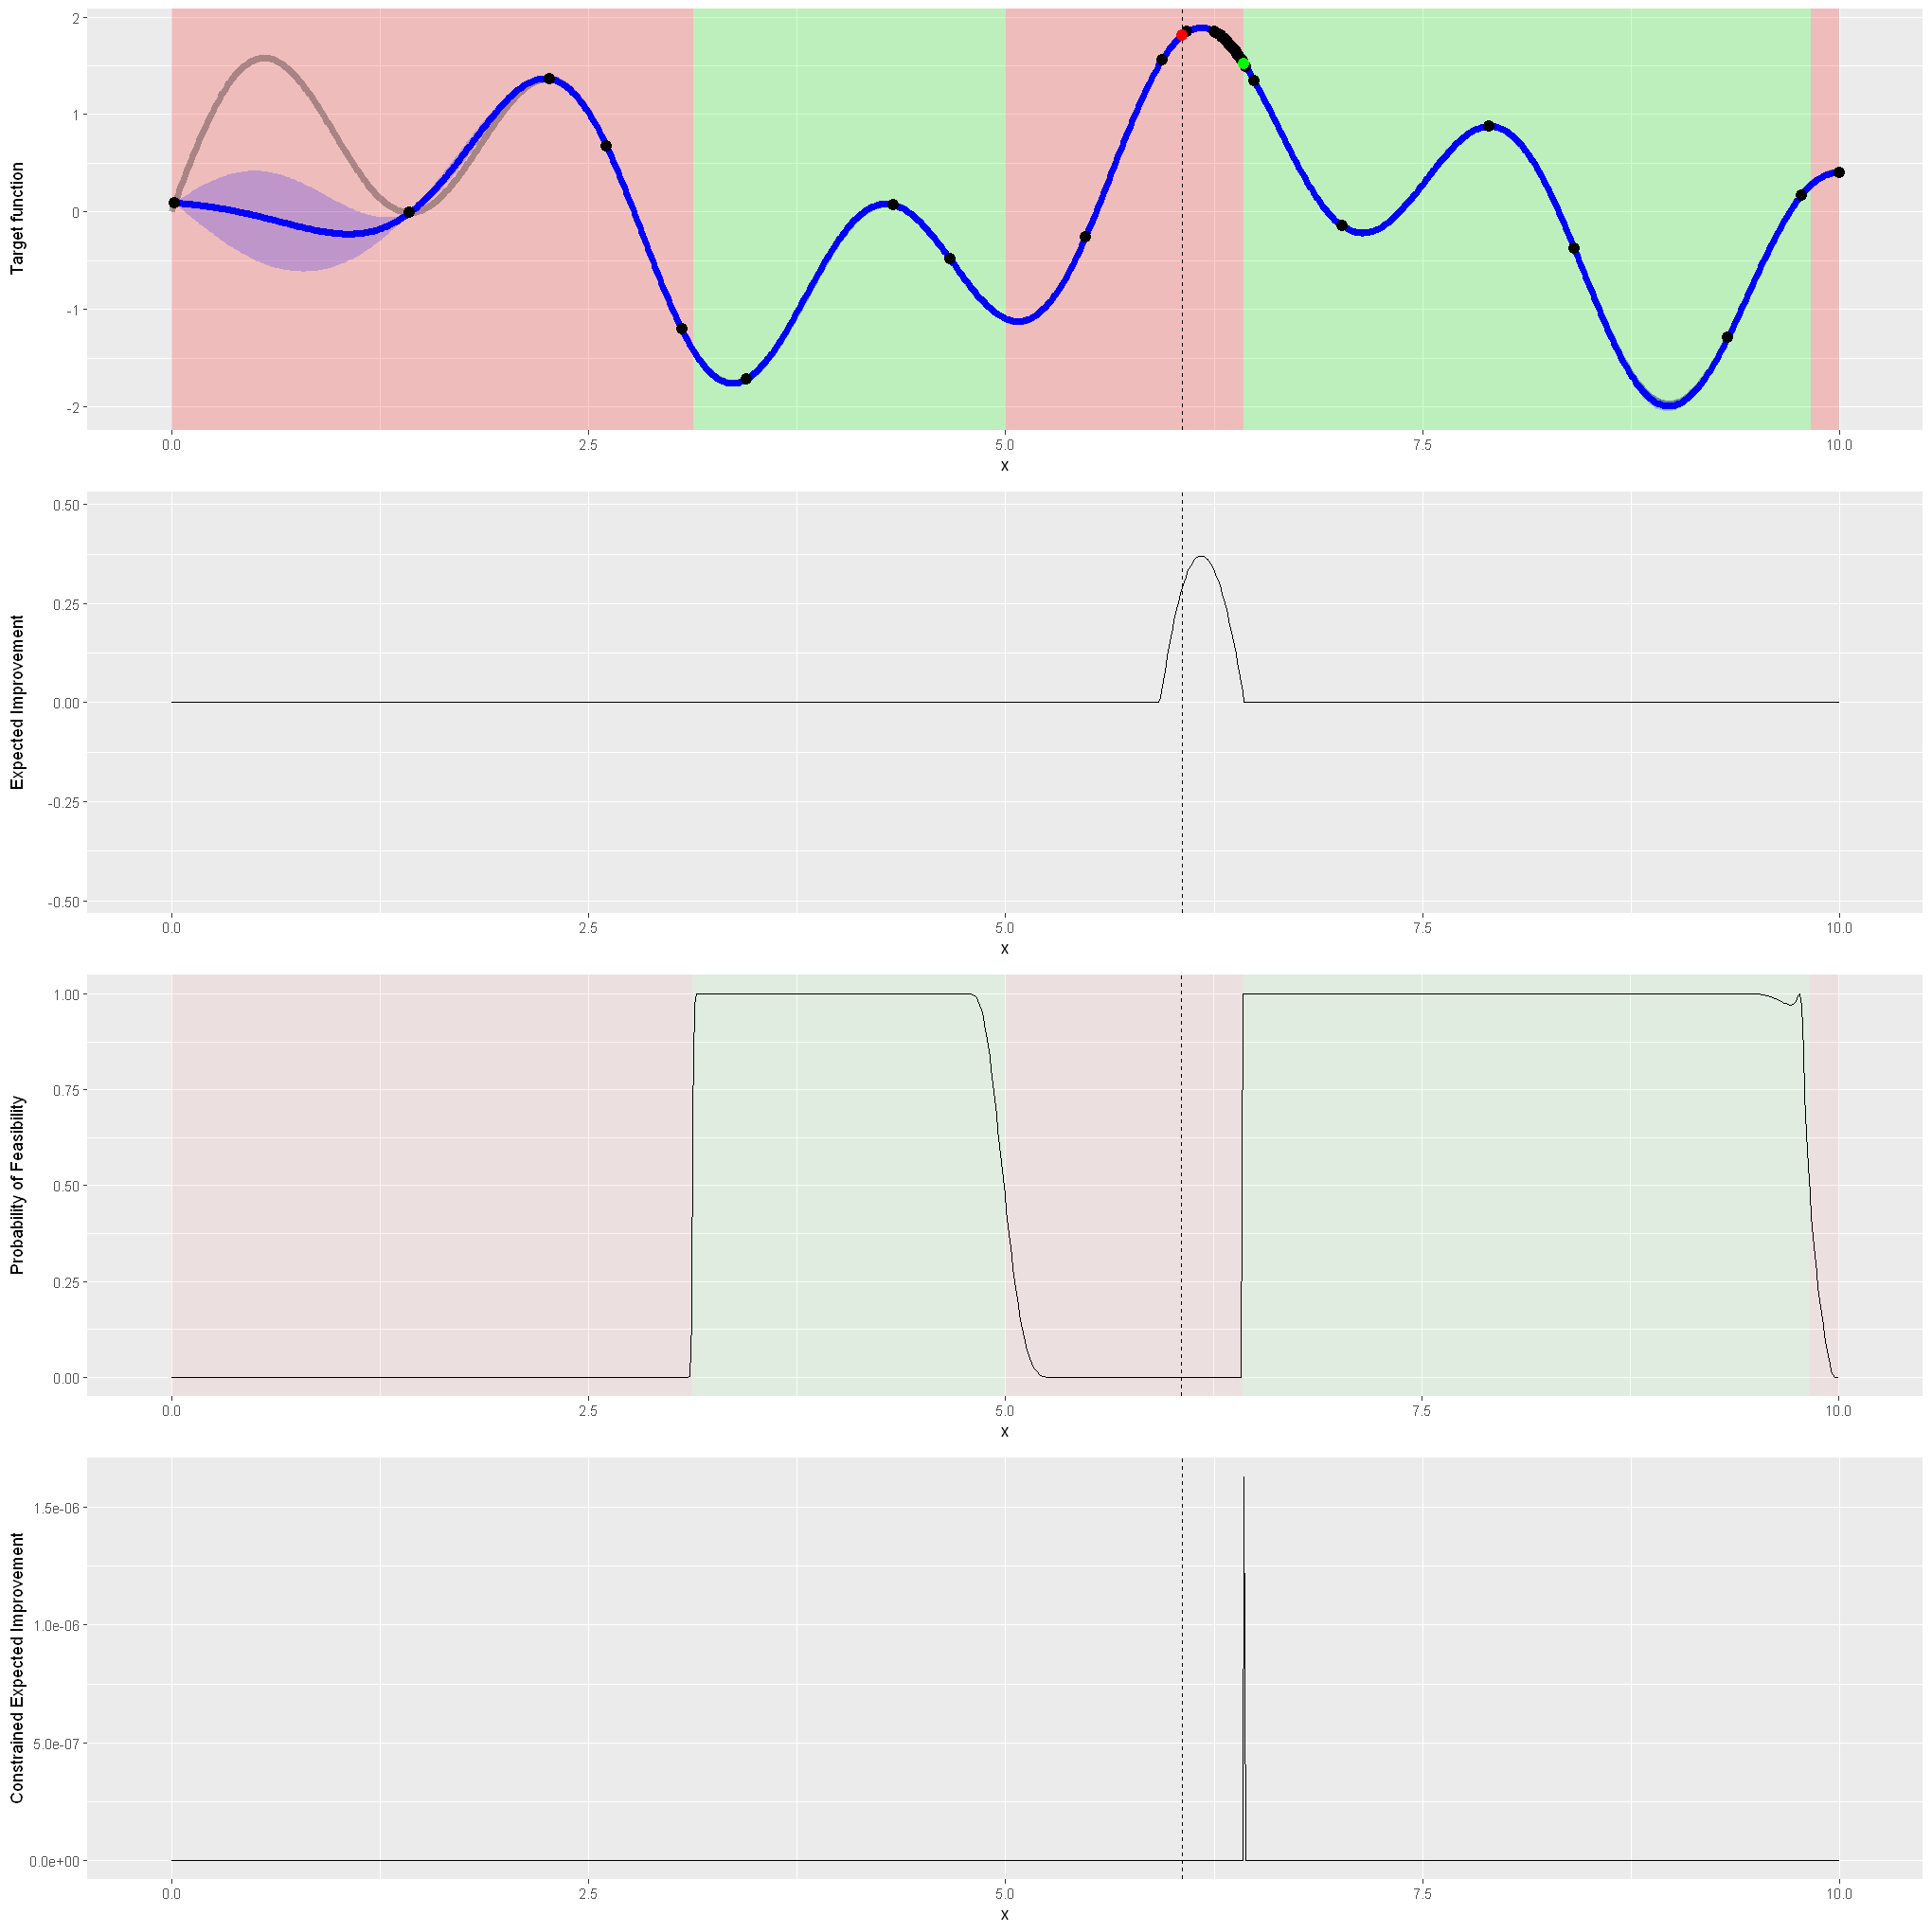

Iteration 40 


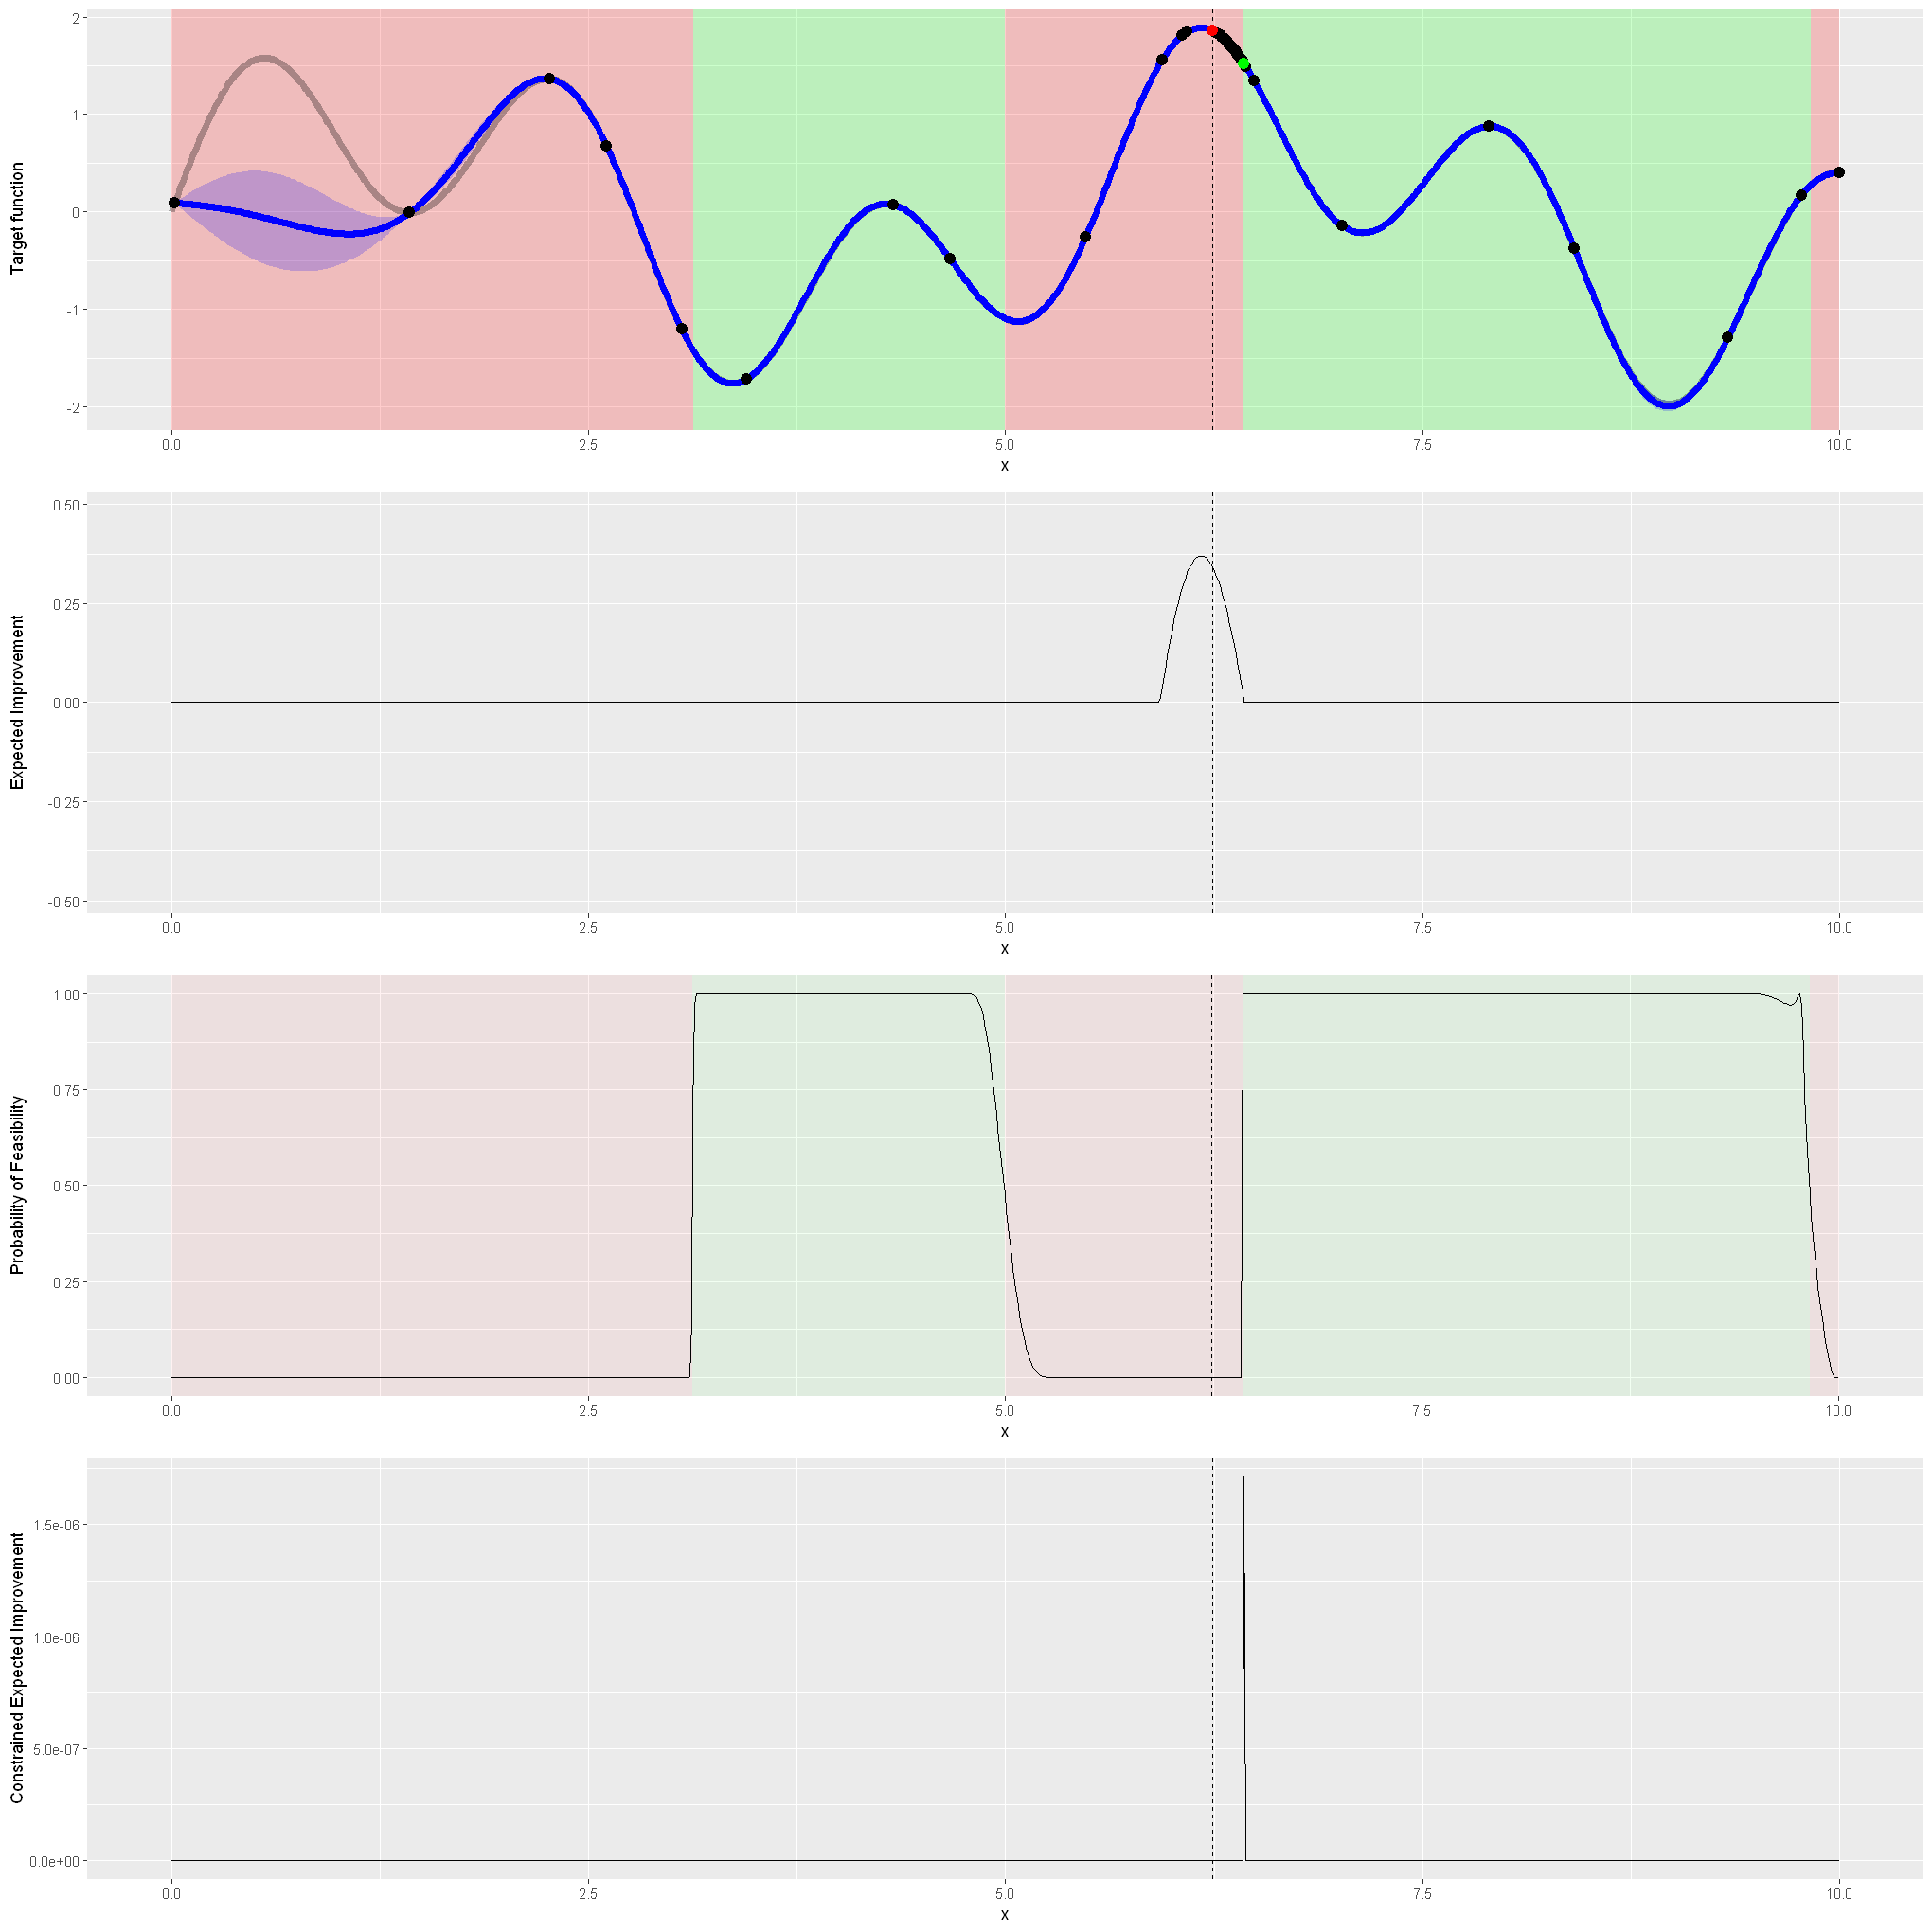

Iteration 41 


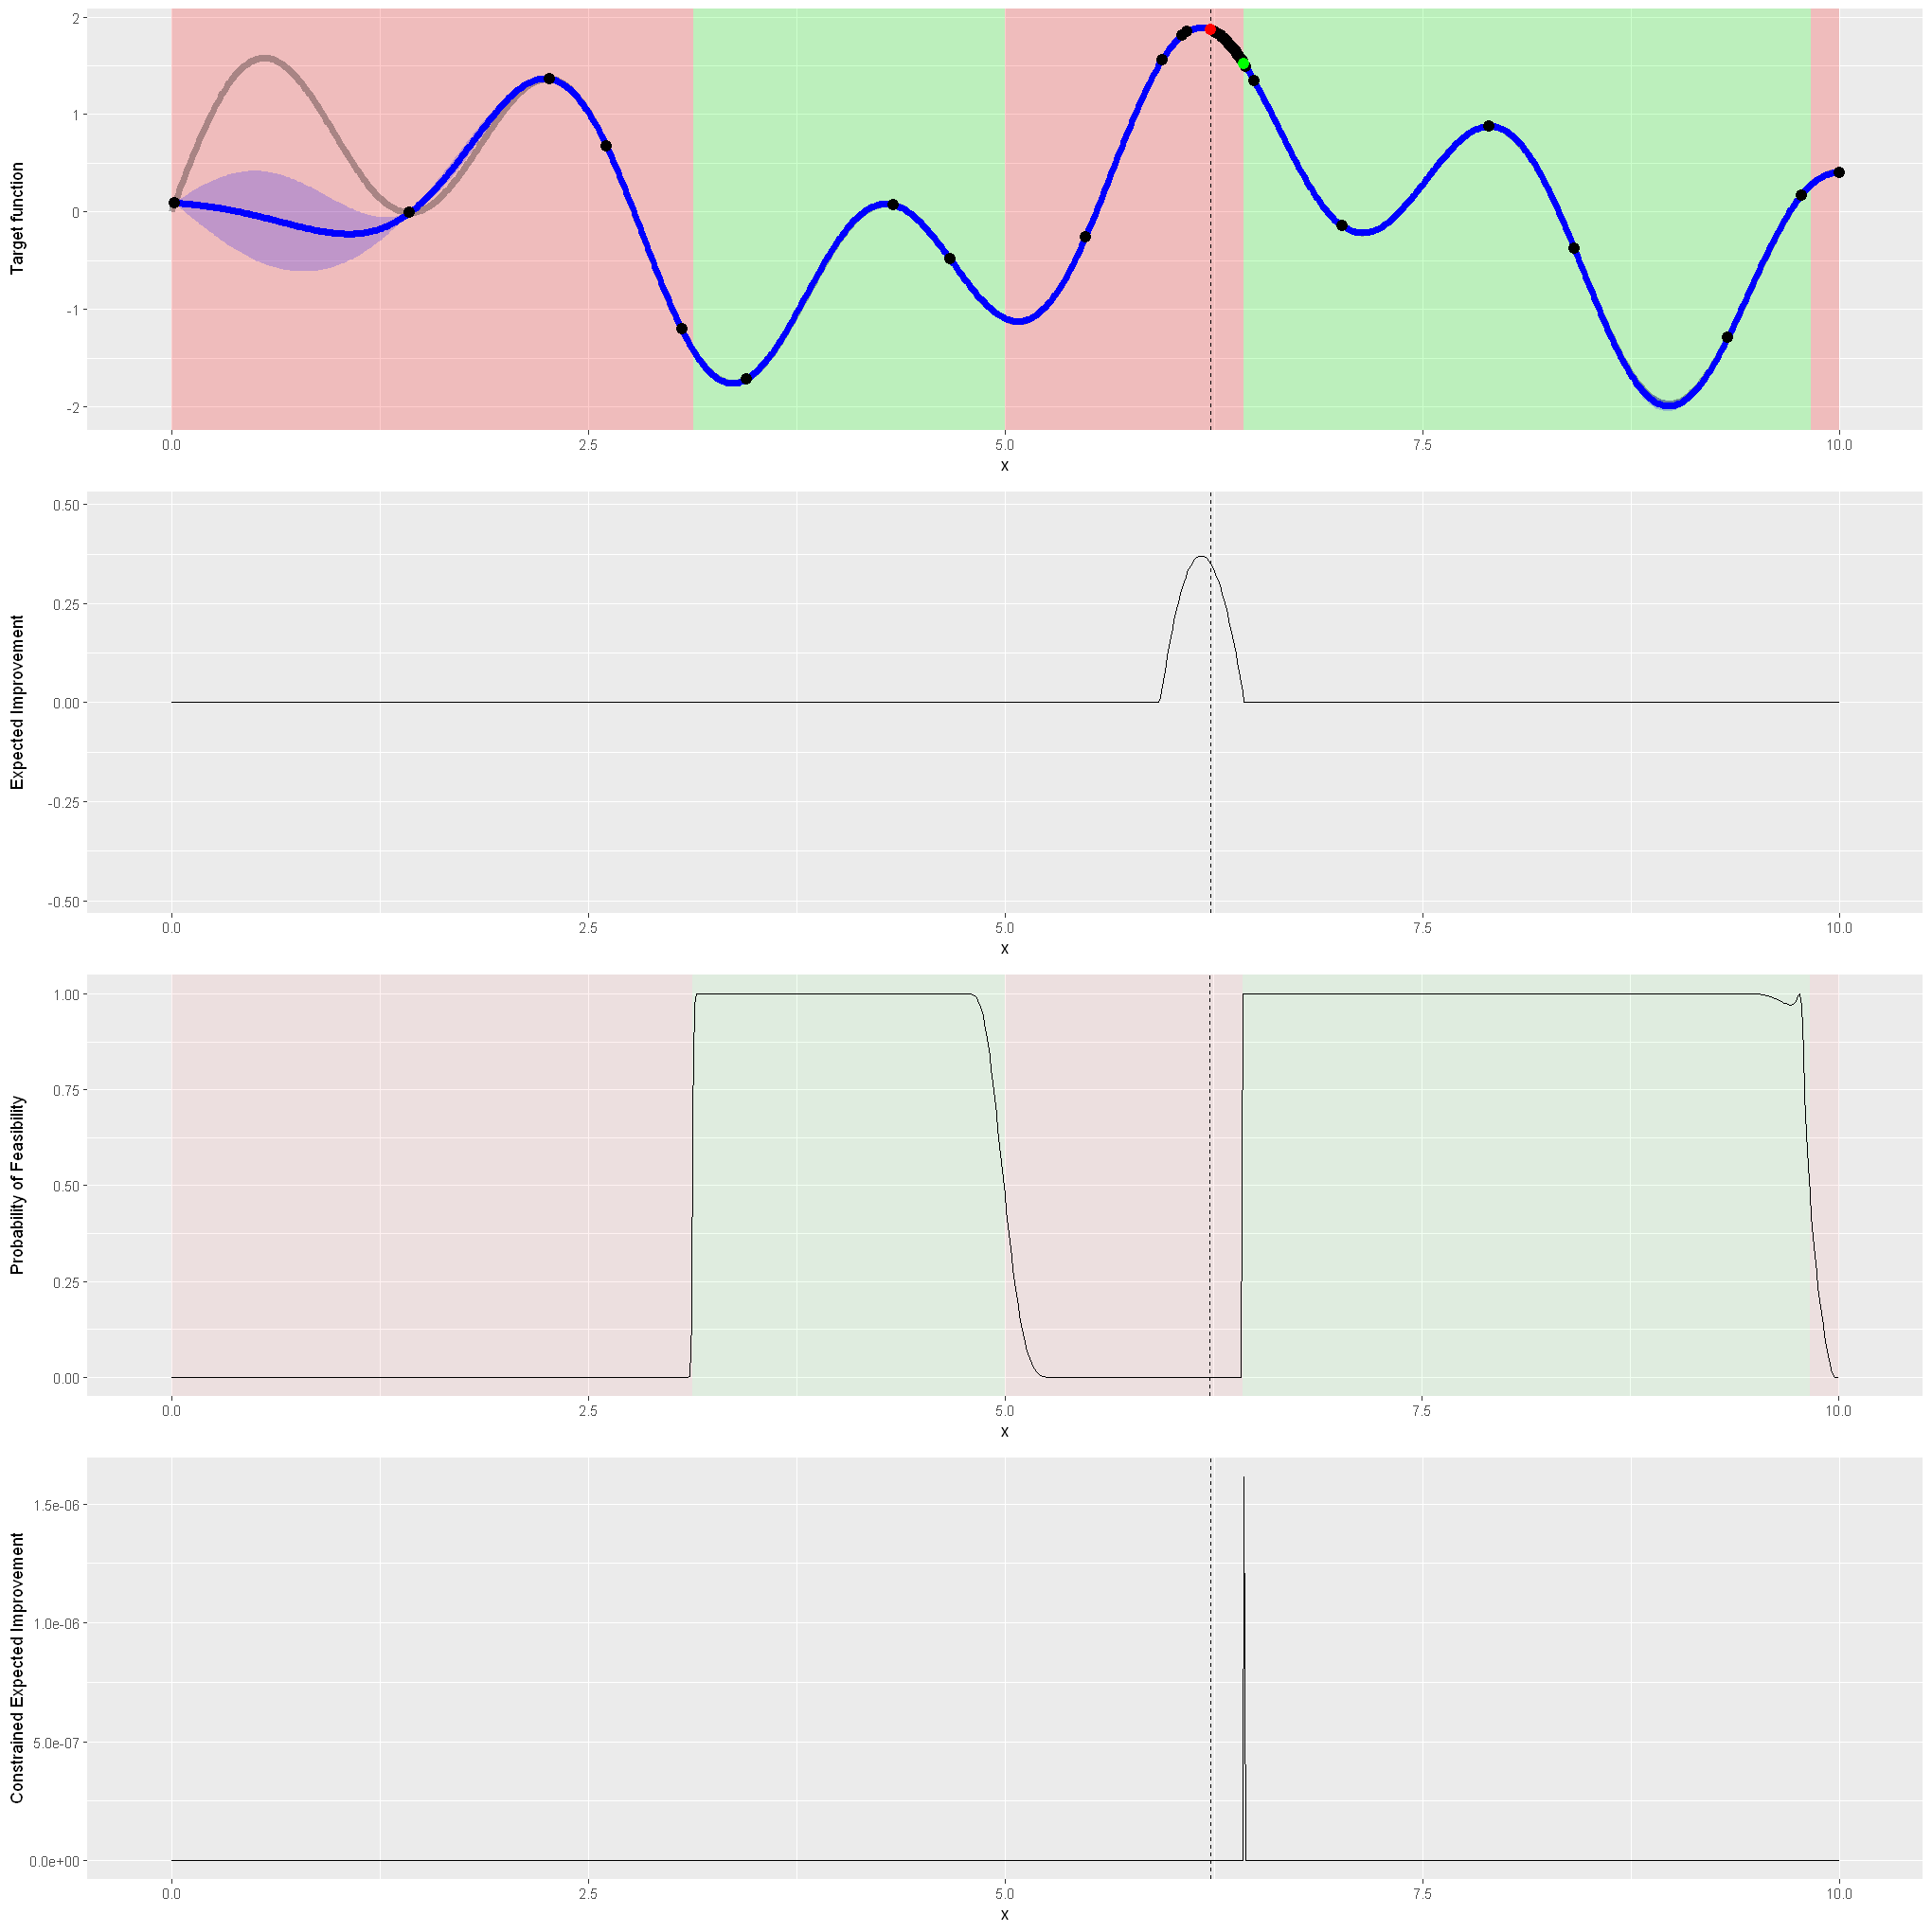

Iteration 42 


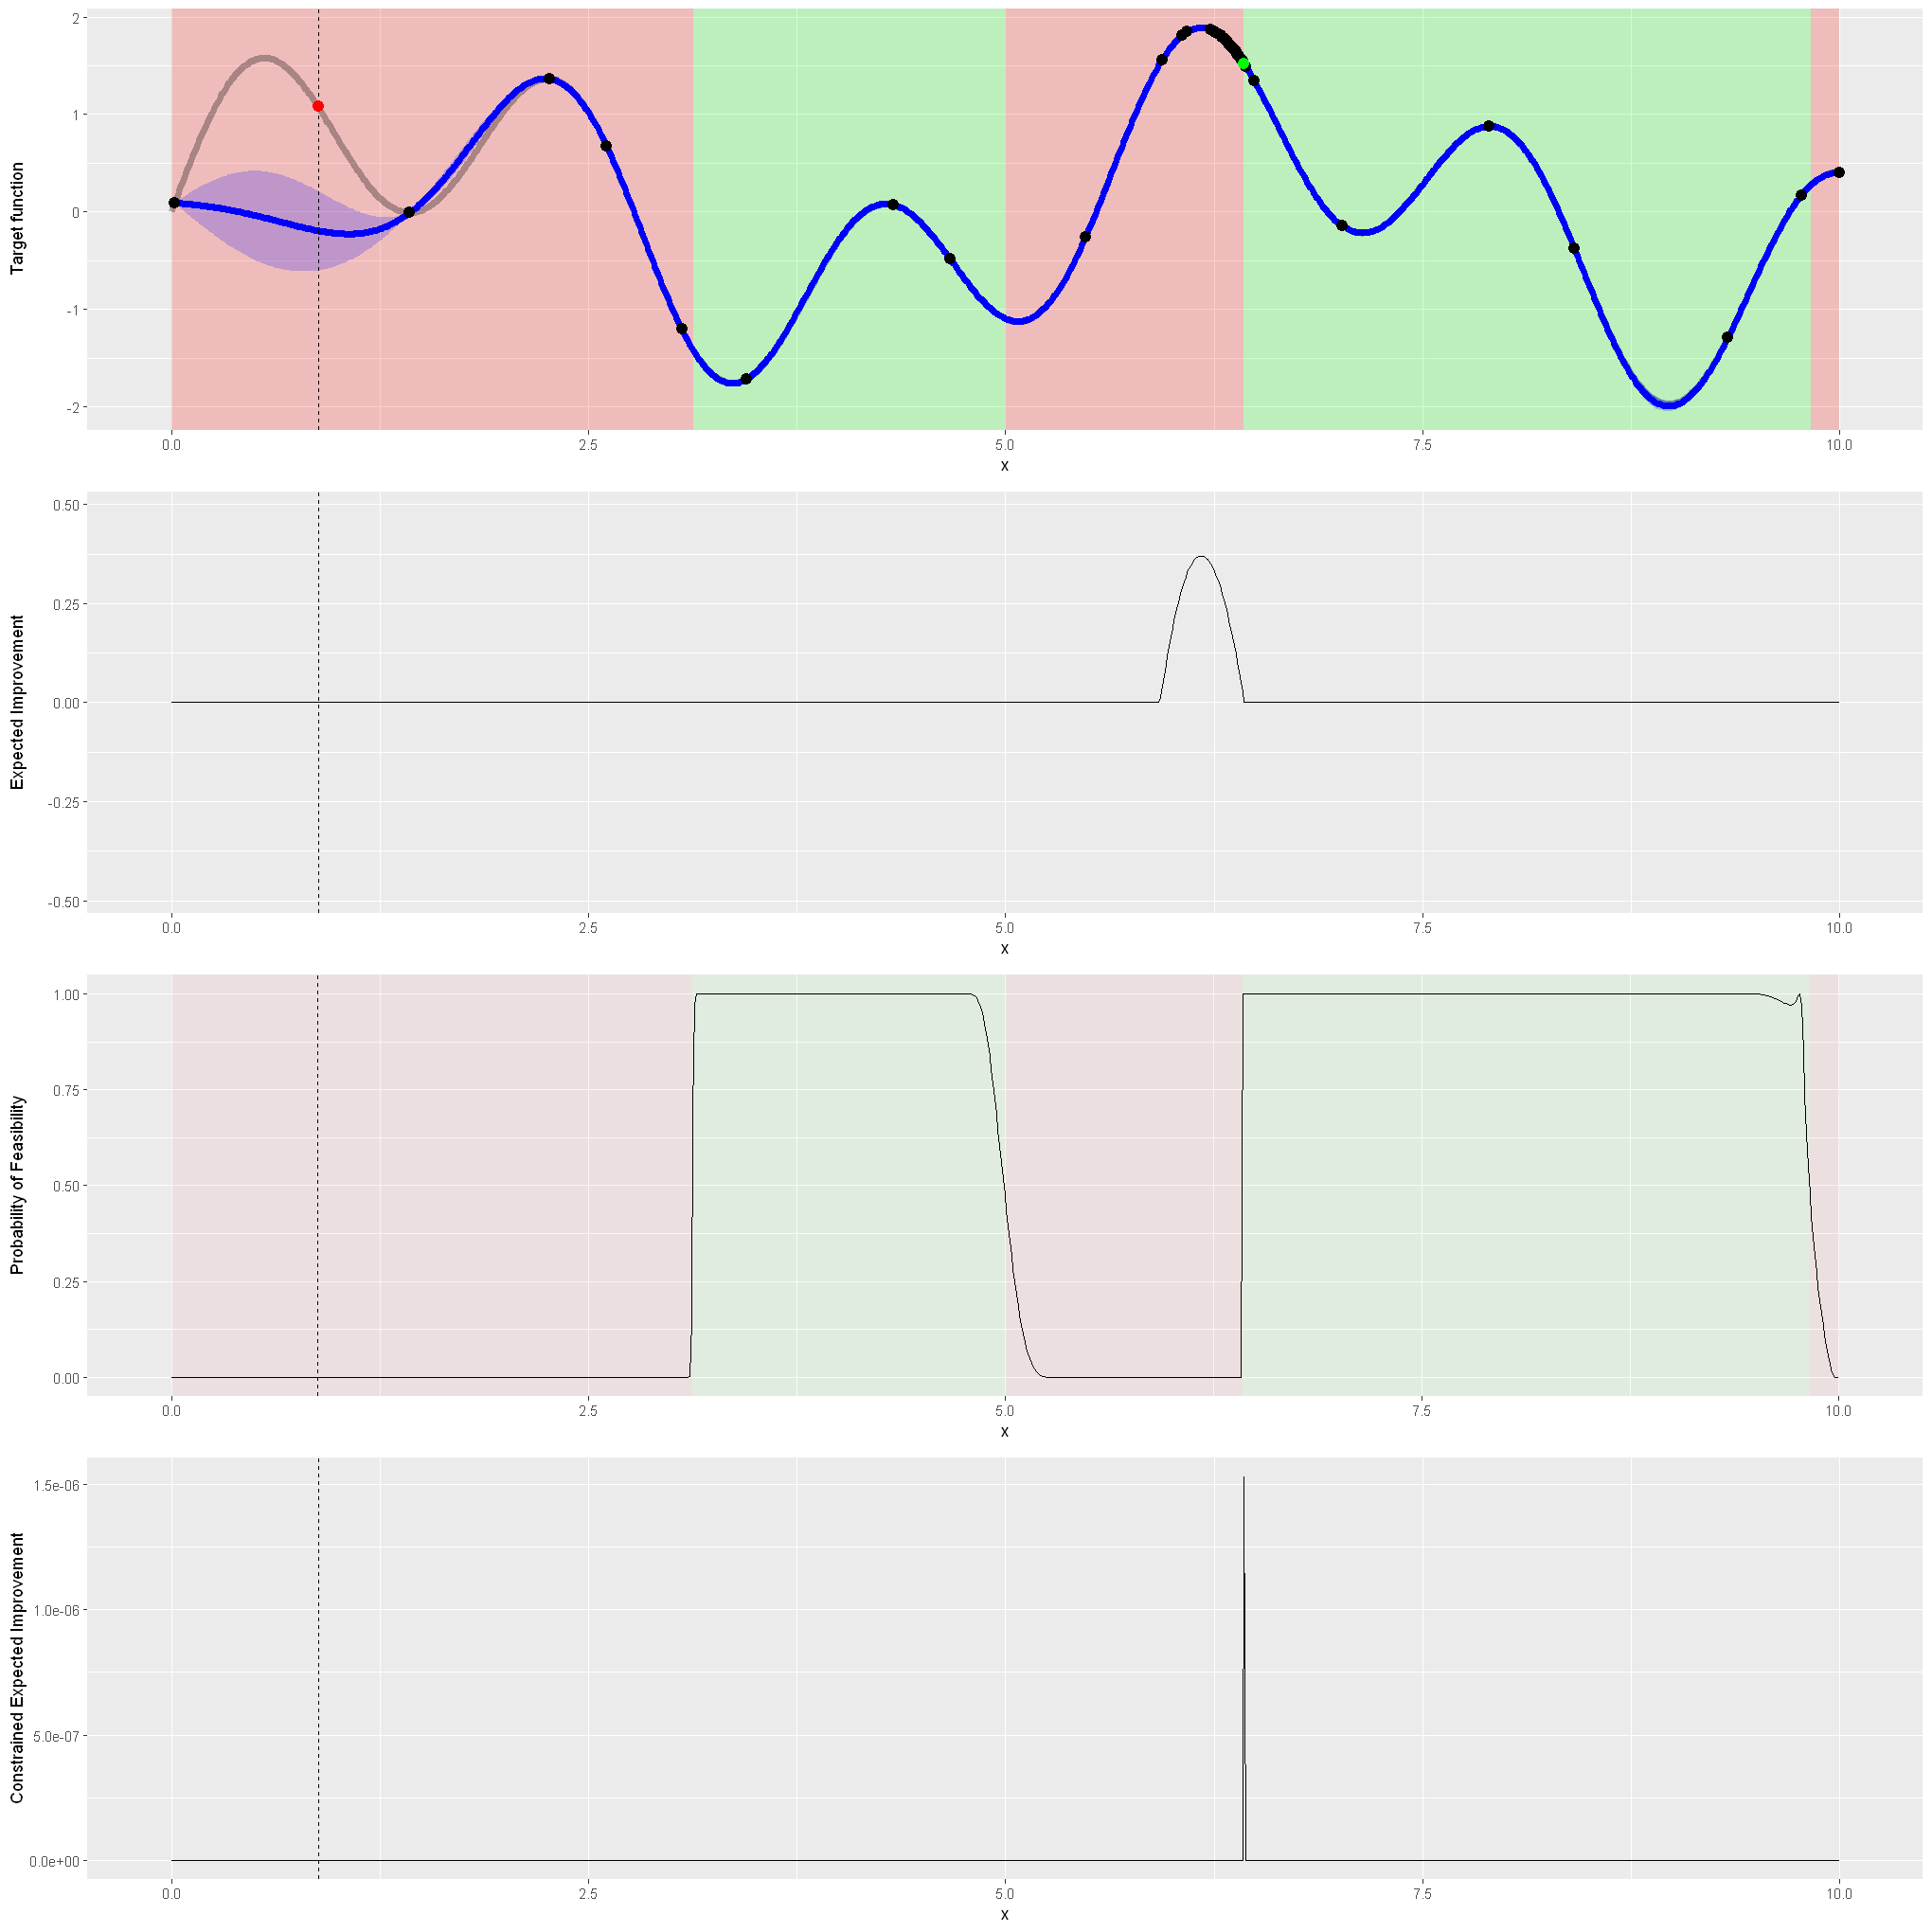

Iteration 43 


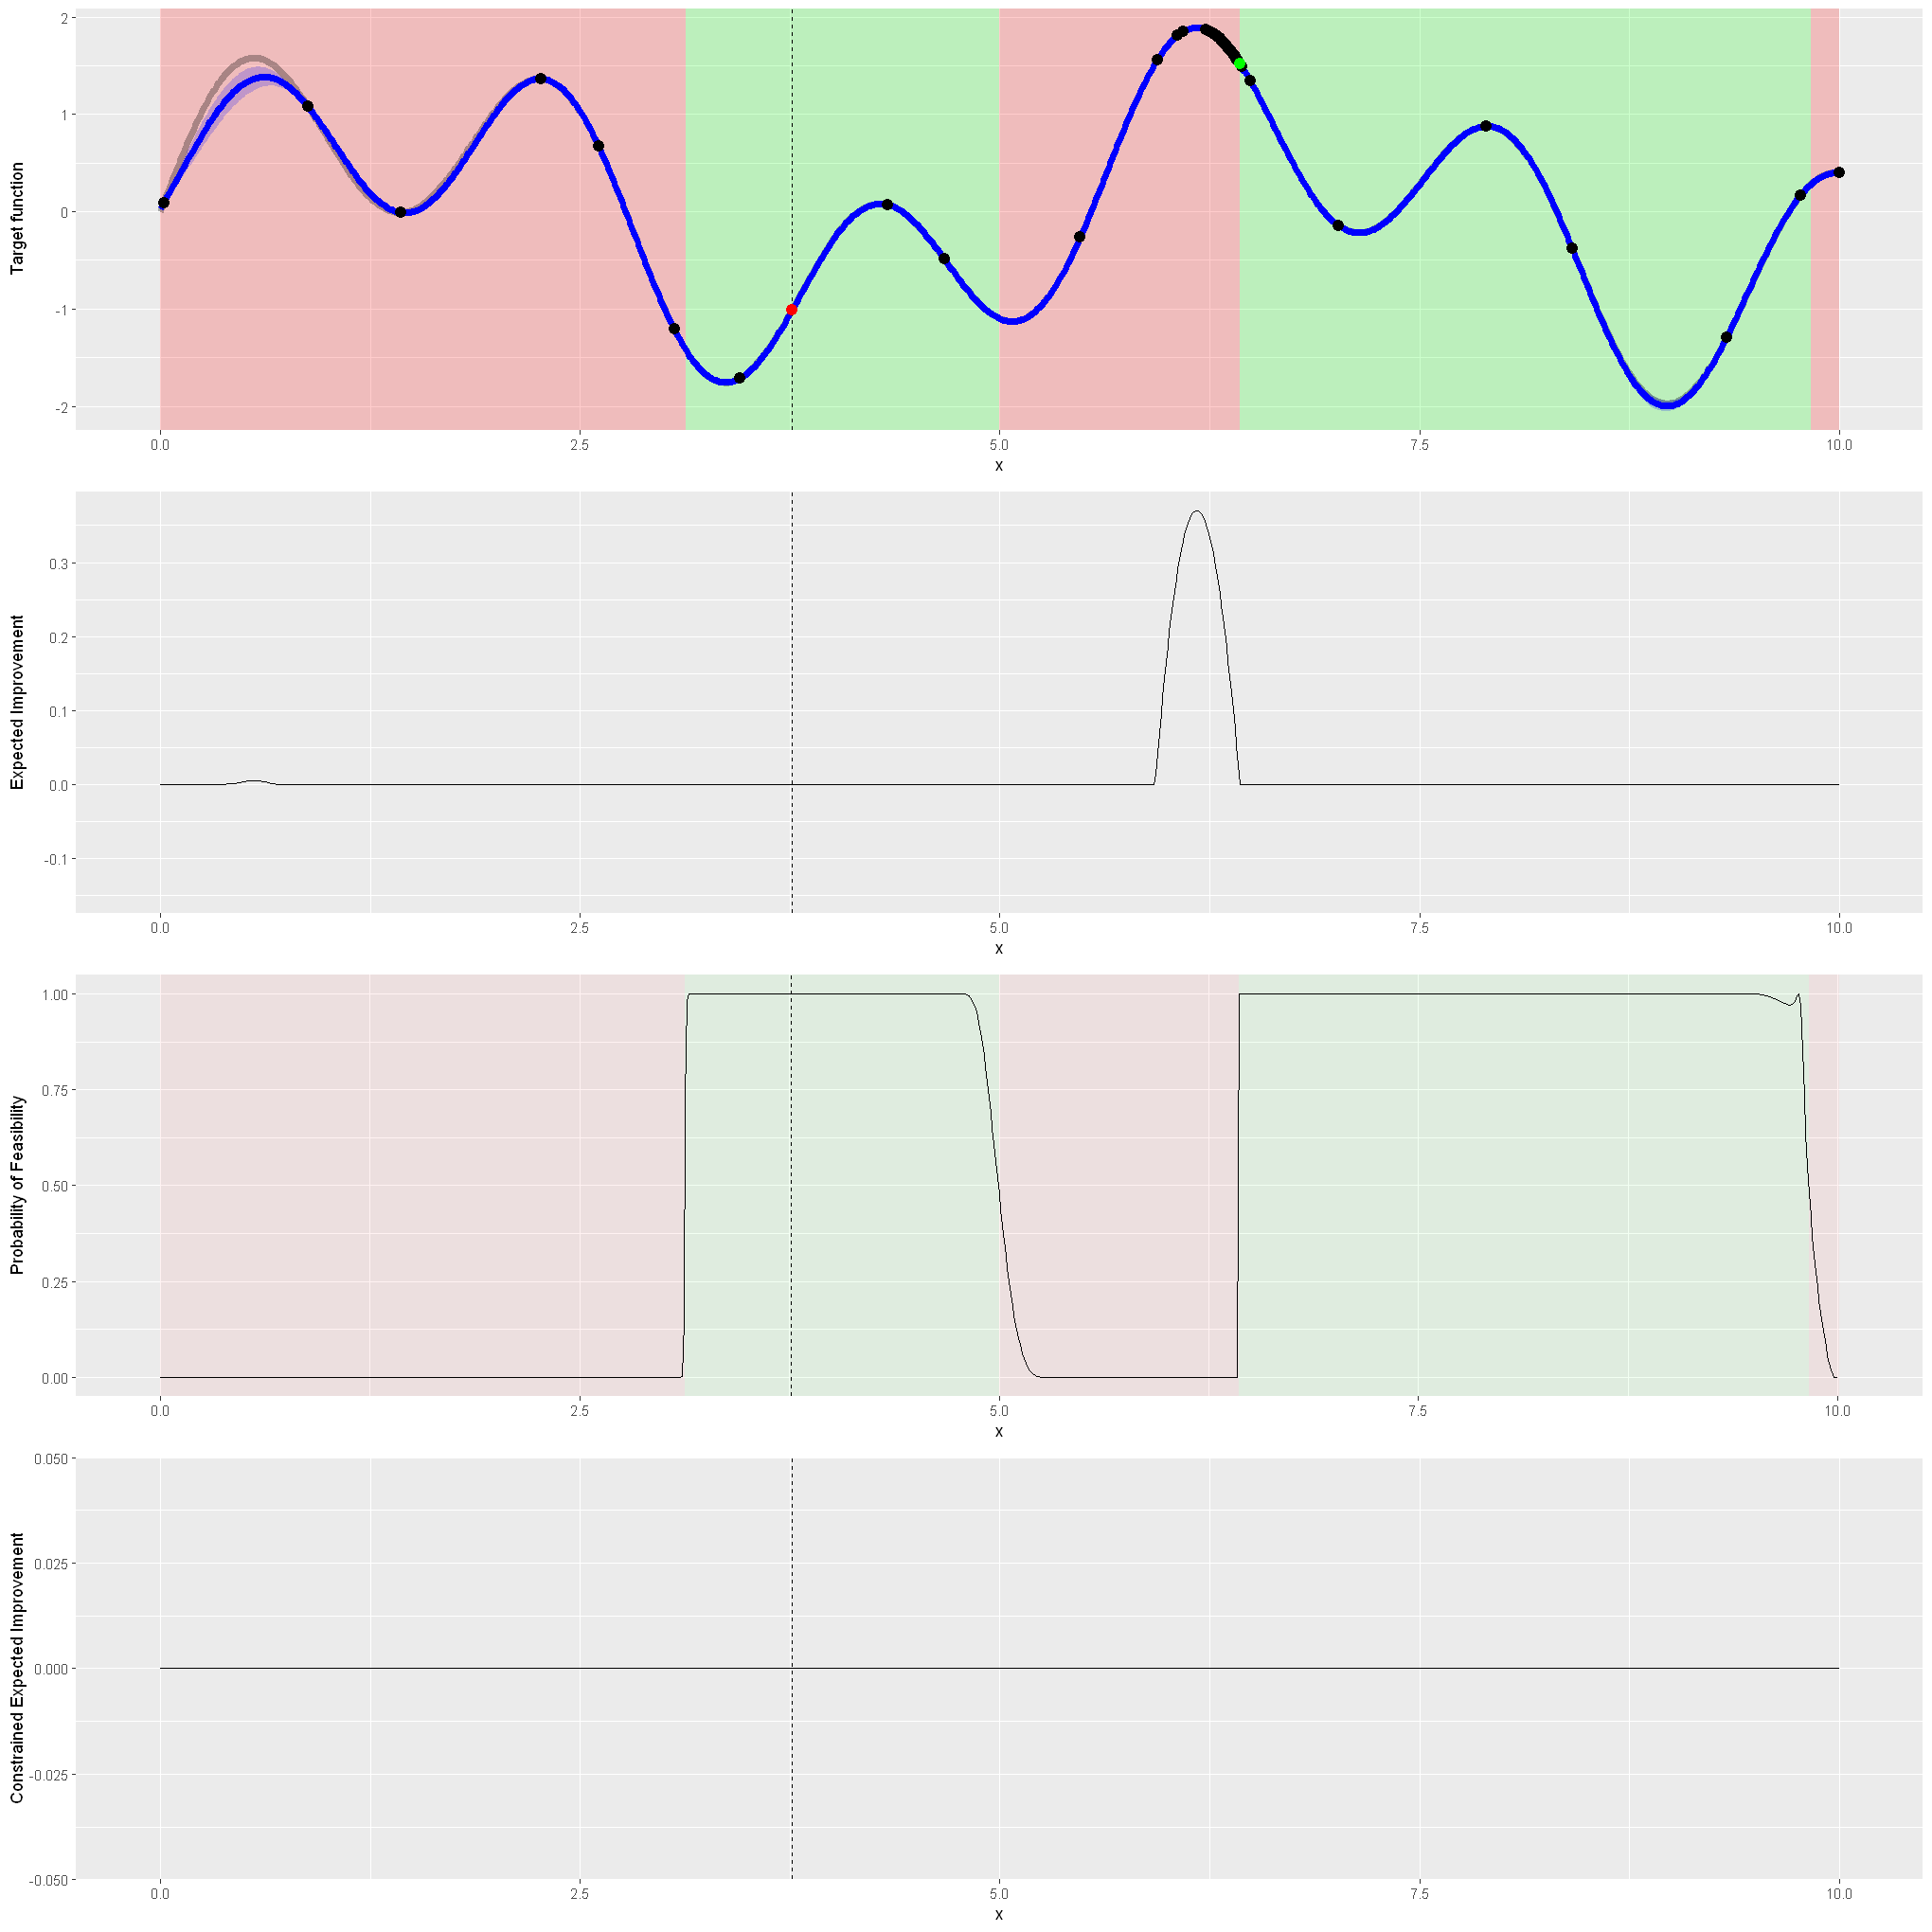

Iteration 44 


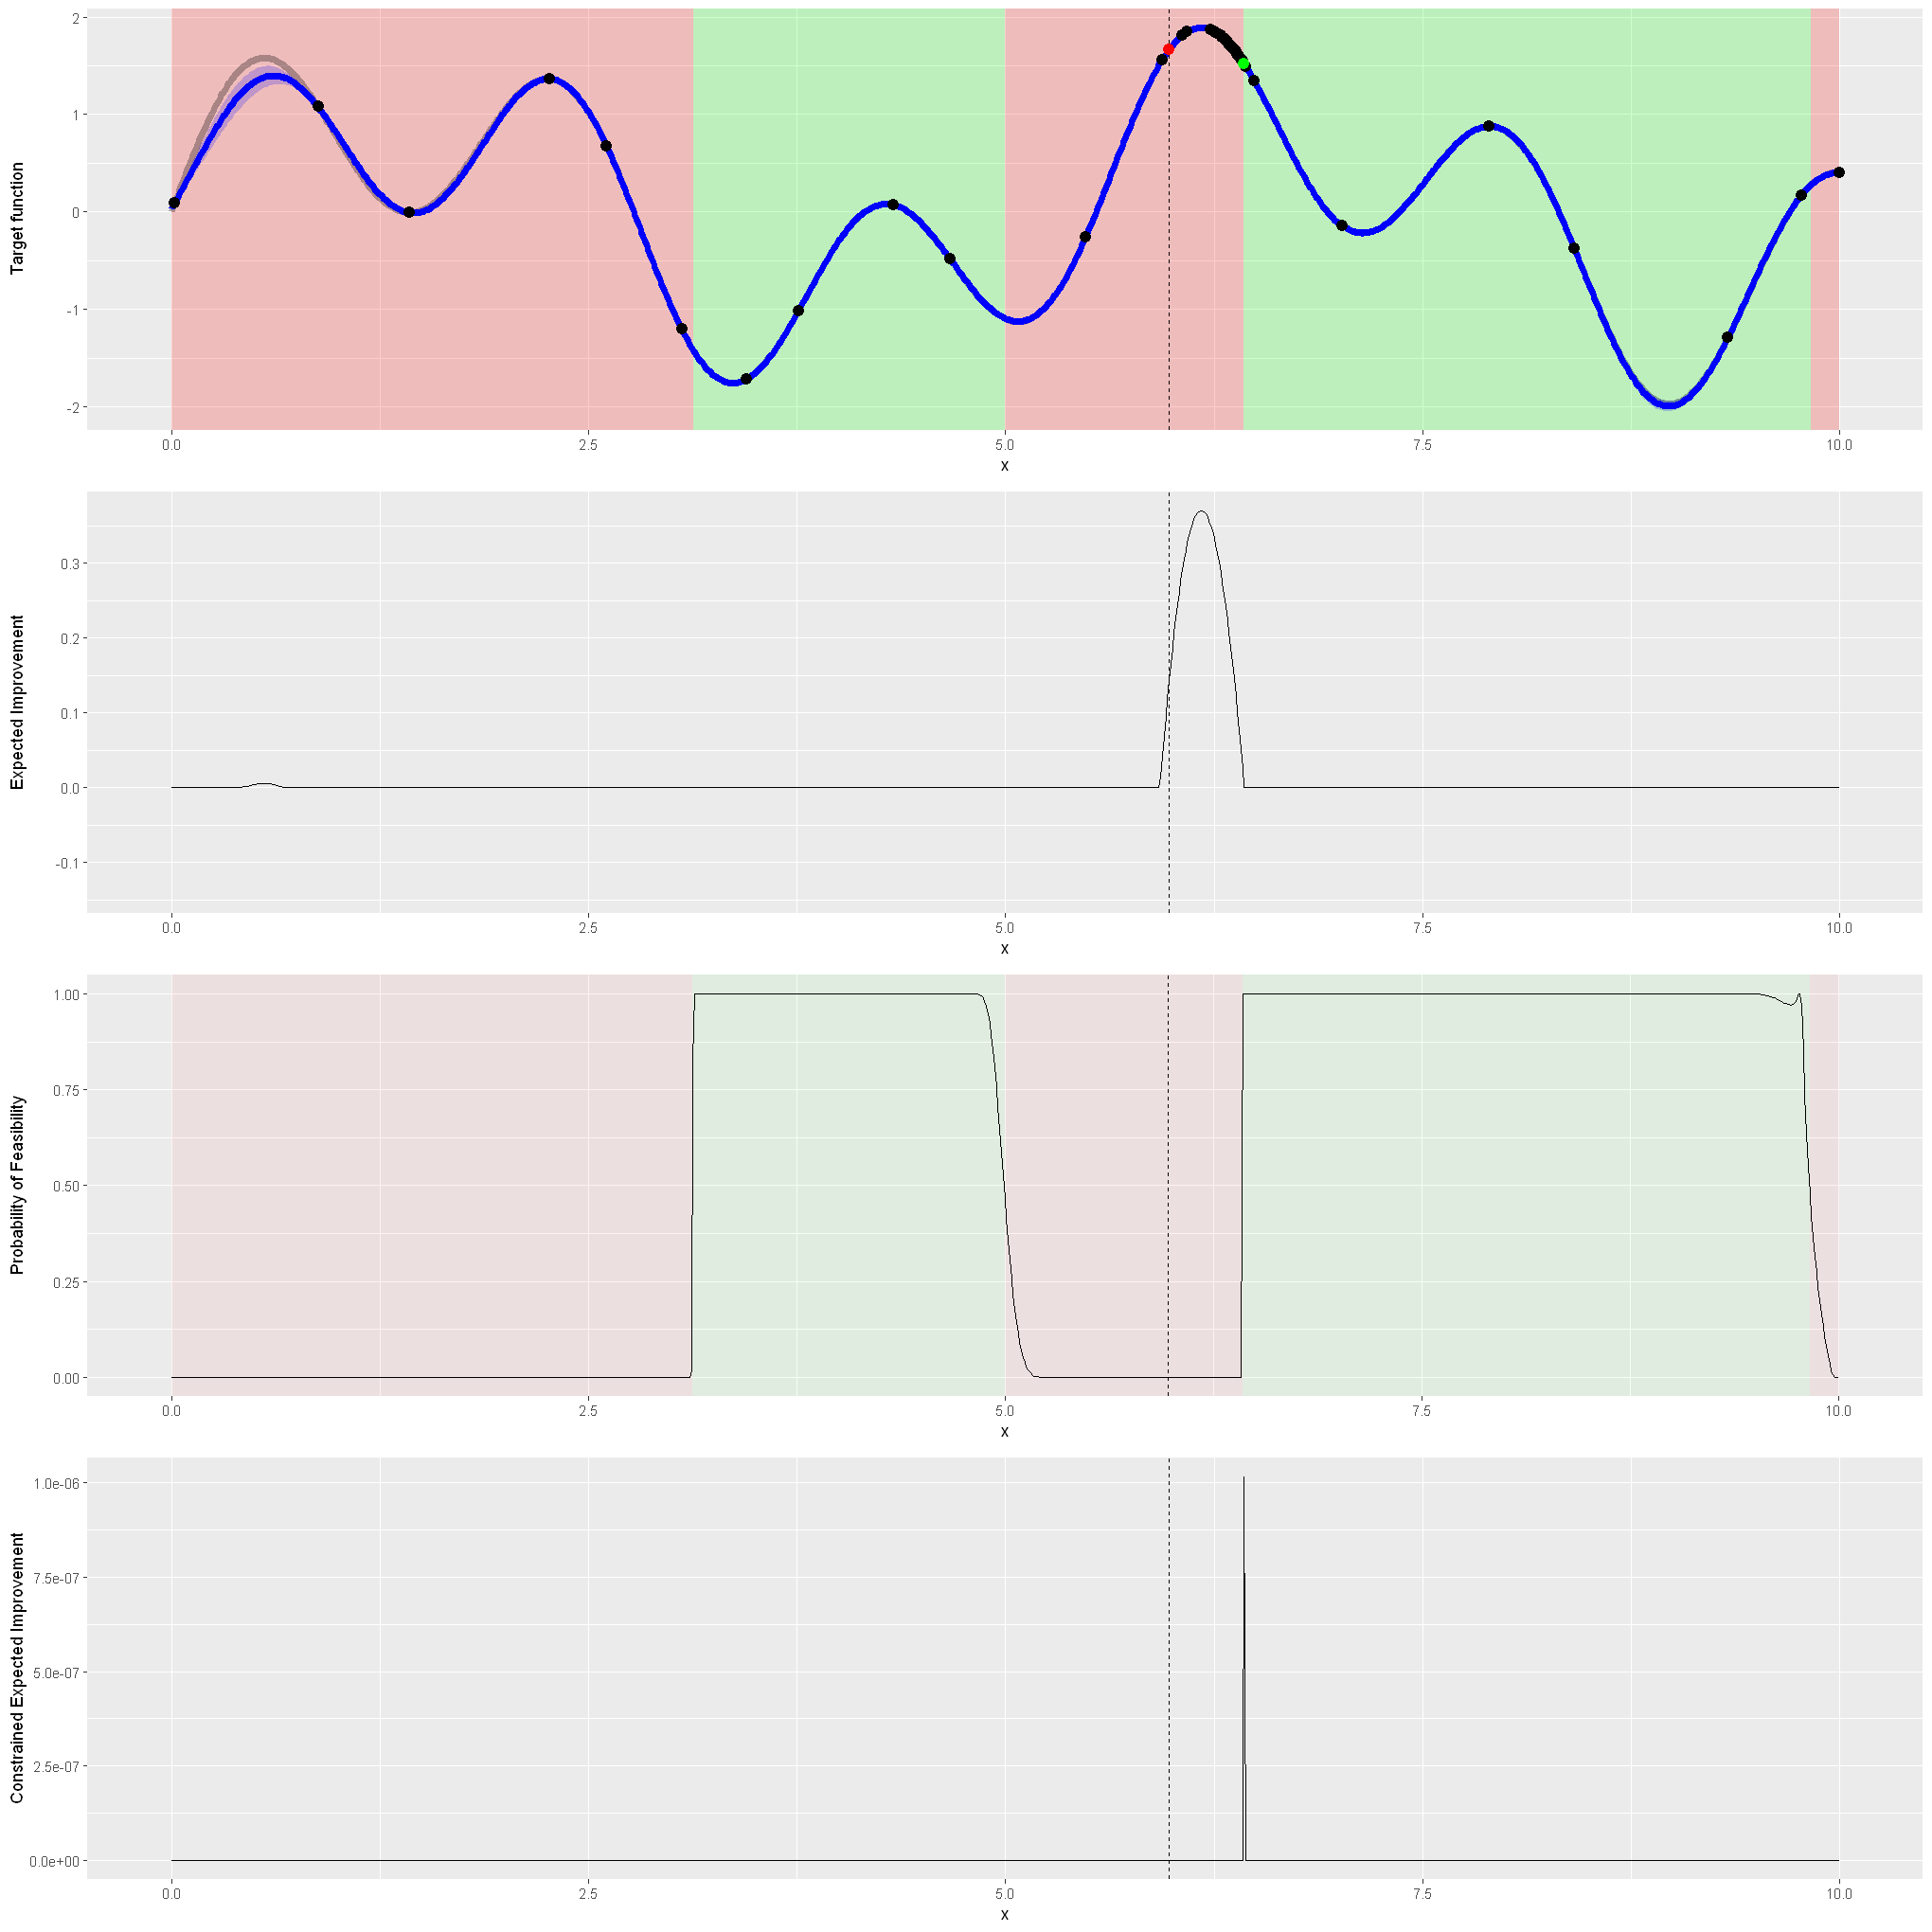

Iteration 45 


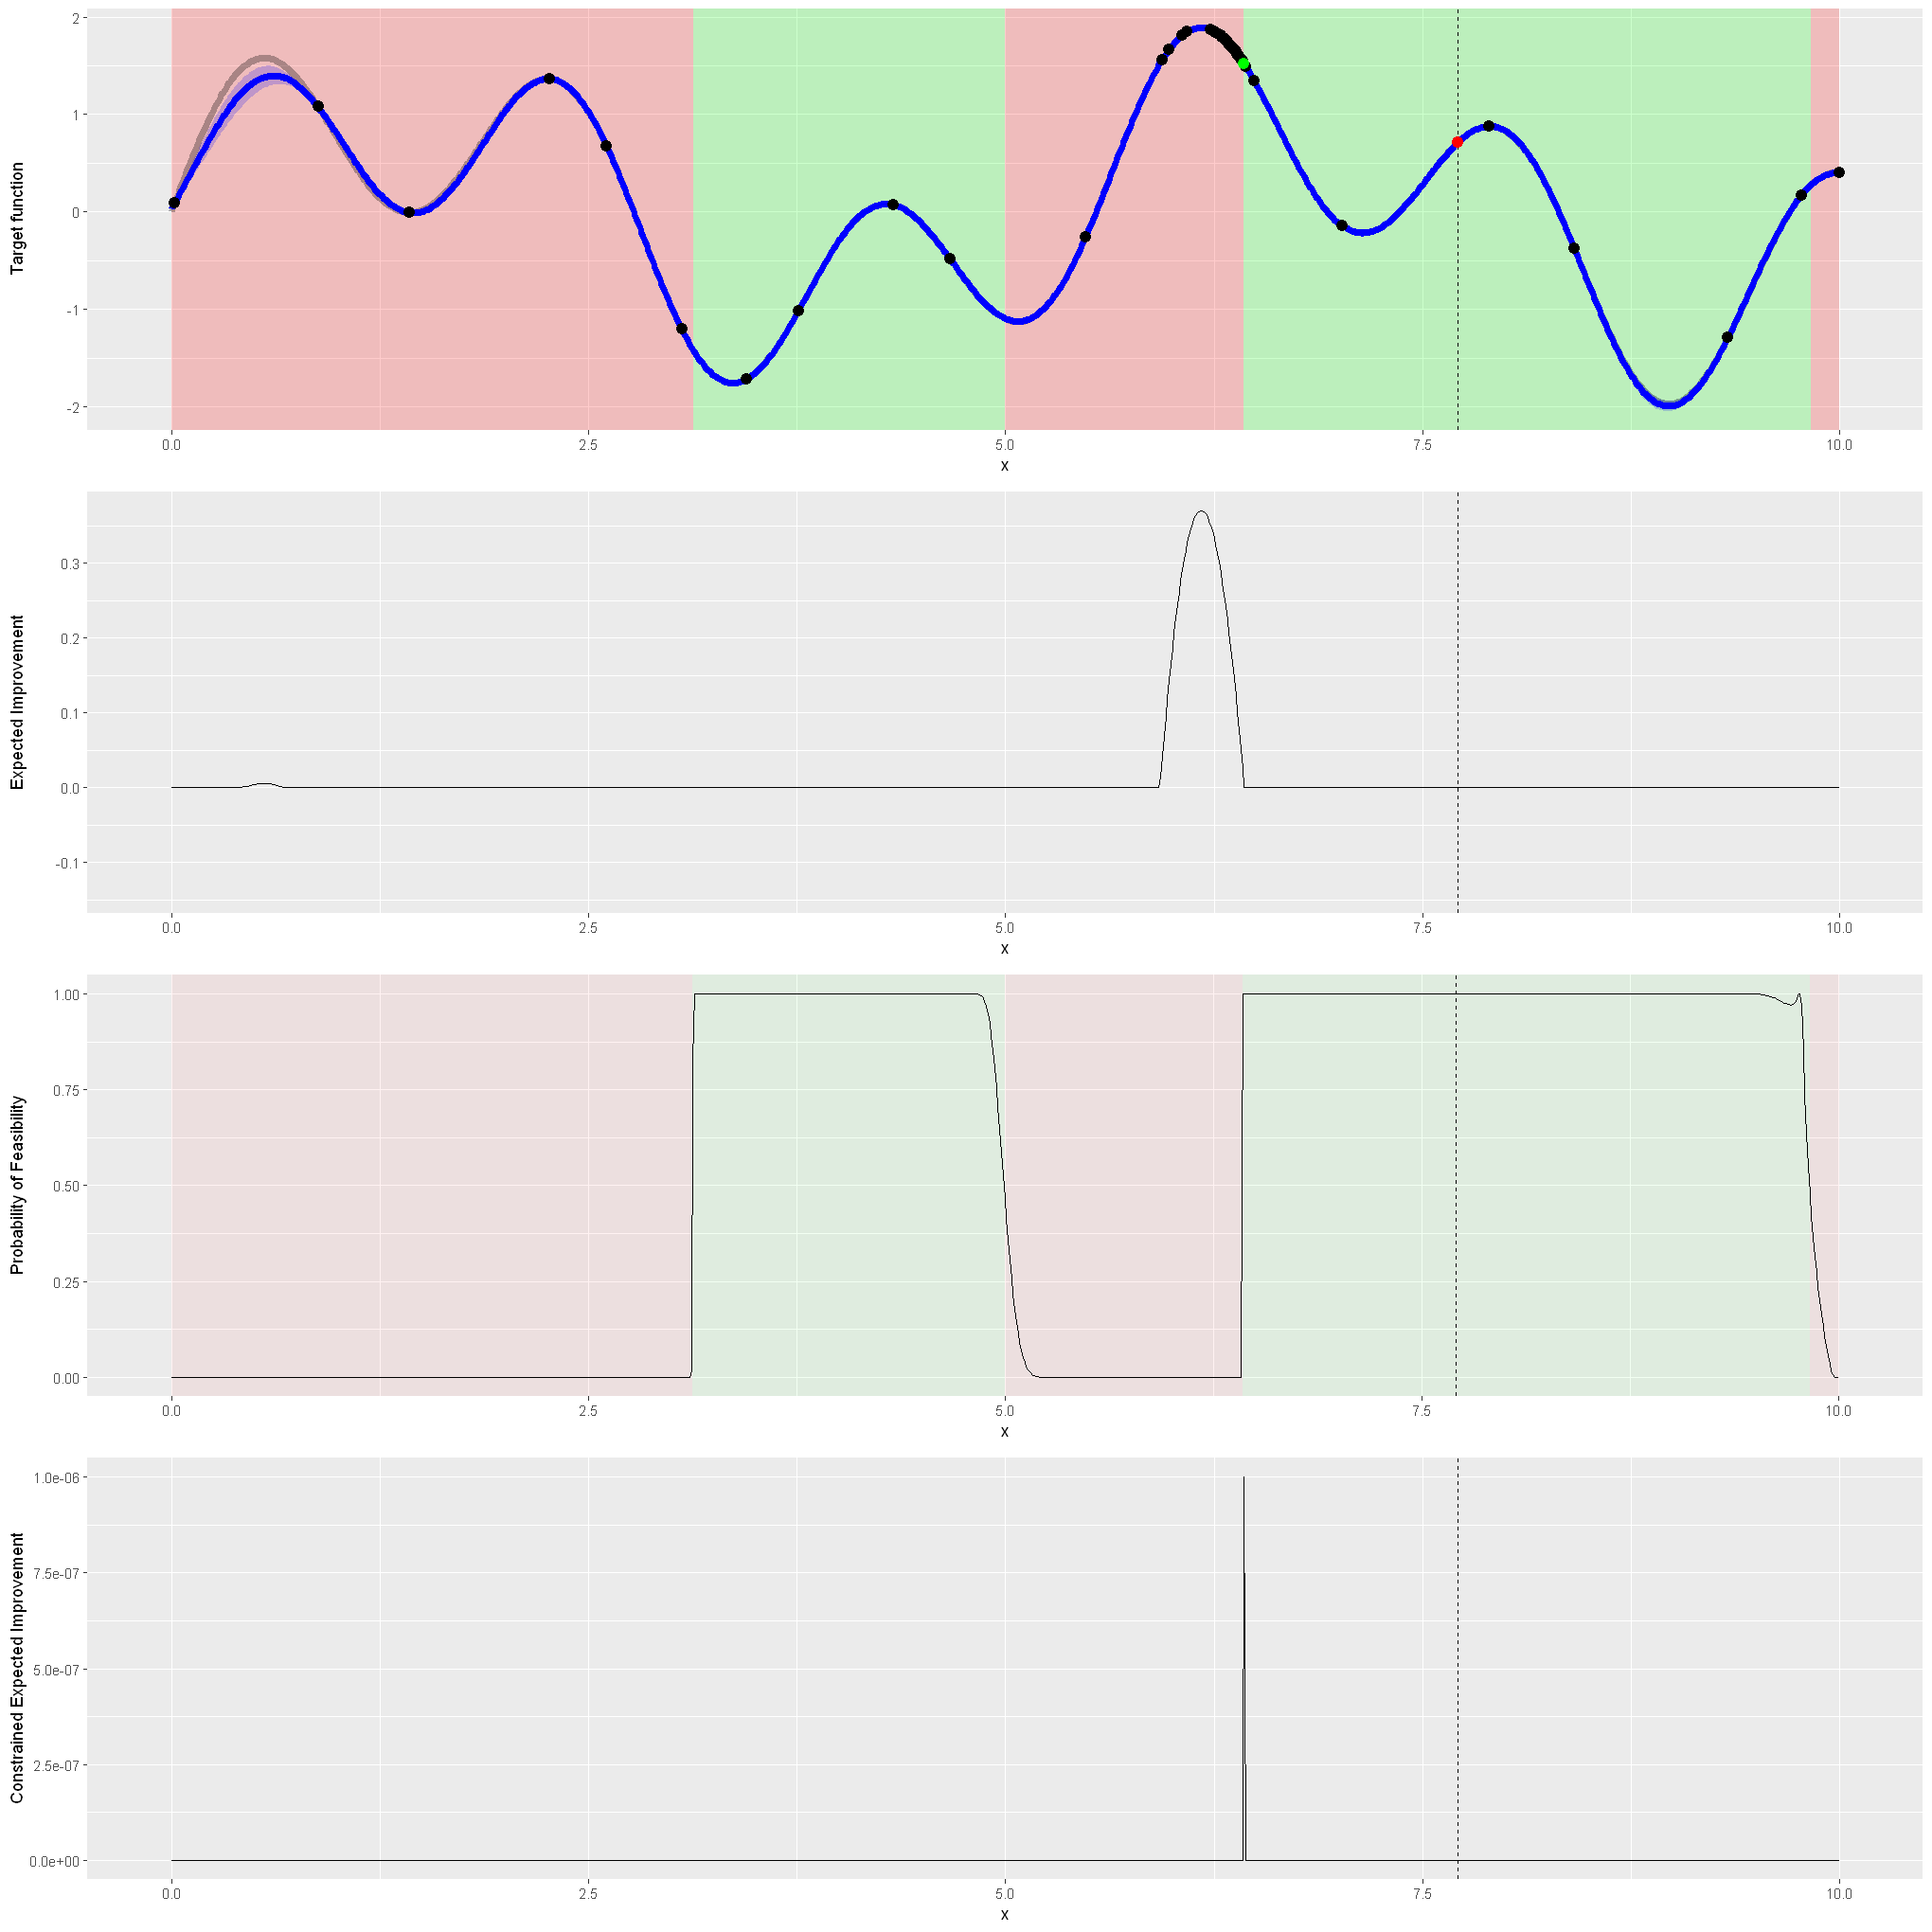

Iteration 46 


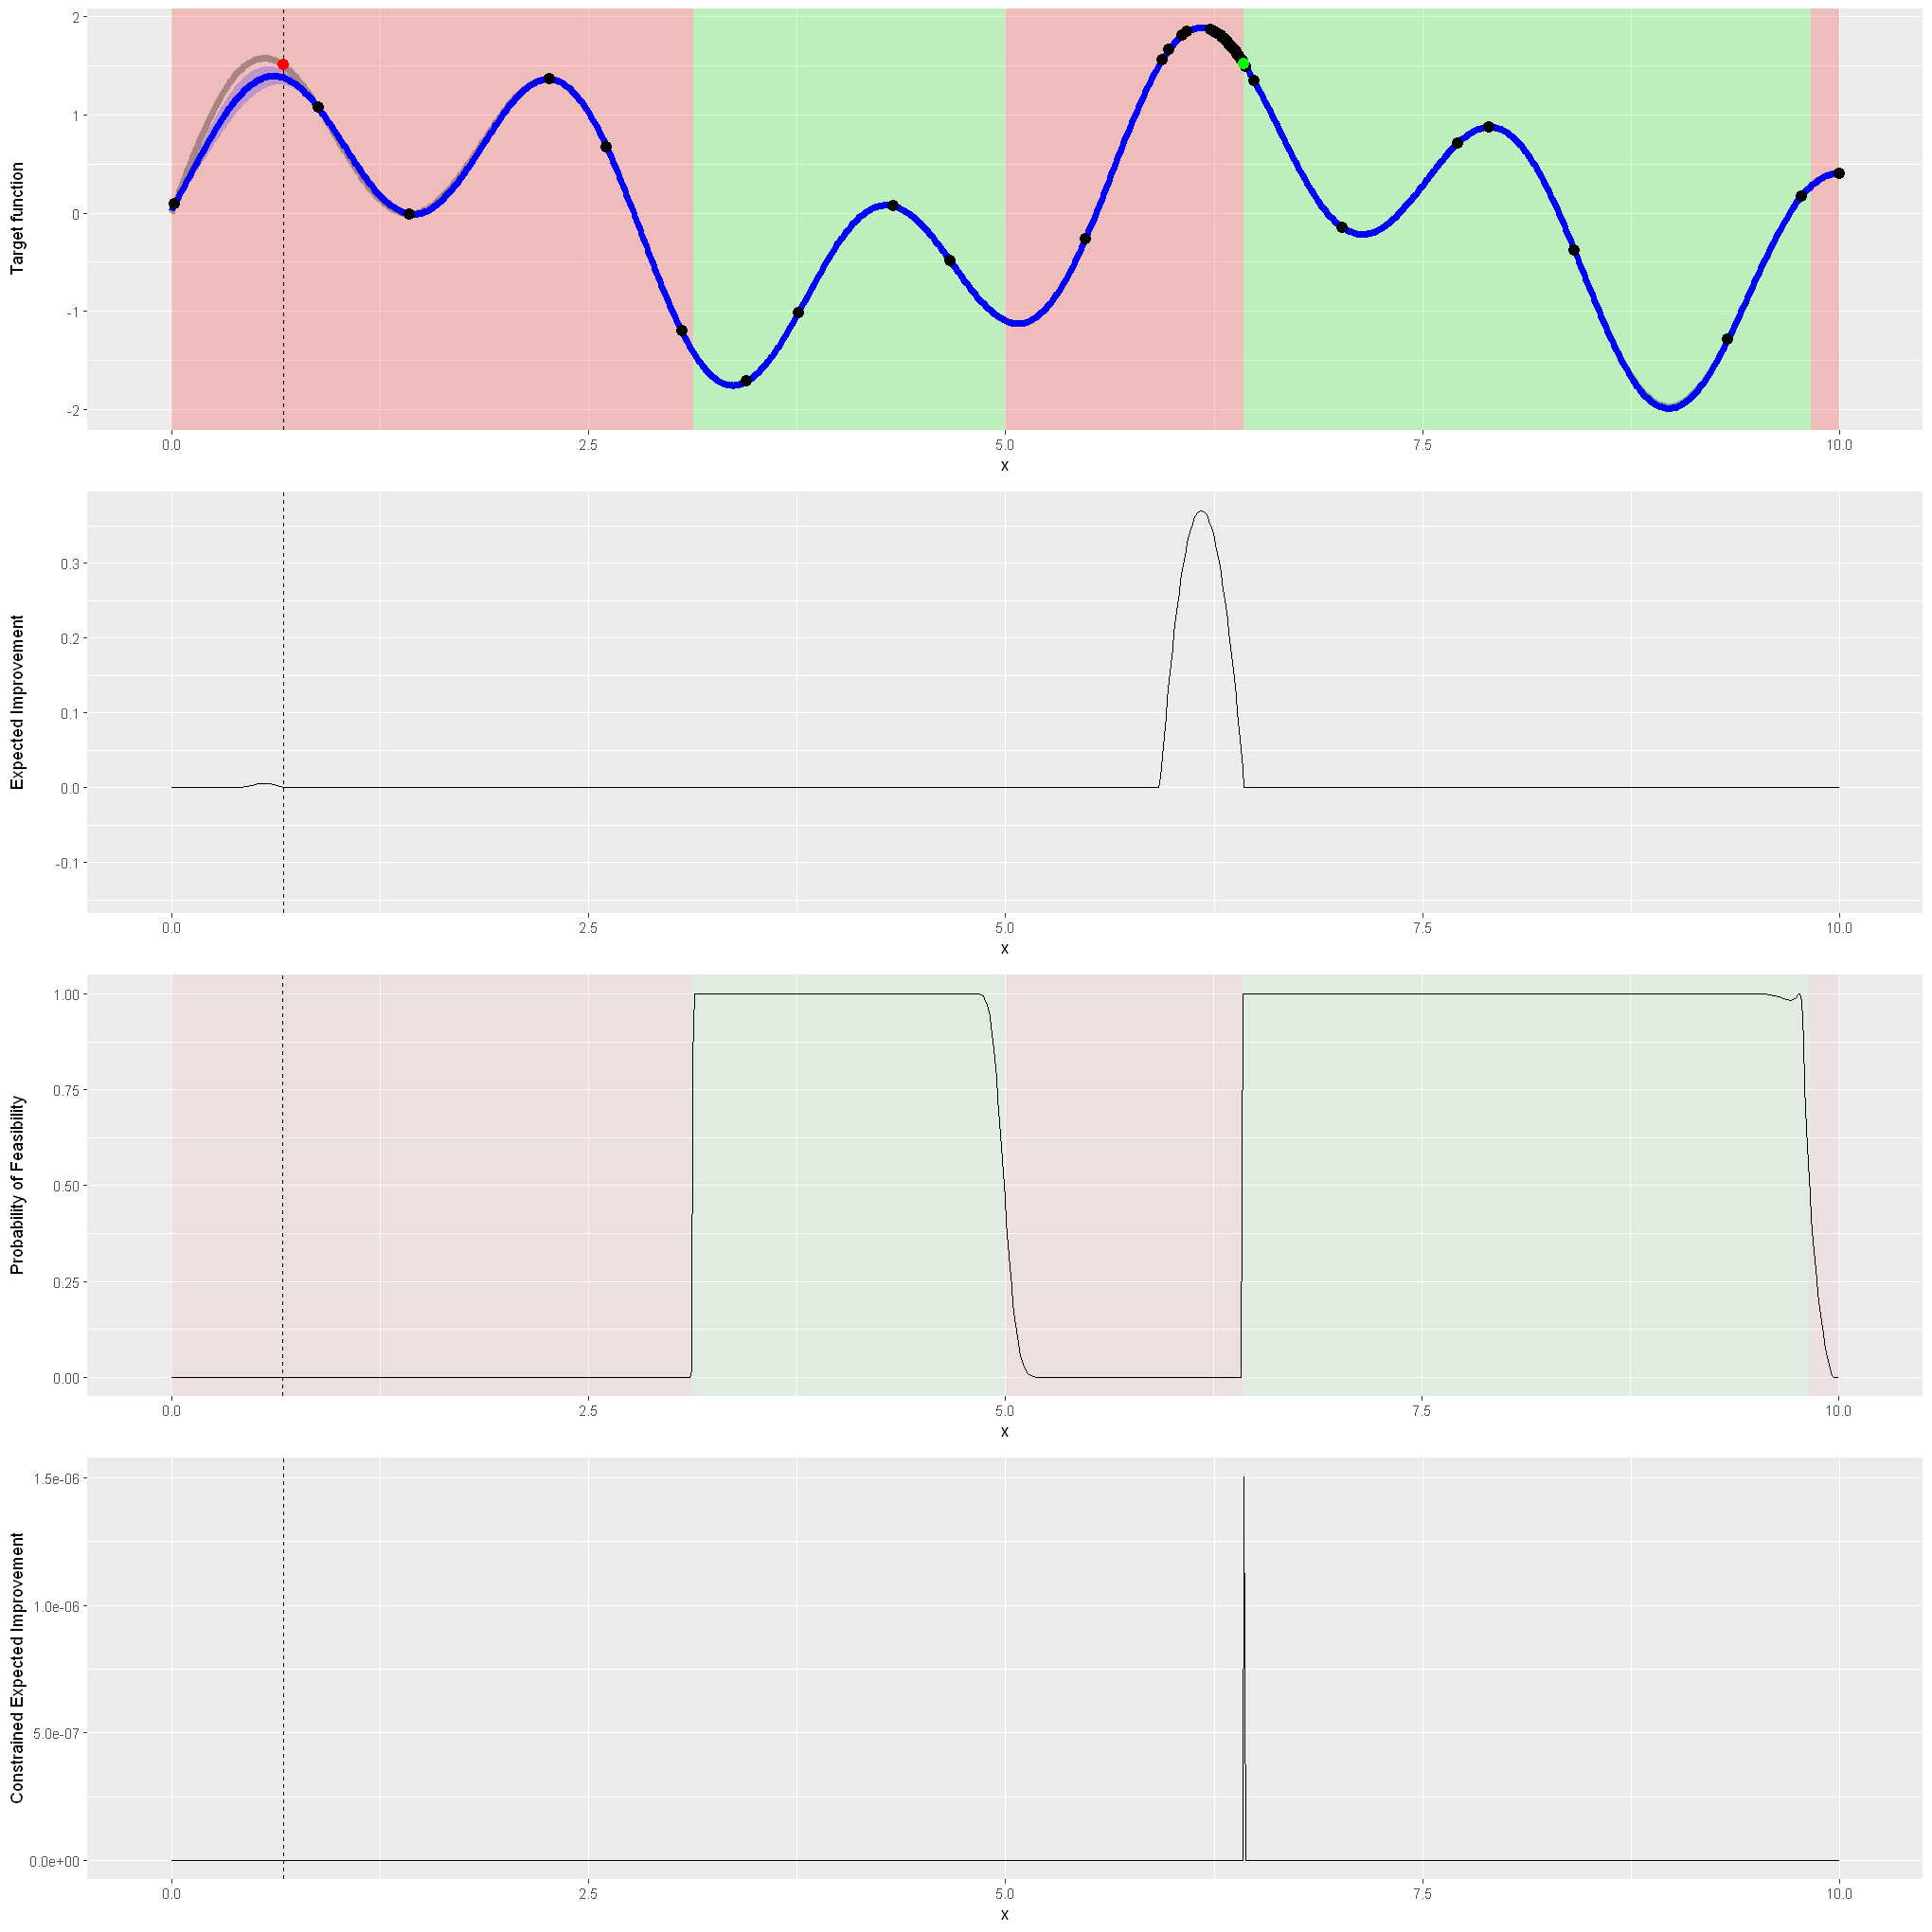

Iteration 47 


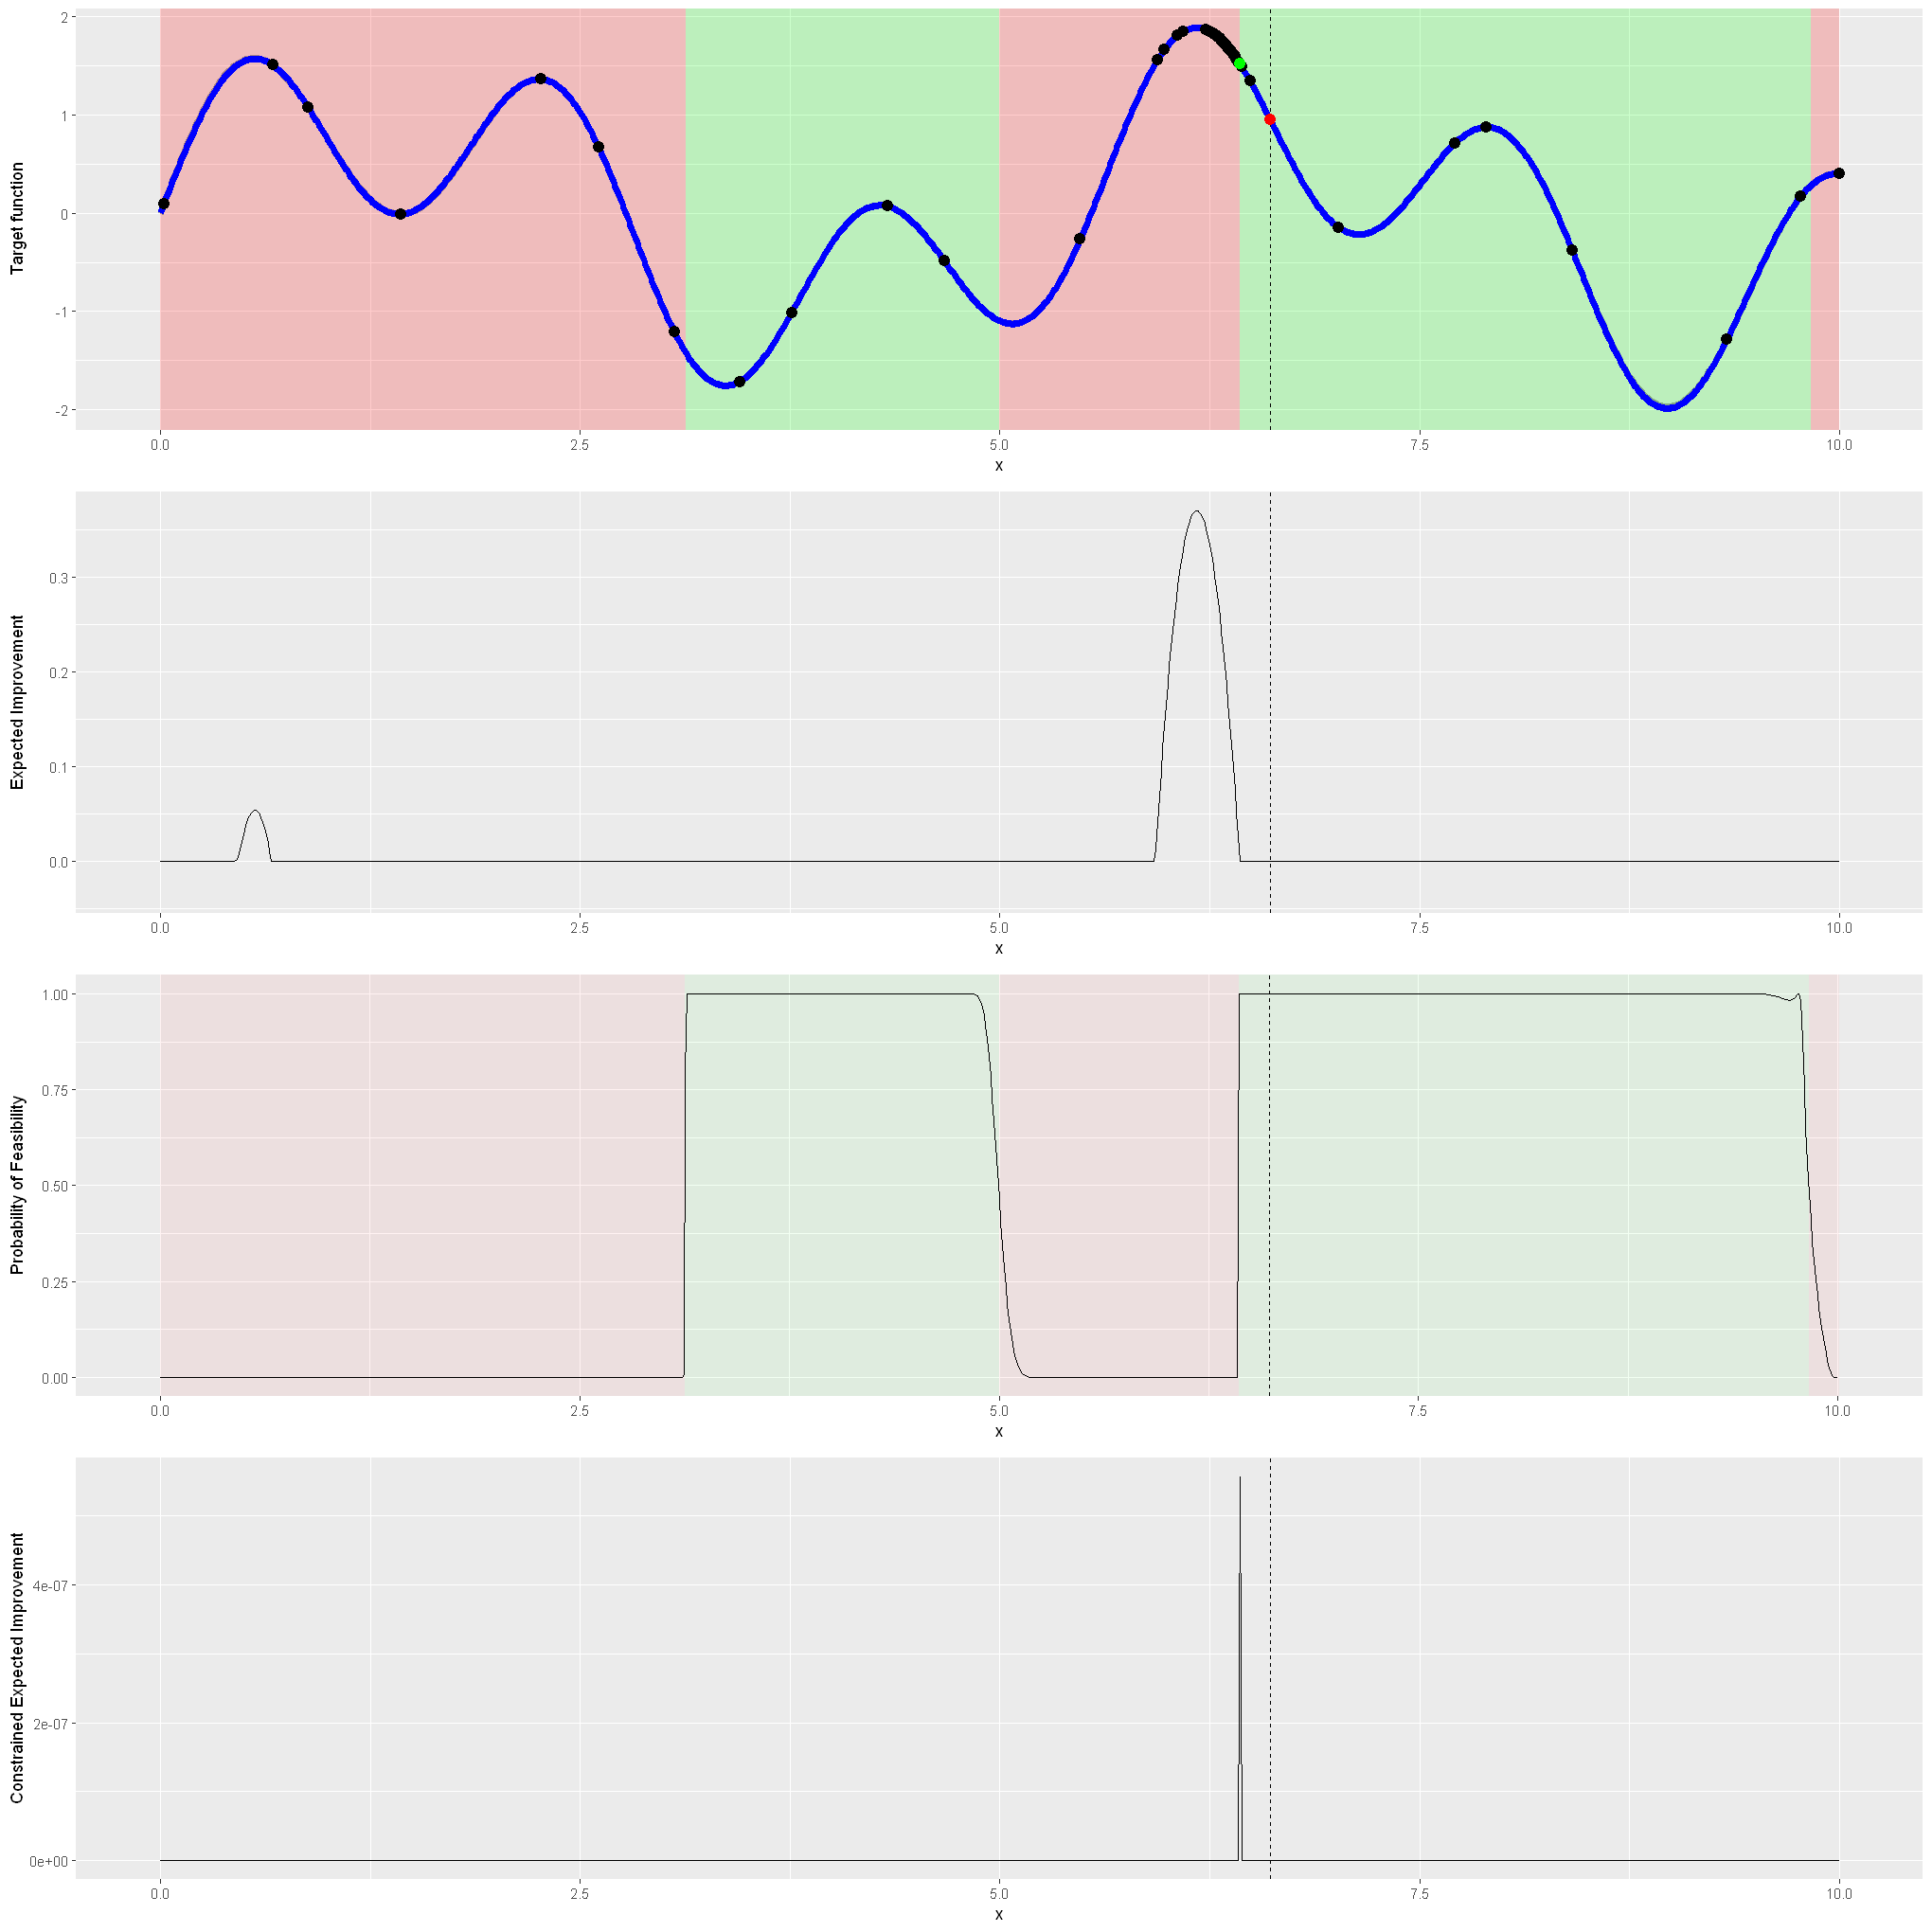

Iteration 48 


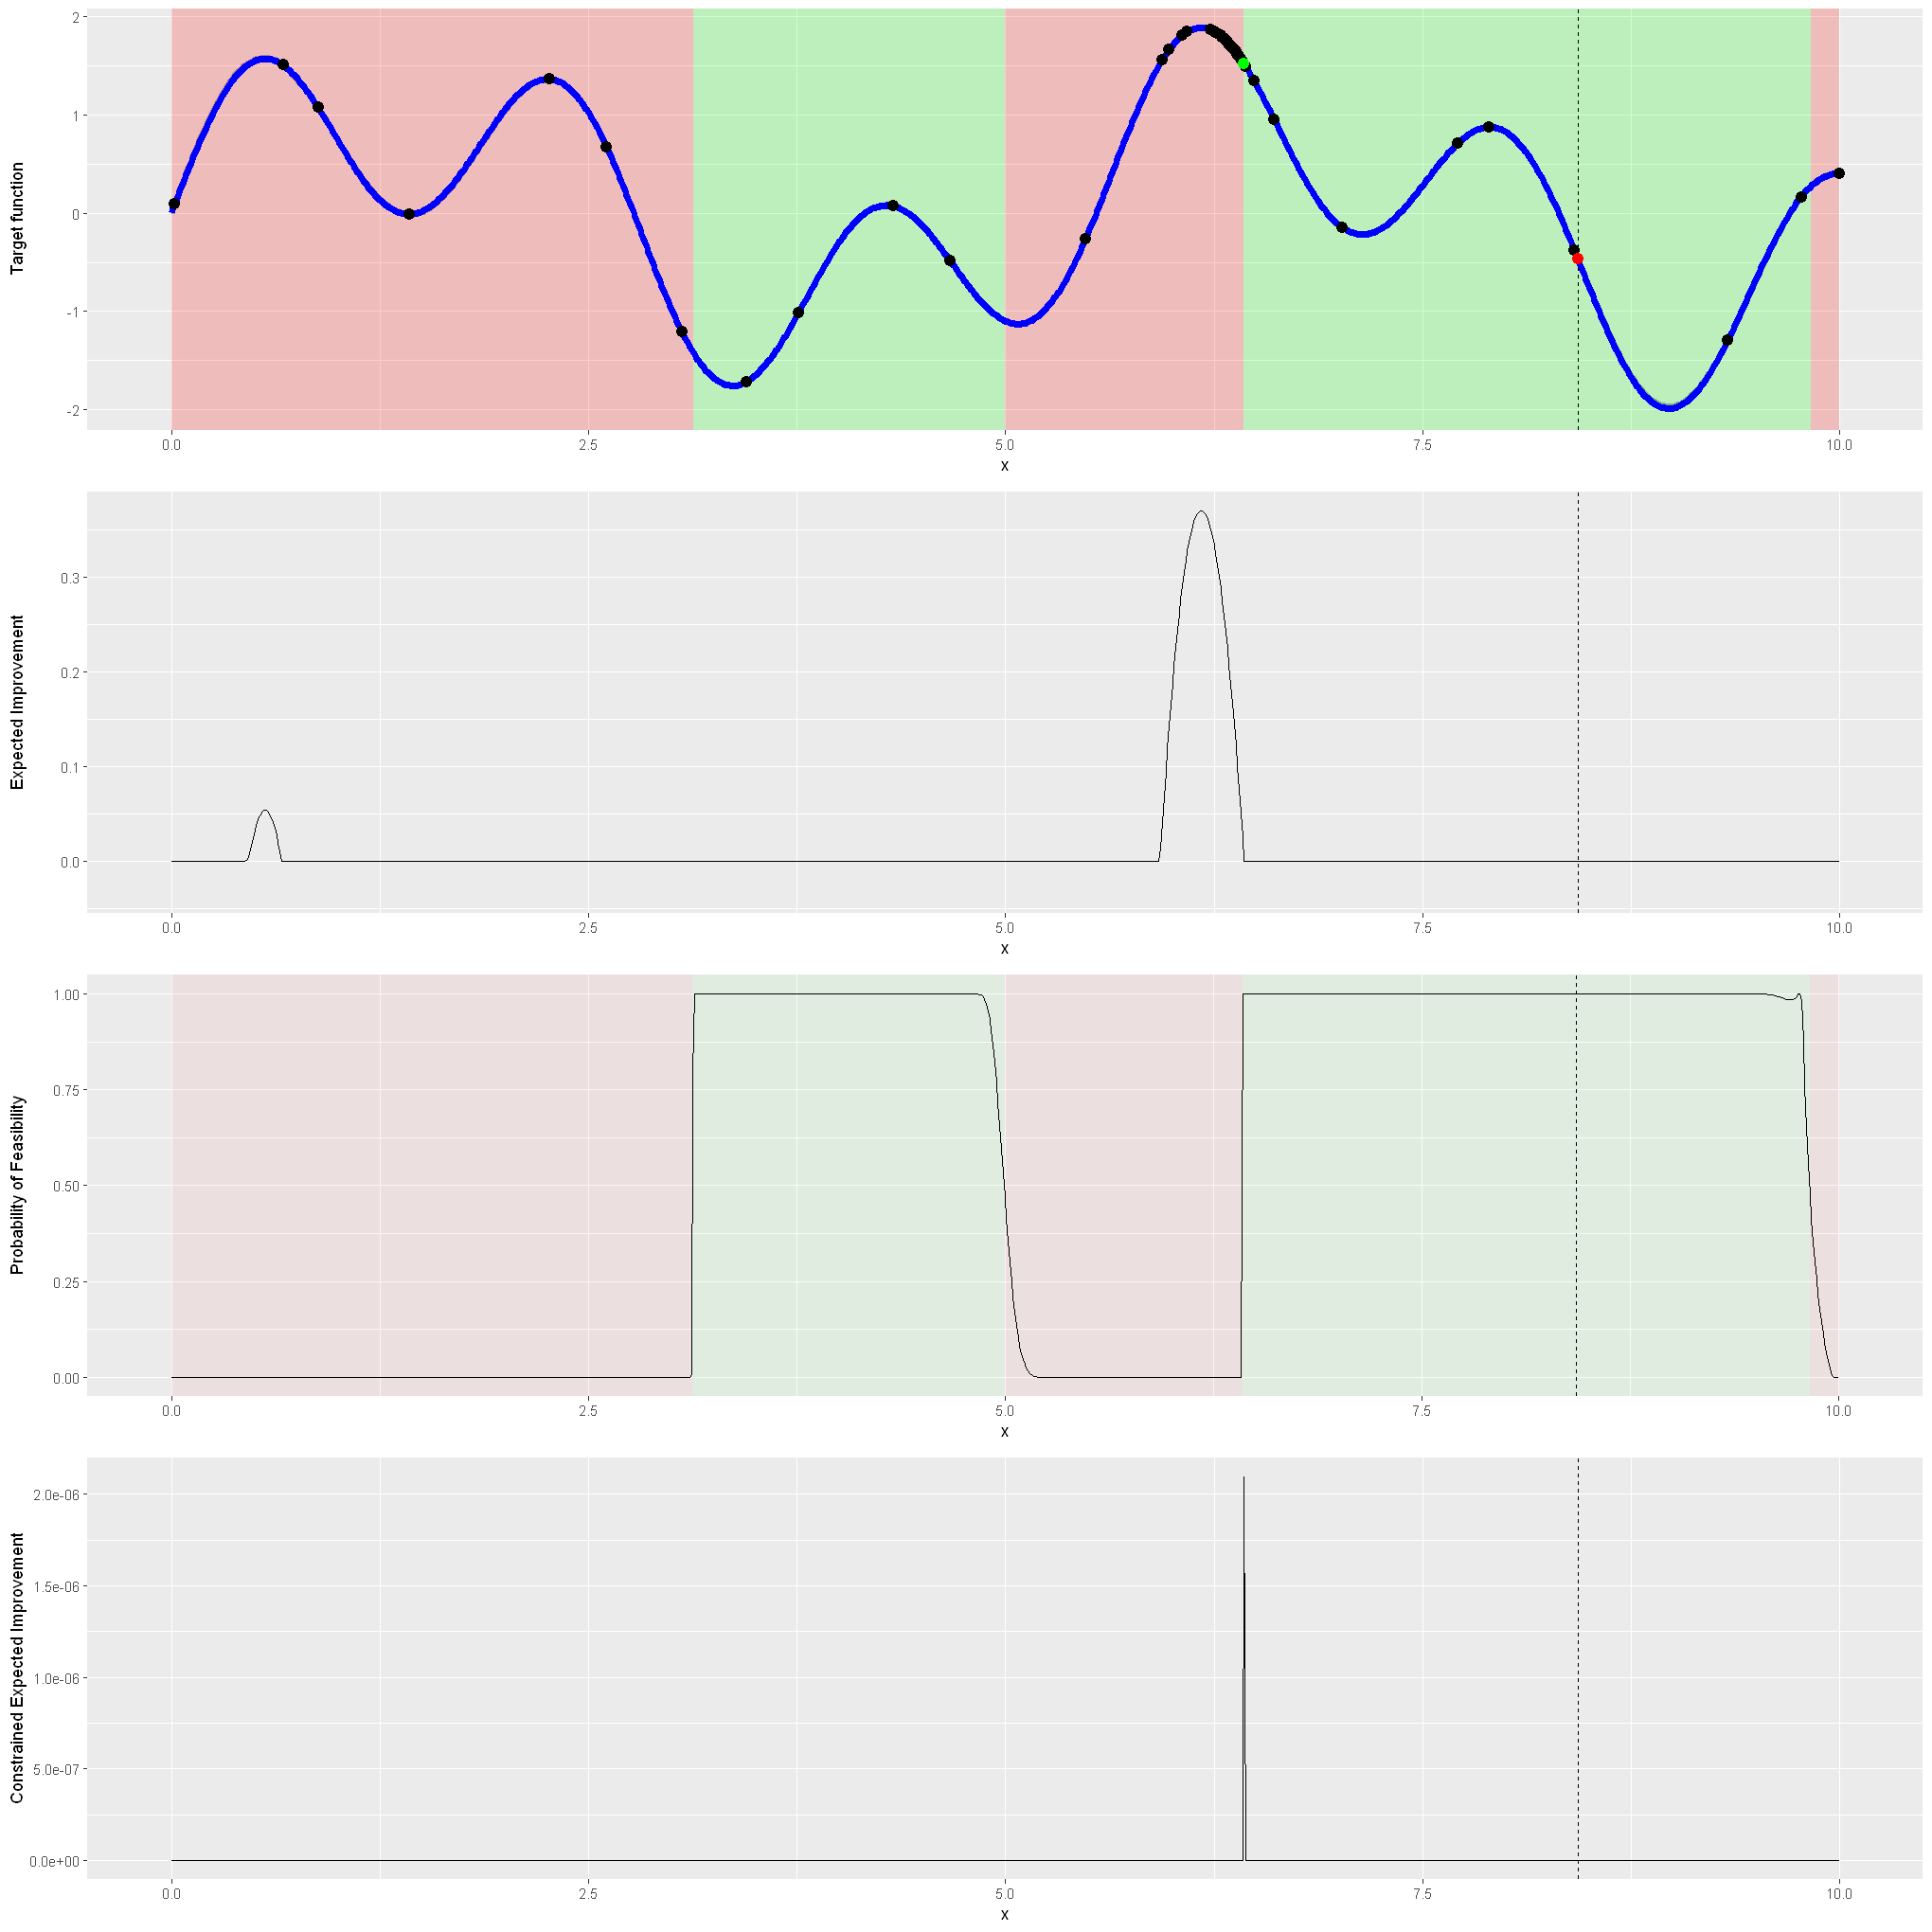

Iteration 49 


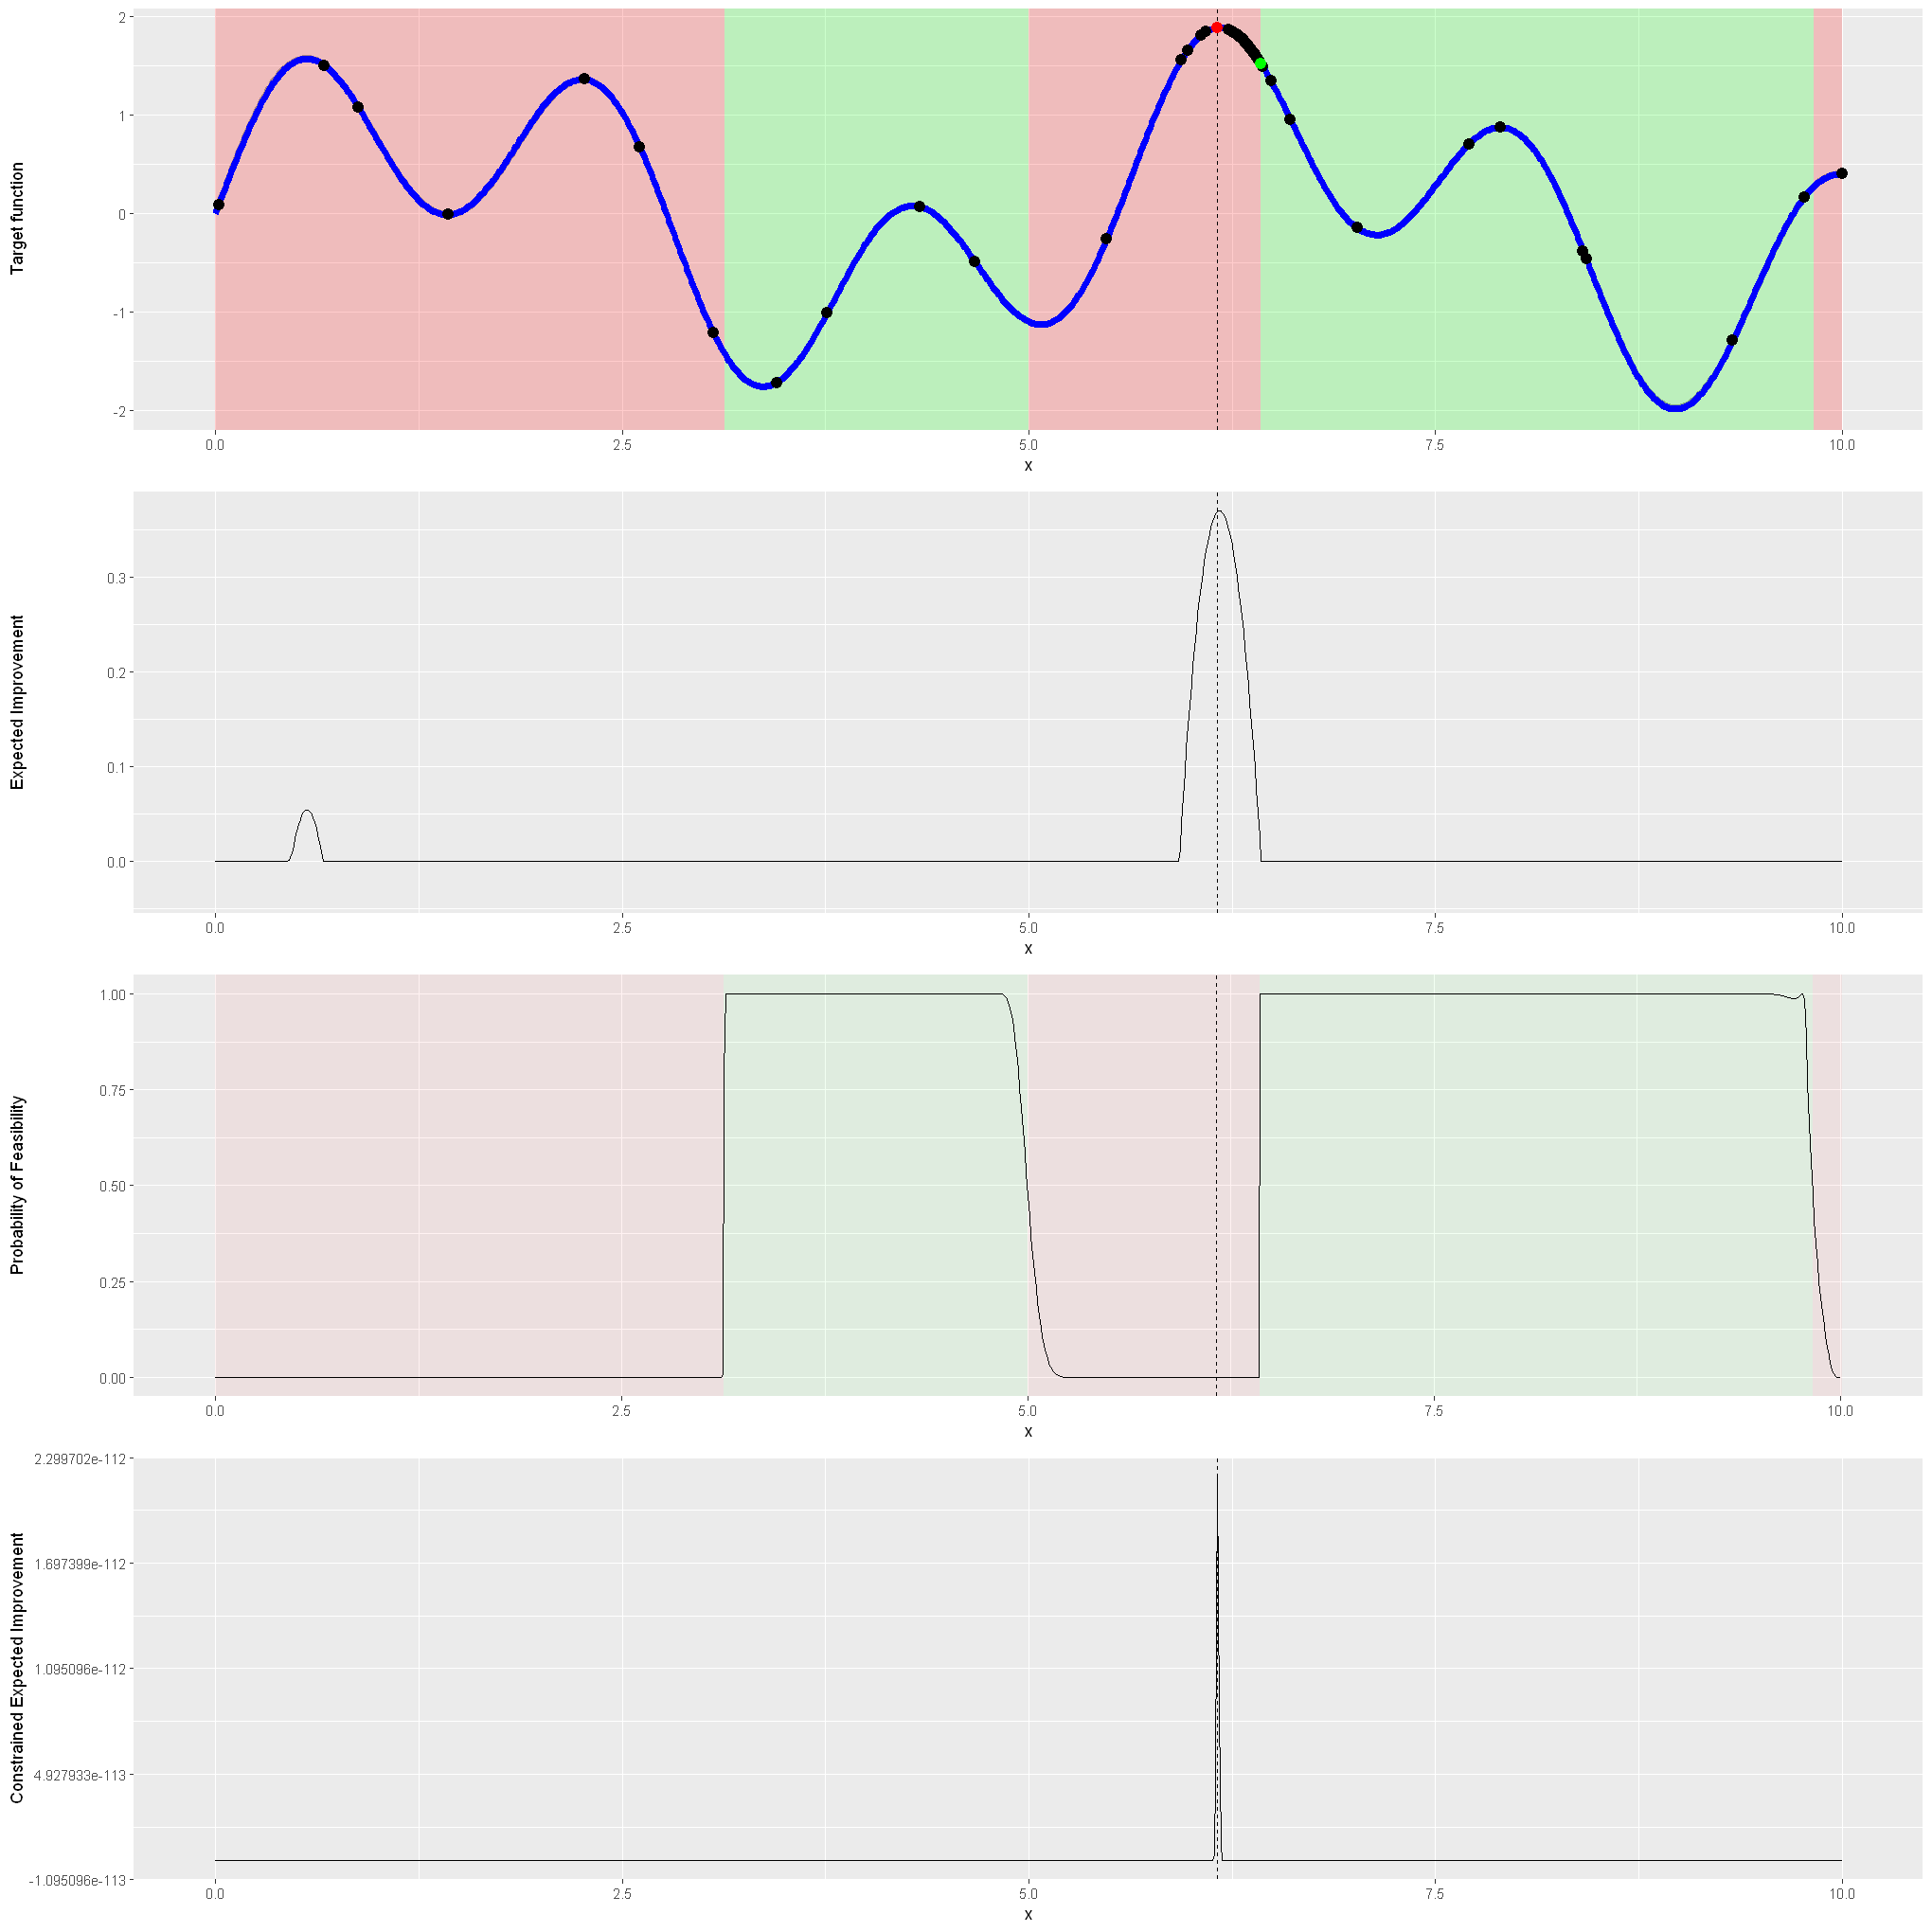

Iteration 50 


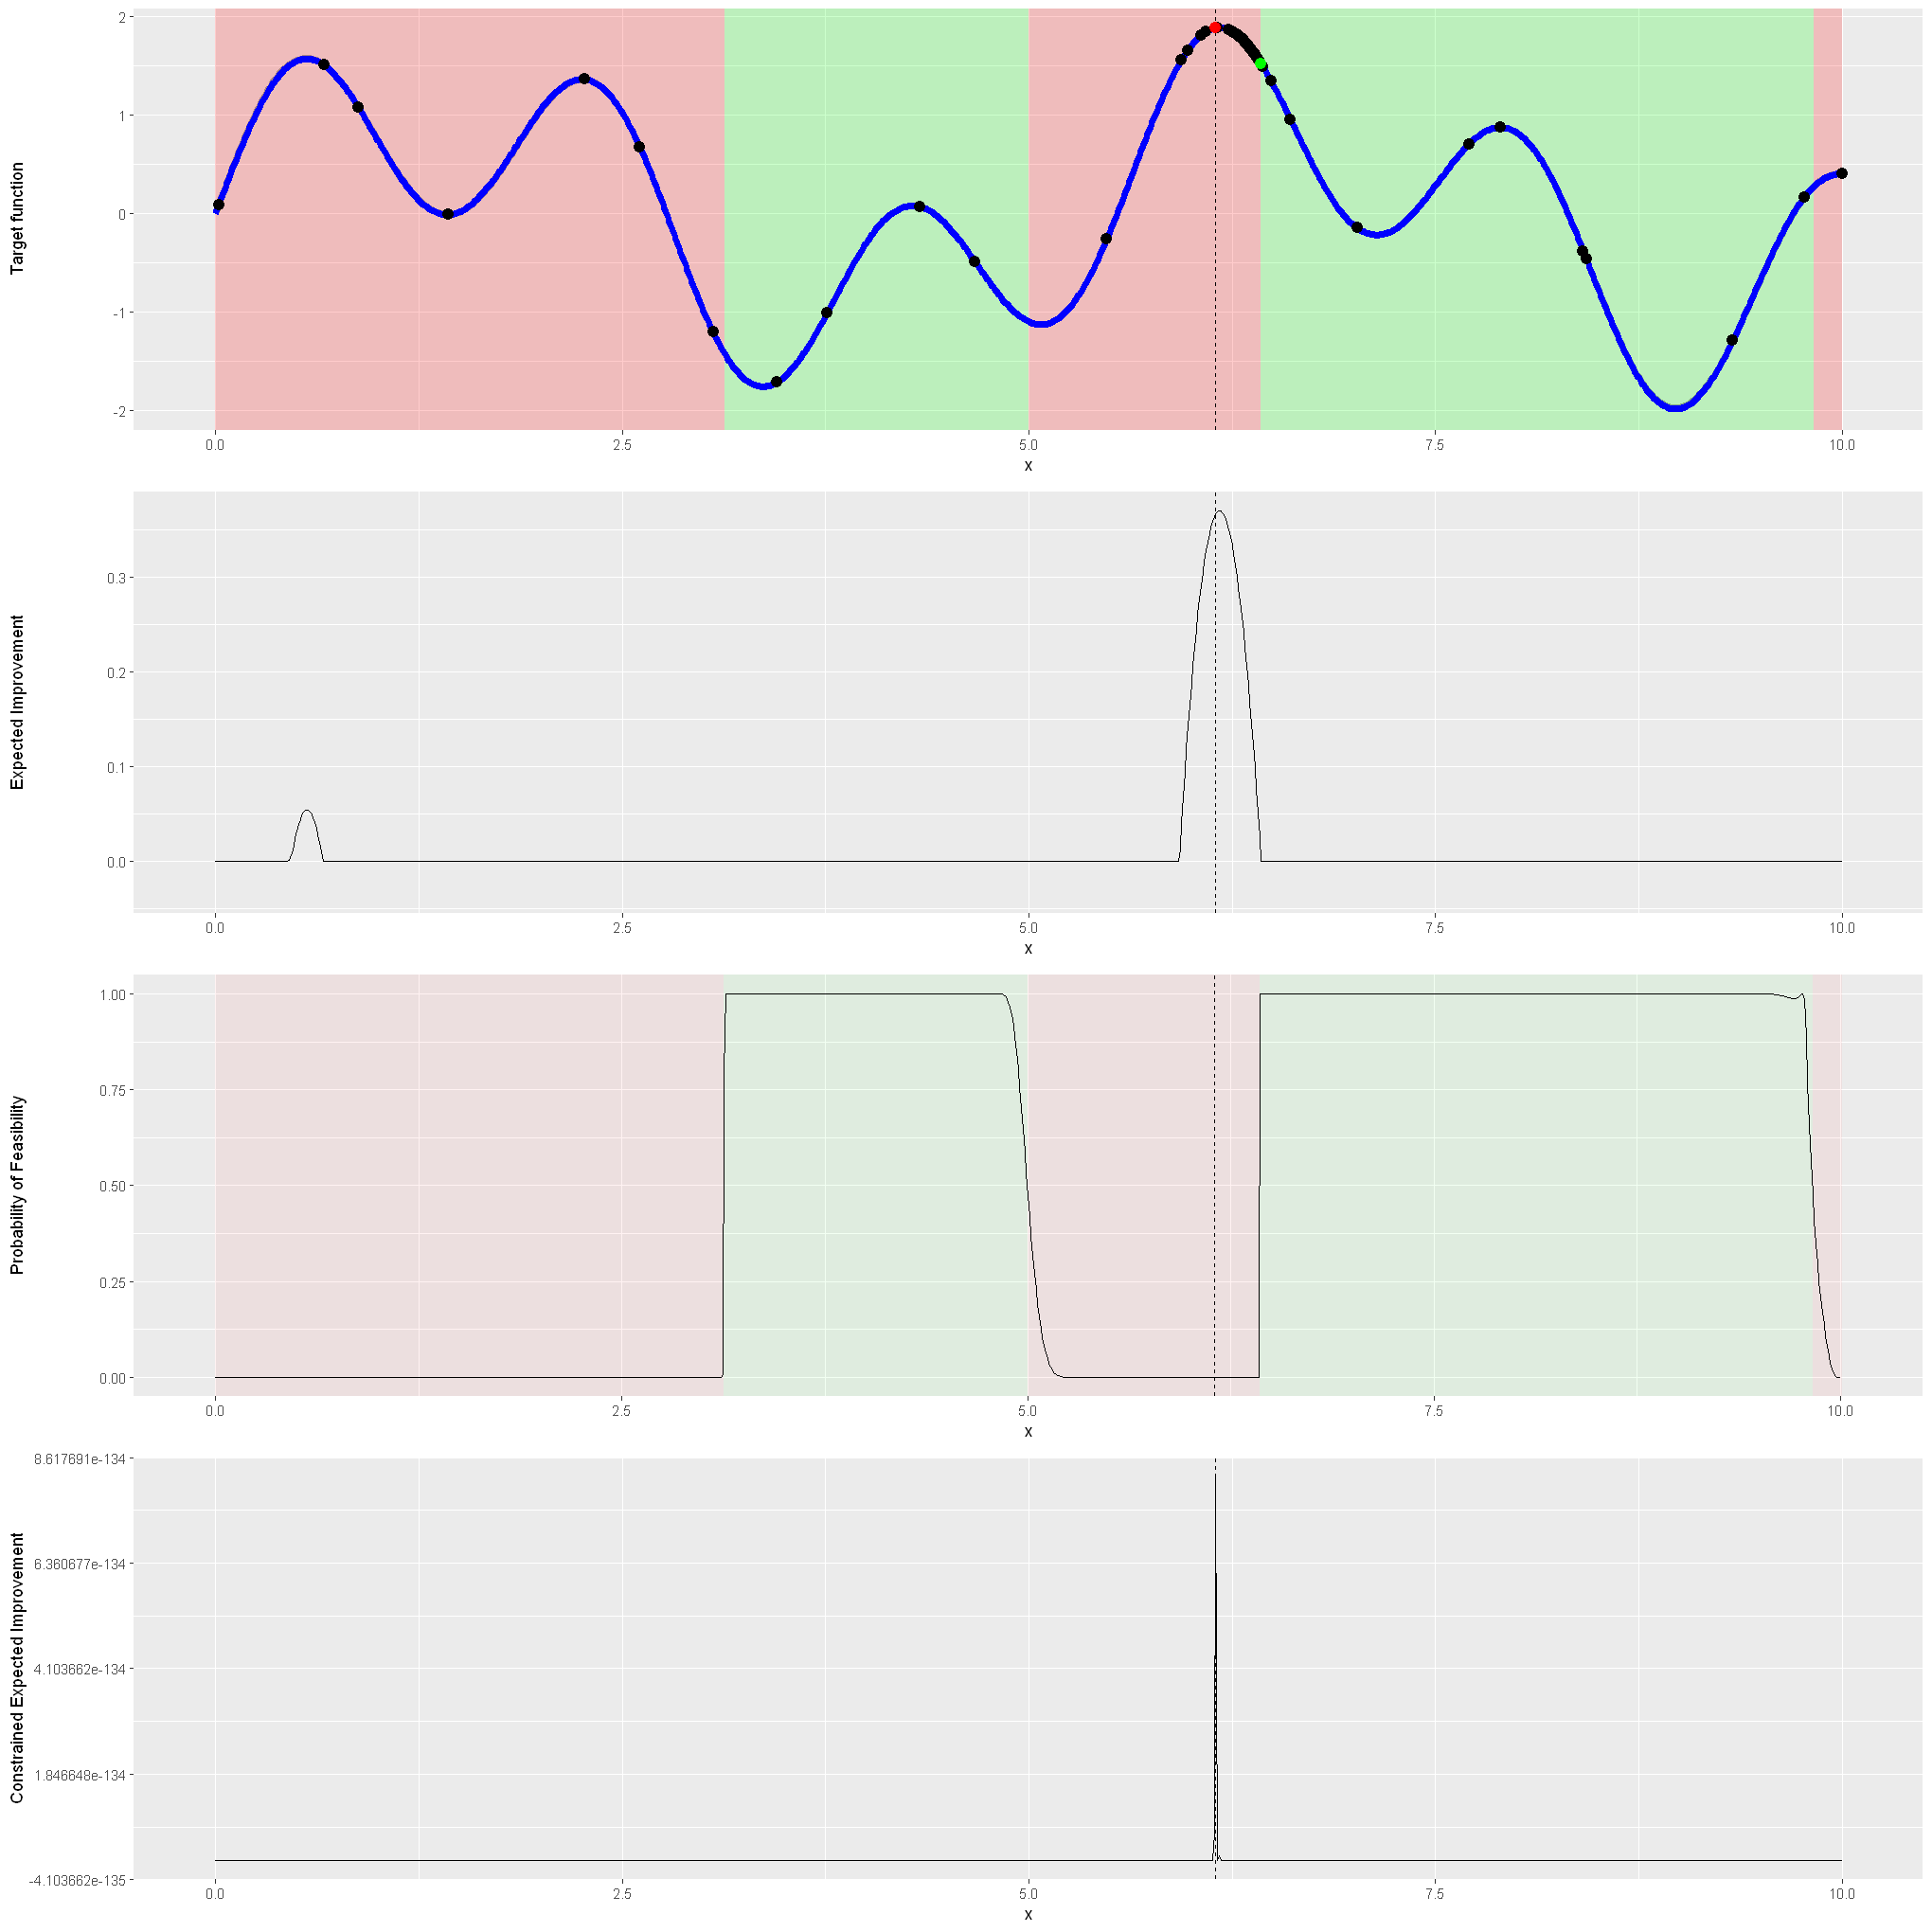

In [4]:
# Start optimization

options(repr.plot.width=17, repr.plot.height=17)

observed.x <- numeric(0)
observed.y <- numeric(0)
observed.c <- matrix(nrow=0, ncol=length(c.lambda))

set.seed(1)

for(n in seq(n.iterations)) {
  gp.model <- calculate.regression.model(observed.x, observed.y, observed.c)
  
  xx <- c(x.plt, observed.x)
  xx <- xx[!duplicated(xx)]
  xx <- xx[order(xx)]
  yy.acq <- sapply(xx, function(x) acq.func(gp.model, x))
  
  next.evaluation.points <- choose.next.evaluation.points(xx, yy.acq, observed.x, gp.model)
  
  yy <- sapply(xx, function(x) gp.model$mean(x))
  ss <- sapply(xx, function(x) sqrt(max(gp.model$cov(x)[1,1], 0)))
  
  df <- data.frame(x=xx, y=yy, ymin=yy-ss, ymax=yy+ss)
  points.df <- data.frame(x=observed.x, y=observed.y)
  next.points.df <- data.frame(x=next.evaluation.points, y=f(next.evaluation.points))
  
  plt <- plt.f +
    geom_line(data=df, linetype='solid', color='blue', size=2) +
    geom_ribbon(data=df, aes(ymin=ymin, ymax=ymax), fill='blue', alpha=.2) +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    geom_point(data=points.df, color='black', size=3) +
    geom_point(data=next.points.df, color='red', size=3) +
    geom_point(x=gp.model$best.x, y=gp.model$best.y, color='green', size=3)
  
  yy.ei <- sapply(xx, function(x) acq.func.ei(gp.model,x))
  df.ei <- data.frame(x=xx, y=yy.ei, ymin=yy.ei-ss, ymax=yy.ei+ss)
  ei.plt <- ggplot(df.ei, aes(x=x, y=y, ymin=ymin, ymax=ymax)) + 
    geom_line() +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    ylab('Expected Improvement')
  
  yy.c <- sapply(xx, function(x) acq.func.pf(gp.model,x))
  df.c <- data.frame(x=xx, y=yy.c, ymin=yy.c-ss, ymax=yy.c+ss, fill=yy.c > .5)
  df.c$xmin <- df.c$x
  df.c$xmax <- df.c$x + (xx[2]-xx[1])
  c.plt <- ggplot(df.c, aes(x=x, y=y, ymin=ymin, ymax=ymax)) + 
    geom_rect(inherit.aes = FALSE, mapping=aes(xmin=xmin, xmax=xmax, fill=fill), color=NA, ymin=-Inf, ymax=Inf, alpha=.05) +
    geom_line() +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    ylim(0,1) +
    ylab('Probability of Feasibility') +
    scale_fill_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
    scale_color_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
    theme(legend.position = "none")
  
  df.acq <- data.frame(x=xx, y=yy.acq)
  acq.plt <- ggplot(df.acq, aes(x=x, y=y)) +
    geom_line() +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    ylab('Constrained Expected Improvement') +
    xlim(x.limits)
  
  constraint.est.plt.list <- lapply(seq_along(c.lambda), function(i) {
    yy.ci <- sapply(xx, function(x)gp.model$mean.c(x)[i])
    yy.ci.real <- sapply(xx, function(x) constraint(x)[i])
    ss.ci <- sapply(xx, function(x)gp.model$cov.c(x)[i,i])
    df.ci <- data.frame(x=xx, y=yy.ci, yr=yy.ci.real, ymin=yy.ci-ss.ci, ymax=yy.ci+ss.ci, fill=yy.ci<c.lambda[i])
    df.ci$xmin <- df.ci$x
    df.ci$xmax <- df.ci$x + (xx[2]-xx[1])
    
    points.df.ci <- data.frame(x=observed.x, y=as.numeric(sapply(observed.x, function(x) constraint(x)[i])))
    next.points.df.ci <- data.frame(x=next.evaluation.points, y=as.numeric(sapply(next.evaluation.points, function(x) constraint(x)[i])))
    
    plt.ci <- ggplot(df.ci, aes(x=x, y=y, xmin=xmin, xmax=xmax, fill)) + 
      geom_rect(mapping=aes(xmin=xmin, xmax=xmax, fill=fill), ymin=-Inf, ymax=Inf, color=NA, alpha=.05) +
      geom_line(mapping=aes(x=x, y=yr), size=2, alpha=.3) +
      geom_line(linetype='solid', color='blue', size=2) +
      geom_ribbon(aes(ymin=ymin, ymax=ymax), fill='blue', alpha=.2) +
      geom_point(data=points.df.ci, inherit.aes = FALSE, mapping=aes(x=x, y=y), color='black', size=3) +
      geom_point(data=next.points.df.ci, inherit.aes = FALSE, mapping=aes(x=x, y=y), color='red', size=3) +
      geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
      geom_hline(yintercept = c.lambda[i], linetype='dotted') +
      coord_cartesian(xlim=x.limits) +
      ylab(paste0('Restriction ', i)) +
      scale_fill_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
      scale_color_manual(name='Region', breaks=c(FALSE, TRUE), values=c('red', 'green'), labels=c('Unfeasable', 'Feasable')) +
      theme(legend.position = "none")
    return(plt.ci)
  })
  
  observed.x <- c(observed.x, next.evaluation.points)
  observed.y <- c(observed.y, f(next.evaluation.points))
  observed.c <- rbind(observed.c, 
                      matrix(unlist(lapply(next.evaluation.points, constraint)), 
                             ncol=3, 
                             byrow = T)
  )
  
  plts.iter <- append(append(list(plt), constraint.est.plt.list), list(ei.plt, c.plt, acq.plt))
  plts.iter <- plts.iter[seq(-2,-(length(constraint.est.plt.list)+1))]
  
  plt2 <- plot_grid(plotlist = plts.iter, nrow=length(plts.iter), align='v')

  print(plt2)
  
  cat(paste('Iteration',n,'\n'))
}